# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1216]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

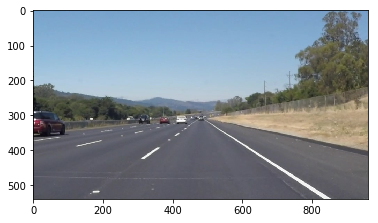

In [1217]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [1218]:
import math

DEBUG=True

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_poly(img,vertices,color=[0,255,0],thickness=5):
    for i in range(len(vertices)):
        if (i == (len(vertices) - 1)):
            cv2.line(img,vertices[i],vertices[0],color,thickness)
        else:
            cv2.line(img,vertices[i],vertices[i+1],color,thickness)

def draw_lines_simple(img,lines,color=[0,0,255],thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def max_slope(slopes,mags):
    # Find hte Max Slope. We don't use this
    max_mag = mags[0]
    max_slope = slopes[0]
    for s,m in zip(slopes,mags):
        if m > max_mag:
            max_mag = m
            max_slope = s
            
    return max_slope

def weighted_slope(slopes,mags):
    # Slope weighted by the magnitude of the line 
    wsum = 0
    tot = 0
    for s,m in zip(slopes,mags):
        wsum += s*m
        tot += m
    weighted_slope = wsum/tot
    
    return weighted_slope
    
def centeroidnp(arr):
    # Find the centeroid when given a bunch of vertices
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length
            
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slopes=[]
    
    left_slopes = np.array([])
    left_points=(img.shape[1],img.shape[0])
    left_mags = np.array([])
    
    right_slopes = np.array([])
    right_points=(0,img.shape[0])
    right_mags=np.array([])
    
    right_lines=np.array([])
    left_lines=np.array([])
    
    cntr = 0

    # Separate left lines from right lines.
    # Also calculate the slopes, magnitudes of lines and the points themselves
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope =  (y2-y1)/(x2-x1)
            mag = np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))
            if slope >=0 :
                right_slopes = np.append(right_slopes,[slope])
                right_mags = np.append(right_mags,[mag])
                right_lines = np.append(right_lines, line)
            else:
                left_slopes = np.append(left_slopes,[slope] )
                left_mags = np.append(left_mags,[mag])
                left_lines = np.append(left_lines, line )
    
    # Filter out slopes which are very different from the mean.  
    counter = 0
    if DEBUG:
        print("LOW PASS FILTER")
    for l in left_slopes:
        if (np.abs(l-left_slopes.mean()) > left_slopes.std()):
            if DEBUG:
                print("({}) mean={} std={} val={}".format(counter,left_slopes.mean(),left_slopes.std(),np.abs(l-left_slopes.mean())))
            left_slopes = np.delete(left_slopes,counter)
            left_mags = np.delete(left_mags,counter)     
            left_lines = np.delete(left_lines,[counter*4,counter*4+1,counter*4+2,counter*4+3])
            counter -= 1
        counter+=1
        
    counter = 0
    for l in right_slopes:
        if (np.abs(l-right_slopes.mean()) > right_slopes.std()):
            if DEBUG:
                print("({}) mean={} std={} val={}".format(counter,right_slopes.mean(),right_slopes.std(),np.abs(l-right_slopes.mean()))) 
            right_slopes = np.delete(right_slopes,counter)
            right_mags = np.delete(right_mags,counter)     
            right_lines = np.delete(right_lines,[counter*4,counter*4+1,counter*4+2,counter*4+3])
            counter -= 1
        counter+=1
    
    # Calculate the centeroid of all the points from the lines
    lpoint = centeroidnp(left_lines.reshape((  int(left_lines.shape[0]/2),2)))
    rpoint = centeroidnp(right_lines.reshape(( int(right_lines.shape[0]/2),2)))
    
    # Calculate the weighted slope of all the lines
    lslope = weighted_slope(left_slopes,left_mags)
    rslope = weighted_slope(right_slopes,left_mags)
    
    
    max_y = 320 # y value for top of the line
    min_y = img.shape[0] # y value for the bottom of the line
    
    left_slope_wm = weighted_slope(left_slopes,left_mags)
    right_slope_wm = weighted_slope(right_slopes,right_mags)
    
    #calculate the top and bottom points of the line. 
    top_left_x = (max_y-lpoint[1])/left_slope_wm + lpoint[0]
    top_right_x = (max_y-rpoint[1])/right_slope_wm + rpoint[0]

    bottom_left_x = (min_y - lpoint[1])/left_slope_wm + lpoint[0] 
    bottom_right_x = (min_y - rpoint[1])/right_slope_wm + rpoint[0] 
    
    
    if DEBUG:
        print("max_y {} left_points={} left_slopes.mean={} thickness={}".format(max_y,lpoint,left_slopes.mean(),thickness))  
        print("min_y {} right_points={} right_slopes.mean={} thickness={}".format(min_y,rpoint,right_slopes.mean(),thickness))
        print("tl{} tr{} bl{} br{} ".format(top_left_x,top_right_x,bottom_left_x,bottom_right_x))
    
    # Draw the LEFT Line 
    if ((np.isnan(left_slopes.mean())!=True) and (np.isinf(left_slopes.mean())!=True)):
        cv2.line(img,  (int(bottom_left_x),min_y), (int(top_left_x),max_y), color, thickness )

    # Draw the RIGHT Line
    if ((np.isnan(right_slopes.mean())!=True) and (np.isinf(right_slopes.mean())!=True) and (np.isinf(bottom_right_x)!=True)and (np.isinf(top_right_x)!=True)):
        cv2.line(img,  (int(bottom_right_x),min_y)  , (int(top_right_x),max_y), color, thickness )


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
   
    draw_lines(line_img, lines,color=[255, 0, 0], thickness=12)
    
    # Uncomment to draw the raw basic lines which were ouptut by Hough Transform.
    #draw_lines_simple(line_img, lines,color=[0,200,200],thickness=2)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [1219]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

LOW PASS FILTER
(0) mean=-0.810089241288863 std=0.025513027121904522 val=0.026645452588688112
(2) mean=-0.8012074237593002 std=0.023501900775261923 val=0.033229662333415066
(0) mean=0.5652679369889038 std=0.011091134303391053 val=0.011251316490288765
(1) mean=0.5690183758190002 std=0.010380487199932738 val=0.014641717994066439
(1) mean=0.5763392348160334 std=0.0009202404026255606 val=0.0009202404026256161
max_y 320 left_points=(345.0, 410.5) left_slopes.mean=-0.7845925925925926 thickness=12
min_y 540 right_points=(700.5, 436.0) right_slopes.mean=0.577259475218659 thickness=12
tl460.3431122218534 tr499.5505050505051 bl179.951016212928 br880.6616161616162 
LOW PASS FILTER
(1) mean=-0.7094079759766503 std=0.023296981155171696 val=0.03293738774135613
(0) mean=0.6373518060978557 std=0.013127571063344388 val=0.013471209082930313
(2) mean=0.6418422091254992 std=0.012211577237531527 val=0.017217584500874517
max_y 320 left_points=(384.25, 377.5) left_slopes.mean=-0.7258766698473282 thickness=12

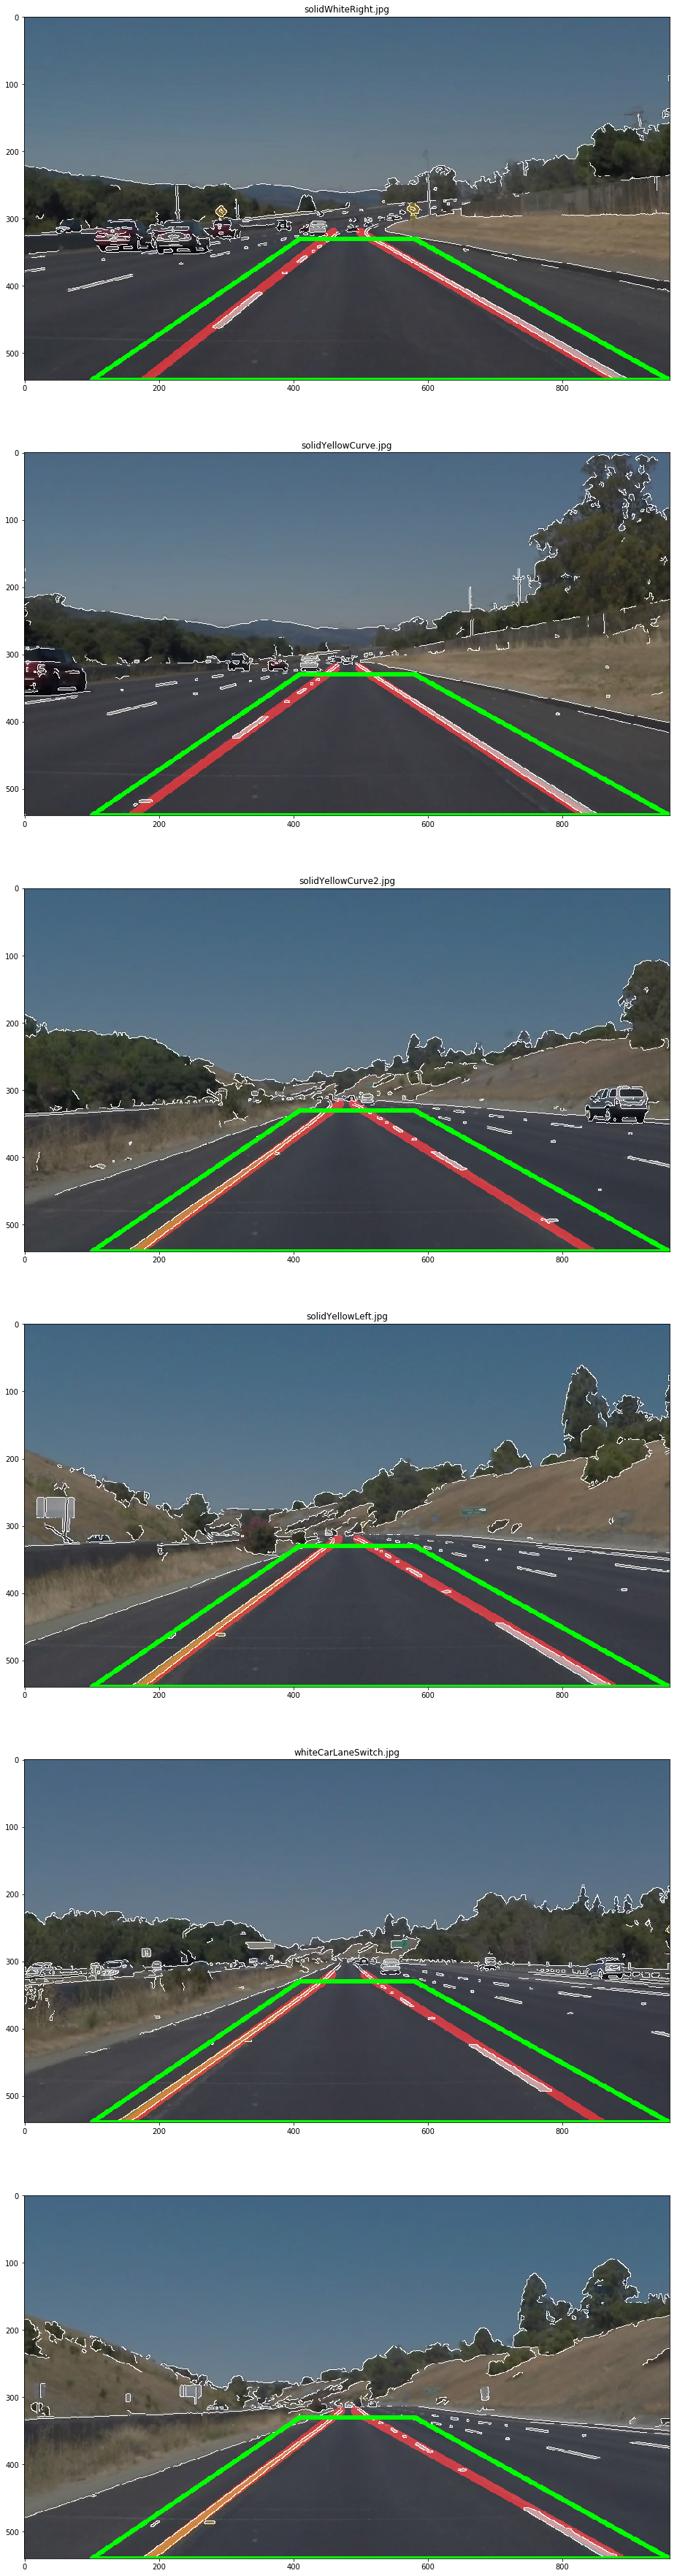

In [1220]:
#### TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(img):
    
    # Clipping Max
    verts = [(410,330),(100,img.shape[0]),(img.shape[1],img.shape[0]),(580,330)]
    vertices = np.array([verts]) 
    
    # grayscale
    img_g = grayscale(img)
                                 
    blur = gaussian_blur(img_g,3)
    
    low_t = 75
    high_t = 150
    edges = canny(blur,low_t,high_t)
    
    clipped = region_of_interest(edges, vertices) 
    
    # plt.imshow(clipped)
    # Make a blank the same size as our image to draw on
    #rho = 1 # distance resolution in pixels of the Hough grid
    #theta = np.pi/180 # angular resolution in radians of the Hough grid
    #threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    #min_line_length = 30 #minimum number of pixels making up a line
    #max_line_gap = 20    # maximum gap in pixels between connectable line segments
    #line_image = np.copy(image)*0 # creating a blank to draw lines on
    rho=1
    theta = np.pi/180
    threshold = 30   #30 
    min_line_len = 18  #20
    max_line_gap = 80   #60
    
    lines = hough_lines(clipped,rho,theta,threshold,min_line_len,max_line_gap)

    img_w = weighted_img(lines,img)
    
    # Show the raw hough transform edges
    if DEBUG:
        image_edges = np.dstack((edges,edges,edges))
        img_w = weighted_img(image_edges,img_w)
    
    # Show the clipping polygon
    if DEBUG:
        draw_poly(img_w,verts)
    
    return img_w
    
files = os.listdir("test_images/")

process_1_file = False

if(process_1_file):
    img = mpimg.imread('test_images/solidWhiteRight.jpg')
    plt.figure(figsize=(16,64))
    plt.imshow(pipeline(img))
else:
    fig = plt.figure(figsize=(16,64))
    cntr=1
    for fname in files:
        img = mpimg.imread('test_images/'+fname)
        plt.title(fname)
        plt.subplot(6,1,cntr)
        plt.imshow(pipeline(img))
        cntr+=1
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [1221]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1222]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [1223]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

LOW PASS FILTER
(1) mean=-0.7357217926768903 std=0.012909097139482807 val=0.016310727648312984
(1) mean=-0.7316441107648121 std=0.011187874566480611 val=0.019376297398453257
(2) mean=-0.7251853449653276 std=0.0001695891409073331 val=0.00022449110024613805
(0) mean=0.6164454800621948 std=0.011037507273263856 val=0.01702184893827552
(3) mean=0.6198498498498498 std=0.008755197214353893 val=0.01667524667524667
max_y 320 left_points=(289.75, 438.0) left_slopes.mean=-0.7250730994152046 thickness=12
min_y 540 right_points=(722.125, 459.0) right_slopes.mean=0.6240186615186616 thickness=12
tl452.494965889028 tr499.82096163929975 bl149.07214812982323 br851.669079908034 
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|▏         | 3/222 [00:00<00:10, 21.62it/s]

LOW PASS FILTER
(1) mean=-0.7357217926768903 std=0.012909097139482807 val=0.016310727648312984
(1) mean=-0.7316441107648121 std=0.011187874566480611 val=0.019376297398453257
(2) mean=-0.7251853449653276 std=0.0001695891409073331 val=0.00022449110024613805
(0) mean=0.6164454800621948 std=0.011037507273263856 val=0.01702184893827552
(3) mean=0.6198498498498498 std=0.008755197214353893 val=0.01667524667524667
max_y 320 left_points=(289.75, 438.0) left_slopes.mean=-0.7250730994152046 thickness=12
min_y 540 right_points=(722.125, 459.0) right_slopes.mean=0.6240186615186616 thickness=12
tl452.494965889028 tr499.82096163929975 bl149.07214812982323 br851.669079908034 
LOW PASS FILTER
(1) mean=-0.7309799499855744 std=0.03745524234576277 val=0.04770857460458955
(1) mean=-0.7214382350646564 std=0.0337225187852773 val=0.05981176493534357
(1) mean=-0.7064852938308205 std=0.017422918349589946 val=0.026485293830820433
(0) mean=0.6154521158287091 std=0.01150900018976405 val=0.013112934542159338
(3) me

  3%|▎         | 6/222 [00:00<00:10, 21.16it/s]

LOW PASS FILTER
(1) mean=-0.7344444444444443 std=0.0243938871112224 val=0.03444444444444439
(0) mean=0.6144013149474661 std=0.010729715137609348 val=0.014977683823546806
(0) mean=0.6173968517121755 std=0.009182194795839349 val=0.010133512660294164
(0) mean=0.6148634735471019 std=0.008561591671504004 val=0.010136526452898087
(0) mean=0.6114846313961358 std=0.00721582789023614 val=0.009714719891711021
(0) mean=0.6163419913419914 std=0.002705627705627711 val=0.0027056277056277667
max_y 320 left_points=(368.0, 387.0) left_slopes.mean=-0.7516666666666667 thickness=12
min_y 540 right_points=(747.0, 474.0) right_slopes.mean=0.6190476190476191 thickness=12
tl457.1337703753138 tr498.2307692307692 bl164.4557183966715 br853.6153846153846 
LOW PASS FILTER
(0) mean=-0.7462962962962963 std=0.030627703267082855 val=0.039225589225589275
(1) mean=-0.7659090909090909 std=0.01590909090909093 val=0.015909090909090984
(1) mean=0.6092215085267557 std=0.010967284809776686 val=0.01749082024036752
(2) mean=0.6

  5%|▍         | 11/222 [00:00<00:11, 18.38it/s]

LOW PASS FILTER
(1) mean=-0.7014852178786605 std=0.038532137257842644 val=0.04851478212133953
(1) mean=-0.6772278268179908 std=0.02149012189995797 val=0.021490121899958026
(1) mean=0.6134110759061956 std=0.01370361068037971 val=0.014588924093804412
(3) mean=0.6109795885572282 std=0.013330498422614735 val=0.01568707810943848
(3) mean=0.6078421729353406 std=0.012417019172394458 val=0.013779448686281004
(3) mean=0.6043973107637703 std=0.011549570533311447 val=0.012560576069892804
max_y 320 left_points=(367.0, 384.5) left_slopes.mean=-0.6987179487179487 thickness=12
min_y 540 right_points=(651.0, 410.33333333333331) right_slopes.mean=0.6085841694537346 thickness=12
tl459.3119266055046 tr501.2741748680306 bl144.44954128440367 br865.9200958536388 
LOW PASS FILTER
(0) mean=-0.7255376414440189 std=0.021225822715458025 val=0.02590744526118338
(0) mean=-0.7125839188134271 std=0.013130366900858725 val=0.013130366900858781
(1) mean=0.6229041138341257 std=0.02415760393835872 val=0.02441731473730291

  6%|▋         | 14/222 [00:00<00:10, 20.28it/s]

LOW PASS FILTER
(1) mean=-0.7138163296424299 std=0.011710012168617369 val=0.01237414654804625
(2) mean=-0.7113415003328207 std=0.011304891919730789 val=0.015566130189267668
(3) mean=-0.7074499677855037 std=0.009166820539961412 val=0.015764317928781968
(0) mean=0.6362327648869274 std=0.014525441490517684 val=0.014857577792200316
(2) mean=0.6332612493284875 std=0.014149442120063797 val=0.01625643555897227
(2) mean=0.6291971404387443 std=0.012948879683117389 val=0.0221790063502465
(2) mean=0.6218041383219955 std=0.0022223243546917603 val=0.002756519274376479
max_y 320 left_points=(306.16666666666669, 427.5) left_slopes.mean=-0.7021951951425764 thickness=12
min_y 540 right_points=(658.75, 418.0) right_slopes.mean=0.6231823979591837 thickness=12
tl459.23491392821995 tr501.4490539542354 bl145.9789660441109 br854.5736267100335 
LOW PASS FILTER
(0) mean=-0.71747279687855 std=0.01518561427898797 val=0.01613051499935536
(2) mean=-0.7201612160451093 std=0.014779834614412174 val=0.021276457680797


  8%|▊         | 17/222 [00:00<00:09, 22.21it/s]

LOW PASS FILTER
(1) mean=-0.703087579002977 std=0.019825327512673737 val=0.031287420997022974
(1) mean=-0.6978730088368065 std=0.016377078046978775 val=0.032285721321923644
(2) mean=-0.6914158645724218 std=0.00846653117408441 val=0.008584135427578188
(2) mean=-0.6892698307155274 std=0.00815937381650645 val=0.011303729020612163
(0) mean=0.6471388575735263 std=0.022336481483054855 val=0.02325826055860092
(2) mean=0.6517905096852464 std=0.021653518925121556 val=0.025416883311620064
(2) mean=0.6581447305131515 std=0.019601351755729392 val=0.03380610617452717
(2) mean=0.6694134325713272 std=0.0020855222923870146 val=0.0027467659046606085
max_y 320 left_points=(247.16666666666666, 464.33333333333331) left_slopes.mean=-0.6930377403890647 thickness=12
min_y 540 right_points=(664.75, 425.25) right_slopes.mean=0.6707868155236576 thickness=12
tl454.96812733923923 tr507.83892144433634 bl138.2268708868191 br835.824073769714 
LOW PASS FILTER
(1) mean=-0.7141417964497152 std=0.03112903764475047 val=0

  9%|▉         | 20/222 [00:00<00:08, 23.72it/s]

LOW PASS FILTER
(1) mean=-0.6900038375930616 std=0.02601357029648438 val=0.03674034845344998
(0) mean=0.6422027341114631 std=0.013938245274669784 val=0.016454231117451146
(1) mean=0.646316291890826 std=0.01257921156711686 val=0.02169166726620131
(1) mean=0.6535468476462265 std=0.0013632089858967677 val=0.0018585577591788693
max_y 320 left_points=(390.25, 365.75) left_slopes.mean=-0.6716336633663367 thickness=12
min_y 540 right_points=(600.0, 383.5) right_slopes.mean=0.6526175687666371 thickness=12
tl458.3665413915953 tr502.67290845926976 bl130.81158825168336 br839.8691311200673 
LOW PASS FILTER
(0) mean=-0.6921131308299451 std=0.02372545046032204 val=0.03355058598421423
(0) mean=0.6401404907946846 std=0.013477437964476455 val=0.015515866170059955
(0) mean=0.6440194573371997 std=0.012321516157443249 val=0.02126496631923558
(2) mean=0.6511077794436115 std=0.001203788223564175 val=0.0016824920872896554
max_y 320 left_points=(383.75, 371.5) left_slopes.mean=-0.6753378378378379 thickness=12

 10%|█         | 23/222 [00:01<00:08, 24.74it/s]

LOW PASS FILTER
(1) mean=-0.7017908455835332 std=0.024500696615208355 val=0.026100310879051847
(2) mean=-0.6930907419571826 std=0.022307210353090284 val=0.03154693920223772
(0) mean=0.6415745980718326 std=0.013420401358599414 val=0.015826095077820623
(3) mean=0.6455311218412877 std=0.012118727824778198 val=0.020925443607849203
max_y 320 left_points=(367.75, 384.5) left_slopes.mean=-0.6773172723560636 thickness=12
min_y 540 right_points=(664.0, 427.83333333333331) right_slopes.mean=0.6525062697105708 thickness=12
tl462.9787729046877 tr498.70816518545587 bl138.16745447009401 br835.9341651162106 
LOW PASS FILTER
(0) mean=-0.6909294590219187 std=0.025335282278111694 val=0.035814727024592874
(0) mean=0.6431432706517978 std=0.012737497766610983 val=0.017394767657785803
(2) mean=0.646622224183355 std=0.011048706402873552 val=0.022060820674583037
(2) mean=0.6521374293520007 std=0.0007105991907113301 val=0.0011959039813326244
max_y 320 left_points=(355.75, 392.75) left_slopes.mean=-0.6730220955

 12%|█▏        | 26/222 [00:01<00:07, 25.54it/s]

LOW PASS FILTER
(0) mean=-0.6998452662201335 std=0.025275730133472722 val=0.025476622191883624
(2) mean=-0.6913530588228389 std=0.023734918702034695 val=0.03353777087148424
(0) mean=0.6400618523603078 std=0.011798976852435748 val=0.015437227735683123
(2) mean=0.6431492979074445 std=0.01048165567446166 val=0.01738242674180024
(3) mean=0.6474949045928945 std=0.00655056446226784 val=0.01113126822925814
max_y 320 left_points=(314.0, 420.5) left_slopes.mean=-0.6745841733870968 thickness=12
min_y 540 right_points=(656.66666666666663, 421.66666666666669) right_slopes.mean=0.6512053273359806 thickness=12
tl462.97632391417324 tr500.6053511075983 bl136.85899793289852 br838.3118044485329 
LOW PASS FILTER
(1) mean=-0.6958135614321852 std=0.02553357656437216 val=0.029750348342250876
(2) mean=-0.6883759743466225 std=0.023202713352842425 val=0.040072301515446496
(0) mean=0.6444547033305067 std=0.013510294886389681 val=0.019077059825974962
(1) mean=0.6482701152957018 std=0.011475603283301872 val=0.022

 13%|█▎        | 29/222 [00:01<00:07, 25.52it/s]

LOW PASS FILTER
(0) mean=-0.7278696994661115 std=0.023094831744607906 val=0.024342689914419458
(1) mean=-0.7238125844803749 std=0.022517663914016977 val=0.03263611389213961
(3) mean=-0.7303398072588028 std=0.018783673830701418 val=0.03033980725880281
(3) mean=-0.7379247590735034 std=0.01238448759804231 val=0.020695930581668964
(0) mean=0.6381048516250754 std=0.012843476602807317 val=0.015350360607111257
(1) mean=0.6419424417768531 std=0.011513388866596318 val=0.01617557061120889
(2) mean=0.647334298647256 std=0.007775325215983311 val=0.010970662283619648
max_y 320 left_points=(321.83333333333331, 421.5) left_slopes.mean=-0.7310261155462805 thickness=12
min_y 540 right_points=(650.75, 417.75) right_slopes.mean=0.6528196297890658 thickness=12
tl460.5013691641795 tr500.9862806855871 bl159.9401092352518 br838.0504059967977 
LOW PASS FILTER
(0) mean=0.6409714178054223 std=0.014035135235136859 val=0.014831600176242965
(1) mean=0.6434433511681295 std=0.013676354633662083 val=0.018818726543504

 14%|█▍        | 32/222 [00:01<00:07, 25.43it/s]

LOW PASS FILTER
(1) mean=-0.714168247944339 std=0.015243516761543285 val=0.015243516761543341
(2) mean=0.6386565034748558 std=0.013844858642005397 val=0.014031878850231161
max_y 320 left_points=(347.0, 397.0) left_slopes.mean=-0.6989247311827957 thickness=12
min_y 540 right_points=(716.83333333333337, 457.83333333333331) right_slopes.mean=0.6433337964249328 thickness=12
tl457.16923076923075 tr501.658230034962 bl142.4 br845.1057951544907 
LOW PASS FILTER
(1) mean=-0.7089468779123952 std=0.010798216571680251 val=0.015191053122087572
(1) mean=-0.7013513513513514 std=0.001351351351351393 val=0.0013513513513514486
(4) mean=0.6377894488806091 std=0.019090238326183045 val=0.03185340826224803
max_y 320 left_points=(383.5, 371.0) left_slopes.mean=-0.7027027027027027 thickness=12
min_y 540 right_points=(690.5, 436.5) right_slopes.mean=0.6298260968150471 thickness=12
tl456.0769230769231 tr505.9122049765899 bl143.0 br854.490015321227 
LOW PASS FILTER
(0) mean=-0.7122177885530905 std=0.009903006702

 16%|█▌        | 35/222 [00:01<00:08, 21.98it/s]

LOW PASS FILTER
(0) mean=-0.7113432869053109 std=0.02160044111843863 val=0.03731013773404013
(2) mean=-0.7237799994833244 std=0.0018488184575690156 val=0.0025678782712031945
(2) mean=0.6380373613789158 std=0.015068717512986846 val=0.017666991008545407
(4) mean=0.64098185988034 std=0.014290560594077585 val=0.017554725485513734
(4) mean=0.6374709147832371 std=0.01308066258499102 val=0.017636204039435444
max_y 320 left_points=(338.5, 411.0) left_slopes.mean=-0.7250639386189258 thickness=12
min_y 540 right_points=(651.375, 415.25) right_slopes.mean=0.641879965793096 thickness=12
tl464.0172267662439 tr502.87463963046036 bl160.56898623246744 br845.8675979643051 
LOW PASS FILTER
(2) mean=-0.7134467527647319 std=0.027488071127375634 val=0.034690276080794114
(2) mean=-0.7250101781249967 std=0.02173953805447333 val=0.027621400822371744
(0) mean=0.6370409407747881 std=0.01492104285458412 val=0.015132972268690148
(3) mean=0.6348790875935466 std=0.01473275284634805 val=0.026885618288806312
(3) mean

 17%|█▋        | 38/222 [00:01<00:10, 17.71it/s]

LOW PASS FILTER
(3) mean=-0.7155685185348977 std=0.025115613170249764 val=0.02591334612110452
(3) mean=-0.7198874095550817 std=0.024603996116369136 val=0.04934335967568759
(0) mean=0.6429382671739173 std=0.011591583930291883 val=0.01674018410682465
(1) mean=0.6462863039952823 std=0.00969441479782604 val=0.01771487542385375
(1) mean=0.6507150228512457 std=0.004405603740074096 val=0.006427834291611423
(1) mean=0.6485724114207086 std=0.0027415307373192944 val=0.003835569315445486
max_y 320 left_points=(254.09999999999999, 467.69999999999999) left_slopes.mean=-0.7100187376199443 thickness=12
min_y 540 right_points=(724.25, 467.75) right_slopes.mean=0.6504901960784314 thickness=12
tl462.6332809192954 tr497.14314674072307 bl152.02175890003343 br835.3056355193419 
LOW PASS FILTER
(0) mean=-0.7267497276948413 std=0.04139295513261016 val=0.05402245496756852
(2) mean=-0.7344672212616368 std=0.03849243021590561 val=0.05754414433855981
(4) mean=-0.7440579119847301 std=0.03293542583235506 val=0.071

 18%|█▊        | 40/222 [00:01<00:10, 17.20it/s]

LOW PASS FILTER
(0) mean=-0.733569006095243 std=0.029690248918475357 val=0.037916832182199545
(3) mean=-0.7411523725316828 std=0.026697722336433364 val=0.03662540524609503
(3) mean=-0.731996021220159 std=0.021720189357862525 val=0.0319960212201591
(0) mean=0.6403788887115665 std=0.01473242437907271 val=0.018355079187756917
(3) mean=0.6430010428812459 std=0.013894067825951406 val=0.01608986620966313
(3) mean=0.6403193985129688 std=0.013224250145803048 val=0.015142786360980764
(3) mean=0.6372908412407726 std=0.012442829075282399 val=0.012717462401182211
(3) mean=0.6404702068410681 std=0.011957765934494312 val=0.015470206841068146
max_y 320 left_points=(258.83333333333331, 466.5) left_slopes.mean=-0.7426613616268788 thickness=12
min_y 540 right_points=(678.0, 434.33333333333331) right_slopes.mean=0.6456269424547576 thickness=12
tl457.1094891906624 tr501.6860051383562 bl159.35690018989519 br840.949085630149 
LOW PASS FILTER
(0) mean=-0.733112903391943 std=0.029233205213713205 val=0.0374607

 19%|█▉        | 43/222 [00:02<00:09, 18.99it/s]

LOW PASS FILTER
(0) mean=-0.7431818181818182 std=0.02249885212866288 val=0.03181818181818186
(0) mean=0.6501701702316308 std=0.021547990155466646 val=0.02298158074113188
(2) mean=0.6455738540834046 std=0.0207466219631396 val=0.02344023042363763
(3) mean=0.639713796477495 std=0.019139658509986487 val=0.03250842574472723
max_y 320 left_points=(361.5, 386.0) left_slopes.mean=-0.7272727272727273 thickness=12
min_y 540 right_points=(651.83333333333337, 410.66666666666669) right_slopes.mean=0.628877654562586 thickness=12
tl452.25 tr507.1487695364029 bl149.74999999999997 br858.2216081613077 
LOW PASS FILTER
(0) mean=-0.7339201473860251 std=0.02359086506700699 val=0.03446659547345676
(1) mean=-0.7454090125438441 std=0.014630873601900607 val=0.020689911420248563
(0) mean=0.6460907458274521 std=0.022516365718933784 val=0.023336254809487977
(1) mean=0.6494244965145217 std=0.02214728541080019 val=0.04531234559074149
(1) mean=0.6418724389160647 std=0.013153615793859659 val=0.014632295546889051
(2) 

 21%|██        | 46/222 [00:02<00:08, 20.04it/s]

LOW PASS FILTER
(2) mean=-0.7240165505692006 std=0.026239568515776166 val=0.030468163472426313
(0) mean=0.6474218896026296 std=0.022264816647165474 val=0.02470925793835399
(1) mean=0.6433036799462374 std=0.02143886303661007 val=0.030165707808864628
(2) mean=0.6372705383844643 std=0.01825258982546529 val=0.03641367214185143
(2) mean=0.6281671203490016 std=0.001444020266096803 val=0.0017541394935181032
(2) mean=0.6275824071844955 std=0.0011885711728280022 val=0.0016310759615718595
max_y 320 left_points=(377.5, 376.66666666666669) left_slopes.mean=-0.7341726050600093 thickness=12
min_y 540 right_points=(638.0, 401.75) right_slopes.mean=0.6267668692037096 thickness=12
tl454.72693349712506 tr507.52217439696255 bl154.90472109652188 br858.6551607292957 
LOW PASS FILTER
(2) mean=-0.7339291374195593 std=0.023415277272443136 val=0.023646620156198228
(2) mean=-0.7260469307008265 std=0.02196626691011727 val=0.02604693070082653
(0) mean=0.6552910612266342 std=0.014213164607048787 val=0.017244150040

 22%|██▏       | 49/222 [00:02<00:07, 21.81it/s]

LOW PASS FILTER
(0) mean=-0.7137647029580051 std=0.02285028915618232 val=0.03948205028874818
(1) mean=-0.7006040195284223 std=0.0018348295179886436 val=0.002490811981252561
(1) mean=0.6421920296289035 std=0.021504877416448537 val=0.03053524309836919
(1) mean=0.6360849810092297 std=0.018198226456921943 val=0.03626996779623104
(2) mean=0.627017489060172 std=0.0016947732859091133 val=0.0026121405694576882
(2) mean=0.6261467755370195 std=0.0008928085815216129 val=0.0011467755370194732
max_y 320 left_points=(362.25, 383.0) left_slopes.mean=-0.7018494255190486 thickness=12
min_y 540 right_points=(733.75, 462.5) right_slopes.mean=0.6267201633055292 thickness=12
tl452.0249766733037 tr506.4062830143308 bl138.52505813160832 br857.3930741501008 
LOW PASS FILTER
(2) mean=-0.7264680631868132 std=0.024948972032621017 val=0.02627918956043951
(0) mean=0.6466102272248434 std=0.022426007613917533 val=0.027000883886267757
(1) mean=0.6421100799104656 std=0.021094726974412677 val=0.029251422436952224
(4) m

 23%|██▎       | 52/222 [00:02<00:07, 23.21it/s]

LOW PASS FILTER
(0) mean=-0.7154901751767757 std=0.012870382088043242 val=0.01373578921186347
(1) mean=-0.7189241224797416 std=0.012169570595035293 val=0.02067850844465391
(1) mean=-0.7258169586279596 std=0.002723937828220179 val=0.0029966006940742584
(0) mean=0.6326599001141928 std=0.01824182404620887 val=0.03958090256139246
(2) mean=0.6247437196019143 std=0.004829232860563512 val=0.009359104217298908
(2) mean=0.627083495656239 std=0.001333830051009539 val=0.0020834956562389984
(2) mean=0.6277779942083187 std=0.0006654501117827687 val=0.0007934343631098573
max_y 320 left_points=(213.0, 499.25) left_slopes.mean=-0.7243186582809225 thickness=12
min_y 540 right_points=(670.25, 423.0) right_slopes.mean=0.6273812770267638 thickness=12
tl460.47993179322907 tr506.09377205036355 bl156.73887185174848 br856.7187249524997 
LOW PASS FILTER
(1) mean=-0.708467118426713 std=0.01877711405687933 val=0.021262611303016765
(1) mean=-0.7042145961661096 std=0.017736751148519393 val=0.026248494471194372
(3)

 25%|██▍       | 55/222 [00:02<00:06, 24.43it/s]

LOW PASS FILTER
(0) mean=-0.7034423212983559 std=0.029324160581288856 val=0.029368247224281885
(0) mean=-0.7083370291690696 std=0.028905310413821335 val=0.04435114287394115
(0) mean=-0.6994668005942813 std=0.02303333745529083 val=0.027095699405718654
(1) mean=-0.6926928757428517 std=0.020826377588230447 val=0.03144505529163111
(0) mean=0.6458208908690832 std=0.02208249537701979 val=0.028446210108115433
(1) mean=0.6387093383420545 std=0.018885837441630013 val=0.0326193329866169
(2) mean=0.6278362273465156 std=0.0016334942945489335 val=0.002300758954854265
max_y 320 left_points=(287.0, 433.33333333333331) left_slopes.mean=-0.6822111906456413 thickness=12
min_y 540 right_points=(662.0, 417.5) right_slopes.mean=0.6266858478690883 thickness=12
tl453.5696713934948 tr506.430150471043 bl130.22854457082838 br857.4595545363818 
LOW PASS FILTER
(1) mean=-0.7084415213211822 std=0.02354676799251772 val=0.03328228565239244
(1) mean=-0.7250826641473784 std=0.0009447331128956127 val=0.0009447331128956

 26%|██▌       | 58/222 [00:02<00:06, 25.19it/s]

LOW PASS FILTER
(1) mean=-0.6982555825736064 std=0.023749777350007245 val=0.02383697792244366
(1) mean=-0.7062012418810877 std=0.022350284671810598 val=0.03159806727791303
(0) mean=0.639045521124196 std=0.012931405824737835 val=0.016291030106231896
(2) mean=0.6417606928085681 std=0.011978579427827244 val=0.015673736286828888
(2) mean=0.6448954400659338 std=0.01064066708083407 val=0.018755622436754438
(3) mean=0.6495843456751225 std=0.005621438058631443 val=0.009584345675122452
max_y 320 left_points=(379.75, 376.0) left_slopes.mean=-0.7220002755200441 thickness=12
min_y 540 right_points=(616.33333333333337, 397.0) right_slopes.mean=0.6527791275668299 thickness=12
tl457.31319420440497 tr498.4271671145849 bl152.60064554424264 br835.3019277395805 
LOW PASS FILTER
(3) mean=-0.6922658660066999 std=0.01953726526920579 val=0.028822569367449757
(2) mean=0.6400579320096764 std=0.019751227970736914 val=0.030882238930494466
(2) mean=0.6349108921879275 std=0.016422100198330184 val=0.035609339025945

 27%|██▋       | 61/222 [00:02<00:06, 25.37it/s]

LOW PASS FILTER
(0) mean=-0.6849140989834808 std=0.011903145280945536 val=0.015650872767931645
(3) mean=-0.6810013807914979 std=0.010027924322847147 val=0.017322641554870843
(4) mean=0.6490070487680965 std=0.02551972156456594 val=0.03520347754769304
(5) mean=0.6439779805469973 std=0.023280046600976833 val=0.032866869435886126
max_y 320 left_points=(350.83333333333331, 391.66666666666669) left_slopes.mean=-0.6752271669398743 thickness=12
min_y 540 right_points=(723.25, 463.83333333333331) right_slopes.mean=0.6494557921196451 thickness=12
tl456.970056841708 tr501.5505747940797 bl131.15499862995324 br840.6505067428802 
LOW PASS FILTER
(1) mean=-0.6882524794196879 std=0.016402175463699136 val=0.020080853913645447
(1) mean=-0.6815588614484728 std=0.013397402499900245 val=0.01892423033896684
(1) mean=-0.6720967462789893 std=0.0008004499826929634 val=0.0008004499826930189
(2) mean=0.6494532312973426 std=0.023388955393473205 val=0.02410048771092188
(4) mean=0.6446331337551582 std=0.02273877391

 30%|███       | 67/222 [00:02<00:06, 25.13it/s]


(0) mean=0.6564486611024685 std=0.013828141216210076 val=0.019926743428275828
(2) mean=0.6524633124168131 std=0.011582873672669337 val=0.023109206667156323
(2) mean=0.6466860107500241 std=0.0009042291749619826 val=0.0011127313883406709
max_y 320 left_points=(297.0, 430.5) left_slopes.mean=-0.6654031433479655 thickness=12
min_y 540 right_points=(666.16666666666663, 425.16666666666669) right_slopes.mean=0.6463151002872439 thickness=12
tl463.8842247558289 tr503.47299733441736 bl131.62603972159945 br843.8147461752557 
LOW PASS FILTER
(0) mean=-0.6833214983135097 std=0.02363708613550435 val=0.03332149831350972
(0) mean=0.6568278587013404 std=0.013578499918489272 val=0.017365689685756358
(3) mean=0.6543470458890895 std=0.012707461680689378 val=0.020162758032479133
(4) mean=0.6509865862170096 std=0.010456769177913485 val=0.023280514760189108
max_y 320 left_points=(374.5, 379.5) left_slopes.mean=-0.6999822474702645 thickness=12
min_y 540 right_points=(672.79999999999995, 429.69999999999999) r

 33%|███▎      | 73/222 [00:03<00:05, 26.16it/s]

LOW PASS FILTER
(1) mean=-0.6787115405342007 std=0.021211198437147076 val=0.021968731574642852
(2) mean=-0.6713886300093197 std=0.019631263619502206 val=0.022739981360671013
(0) mean=0.6566877869278155 std=0.012868192879775097 val=0.01968761760292881
(1) mean=0.6527502634072297 std=0.010280268320346345 val=0.02038889516882203
(2) mean=0.6476530396150242 std=0.0014820404797999901 val=0.0018314964674500667
(2) mean=0.6470425407925409 std=0.0011990649395842267 val=0.001309107559107514
max_y 320 left_points=(364.5, 382.5) left_slopes.mean=-0.6827586206896552 thickness=12
min_y 540 right_points=(673.0, 429.25) right_slopes.mean=0.646387987012987 thickness=12
tl456.02852829550545 tr503.9861665742152 bl133.8481086953262 br844.3343894911274 
LOW PASS FILTER
(1) mean=-0.6454350541876885 std=0.030534059961515068 val=0.05278979788331739
(1) mean=-0.6278384548932494 std=0.002131633973029562 val=0.002298531408120419
(1) mean=0.6564820985900653 std=0.013037042003210722 val=0.016657059985986433
(2) m

 36%|███▌      | 79/222 [00:03<00:05, 26.95it/s]

LOW PASS FILTER
(0) mean=-0.6729842530507031 std=0.026783443782711035 val=0.029306092131162864
(2) mean=-0.6788454714769356 std=0.025587108949506644 val=0.04579220968248465
(2) mean=-0.6673974190563143 std=0.012770499573859683 val=0.019670146329041627
(0) mean=0.6612900934028288 std=0.01013852319787075 val=0.01528983224772873
(0) mean=0.658232126953283 std=0.008200038434131359 val=0.010187434215852886
(0) mean=0.6607789855072463 std=0.0071845908326125816 val=0.011710662525879934
(1) mean=0.6646825396825397 std=0.0028059792904227975 val=0.003968253968253954
max_y 320 left_points=(312.5, 417.66666666666669) left_slopes.mean=-0.6739541344993283 thickness=12
min_y 540 right_points=(566.5, 366.0) right_slopes.mean=0.6666666666666666 thickness=12
tl457.6394784549516 tr497.5 bl130.7041344949924 br827.5 
LOW PASS FILTER
(3) mean=-0.6602579220602697 std=0.01591347198833616 val=0.025456363654016045
(3) mean=-0.6538938311467657 std=0.01067894997777066 val=0.012868190121124612
(0) mean=0.667876707

 38%|███▊      | 85/222 [00:03<00:04, 27.83it/s]

LOW PASS FILTER
(0) mean=-0.6657497780516487 std=0.02091637171885903 val=0.021454476038225923
(0) mean=-0.6729012700643907 std=0.019461520730458506 val=0.02339502623190559
(0) mean=0.6641957200702849 std=0.020910745368374135 val=0.036140980266415434
(0) mean=0.6521487266481465 std=0.0015786577935436457 val=0.001875502604430701
max_y 320 left_points=(359.25, 383.25) left_slopes.mean=-0.6612037569484378 thickness=12
min_y 540 right_points=(721.0, 464.75) right_slopes.mean=0.6530864779503618 thickness=12
tl454.9423847239529 tr499.2137015188181 bl122.09930742324713 br836.2982311620652 
LOW PASS FILTER
(1) mean=-0.6662660163301823 std=0.022181564316411426 val=0.03373398366981761
(1) mean=-0.6550213551069097 std=0.012258035592736069 val=0.017295029073881252
(0) mean=0.67597633138227 std=0.023577881508953347 val=0.02505459645278152
(2) mean=0.6676247992313429 std=0.02149952646443897 val=0.030361777949865165
max_y 320 left_points=(343.25, 390.75) left_slopes.mean=-0.646373840569969 thickness=1

 41%|████      | 91/222 [00:03<00:04, 28.34it/s]

LOW PASS FILTER
(2) mean=-0.6451567397430648 std=0.02126686719532123 val=0.025574967574008456
(3) mean=-0.640041746228263 std=0.019640687778826292 val=0.034958253771737
(0) mean=0.6731527828869702 std=0.024734906658827976 val=0.02926936244174949
(0) mean=0.6682745558133453 std=0.023392417139994116 val=0.03213030248624982
(2) mean=0.6618484953160952 std=0.02022079856226972 val=0.02184849531609523
(3) mean=0.667310619145119 std=0.01902437606077826 val=0.03036379945953216
max_y 320 left_points=(218.375, 473.25) left_slopes.mean=-0.6313021827853288 thickness=12
min_y 540 right_points=(644.16666666666663, 415.0) right_slopes.mean=0.6571893526586083 thickness=12
tl460.3626528630431 tr499.3698084803956 bl112.9741789324103 br834.6888484907074 
LOW PASS FILTER
(2) mean=-0.6507612618254344 std=0.026291722374145295 val=0.04620843514426265
(2) mean=-0.6441600568048255 std=0.021009475721488653 val=0.02319231486934159
(2) mean=-0.6480254426163824 std=0.020257738343700288 val=0.02449603085167651
(2) 

 44%|████▎     | 97/222 [00:04<00:04, 28.16it/s]

LOW PASS FILTER
(1) mean=-0.6501786492374727 std=0.020210365974630322 val=0.023023965141612313
(1) mean=-0.6386666666666667 std=0.014666666666666661 val=0.014666666666666717
(0) mean=0.7031211123178412 std=0.02325282602657525 val=0.028209451540456065
(2) mean=0.7078226875745838 std=0.02181916364106335 val=0.033629139187487
(3) mean=0.7145485154120813 std=0.017316769958530688 val=0.03454851541208126
(3) mean=0.7231856442651015 std=0.0013557942791813922 val=0.0013652539384914064
max_y 320 left_points=(361.0, 383.0) left_slopes.mean=-0.6533333333333333 thickness=12
min_y 540 right_points=(686.33333333333337, 452.0) right_slopes.mean=0.7227305596189377 thickness=12
tl457.42857142857144 tr503.70338743492033 bl120.69387755102039 br808.0866305989421 
LOW PASS FILTER
(0) mean=-0.666761735946777 std=0.01962531741594427 val=0.02141289873747465
(0) mean=-0.6738993688592686 std=0.01759983609378669 val=0.022303162786301067
(1) mean=-0.6627477874661181 std=0.009568596714672972 val=0.0095685967146730

 46%|████▋     | 103/222 [00:04<00:04, 28.56it/s]

LOW PASS FILTER
(1) mean=-0.6624724812224811 std=0.015380081111050695 val=0.016639147889147776
(2) mean=-0.6658003108003108 std=0.014744815217035917 val=0.01818126318126312
(2) mean=-0.6703456265956267 std=0.012979310125539467 val=0.020345626595626665
(2) mean=-0.6771275021275022 std=0.006375053897327764 val=0.008586783586783553
(0) mean=0.6981948017522791 std=0.02316465174855537 val=0.025581422023944644
(3) mean=0.6939312314149549 std=0.022333570730807634 val=0.030839410786879906
(4) mean=0.687763349257579 std=0.01924290612308659 val=0.03842712693289718
max_y 320 left_points=(283.25, 439.0) left_slopes.mean=-0.6728341103341103 thickness=12
min_y 540 right_points=(658.0, 419.125) right_slopes.mean=0.6781565675243547 thickness=12
tl460.0246875232523 tr511.68457689270844 bl133.2143408416094 br836.4199421749697 
LOW PASS FILTER
(2) mean=-0.668963114186346 std=0.022810819237167938 val=0.024035577954461984
(3) mean=-0.672969043845423 std=0.022242378761010116 val=0.03467117150499743
(3) mean

 48%|████▊     | 106/222 [00:04<00:04, 27.91it/s]

LOW PASS FILTER
(0) mean=-0.6818173465239862 std=0.03422995200896657 val=0.05066980554037959
(1) mean=-0.6987072817041127 std=0.02052250418019299 val=0.025173315310812683
(1) mean=-0.6861206240487063 std=0.012509512937595113 val=0.012509512937595169
(0) mean=0.689140696409278 std=0.013988183488041425 val=0.015084655703398009
(0) mean=0.6866265871253784 std=0.013565972323104355 val=0.014600863652709628
(0) mean=0.6895467598559202 std=0.01302606131677096 val=0.015810383001222728
(1) mean=0.6855941641056145 std=0.011575092913608646 val=0.016695912230263343
(1) mean=0.6800288600288601 std=0.007399544811086156 val=0.010447330447330372
max_y 320 left_points=(375.0, 381.0) left_slopes.mean=-0.6986301369863014 thickness=12
min_y 540 right_points=(674.75, 430.5) right_slopes.mean=0.6748051948051947 thickness=12
tl462.3137254901961 tr511.033770378701 bl147.41176470588235 br836.9846347830972 
LOW PASS FILTER
(0) mean=-0.6858340150997039 std=0.014180831603563272 val=0.015102307782630664
(1) mean=-

 50%|████▉     | 110/222 [00:04<00:03, 28.32it/s]

LOW PASS FILTER
(1) mean=-0.6637640087851185 std=0.021540512539389878 val=0.033205688184578475
(1) mean=-0.6582297274210219 std=0.018081152314421752 val=0.04040040956527946
(1) mean=-0.6501496455079661 std=0.0007663814263319743 val=0.0007937507184490045
(1) mean=-0.6499512078283538 std=0.0007329993518645499 val=0.00119087724984146
(1) mean=-0.6503481669116344 std=0.00029339054389926773 val=0.0003695364376478105
(0) mean=0.6843856312568896 std=0.012894056253195783 val=0.01595106907981081
(1) mean=0.6811954174409274 std=0.011766190498345569 val=0.020297119872505487
(3) mean=0.676121137472801 std=0.00665676066713791 val=0.011378862527198996
max_y 320 left_points=(354.0, 390.0) left_slopes.mean=-0.6501633986928105 thickness=12
min_y 540 right_points=(628.83333333333337, 400.16666666666669) right_slopes.mean=0.672328183297068 thickness=12
tl461.6470577162492 tr509.5013352795471 bl123.32773346518024 br836.9820783793348 
LOW PASS FILTER
(1) mean=-0.6674858849573391 std=0.02423303778515918 val

 51%|█████     | 113/222 [00:04<00:03, 28.57it/s]

LOW PASS FILTER
(4) mean=-0.6789324288305923 std=0.03771058673346281 val=0.04428185688369335
(4) mean=-0.6700760574538537 std=0.0351552860657132 val=0.0644422546369523
(5) mean=0.68467055747245 std=0.019843016636632144 val=0.03849328433545962
max_y 320 left_points=(185.0, 509.625) left_slopes.mean=-0.6861866211130917 thickness=12
min_y 540 right_points=(692.39999999999998, 442.89999999999998) right_slopes.mean=0.6769719006053581 thickness=12
tl461.5244839418044 tr511.45811376976445 bl140.70504311281576 br835.3573405447996 
LOW PASS FILTER
(1) mean=-0.6881986001215195 std=0.023263670202782152 val=0.03252212059920123
(2) mean=-0.6827782466883193 std=0.020633382106079463 val=0.03643678327368516
(4) mean=-0.6900656033430563 std=0.013865437118336236 val=0.013934396656943626
(0) mean=0.6840286370265494 std=0.014845600894654507 val=0.0152720622741499
(2) mean=0.6809742245717194 std=0.014439308378267884 val=0.01727138946336826
(2) mean=0.6766563772058773 std=0.012938238043870197 val=0.02222838

 53%|█████▎    | 117/222 [00:04<00:03, 29.08it/s]

LOW PASS FILTER
(0) mean=-0.682530873984814 std=0.03381470786669318 val=0.0429593220936173
(0) mean=0.6721127983694749 std=0.02171358473318274 val=0.02688385714891972
(2) mean=0.6682722473482007 std=0.02051427201970185 val=0.028823188336446592
(4) mean=0.6634683826254596 std=0.0181503379764841 val=0.03494431578723878
(4) mean=0.6564795194680118 std=0.010112194271845098 val=0.019991068767282405
max_y 320 left_points=(386.5, 369.0) left_slopes.mean=-0.6610512129380054 thickness=12
min_y 540 right_points=(708.25, 448.75) right_slopes.mean=0.6514817522761912 thickness=12
tl460.66347008936805 tr510.6471178374481 bl127.68462479016466 br848.2986446394785 
LOW PASS FILTER
(0) mean=-0.6727587294860022 std=0.02170649270222613 val=0.024758729486002218
(0) mean=0.6744734012458133 std=0.022460564442692645 val=0.023639806301356425
(1) mean=0.6705334335289206 std=0.0219064608809207 val=0.030497494306130912
(2) mean=0.6644339346676945 std=0.01877893276637879 val=0.027873757639997776
(2) mean=0.6574654

 54%|█████▍    | 120/222 [00:04<00:03, 29.32it/s]

(1) mean=-0.6626892850297105 std=0.007275783326234377 val=0.01020701552616432
(1) mean=0.6606870321194215 std=0.012485538185841088 val=0.01292407899168968
(1) mean=0.6590715222454603 std=0.012324199665214069 val=0.02120058659807711
(2) mean=0.6560428670171635 std=0.010010088051266153 val=0.014533433054899403
(5) mean=0.6584651058596468 std=0.008708127593779457 val=0.017210569816028864
max_y 320 left_points=(348.75, 394.25) left_slopes.mean=-0.6677927927927928 thickness=12
min_y 540 right_points=(717.70000000000005, 458.39999999999998) right_slopes.mean=0.655022991896441 thickness=12
tl459.84579045586656 tr505.5493579288453 bl130.67307799403966 br842.7830375217213 
LOW PASS FILTER
(0) mean=-0.6753900753298371 std=0.038762258182733246 val=0.0490193734890606
(0) mean=0.6776453109864169 std=0.02060789244828635 val=0.02999430427500749
(4) mean=0.6826443616989182 std=0.017903422768762577 val=0.032041952060363976
(4) mean=0.6890527521109908 std=0.011757306246040267 val=0.019821982880221634
ma

 55%|█████▌    | 123/222 [00:04<00:03, 28.88it/s]

LOW PASS FILTER
(0) mean=-0.6614681346289484 std=0.02471005953083708 val=0.03711342565473952
(2) mean=-0.6521897782152635 std=0.01824265095387874 val=0.025776323479651753
(2) mean=-0.6435976703887129 std=0.012183122922898268 val=0.01716088877951749
(0) mean=0.637858071735638 std=0.0216910532769315 val=0.03421985034228403
(2) mean=0.6293031091500668 std=0.014906049648573887 val=0.02287080389341145
(2) mean=0.6216795078522631 std=0.007986023280884543 val=0.011289897462652743
max_y 320 left_points=(306.25, 423.75) left_slopes.mean=-0.6521781147784715 thickness=12
min_y 540 right_points=(645.0, 407.75) right_slopes.mean=0.6273244565835894 thickness=12
tl465.3737057973823 tr505.0996501519282 bl127.95476338365594 br855.8469660103418 
LOW PASS FILTER
(0) mean=-0.6893228866073045 std=0.01526179591506362 val=0.020031548024627255
(3) mean=-0.6943307736134614 std=0.012874717739008659 val=0.02210855139123913
(1) mean=0.6530696612035507 std=0.022172515208321707 val=0.024203681822107415
(1) mean=0.6

 57%|█████▋    | 126/222 [00:05<00:03, 28.67it/s]

LOW PASS FILTER
(0) mean=-0.6785064386199794 std=0.02397854611182109 val=0.03204179215533287
(1) mean=-0.6849147970510461 std=0.021060922621716827 val=0.034914797051046054
(1) mean=-0.6936434963138075 std=0.013172020460004001 val=0.013673576856924163
(1) mean=-0.6890856373614994 std=0.012175378888634774 val=0.016671844258051127
(1) mean=-0.6974215594905251 std=0.00372786579683132 val=0.0037278657968313755
(0) mean=0.642366338753675 std=0.02560208151311415 val=0.03190076222352367
(0) mean=0.6370495450497544 std=0.023808253619445 val=0.03459224599502175
(2) mean=0.63013109585075 std=0.019824477107206515 val=0.03653557081591663
(2) mean=0.6209972031467709 std=0.008609435874589962 val=0.014747203146770915
(2) mean=0.6259129375290279 std=0.0014737944352210255 val=0.002059726519853533
max_y 320 left_points=(193.5, 507.5) left_slopes.mean=-0.7011494252873564 thickness=12
min_y 540 right_points=(654.25, 413.0) right_slopes.mean=0.6269428007889546 thickness=12
tl460.91803278688525 tr505.8928646

 58%|█████▊    | 129/222 [00:05<00:03, 28.96it/s]

LOW PASS FILTER
(2) mean=-0.6794820630405758 std=0.018462555482980713 val=0.02730814999709752
(1) mean=0.6374329527805431 std=0.013427089807288326 val=0.014594074246483846
(2) mean=0.6325682613650484 std=0.01207151318816465 val=0.017004388207601195
max_y 320 left_points=(393.16666666666669, 369.33333333333331) left_slopes.mean=-0.6885847797062749 thickness=12
min_y 540 right_points=(692.25, 434.75) right_slopes.mean=0.6240660672612479 thickness=12
tl464.78069078600276 tr508.3737216236044 bl145.4208534970715 br860.9034056567812 
LOW PASS FILTER
(2) mean=-0.6961376272758538 std=0.024122432360364477 val=0.02517384813398227
(1) mean=0.6346899926636009 std=0.013677216974924276 val=0.01621909824548995
(1) mean=0.6306352181022284 std=0.012313685334057325 val=0.02124191500357364
(1) mean=0.6235545797677039 std=0.0012756848268870582 val=0.0017929217366158268
max_y 320 left_points=(385.5, 374.16666666666669) left_slopes.mean=-0.6877463445645264 thickness=12
min_y 540 right_points=(657.5, 413.5) 

 59%|█████▉    | 132/222 [00:05<00:03, 28.35it/s]

LOW PASS FILTER
(1) mean=-0.6835748792270531 std=0.030361848043421576 val=0.04106280193236722
(1) mean=-0.6630434782608696 std=0.010869565217391297 val=0.010869565217391353
(0) mean=0.6397171602801425 std=0.012969283620114206 val=0.015836563265217096
(1) mean=0.6436763010964469 std=0.011483854623212107 val=0.01985184968578857
(1) mean=0.650293584325043 std=0.0008275304825721359 val=0.000869206372631437
max_y 320 left_points=(371.0, 382.5) left_slopes.mean=-0.6739130434782609 thickness=12
min_y 540 right_points=(714.25, 458.25) right_slopes.mean=0.6498589811387273 thickness=12
tl463.741935483871 tr501.4577451303093 bl137.29032258064515 br840.0783315413903 
LOW PASS FILTER
(0) mean=-0.6902616867115378 std=0.023362757204312735 val=0.03300875354003452
(1) mean=0.6387994918153178 std=0.013293878187159531 val=0.017794925605272183
(1) mean=0.643248223216636 std=0.011043230558284467 val=0.01911029218215321
(1) mean=0.649618320610687 std=0.0005397761688447172 val=0.0007633587786259888
max_y 320

 61%|██████    | 135/222 [00:05<00:03, 28.53it/s]

LOW PASS FILTER
(1) mean=-0.694345529044979 std=0.02518382631830476 val=0.030929196229746214
(1) mean=-0.6866132299875425 std=0.022222491792551112 val=0.03829383320948354
(2) mean=-0.6738486189177145 std=0.0025905608602730065 val=0.0036358529602676937
(0) mean=0.6400257898860058 std=0.01291776287973291 val=0.015477053423911924
(0) mean=0.6438950532419838 std=0.011564158105183747 val=0.02001445622705844
(1) mean=0.6505665386510032 std=0.0005210246231010797 val=0.000734888819353352
(1) mean=0.65093398306068 std=4.6409096182864484e-05 val=4.6409096182919995e-05
max_y 320 left_points=(303.75, 430.25) left_slopes.mean=-0.6756665453978483 thickness=12
min_y 540 right_points=(711.5, 456.0) right_slopes.mean=0.6509803921568628 thickness=12
tl466.91998298846886 tr502.58433734939763 bl141.32001693438136 br840.5361445783133 
LOW PASS FILTER
(3) mean=-0.7167869827376157 std=0.023177993621903464 val=0.03440918951118821
(2) mean=0.6411766967303907 std=0.013225452269329715 val=0.01578969982636591
(2)

 62%|██████▏   | 138/222 [00:05<00:02, 28.58it/s]

LOW PASS FILTER
(3) mean=-0.7075460259186244 std=0.01819811450922243 val=0.018657137029735482
(3) mean=-0.7106555487569136 std=0.017851685475971272 val=0.03561310795950434
(1) mean=0.6364330974076614 std=0.014013224531162521 val=0.016025918985781207
(2) mean=0.6332279136105052 std=0.013191108182090436 val=0.016977847706367233
(2) mean=0.6289834516839135 std=0.011288462411155897 val=0.018903872259748544
(2) mean=0.622682160930664 std=0.0033287811857827835 val=0.004626605375108395
max_y 320 left_points=(273.69999999999999, 450.39999999999998) left_slopes.mean=-0.7035329271650127 thickness=12
min_y 540 right_points=(696.0, 434.25) right_slopes.mean=0.6249954636182181 thickness=12
tl458.9344762078259 tr513.2000745389375 bl146.42232309646306 br865.199931006629 
LOW PASS FILTER
(0) mean=-0.6940428422298652 std=0.0199593068911723 val=0.0351238244368014
(0) mean=-0.6852618861206647 std=0.010603841922222362 val=0.01350616092982504
(0) mean=-0.6897639397639397 std=0.008297469693884835 val=0.0086

 64%|██████▎   | 141/222 [00:05<00:02, 28.65it/s]

LOW PASS FILTER
(0) mean=-0.7095145631067961 std=0.010485436893203859 val=0.010485436893203914
(0) mean=0.6179902554669927 std=0.020189885895241188 val=0.031078067514373697
(6) mean=0.6145371368542845 std=0.018267008484696406 val=0.034365684462330015
(7) mean=0.6102414262964933 std=0.01446775331852165 val=0.03764589764716875
max_y 320 left_points=(390.5, 369.0) left_slopes.mean=-0.6990291262135923 thickness=12
min_y 540 right_points=(654.92857142857144, 411.28571428571428) right_slopes.mean=0.6048634409183263 thickness=12
tl460.59722222222223 tr503.8407107979849 bl145.875 br867.9648193599619 
LOW PASS FILTER
(0) mean=-0.7153216458997392 std=0.012090055215334973 val=0.01704578383077371
(3) mean=0.6363597764428454 std=0.013389263319575297 val=0.013640223557154663
(4) mean=0.6336317317314146 std=0.01305654927627174 val=0.017531058966259838
max_y 320 left_points=(391.75, 373.75) left_slopes.mean=-0.723844537815126 thickness=12
min_y 540 right_points=(715.125, 450.75) right_slopes.mean=0.62

 65%|██████▍   | 144/222 [00:05<00:02, 28.98it/s]

LOW PASS FILTER
(0) mean=-0.7063357238826871 std=0.019130843620929636 val=0.0304736549171698
(2) mean=-0.716493608855077 std=0.00867496753588927 val=0.012268256742400951
(0) mean=0.6392696448764952 std=0.012221094356022035 val=0.014645020251870533
(1) mean=0.6429308999394628 std=0.010939377993878839 val=0.018899892187524858
max_y 320 left_points=(384.0, 380.5) left_slopes.mean=-0.7226277372262774 thickness=12
min_y 540 right_points=(677.33333333333337, 434.0) right_slopes.mean=0.6492308640019712 thickness=12
tl467.72222222222223 tr501.6698077386211 bl163.27777777777777 br840.6695939740307 
LOW PASS FILTER
(0) mean=-0.7145228010517473 std=0.013431918780310338 val=0.015136297984262637
(1) mean=-0.7195682337131681 std=0.011778356982084022 val=0.016537930682865132
(0) mean=0.6322640298762693 std=0.014613970586899129 val=0.016804293105097123
(1) mean=0.6280629565999949 std=0.013368436222322748 val=0.022474677808607235
(2) mean=0.6205713973304592 std=0.0037138849674180677 val=0.0051867819458

 66%|██████▌   | 147/222 [00:05<00:02, 29.04it/s]

LOW PASS FILTER
(0) mean=-0.7225192662344735 std=0.02406590730703298 val=0.02944923770253438
(1) mean=-0.71515695680884 std=0.021282430964166512 val=0.036781027687284085
(2) mean=-0.7028966142464119 std=0.001630488066095841 val=0.001766598188821189
(3) mean=0.6354478542073089 std=0.013506980810679841 val=0.013620468774057537
(3) mean=0.6327237604524973 std=0.013206139331162223 val=0.016911276043853007
max_y 320 left_points=(266.25, 458.5) left_slopes.mean=-0.7020133151520014 thickness=12
min_y 540 right_points=(712.125, 447.125) right_slopes.mean=0.6284959414415341 thickness=12
tl463.72053981765856 tr510.6146694756592 bl150.04892422282185 br859.3444450143414 
LOW PASS FILTER
(2) mean=-0.7413504902471958 std=0.014735904514017033 val=0.016350490247195815
(2) mean=-0.7454381128089949 std=0.013707308680741978 val=0.023583808173233245
(2) mean=-0.7532993822000726 std=0.0018226873755919303 val=0.0020197667360976057
(0) mean=0.6303994175805009 std=0.013450960575861984 val=0.01866890540086552


 68%|██████▊   | 150/222 [00:05<00:02, 29.12it/s]

LOW PASS FILTER
(2) mean=-0.730920476225792 std=0.025428832493513867 val=0.025657318331055223
(3) mean=-0.7351966959476345 std=0.02502786560111333 val=0.03403407328313479
(4) mean=-0.7283898812910076 std=0.02176411066960567 val=0.02626222171653947
(0) mean=0.6296454770719477 std=0.013332855990087489 val=0.017790420363949733
(2) mean=0.6260873929991577 std=0.011719995094224432 val=0.023263256351491624
(2) mean=0.6202715789112848 std=0.0016060475513823202 val=0.0026245200877553776
(2) mean=0.6211464189405366 std=0.00061465817813081 val=0.0008255633255632722
max_y 320 left_points=(255.375, 470.625) left_slopes.mean=-0.7349554367201425 thickness=12
min_y 540 right_points=(733.0, 455.5) right_slopes.mean=0.6215592006033183 thickness=12
tl460.202735144642 tr514.97745170313 bl161.03525476740555 br868.9624009674208 
LOW PASS FILTER
(1) mean=-0.7002485416163343 std=0.018960052881626856 val=0.02024854161633427
(2) mean=-0.7042982499396012 std=0.0182477259215411 val=0.029035083393732064
(2) mean=

 69%|██████▉   | 153/222 [00:05<00:02, 28.99it/s]

LOW PASS FILTER
(0) mean=-0.7151771050781983 std=0.031438681858320765 val=0.0322976423965492
(0) mean=0.6280866641974177 std=0.015258135089949023 val=0.02056198445123103
(1) mean=0.6251492378472417 std=0.014037149547201255 val=0.02094129713218207
(2) mean=0.6216590216585448 std=0.012025413312592433 val=0.024682441756089357
(3) mean=0.6167225333073268 std=0.005226774813989089 val=0.008879396052424937
max_y 320 left_points=(394.75, 369.5) left_slopes.mean=-0.6990282838799237 thickness=12
min_y 540 right_points=(697.25, 434.125) right_slopes.mean=0.618942382320433 thickness=12
tl465.66665403047034 tr513.1457814054445 bl150.4815250061578 br868.0454799009732 
LOW PASS FILTER
(2) mean=-0.7279898209246036 std=0.025530585780655365 val=0.028766935832153173
(1) mean=0.6154935517180845 std=0.021058808895473513 val=0.034506448281915514
(1) mean=0.6097424770044318 std=0.016907443575084138 val=0.03711066984871503
(1) mean=0.602320343034689 std=0.003536317562763119 val=0.004237034014491381
(1) mean=0

 70%|███████   | 156/222 [00:06<00:02, 29.25it/s]

LOW PASS FILTER
(1) mean=-0.7545600650875478 std=0.01811388948802927 val=0.024128459502616106
(1) mean=-0.7465172452533423 std=0.013369225344203713 val=0.014352319964049065
(1) mean=0.6356130939171379 std=0.015276136647566102 val=0.015477248761989748
(4) mean=0.63251764416474 std=0.014917827121682686 val=0.022027810380714552
max_y 320 left_points=(380.25, 380.75) left_slopes.mean=-0.7393410852713178 thickness=12
min_y 540 right_points=(699.625, 436.875) right_slopes.mean=0.6270106915695614 thickness=12
tl462.3981130535797 tr513.9163048458797 bl164.90700405296178 br863.4856133712826 
LOW PASS FILTER
(0) mean=-0.7535406450909883 std=0.027087336362248148 val=0.029068050561185665
(2) mean=-0.7438512949039264 std=0.024551259847077057 val=0.03472013366750215
(0) mean=0.6318995570416162 std=0.014812370978155548 val=0.018100442958383867
(3) mean=0.6288828165485522 std=0.013866109544839139 val=0.017545754880019304
(4) mean=0.6253736655725484 std=0.012523495888011545 val=0.024626334427451657
max

 72%|███████▏  | 159/222 [00:06<00:02, 29.10it/s]

LOW PASS FILTER
(0) mean=-0.7356698354659243 std=0.013796808661824244 val=0.016268149030199686
(3) mean=-0.7316027982083744 std=0.012459372026399998 val=0.021292954687378574
(0) mean=0.6238137787296943 std=0.020911997797421575 val=0.02324504479971745
(0) mean=0.6199396045964082 std=0.02012789980816238 val=0.02778766813086453
(3) mean=0.6143820709702352 std=0.017344790018580563 val=0.029296089949304993
max_y 320 left_points=(300.33333333333331, 435.0) left_slopes.mean=-0.7245051466459148 thickness=12
min_y 540 right_points=(642.125, 398.625) right_slopes.mean=0.607058048482909 thickness=12
tl458.95349966331554 tr511.65456480934864 bl155.5062249450887 br876.7228731329518 
LOW PASS FILTER
(0) mean=-0.7327210845954952 std=0.012458309683102712 val=0.020902103810301886
(0) mean=-0.725753716658728 std=0.003573389103024871 val=0.0044422412488919205
(0) mean=-0.727974837283174 std=0.002086512410077568 val=0.0020865124100776233
(0) mean=0.6182978338399009 std=0.012289769528507797 val=0.017141764

 73%|███████▎  | 162/222 [00:06<00:02, 29.06it/s]

LOW PASS FILTER
(0) mean=-0.7253816946090083 std=0.019500370979563877 val=0.024618305390991746
(3) mean=-0.7212786437105096 std=0.018049839140585888 val=0.031807776042576785
(4) mean=-0.7149170885019942 std=0.012171266309439491 val=0.017947391532297186
(1) mean=0.6141116885916919 std=0.014072034305731444 val=0.016010422768907073
(2) mean=0.6167800923865098 std=0.013460430505741921 val=0.018239946401108265
(2) mean=0.6204280816667316 std=0.011729146283861243 val=0.023271683562466228
max_y 320 left_points=(299.125, 437.5) left_slopes.mean=-0.7194039363850685 thickness=12
min_y 540 right_points=(691.625, 433.75) right_slopes.mean=0.6262460025573481 thickness=12
tl462.5396228185398 tr509.8214351681969 bl156.57181839233763 br861.4415166011347 
LOW PASS FILTER
(1) mean=-0.7402044624912842 std=0.04030201890217602 val=0.05049321192732037
(4) mean=-0.7301058201058203 std=0.03656785206889617 val=0.06989417989417979
(0) mean=0.6078034566234637 std=0.013835663385228687 val=0.016781260984509716
(1)

 74%|███████▍  | 165/222 [00:06<00:01, 29.02it/s]

LOW PASS FILTER
(0) mean=0.5924100621447851 std=0.011729958726434 val=0.01409680913273692
(2) mean=0.5947595303335745 std=0.011040104843412939 val=0.011539682264850692
(3) mean=0.5924515938806044 std=0.010691177386919068 val=0.013284927213937703
(3) mean=0.5957728256840888 std=0.009366092511598952 val=0.016154991289184406
max_y 320 left_points=(399.5, 370.25) left_slopes.mean=-0.766548463356974 thickness=12
min_y 540 right_points=(694.5, 434.16666666666669) right_slopes.mean=0.6011578227804836 thickness=12
tl465.06926058696786 tr504.7025359353202 bl177.99986100223293 br870.4436345709075 
LOW PASS FILTER
(0) mean=-0.7614633864633865 std=0.01019832337226296 val=0.013311388311388228
(1) mean=0.5967326688785144 std=0.009497218164833196 val=0.01895489110073667
(1) mean=0.6014713916536985 std=0.0006848163168336268 val=0.0008677896328512791
(1) mean=0.6011821284427481 std=0.0005390779438678231 val=0.0007596191300673905
(1) mean=0.6008023188777145 std=5.605022099802737e-05 val=5.60502209980828

 76%|███████▌  | 168/222 [00:06<00:01, 29.17it/s]

LOW PASS FILTER
(0) mean=-0.7611958854209173 std=0.022138060012215122 val=0.033923158148190025
(1) mean=-0.7725036048036472 std=0.011916383578291731 val=0.01677841396395252
(2) mean=0.5900227900785934 std=0.011673494954472423 val=0.01224501230081565
max_y 320 left_points=(392.25, 379.5) left_slopes.mean=-0.7808928117856235 thickness=12
min_y 540 right_points=(724.66666666666663, 450.66666666666669) right_slopes.mean=0.594104460845532 thickness=12
tl468.4463403568866 tr504.09354981240745 bl186.71197265075136 br875.4666547200886 
LOW PASS FILTER
(0) mean=-0.7669529789326108 std=0.014473628606765602 val=0.015359946237457178
(1) mean=-0.7618329968534585 std=0.013208243666945722 val=0.018654808024590297
(0) mean=0.5899070007604547 std=0.01318825996770648 val=0.013729715441895052
(2) mean=0.5926529438488337 std=0.012785735039616301 val=0.01487516607105599
(3) mean=0.5963717353665978 std=0.011627412604105977 val=0.020100548925919837
max_y 320 left_points=(375.75, 387.25) left_slopes.mean=-0.7

 77%|███████▋  | 171/222 [00:06<00:01, 28.96it/s]

LOW PASS FILTER
(0) mean=-0.77352680868536 std=0.010891650123567215 val=0.01858609722290938
(0) mean=-0.7797221744263299 std=0.002154181181192957 val=0.002936460140615549
(1) mean=0.585700265807297 std=0.013288703419960532 val=0.015526728057733696
(4) mean=0.5825949201957502 std=0.012411629147597407 val=0.024547936947106885
max_y 320 left_points=(319.5, 436.5) left_slopes.mean=-0.7811904044966376 thickness=12
min_y 540 right_points=(700.625, 432.625) right_slopes.mean=0.5764579359589734 thickness=12
tl468.6199546189725 tr505.3746393002491 bl187.0200403170502 br886.7737900566992 
LOW PASS FILTER
(0) mean=-0.7808758676356723 std=0.027916596635785648 val=0.028148594908399605
(3) mean=-0.7865055866173521 std=0.02729544332657135 val=0.032407225961614494
(3) mean=-0.7946073931077557 std=0.02455820007559298 val=0.042470640971003615
(0) mean=0.5913068248282237 std=0.010614401054469976 val=0.01103235645832601
(1) mean=0.5891003535365584 std=0.010295023959588602 val=0.011592754752363876
max_y 32

 78%|███████▊  | 174/222 [00:06<00:01, 28.80it/s]

LOW PASS FILTER
(3) mean=-0.7676725027951244 std=0.023447235332635756 val=0.04353457176064168
(4) mean=-0.7749282647552312 std=0.016519052056616086 val=0.0250717352447688
(0) mean=0.5892864785692317 std=0.010512193500760656 val=0.01150870079145394
(1) mean=0.5921636537670952 std=0.009835755164235694 val=0.014319342389849776
(2) mean=0.5969367678970451 std=0.0061529639641619595 val=0.008701473779398006
max_y 320 left_points=(284.60000000000002, 461.89999999999998) left_slopes.mean=-0.7699139177062776 thickness=12
min_y 540 right_points=(708.0, 444.5) right_slopes.mean=0.6012875047867441 thickness=12
tl468.48105271954176 tr500.94385052774584 bl183.39414927839175 br866.8262030088375 
LOW PASS FILTER
(1) mean=-0.7913602381315963 std=0.031048520590182566 val=0.057124610353252225
(2) mean=-0.779935316060946 std=0.019329761795846803 val=0.02006468393905403
(2) mean=-0.7749191450761825 std=0.01847267595973324 val=0.019817104259856055
(2) mean=-0.7815248464961345 std=0.016746497479160186 val=0.

 82%|████████▏ | 181/222 [00:06<00:01, 29.04it/s]

(1) mean=-0.7998319092309848 std=0.014262974715066904 val=0.02017089228183222
(0) mean=0.5897360845386501 std=0.012389231167452292 val=0.012449018292593372
(0) mean=0.5915145157233063 std=0.012252268667856355 val=0.012407052904144678
(0) mean=0.5894466735726156 std=0.012050144009084553 val=0.01328773317526466
(0) mean=0.5921042202076686 std=0.01148354649325394 val=0.017104220207668663
(0) mean=0.5963802752595857 std=0.008568346750877672 val=0.009680330801020376
(0) mean=0.5931534983259121 std=0.007499359786383027 val=0.009820164992578762
(1) mean=0.5980635808222015 std=0.003468986227606885 val=0.0034689862276069405
max_y 320 left_points=(394.0, 379.0) left_slopes.mean=-0.8099173553719008 thickness=12
min_y 540 right_points=(567.5, 358.0) right_slopes.mean=0.5945945945945946 thickness=12
tl466.84693877551024 tr503.5909090909091 bl195.2142857142857 br873.590909090909 
LOW PASS FILTER
(1) mean=-0.813220623700248 std=0.024970168536442707 val=0.02803543851506274
(1) mean=-0.8202294833290138

 84%|████████▍ | 187/222 [00:07<00:01, 28.55it/s]

LOW PASS FILTER
(0) mean=-0.8139855727976938 std=0.028521688499087372 val=0.034915805355833274
(2) mean=-0.8227145241366521 std=0.02521676894765077 val=0.04364475669479162
(0) mean=0.5938857196715082 std=0.020706862767781425 val=0.030604076246859235
(2) mean=0.5895137087790996 std=0.01836060412888312 val=0.027877595568726488
(4) mean=0.5848674428509787 std=0.015562216159127923 val=0.034535542223648186
max_y 320 left_points=(336.66666666666669, 424.66666666666669) left_slopes.mean=-0.8372627763682493 thickness=12
min_y 540 right_points=(743.89999999999998, 456.39999999999998) right_slopes.mean=0.577960334406249 thickness=12
tl461.67481123333016 tr508.0857585244779 bl198.91883857728598 br888.4313092914491 
LOW PASS FILTER
(0) mean=-0.8225739237947896 std=0.03814281418856774 val=0.038260198304593485
(1) mean=-0.8273564485828637 std=0.03782698333682795 val=0.041642162868578025
(2) mean=-0.8333053289926605 std=0.036771983457195165 val=0.078588347860585
(2) mean=-0.8464033869694246 std=0.019

 87%|████████▋ | 193/222 [00:07<00:01, 28.71it/s]

LOW PASS FILTER
(2) mean=-0.8008321630528151 std=0.03445137117950471 val=0.04853858507116371
(0) mean=0.5837514486190042 std=0.01111566113355583 val=0.014435862559243562
(2) mean=0.5801424829791934 std=0.009451150093950296 val=0.016348745090982053
max_y 320 left_points=(386.33333333333331, 376.16666666666669) left_slopes.mean=-0.8170116914098697 thickness=12
min_y 540 right_points=(709.33333333333337, 428.33333333333331) right_slopes.mean=0.5746929012821993 thickness=12
tl455.12015331037253 tr520.7974655607538 bl185.68809880090143 br903.6703047296847 
LOW PASS FILTER
(0) mean=-0.7802087391144233 std=0.02422886424880824 val=0.0283839215961752
(1) mean=0.5691577061992477 std=0.018508858544265632 val=0.025436888395346968
(3) mean=0.5659780951498292 std=0.017158401363700476 val=0.030513132920346187
(4) mean=0.5616190761612084 std=0.013581643559524917 val=0.0329755184333862
max_y 320 left_points=(380.5, 381.5) left_slopes.mean=-0.7944006999125109 thickness=12
min_y 540 right_points=(648.833

 90%|████████▉ | 199/222 [00:07<00:00, 28.83it/s]

LOW PASS FILTER
(0) mean=-0.781663592742343 std=0.02462675477071437 val=0.02786021678146655
(3) mean=-0.7746985385469765 std=0.02270542696029207 val=0.035428043731504544
(0) mean=0.585951972543138 std=0.013282288521751957 val=0.015792213503373564
(1) mean=0.5833199369592424 std=0.01254309001934238 val=0.014692485978850311
(1) mean=0.5862584341550126 std=0.011704116116251596 val=0.01489763520914933
(2) mean=0.5825340253527252 std=0.010093404427922158 val=0.01746597464727473
max_y 320 left_points=(308.83333333333331, 439.33333333333331) left_slopes.mean=-0.762889190636475 thickness=12
min_y 540 right_points=(732.0, 449.33333333333331) right_slopes.mean=0.5767120338036337 thickness=12
tl465.8972982111695 tr507.71961616306453 bl176.33803335258878 br889.2274855764084 
LOW PASS FILTER
(2) mean=-0.8067628509256947 std=0.033904314099335 val=0.04205696857275354
(3) mean=-0.8127709892932309 std=0.032014611450615404 val=0.03400992734632824
(4) mean=-0.8184393105176189 std=0.031158447418577383 val

 92%|█████████▏| 205/222 [00:07<00:00, 28.45it/s]

LOW PASS FILTER
(0) mean=-0.8079536604254841 std=0.02663621225400825 val=0.0284099759381522
(0) mean=-0.8022716652378538 std=0.02564517397123998 val=0.026409596272336522
(0) mean=-0.8088740643059381 std=0.024579164301248384 val=0.029213047356785538
(1) mean=-0.8186117467581999 std=0.02064519117936829 val=0.029138062547673593
(0) mean=0.574306294990091 std=0.018717769722576456 val=0.02184755116375514
(0) mean=0.5715753510946215 std=0.018083881642750564 val=0.028424648905378436
(3) mean=0.5675146869652818 std=0.015550978768272846 val=0.015818646368051525
(4) mean=0.5648782459039398 std=0.01528014006710377 val=0.033252595217555525
(4) mean=0.5582277268604287 std=0.003847440093848192 val=0.0058467744794762355
max_y 320 left_points=(398.0, 373.75) left_slopes.mean=-0.8331807780320366 thickness=12
min_y 540 right_points=(668.375, 411.0) right_slopes.mean=0.5596894204802978 thickness=12
tl462.4999032256045 tr505.49511835358476 bl198.50029932545593 br899.2706563998634 
LOW PASS FILTER
(2) mean

 95%|█████████▌| 211/222 [00:07<00:00, 28.55it/s]

LOW PASS FILTER
(1) mean=-0.8010064896863484 std=0.035306436718070724 val=0.03590338155828687
(1) mean=-0.7950225927599672 std=0.0346936986935108 val=0.045313541693814297
(3) mean=-0.7859598844212045 std=0.030847806733096044 val=0.041279033357374706
(3) mean=-0.7962796427605481 std=0.025631951045341644 val=0.044056491693233446
(1) mean=0.5671006351494586 std=0.012343908817908651 val=0.012959787811266499
(1) mean=0.5645086775872052 std=0.01193888763070825 val=0.014438690833847412
(2) mean=0.5608990048787433 std=0.010631209339123938 val=0.01841133994884292
max_y 320 left_points=(334.66666666666669, 414.83333333333331) left_slopes.mean=-0.7815941455294703 thickness=12
min_y 540 right_points=(743.0, 448.66666666666669) right_slopes.mean=0.5547618915624623 thickness=12
tl455.9752856691907 tr511.06867777578714 bl174.556345276692 br907.6351872783272 
LOW PASS FILTER
(0) mean=-0.7998912652180357 std=0.03720999526398582 val=0.047934821738486066
(1) mean=-0.7903043008703385 std=0.033317280570762

 98%|█████████▊| 217/222 [00:08<00:00, 28.45it/s]

LOW PASS FILTER
(0) mean=-0.7824360348895321 std=0.04219894633606513 val=0.05377086166219203
(1) mean=-0.764512414335468 std=0.033004697657069024 val=0.035830243792832395
(1) mean=-0.782427536231884 std=0.025905797101449298 val=0.025905797101449357
(1) mean=0.5655370694605711 std=0.011493841010402807 val=0.011810996837771426
(1) mean=0.5616000705146473 std=0.010683850683581702 val=0.015104474939898083
max_y 320 left_points=(381.5, 381.5) left_slopes.mean=-0.7565217391304347 thickness=12
min_y 540 right_points=(715.0, 436.0) right_slopes.mean=0.5540478330446983 thickness=12
tl462.7931034482759 tr505.63416365588887 bl171.98850574712642 br902.7073015498927 
LOW PASS FILTER
(0) mean=-0.7872803501612066 std=0.022484032175340965 val=0.022938627940983225
(1) mean=-0.7796341408475455 std=0.020980567270907812 val=0.02612125483590777
(0) mean=0.5661815242296664 std=0.012922727156221217 val=0.01299003486796424
(1) mean=0.5705115358523211 std=0.012151810575501987 val=0.01708687831807454
max_y 320 

100%|█████████▉| 221/222 [00:08<00:00, 26.51it/s]


LOW PASS FILTER
(1) mean=-0.7883331602858347 std=0.03419776076657011 val=0.03552417152178977
(1) mean=-0.7954379945901927 std=0.03317396851121047 val=0.036817304935020334
(2) mean=-0.8046423208239477 std=0.030855179895627256 val=0.049086765268392174
(2) mean=-0.8210045759134118 std=0.014088858555773406 val=0.019904514995679135
(4) mean=0.5664891865710106 std=0.014452453735589371 val=0.016035085273649607
(4) mean=0.5632821695162806 std=0.013745484801899478 val=0.017827624061735214
max_y 320 left_points=(339.75, 420.5) left_slopes.mean=-0.8110523184155722 thickness=12
min_y 540 right_points=(691.875, 427.625) right_slopes.mean=0.5677390755317144 thickness=12
tl463.68113583949264 tr501.9588747067172 bl192.38909718587692 br890.1730216476901 
LOW PASS FILTER
(0) mean=-0.7722657690082003 std=0.024965469574879537 val=0.04591604917361791
(2) mean=-0.7607867567147958 std=0.010966071434526546 val=0.017974305232106857
(2) mean=-0.7547953216374269 std=0.0040927317443094045 val=0.004795321637426908

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [1224]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [1225]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

LOW PASS FILTER
(0) mean=-0.6332803207690422 std=0.020451540760171864 val=0.03268860479271085
(4) mean=-0.6387284215678273 std=0.016739289805118285 val=0.03672173260461653
(4) mean=-0.6460727680887506 std=0.003550779196077275 val=0.005447768088750582
(2) mean=0.6879045830809695 std=0.012682332708569695 val=0.013394118217731843
(4) mean=0.6852257594374231 std=0.012245541998527072 val=0.015196181490846894
max_y 320 left_points=(301.25, 426.0) left_slopes.mean=-0.6474347101109382 thickness=12
min_y 540 right_points=(650.125, 415.125) right_slopes.mean=0.6814267140647114 thickness=12
tl465.1616677379897 tr510.43425594214375 bl124.96764035725633 br833.5035194662265 
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

LOW PASS FILTER
(0) mean=-0.6332803207690422 std=0.020451540760171864 val=0.03268860479271085
(4) mean=-0.6387284215678273 std=0.016739289805118285 val=0.03672173260461653
(4) mean=-0.6460727680887506 std=0.003550779196077275 val=0.005447768088750582
(2) mean=0.6879045830809695 std=0.012682332708569695 val=0.013394118217731843
(4) mean=0.6852257594374231 std=0.012245541998527072 val=0.015196181490846894
max_y 320 left_points=(301.25, 426.0) left_slopes.mean=-0.6474347101109382 thickness=12
min_y 540 right_points=(650.125, 415.125) right_slopes.mean=0.6814267140647114 thickness=12
tl465.1616677379897 tr510.43425594214375 bl124.96764035725633 br833.5035194662265 


  0%|          | 2/682 [00:00<00:46, 14.57it/s]

LOW PASS FILTER
(0) mean=-0.6168168571839213 std=0.01184703433910302 val=0.015660787819759436
(2) mean=-0.6194269884872144 std=0.010772871566772804 val=0.017617033736083254
(3) mean=-0.6229503952344311 std=0.00804856158049542 val=0.01580753809157398
(1) mean=0.6603675291148788 std=0.019516755843772916 val=0.03890783320396174
(1) mean=0.6506405708138884 std=0.0017496026365357068 val=0.002089846176207222
(1) mean=0.6513371862059576 std=0.001463006207491926 val=0.001852650123483346
max_y 320 left_points=(295.875, 430.375) left_slopes.mean=-0.6269022797573247 thickness=12
min_y 540 right_points=(625.75, 397.5) right_slopes.mean=0.6522635112676992 thickness=12
tl472.0359933083362 tr506.85799351857764 bl120.91102363373633 br844.357882885196 
LOW PASS FILTER
(0) mean=-0.6334069127092573 std=0.02037901472636206 val=0.03141686295801349
(1) mean=-0.638643056535593 std=0.017105589716902174 val=0.038051340559261626
(2) mean=-0.6462533246474453 std=0.0019037739019981972 val=0.0030973247032040074
(3

  1%|          | 4/682 [00:00<00:43, 15.42it/s]

(3) mean=-0.6225097778765252 std=0.0019440279292843377 val=0.0034621588289061034
(1) mean=0.6839608701208821 std=0.0261972836262505 val=0.03951642567643765
(2) mean=0.6896060737889449 std=0.023008554886435866 val=0.03844328309127043
(3) mean=0.6960132876374899 std=0.01817303329612977 val=0.026591800034184154
(3) mean=0.7013316476443267 std=0.015053280308449785 val=0.018180547477624542
(3) mean=0.6967865107749205 std=0.013414925055615388 val=0.021786510774920442
max_y 320 left_points=(315.5, 412.875) left_slopes.mean=-0.6233753175837518 thickness=12
min_y 540 right_points=(708.66666666666663, 461.16666666666669) right_slopes.mean=0.7040486810332274 thickness=12
tl464.4462733948517 tr507.74559248712336 bl111.6260295524036 br820.8693444552428 
LOW PASS FILTER
(0) mean=-0.6328167296826328 std=0.013749445241869652 val=0.01751006770298813
(2) mean=-0.6284392127568857 std=0.01185309172317315 val=0.020294964458304143
(2) mean=0.6607332230926412 std=0.030816723402739263 val=0.0352667769073588
(

  1%|          | 6/682 [00:00<00:44, 15.30it/s]

LOW PASS FILTER
(2) mean=-0.6369855155619648 std=0.012810403708934116 val=0.012847584527482026
(0) mean=0.659349456000902 std=0.06675754985819507 val=0.09373696375218443
max_y 320 left_points=(279.0, 442.66666666666669) left_slopes.mean=-0.6412680437377922 thickness=12
min_y 540 right_points=(577.25, 366.0) right_slopes.mean=0.6124809741248097 thickness=12
tl470.45924777512346 tr502.2751063723532 bl127.08124904799993 br860.8506845915336 
LOW PASS FILTER
(0) mean=-0.6429276877961858 std=0.014385384400528726 val=0.015654960523458494
(2) mean=-0.6468414279270503 std=0.01349397259442223 val=0.022216803302425703
(2) mean=-0.6542470290278589 std=0.004838527790713014 val=0.006769920124683471
(0) mean=0.6750491623438376 std=0.019136313774302655 val=0.02374601837905399
max_y 320 left_points=(276.0, 448.5) left_slopes.mean=-0.6508620689655172 thickness=12
min_y 540 right_points=(617.25, 393.0) right_slopes.mean=0.6631761531543107 thickness=12
tl473.4160983778874 tr507.1357333100111 bl135.4274474

  1%|          | 8/682 [00:00<00:43, 15.62it/s]

LOW PASS FILTER
(0) mean=-0.6432339111543256 std=0.011055728494264162 val=0.018991486911901334
(2) mean=-0.6459469807131686 std=0.008989130421699874 val=0.01980716308398922
(2) mean=-0.6492481745605001 std=0.004241074270877724 val=0.008222533534859022
(4) mean=-0.6508926812674719 std=0.0023146574929499694 val=0.003833857738060109
(0) mean=0.6845695970695971 std=0.023194996357024076 val=0.03278388278388278
max_y 320 left_points=(282.25, 444.25) left_slopes.mean=-0.651851145701987 thickness=12
min_y 540 right_points=(583.5, 371.25) right_slopes.mean=0.7009615384615384 thickness=12
tl472.7273540170802 tr510.3881571945176 bl135.4636285944835 br824.2341165546371 
LOW PASS FILTER
(0) mean=-0.648786990594706 std=0.016547284114086118 val=0.02302011942906179
(4) mean=-0.6526236771662163 std=0.014710774958340887 val=0.02305199850945938
(4) mean=-0.6480132774643244 std=0.01149580651292945 val=0.02147006758778114
(0) mean=0.6673668887107622 std=0.015001722432196031 val=0.02121304255691603
(0) mean

  2%|▏         | 11/682 [00:00<00:37, 17.79it/s]

LOW PASS FILTER
(0) mean=-0.6537163203111936 std=0.02242753847264326 val=0.02680500532648411
(2) mean=-0.658183821198941 std=0.02114514001667316 val=0.031134640871072206
(4) mean=-0.6644107493731554 std=0.017432513549936014 val=0.03478111974352571
(0) mean=0.6562831427024738 std=0.011689813191462005 val=0.02018744553282037
(0) mean=0.6495539941915337 std=0.0010375698559073358 val=0.0014527172178622205
max_y 320 left_points=(285.625, 442.25) left_slopes.mean=-0.6731060293090367 thickness=12
min_y 540 right_points=(603.25, 378.5) right_slopes.mean=0.6488276355826025 thickness=12
tl467.07245980622133 tr513.0876308985028 bl140.5412437950255 br852.1597882032788 
LOW PASS FILTER
(4) mean=-0.6503790824601693 std=0.028382660238549996 val=0.03634399474087102
(4) mean=-0.656436414916981 std=0.026134250205557954 val=0.04353318911052939
(1) mean=0.6548913521662111 std=0.01935480651271144 val=0.029891352166211083
(1) mean=0.6648551362216147 std=0.010117809844450596 val=0.014252726583060538
max_y 32

  2%|▏         | 14/682 [00:00<00:33, 19.94it/s]

LOW PASS FILTER
(0) mean=-0.663513345300016 std=0.01277782871092895 val=0.014779168084826155
(2) mean=-0.6659765399808204 std=0.012166090637971869 val=0.017440975127263947
(2) mean=-0.6694647350062731 std=0.010227975678503285 val=0.01514374735195212
(3) mean=-0.6732506718442612 std=0.007687507358948932 val=0.012873313353695237
(0) mean=0.6539601114853147 std=0.023800156848400016 val=0.030231297925992662
(3) mean=0.661517935966813 std=0.020553729054477818 val=0.03556373749353048
max_y 320 left_points=(312.66666666666669, 426.0) left_slopes.mean=-0.677541776295493 thickness=12
min_y 540 right_points=(664.5, 424.0) right_slopes.mean=0.6733725151313231 thickness=12
tl469.27889525534226 tr510.05817210941166 bl144.23464724110997 br836.7620388010408 
LOW PASS FILTER
(7) mean=-0.6773621397354539 std=0.04270832631841248 val=0.1083521459788318
(0) mean=0.640707465208609 std=0.014236663546324359 val=0.0179529741906449
(3) mean=0.6451957087562702 std=0.012354415625533974 val=0.021315111741344817
m

  2%|▏         | 16/682 [00:00<00:35, 18.97it/s]

LOW PASS FILTER
(0) mean=-0.6741157015493114 std=0.02137074733610732 val=0.023788904163690505
(0) mean=-0.6788734823820495 std=0.020303490816366197 val=0.0206570340498754
(0) mean=-0.6737092238695805 std=0.019543332475419787 val=0.02416311655595138
(1) mean=-0.6656548516842634 std=0.01580392821826133 val=0.021845148315736584
(0) mean=0.6383079353274242 std=0.01334256410971297 val=0.01550091778356455
(1) mean=0.6414081188841372 std=0.012488474362958886 val=0.024585688977595166
(3) mean=0.647554541128536 std=0.0024616981660326685 val=0.0034867445183666135
max_y 320 left_points=(346.25, 397.25) left_slopes.mean=-0.6547322775263952 thickness=12
min_y 540 right_points=(713.66666666666663, 456.0) right_slopes.mean=0.6487167893013249 thickness=12
tl464.6592935923917 tr504.06712749621715 bl127.44188789237649 br843.1252055660618 
LOW PASS FILTER
(4) mean=-0.6865020734158241 std=0.022438671735964453 val=0.026502073415824112
(5) mean=-0.6909190856517947 std=0.02123298552969951 val=0.0381449537570

  3%|▎         | 19/682 [00:00<00:32, 20.12it/s]

LOW PASS FILTER
(1) mean=-0.6847482335904524 std=0.014939006067982924 val=0.017457648762488676
(1) mean=-0.6818386254633709 std=0.01418128402191375 val=0.017732189987272884
(4) mean=-0.6782921874659162 std=0.012878945802878634 val=0.02509764304255835
(0) mean=0.6425091974383431 std=0.02426962932961314 val=0.03432007085433986
max_y 320 left_points=(309.5, 422.0) left_slopes.mean=-0.6720177767052766 thickness=12
min_y 540 right_points=(616.75, 387.0) right_slopes.mean=0.6253491620111732 thickness=12
tl461.04257354185154 tr509.61036974946313 bl134.18604237315216 br861.4121407213752 
LOW PASS FILTER
(4) mean=-0.6847217744072216 std=0.016610349002133484 val=0.024344415916655593
(0) mean=0.6511626279999397 std=0.018075363983951667 val=0.021852283172353548
(1) mean=0.6620887695861164 std=0.011486359947562252 val=0.011486359947562308
max_y 320 left_points=(292.0, 439.0) left_slopes.mean=-0.6895906575905528 thickness=12
min_y 540 right_points=(636.0, 405.0) right_slopes.mean=0.6506024096385542 

  3%|▎         | 22/682 [00:01<00:30, 21.67it/s]

LOW PASS FILTER
(2) mean=-0.6871692515317177 std=0.014075664625601914 val=0.015294251531717706
(3) mean=-0.6902281018380613 std=0.013476268415373624 val=0.01689476850472793
(2) mean=0.6496894754274313 std=0.022660272907313293 val=0.022724317676017014
max_y 320 left_points=(282.125, 445.75) left_slopes.mean=-0.6944517939642434 thickness=12
min_y 540 right_points=(592.83333333333337, 372.0) right_slopes.mean=0.6421147028687589 thickness=12
tl464.00067129431454 tr511.8946861622099 bl145.80864199213403 br854.3274241938861 
LOW PASS FILTER
(4) mean=-0.6950843190153593 std=0.021511349707523726 val=0.021881704636274257
(4) mean=-0.6987312697880718 std=0.02113668480097654 val=0.03811083547508609
(1) mean=0.6281073765310562 std=0.02029887942551178 val=0.02054127211759249
(1) mean=0.621260285825192 std=0.01902267252617156 val=0.024245360452057718
(1) mean=0.6333829660512209 std=0.010095294818344203 val=0.010095294818344258
max_y 320 left_points=(299.69999999999999, 431.39999999999998) left_slope

  4%|▎         | 25/682 [00:01<00:27, 23.53it/s]

LOW PASS FILTER
(1) mean=-0.6821548439723247 std=0.014267075124805271 val=0.019458059253481763
(3) mean=-0.6782632321216284 std=0.012385130696174475 val=0.024026844214249388
(0) mean=0.6394538263338491 std=0.03419009247613314 val=0.03660251169431994
(1) mean=0.630303198410269 std=0.03228828072891401 val=0.03236505408037216
(1) mean=0.6410915497703931 std=0.03040542708620045 val=0.0333270548807697
max_y 320 left_points=(289.5, 434.75) left_slopes.mean=-0.6722565210680661 thickness=12
min_y 540 right_points=(647.25, 407.75) right_slopes.mean=0.6244280223300083 thickness=12
tl459.9489229209195 tr506.4353335555692 bl133.16231688516973 br859.4749531313502 
LOW PASS FILTER
(5) mean=-0.7383711111891976 std=0.11765359413561287 val=0.2616288888108024
(1) mean=0.6395416305879543 std=0.031473702725213853 val=0.03731114731657881
(3) mean=0.648869417417099 std=0.028340861285326036 val=0.04650721269268954
max_y 320 left_points=(298.60000000000002, 433.89999999999998) left_slopes.mean=-0.686045333427

  4%|▍         | 28/682 [00:01<00:27, 23.41it/s]

LOW PASS FILTER
(0) mean=-0.7038064043748877 std=0.022413631581046867 val=0.029230133188447027
(2) mean=-0.7086780932396289 std=0.02049306941371844 val=0.022403583435707364
(3) mean=-0.7131588099267704 std=0.01958310855334285 val=0.03874020527560762
(3) mean=-0.7228438612456723 std=0.003220493831106116 val=0.004534002090742728
(2) mean=0.6104138672355677 std=0.012587647988057091 val=0.013479938074166808
(2) mean=0.6070438827170259 std=0.011886005387134614 val=0.020407097675130936
(2) mean=0.6002415168253156 std=0.0018112901070347954 val=0.002540367400028165
max_y 320 left_points=(307.0, 433.0) left_slopes.mean=-0.72435519527592 thickness=12
min_y 540 right_points=(703.0, 438.25) right_slopes.mean=0.6015117005253297 thickness=12
tl462.98105910333015 tr506.41310993619453 bl159.30112102605023 br872.1561612176931 
LOW PASS FILTER
(8) mean=-0.7045161436065892 std=0.039716986547396436 val=0.10667266758222194
(7) mean=0.6371651704355568 std=0.04891262507828163 val=0.10859754142885003
max_y 32

  5%|▍         | 31/682 [00:01<00:26, 24.59it/s]


(1) mean=-0.7093714250652057 std=0.028985598058160606 val=0.03206646052619855
(1) mean=-0.7133797326309804 std=0.028294641555624476 val=0.03828947992339915
(1) mean=-0.718849658334323 std=0.02599222148172455 val=0.04080087784651809
(3) mean=-0.7256498046420762 std=0.021552283216237905 val=0.03491357563961395
(3) mean=-0.7186670895141534 std=0.016274250546589996 val=0.032392579710231795
(0) mean=0.6070708267212181 std=0.03191147093087609 val=0.03260274161483512
(1) mean=0.6135913750441853 std=0.031095097198331614 val=0.04494521032166843
(1) mean=0.6023550724637681 std=0.024028292882010402 val=0.03400856389986828
max_y 320 left_points=(302.875, 435.875) left_slopes.mean=-0.7267652344417113 thickness=12
min_y 540 right_points=(618.0, 385.0) right_slopes.mean=0.5910188844971453 thickness=12
tl462.4449845481813 tr507.45677336931374 bl159.48579058399673 br881.6030788885595 
LOW PASS FILTER
(0) mean=-0.6947411788881375 std=0.022598098712153777 val=0.033292293915209825
(2) mean=-0.69057964214

  5%|▍         | 34/682 [00:01<00:31, 20.59it/s]

LOW PASS FILTER
(1) mean=-0.7171211886503398 std=0.01860823760153403 val=0.03672496519581403
(4) mean=-0.7110003611177041 std=0.011904868049854193 val=0.013770281084130698
(4) mean=-0.708246304900878 std=0.011160739494706178 val=0.020920361765788598
(0) mean=0.636210397212533 std=0.018499777207464034 val=0.031893850449943084
(2) mean=0.6468416806958474 std=0.002055623577093864 val=0.0029022867564534316
max_y 320 left_points=(329.0, 409.875) left_slopes.mean=-0.7030162144594309 thickness=12
min_y 540 right_points=(601.5, 376.75) right_slopes.mean=0.6482928240740741 thickness=12
tl457.13492652180094 tr513.9640535683276 bl143.48058621808795 br853.3104538320797 
LOW PASS FILTER
(4) mean=-0.7261302506833459 std=0.02950882870890306 val=0.056478444968828034
(0) mean=0.6219779622971772 std=0.022183477169908563 val=0.044200184519399444
(2) mean=0.6308179992010572 std=0.011029527480616481 val=0.020188712208338733
(3) mean=0.6257708211489724 std=0.00496921161854324 val=0.006723202101353354
max_y 

  5%|▌         | 37/682 [00:01<00:33, 19.00it/s]

LOW PASS FILTER
(1) mean=-0.7539251911954004 std=0.04313498227788667 val=0.05102664047076266
(1) mean=-0.7603035212542457 std=0.04155787752125543 val=0.056599817550542
(4) mean=-0.7683892094757517 std=0.03808874908441916 val=0.06494412385758164
(5) mean=-0.7575651888328214 std=0.029536908794507984 val=0.052529217609799894
(0) mean=0.6200982940012503 std=0.01666545759437138 val=0.018504668503242283
(2) mean=0.6247244611270609 std=0.015497249261000656 val=0.023130835629052937
(2) mean=0.6324347396700786 std=0.00907888018240359 val=0.012535674531104823
max_y 320 left_points=(302.69999999999999, 435.30000000000001) left_slopes.mean=-0.7680710323547815 thickness=12
min_y 540 right_points=(719.5, 451.25) right_slopes.mean=0.6261669024045262 thickness=12
tl453.88586878055196 tr509.90784682924107 bl165.4132657300625 br861.2242178583227 
LOW PASS FILTER
(4) mean=-0.7270502298645631 std=0.036708234575769744 val=0.07883212307661336
(2) mean=0.6124295112781956 std=0.012160865151744155 val=0.013745

  6%|▌         | 40/682 [00:02<00:36, 17.66it/s]

LOW PASS FILTER
(3) mean=-0.7393957179488823 std=0.01499209308269112 val=0.016509793862141353
(3) mean=-0.7370371759685763 std=0.01457292256559669 val=0.016106943410436836
(3) mean=-0.7397216665369825 std=0.014047051535357617 val=0.014530826842325983
(0) mean=0.6124191061206499 std=0.014950553124980687 val=0.015103669879039106
(1) mean=0.6161950235904096 std=0.014426054025145001 val=0.02479717412804394
max_y 320 left_points=(292.5, 439.30000000000001) left_slopes.mean=-0.7426278319054477 thickness=12
min_y 540 right_points=(706.5, 439.33333333333331) right_slopes.mean=0.6244607482997576 thickness=12
tl453.08271925435156 tr515.5086021669953 bl156.9536477039967 br867.6156484513057 
LOW PASS FILTER
(1) mean=-0.7361622795434761 std=0.024136814019474918 val=0.0331547607464836
(1) mean=-0.7427932316927729 std=0.02086350379910545 val=0.041573719497650985
(1) mean=-0.7531866615671856 std=0.0019975774571795806 val=0.002087600036189907
(1) mean=-0.7524907948884557 std=0.001839429039577982 val=0.

  6%|▌         | 42/682 [00:02<00:47, 13.41it/s]

LOW PASS FILTER
(0) mean=-0.7367825153470324 std=0.026299890178903117 val=0.034360370018312714
(1) mean=-0.7416911396353628 std=0.024448711951919857 val=0.04066021180031132
(3) mean=-0.7484678416020815 std=0.019388061841569316 val=0.0418011749354148
(3) mean=-0.7568280765891644 std=0.005631621092682256 val=0.01061378387595191
(3) mean=-0.7541746306201764 std=0.002107146794301923 val=0.0022366461240523883
(0) mean=0.6315643810151654 std=0.012005990919006842 val=0.016322942928496564
max_y 320 left_points=(330.16666666666669, 413.5) left_slopes.mean=-0.7549201793281939 thickness=12
min_y 540 right_points=(611.5, 378.0) right_slopes.mean=0.6234029095509172 thickness=12
tl454.17411867995804 tr518.4594312846499 bl162.39187864868427 br871.3719333083917 


  6%|▋         | 44/682 [00:02<00:48, 13.15it/s]

LOW PASS FILTER
(1) mean=-0.7376358398535916 std=0.03074789142432424 val=0.035581045333043626
(1) mean=-0.7465311011868525 std=0.02803859238384671 val=0.045463485528489556
(1) mean=-0.7616855963630157 std=0.011383408437103896 val=0.016092181414762097
(1) mean=-0.7536395056556346 std=0.00039275240888142493 val=0.00039275240888148044
(0) mean=0.6138361266294228 std=0.032830540037243894 val=0.03283054003724395
max_y 320 left_points=(282.5, 450.0) left_slopes.mean=-0.7532467532467533 thickness=12
min_y 540 right_points=(620.0, 389.5) right_slopes.mean=0.6466666666666666 thickness=12
tl455.08620689655174 tr512.5257731958762 bl163.01724137931035 br852.7319587628866 
LOW PASS FILTER
(0) mean=-0.7437296669736666 std=0.03204161490179037 val=0.042340778084777764
(1) mean=-0.7521978225906223 std=0.02831501625109376 val=0.05146789558332299
(2) mean=-0.7650647964864531 std=0.013205305579375262 val=0.015064796486453091
(1) mean=0.6411388790421048 std=0.021859715306813285 val=0.03090413171058337
max_

  7%|▋         | 47/682 [00:02<00:42, 14.85it/s]


tl455.9914241428572 tr505.78472988935073 bl150.99615396586586 br886.1685826677685 
LOW PASS FILTER
(0) mean=-0.7398825602182364 std=0.02664538628627653 val=0.03708535742103358
(2) mean=-0.7472996317024431 std=0.022845004618140867 val=0.04426932867214006
(2) mean=-0.7583669638704781 std=0.00631969844339763 val=0.01086380536029119
(2) mean=0.6230341538947077 std=0.023670546240072962 val=0.025820807937353307
max_y 320 left_points=(289.33333333333331, 445.66666666666669) left_slopes.mean=-0.7547456954170477 thickness=12
min_y 540 right_points=(616.5, 385.33333333333331) right_slopes.mean=0.61442721791559 thickness=12
tl455.8186548356416 tr509.80628390644705 bl164.35894079977038 br869.0810421806561 


  7%|▋         | 50/682 [00:02<00:38, 16.40it/s]

LOW PASS FILTER
(2) mean=-0.7390784200100998 std=0.015264713722980586 val=0.017930925784292673
(3) mean=-0.7354922348532414 std=0.014228472798506094 val=0.016720154527289477
(1) mean=0.6075242957839089 std=0.010199323093726136 val=0.017475704216091126
max_y 320 left_points=(274.375, 449.0) left_slopes.mean=-0.7313121962214191 thickness=12
min_y 540 right_points=(627.83333333333337, 390.0) right_slopes.mean=0.6016990610452119 thickness=12
tl450.15370565996056 tr511.4983612016161 bl150.37606810033793 br877.1225593298705 
LOW PASS FILTER
(2) mean=-0.7393836346230772 std=0.014858653925585838 val=0.015383634623077236
(2) mean=-0.7424603615476928 std=0.014426989442169524 val=0.01832243051321003
(0) mean=0.6168146025928781 std=0.011001079032562457 val=0.015083000861276341
(1) mean=0.6243561030235163 std=0.003303471444568829 val=0.003303471444568884
max_y 320 left_points=(328.5, 413.25) left_slopes.mean=-0.7470409691759952 thickness=12
min_y 540 right_points=(701.0, 441.5) right_slopes.mean=0.

  8%|▊         | 55/682 [00:02<00:37, 16.53it/s]

LOW PASS FILTER
(0) mean=-0.7237415097070181 std=0.02541360273178427 val=0.030837244871736447
(3) mean=-0.7160321984890841 std=0.022586425292338057 val=0.0385465560896705
(8) mean=0.628539364763625 std=0.03856967997584065 val=0.09277211064621105
max_y 320 left_points=(322.83333333333331, 411.66666666666669) left_slopes.mean=-0.7031833464591939 thickness=12
min_y 540 right_points=(728.5625, 455.9375) right_slopes.mean=0.6169428509328487 thickness=12
tl453.5349260449957 tr507.1468685543625 bl139.85110353700608 br865.4838904801759 
LOW PASS FILTER
(0) mean=-0.7283466160838019 std=0.02498251139590842 val=0.02700433420460724
(1) mean=-0.7337474829247232 std=0.02395693792987417 val=0.02488672343105236
(3) mean=-0.7399691637824864 std=0.022888250921390307 val=0.03963246344578608
(0) mean=0.6000717032252972 std=0.015204259395139136 val=0.01976300751850446
(2) mean=0.5967778686388798 std=0.013919494617323537 val=0.01582548768649883
(2) mean=0.5999429661761795 std=0.013129955900851795 val=0.0174

  9%|▉         | 60/682 [00:03<00:33, 18.78it/s]

LOW PASS FILTER
(1) mean=-0.7274510664867261 std=0.024763981182014123 val=0.029464489305518038
(1) mean=-0.7333439643478298 std=0.02296841843861657 val=0.033343964347829824
(3) mean=-0.7416799554347873 std=0.01766328310238661 val=0.030568844323676125
(1) mean=0.6251916116670215 std=0.023605180713684743 val=0.025191611667021552
(1) mean=0.6314895145837769 std=0.02232012074144679 val=0.033128858846071974
(1) mean=0.6425324675324675 std=0.013283943211349862 val=0.01461038961038963
max_y 320 left_points=(300.0, 436.0) left_slopes.mean=-0.751869570209346 thickness=12
min_y 540 right_points=(587.5, 372.75) right_slopes.mean=0.6352272727272728 thickness=12
tl454.3118563284527 tr504.5557622203377 bl161.65143915380102 br850.4843368464174 
LOW PASS FILTER
(0) mean=-0.730803977351965 std=0.024746221813928257 val=0.031479653027640664
(2) mean=-0.7386738906088751 std=0.021349278541059002 val=0.036919504643962875
(2) mean=-0.7509803921568627 std=0.0013864838846795 val=0.0019607843137254832
(0) mean=

  9%|▉         | 63/682 [00:03<00:31, 19.65it/s]

LOW PASS FILTER
(0) mean=-0.7134747361095658 std=0.014377387276674649 val=0.014440458236723908
(2) mean=-0.710586644462221 std=0.014071413493441463 val=0.017715242330231806
(3) mean=-0.706157833879663 std=0.012224321300111956 val=0.02111489339306427
(1) mean=0.6488612939140298 std=0.026341810882995552 val=0.048054842301126555
(1) mean=0.6608750044893112 std=0.012071352111972066 val=0.0130762623509465
(2) mean=0.6652337586062934 std=0.01087635536101348 val=0.011236829629000744
max_y 320 left_points=(284.83333333333331, 435.66666666666669) left_slopes.mean=-0.6991195360819749 thickness=12
min_y 540 right_points=(641.0, 405.75) right_slopes.mean=0.6596153437917931 thickness=12
tl450.29221640251535 tr510.50529037228495 bl135.586559844417 br845.3022130323119 
LOW PASS FILTER
(0) mean=-0.7123218475664168 std=0.014783451967233295 val=0.015593346779872896
(1) mean=-0.7092031782104422 std=0.014279494079610202 val=0.014287923973154038
(1) mean=-0.7127751592037306 std=0.013823338883206087 val=0.0

 10%|█         | 69/682 [00:03<00:30, 19.93it/s]

LOW PASS FILTER
(0) mean=-0.7109346626988977 std=0.014300194001806746 val=0.016663903609345998
(1) mean=-0.7081573454306734 std=0.013586158450627423 val=0.015849653122981144
(2) mean=-0.7113272760552696 std=0.012696837430878143 val=0.015945451217457718
(3) mean=-0.7073409132509051 std=0.011047925547023938 val=0.01911648585223391
(7) mean=0.6210589953861928 std=0.03031873646071288 val=0.04560767128047383
(7) mean=0.6153580364761335 std=0.02723271214363852 val=0.041100610733559306
max_y 320 left_points=(276.83333333333331, 442.0) left_slopes.mean=-0.7009687513001605 thickness=12
min_y 540 right_points=(756.07142857142856, 474.5) right_slopes.mean=0.6212295522952135 thickness=12
tl450.9458939409437 tr507.20349096550297 bl136.97242399279384 br861.5785477506397 
LOW PASS FILTER
(1) mean=-0.7032877419955817 std=0.012443923600807533 val=0.02431082431266196
(1) mean=-0.6972100359174163 std=0.0029785042161408863 val=0.003577365657386866
(1) mean=-0.6960175806982872 std=0.002478074256806482 val=

 11%|█         | 75/682 [00:03<00:26, 22.50it/s]

LOW PASS FILTER
(0) mean=-0.6992695220415382 std=0.015423571747132625 val=0.02260285537487161
(0) mean=-0.7030366646040168 std=0.013348961935041032 val=0.026566076368722658
(0) mean=-0.7083498798777613 std=0.006667248489511713 val=0.007842265664563364
(1) mean=-0.7103104462939023 std=0.00602877679679912 val=0.007185446293902276
(1) mean=-0.7127055950585363 std=0.0050511961423593136 val=0.005243122890181695
(0) mean=0.6255020080321285 std=0.003001237326368452 val=0.004073436603557079
max_y 320 left_points=(347.75, 401.0) left_slopes.mean=-0.7100840336134454 thickness=12
min_y 540 right_points=(606.25, 384.5) right_slopes.mean=0.6275387263339071 thickness=12
tl462.13407798109904 tr503.51078772127215 bl151.46127358799055 br853.9391086719718 
LOW PASS FILTER
(0) mean=-0.7085812715434607 std=0.023836913974627807 val=0.03423916628030288
(1) mean=-0.7154291047995212 std=0.02001202737315022 val=0.040019268733947344
(1) mean=-0.7254339219830082 std=0.00034599870617269305 val=0.00043392198300817

 12%|█▏        | 81/682 [00:04<00:24, 24.67it/s]

LOW PASS FILTER
(0) mean=-0.7104364097534275 std=0.013279973667150832 val=0.016836317519299815
(1) mean=-0.7080312215363846 std=0.012460827217869955 val=0.015048765396033725
(1) mean=-0.7105393491023902 std=0.011709653719661234 val=0.015776440371293998
(1) mean=-0.7073840610281315 std=0.010237388890331961 val=0.018541864897794524
(3) mean=-0.7027485948036828 std=0.004854629597079944 val=0.008362516307428347
(7) mean=0.6162821859911511 std=0.02291597062871069 val=0.05417235946339427
max_y 320 left_points=(332.83333333333331, 405.16666666666669) left_slopes.mean=-0.6999610893678733 thickness=12
min_y 540 right_points=(691.0, 438.35714285714283) right_slopes.mean=0.6085432774963806 thickness=12
tl454.5303191803885 tr496.70275606532795 bl140.1662852897568 br857.8587677242235 
LOW PASS FILTER
(0) mean=-0.7088016879964885 std=0.016083726504829036 val=0.017514101477195787
(1) mean=-0.7068556767212445 std=0.01579745476446372 val=0.027321538468628948
(3) mean=-0.7034404844126658 std=0.013258305

 13%|█▎        | 88/682 [00:04<00:21, 27.21it/s]

LOW PASS FILTER
(0) mean=-0.6984542989535282 std=0.02438577401826111 val=0.026183382205892114
(2) mean=-0.6940904019192126 std=0.023674285394323993 val=0.032405324576513905
(2) mean=-0.6876093370039097 std=0.02050709467721041 val=0.0396633902688176
max_y 320 left_points=(321.25, 410.875) left_slopes.mean=-0.6776934894367055 thickness=12
min_y 540 right_points=(585.5, 371.5) right_slopes.mean=0.6509920634920635 thickness=12
tl455.8514514021331 tr506.35080053015855 bl129.99374236808328 br844.4638856440444 
LOW PASS FILTER
(0) mean=-0.6959252107194895 std=0.023004411073323815 val=0.028603091167302863
(2) mean=-0.6887744379276638 std=0.02014536928022178 val=0.03471041055718471
(2) mean=-0.6772043010752689 std=0.0023753464553091055 val=0.0027956989247311936
(0) mean=0.6387494445862522 std=0.024924599975552672 val=0.03516359889200871
max_y 320 left_points=(280.25, 439.0) left_slopes.mean=-0.6758064516129032 thickness=12
min_y 540 right_points=(594.75, 375.5) right_slopes.mean=0.6211676451402

 14%|█▍        | 94/682 [00:04<00:21, 27.52it/s]


(1) mean=-0.6877144447924279 std=0.014295519663830155 val=0.01616905035320315
(2) mean=-0.6823247613413601 std=0.012501510274139647 val=0.017675238658639847
(1) mean=0.6333017587948017 std=0.013175073438034661 val=0.016333277701548687
(2) mean=0.6292184393694145 std=0.011559010012682155 val=0.019904367648129417
max_y 320 left_points=(289.0, 431.5) left_slopes.mean=-0.6734871420120403 thickness=12
min_y 540 right_points=(704.33333333333337, 443.5) right_slopes.mean=0.6225836501533712 thickness=12
tl454.5605923038283 tr506.0764585844714 bl127.89395278057967 br859.2465998375048 
LOW PASS FILTER
(3) mean=-0.6868229302918237 std=0.01432972753646126 val=0.014396581903298178
(3) mean=-0.6839436139111641 std=0.014023784532124332 val=0.014300756768307
(3) mean=-0.6875188031032409 std=0.013487893718390594 val=0.013722011659390576
(0) mean=0.6380028029427035 std=0.011545632313777818 val=0.013002802942703506
(2) mean=0.6401699367664874 std=0.011074442651489233 val=0.019480281594073556
(3) mean=0.

 14%|█▍        | 97/682 [00:04<00:21, 27.09it/s]

LOW PASS FILTER
(0) mean=-0.6943071806748781 std=0.014736689781351456 val=0.022370421781597427
(0) mean=-0.6987812650311976 std=0.011853246217360397 val=0.023105589355521983
(2) mean=-0.7045576623700782 std=0.002964873737375952 val=0.004744663211317168
(2) mean=-0.7029761079663058 std=0.0013097242876809576 val=0.0017857967955989817
(1) mean=0.64161918328585 std=0.02426245109608913 val=0.03430674264007594
max_y 320 left_points=(271.0, 457.75) left_slopes.mean=-0.7020832095685063 thickness=12
min_y 540 right_points=(574.75, 367.0) right_slopes.mean=0.624465811965812 thickness=12
tl467.176447854338 tr499.48650193531296 bl153.86379066410672 br851.7837269189545 
LOW PASS FILTER
(0) mean=-0.6942158258652298 std=0.014683087391903804 val=0.021013211486144767
(2) mean=-0.6984184681624588 std=0.012358739934119248 val=0.023999863511296016
(2) mean=-0.7044184340402828 std=0.003305315911335925 val=0.0037381619314392767
(2) mean=-0.7056644880174292 std=0.002890711961171096 val=0.0034264210734799017


 15%|█▍        | 101/682 [00:04<00:20, 27.88it/s]

LOW PASS FILTER
(0) mean=-0.6918169817075212 std=0.013878220980330558 val=0.016320292965799288
(0) mean=-0.6958970549489711 std=0.012550748332096923 val=0.021703506561874364
(0) mean=-0.7031315571362625 std=0.0008223689373669849 val=0.0010038975617944201
(1) mean=0.649701743657507 std=0.023856496164031283 val=0.024130967401799208
(2) mean=0.6577453994581067 std=0.022361610356706554 val=0.03161927333198056
max_y 320 left_points=(359.25, 393.75) left_slopes.mean=-0.7036335059171598 thickness=12
min_y 540 right_points=(614.75, 395.5) right_slopes.mean=0.673555036124097 thickness=12
tl464.05261380107 tr502.6526892993518 bl151.42108788601377 br829.2938595528963 


 15%|█▌        | 104/682 [00:04<00:20, 27.73it/s]

LOW PASS FILTER
(0) mean=-0.6925286484904442 std=0.013079607515607612 val=0.017788164061378398
(4) mean=-0.6960862813027198 std=0.011373251599825074 val=0.02192897793193327
(1) mean=0.6401462509568716 std=0.01453522862986481 val=0.018008846376718957
(1) mean=0.6446484625510513 std=0.012757019360305887 val=0.022006953117089112
max_y 320 left_points=(333.625, 410.625) left_slopes.mean=-0.7015685257857032 thickness=12
min_y 540 right_points=(676.5, 435.83333333333331) right_slopes.mean=0.6519841135900811 thickness=12
tl462.613368728531 tr498.81921095091946 bl149.48298395306264 br836.2848822383819 
LOW PASS FILTER
(3) mean=-0.6903189622826911 std=0.015367378822599984 val=0.017242039205767945
(4) mean=-0.6931926354836523 std=0.0147549902359184 val=0.02370111005992348
(1) mean=0.6392641184702091 std=0.013000586476895224 val=0.014264118470209142
(1) mean=0.6416414715485773 std=0.012554752217886106 val=0.01822375002958998
(3) mean=0.6452862215544953 std=0.010461402786872527 val=0.0206805433210

 16%|█▌        | 107/682 [00:05<00:20, 28.35it/s]

LOW PASS FILTER
(4) mean=-0.6908157550209246 std=0.019619236415240313 val=0.024149088354257997
(5) mean=-0.6948406030799675 std=0.018321327203051224 val=0.027381619142254676
(0) mean=0.6370995228357191 std=0.021021673184319144 val=0.029567143830947495
max_y 320 left_points=(347.0, 397.10000000000002) left_slopes.mean=-0.6893642792515167 thickness=12
min_y 540 right_points=(606.25, 384.0) right_slopes.mean=0.6223159509202454 thickness=12
tl459.39466531843703 tr503.393390725882 bl138.68355805441448 br856.9629851056627 


 16%|█▌        | 110/682 [00:05<00:20, 28.47it/s]

LOW PASS FILTER
(1) mean=-0.6874552165901977 std=0.015055296881492099 val=0.015966836641741478
(2) mean=-0.6842618492618493 std=0.014519255754523504 val=0.018768453768453708
(2) mean=-0.6795697358197358 std=0.012386740564542064 val=0.02128496503496502
(1) mean=0.6317847261199037 std=0.02154268846245451 val=0.02235061222596102
(1) mean=0.6243345220445833 std=0.01991886221310885 val=0.023270692257349235
(1) mean=0.635969868173258 std=0.01374764595103578 val=0.013747645951035836
max_y 320 left_points=(263.83333333333331, 451.16666666666669) left_slopes.mean=-0.6724747474747476 thickness=12
min_y 540 right_points=(619.0, 393.0) right_slopes.mean=0.6222222222222222 thickness=12
tl458.7377651768809 tr501.67857142857144 bl131.83325433382785 br855.25 
LOW PASS FILTER
(3) mean=-0.6862880759594534 std=0.015883134010228367 val=0.017595419186177685
(5) mean=-0.6837744446471424 std=0.015419673866006647 val=0.017107777980475802
(5) mean=-0.6866257409772215 std=0.014848731612146029 val=0.023519186559

 17%|█▋        | 113/682 [00:05<00:19, 28.45it/s]

LOW PASS FILTER
(0) mean=-0.6910519538461926 std=0.01481253309147763 val=0.01856287087676023
(0) mean=-0.6937037925428725 std=0.013946239524838736 val=0.01662045920953914
(3) mean=-0.6964738690777957 std=0.013160569705229778 val=0.017811845207918564
(4) mean=-0.692911500036212 std=0.011475969450501772 val=0.019271332672195274
(0) mean=0.6370204200561344 std=0.013343969192203 val=0.014571440464297591
(1) mean=0.6418775668775668 std=0.011960261316409794 val=0.016877566877566808
(1) mean=0.6503163503163503 std=0.0009657009657009774 val=0.0009657009657010329
max_y 320 left_points=(302.875, 434.0) left_slopes.mean=-0.6977293332042609 thickness=12
min_y 540 right_points=(634.0, 408.0) right_slopes.mean=0.6493506493506493 thickness=12
tl465.5559879533869 tr498.48 bl151.61022172755253 br837.28 


 17%|█▋        | 116/682 [00:05<00:21, 26.12it/s]

LOW PASS FILTER
(0) mean=-0.6868521906752589 std=0.013015033150658233 val=0.014254325906575604
(0) mean=-0.6892279116596883 std=0.012574362191665424 val=0.013968435372275101
(1) mean=-0.6864342245852333 std=0.011954470988410959 val=0.01985948170847296
(2) mean=-0.6814693541581152 std=0.00744224623185652 val=0.008266739779030141
(2) mean=-0.6842249340844585 std=0.006593670377383 val=0.008082758223233788
(0) mean=0.6363740130977992 std=0.012746365772715307 val=0.013899210945916618
(2) mean=0.6317409427824937 std=0.011435256520787088 val=0.01614638116116829
max_y 320 left_points=(351.25, 393.5) left_slopes.mean=-0.6801835549728414 thickness=12
min_y 540 right_points=(641.75, 406.0) right_slopes.mean=0.6236677522019096 thickness=12
tl459.79810296655336 tr503.8535096602443 bl134.8922165360535 br856.6119733200845 
LOW PASS FILTER
(0) mean=-0.7011899608367801 std=0.02536845904144465 val=0.026007479084955265
(1) mean=-0.706391456653771 std=0.02469690475666728 val=0.04360854334622899
(3) mean=-

 18%|█▊        | 122/682 [00:05<00:21, 26.16it/s]

LOW PASS FILTER
(0) mean=-0.6942088996456701 std=0.01718509347549863 val=0.017738311410375962
(5) mean=-0.6964261885719671 std=0.016970445952823845 val=0.03993763895364655
(3) mean=0.6336442381394092 std=0.031206217892770716 val=0.06221566671083778
max_y 320 left_points=(338.42857142857144, 409.07142857142856) left_slopes.mean=-0.7021315655653453 thickness=12
min_y 540 right_points=(605.125, 385.125) right_slopes.mean=0.6491981548171186 thickness=12
tl465.3964994653363 tr504.8597622967028 bl151.7948808981864 br843.5676670141752 
LOW PASS FILTER
(0) mean=-0.710430199410908 std=0.021310219183526425 val=0.03252757768806158
(4) mean=-0.7169357149485205 std=0.01705931228154386 val=0.03400888568022775
(1) mean=0.638284792130946 std=0.011065857219703379 val=0.011065857219703434
max_y 320 left_points=(310.875, 429.875) left_slopes.mean=-0.7254379363685773 thickness=12
min_y 540 right_points=(611.0, 391.0) right_slopes.mean=0.6493506493506493 thickness=12
tl462.4045113641329 tr501.6599999999999

 19%|█▉        | 128/682 [00:05<00:20, 27.42it/s]

LOW PASS FILTER
(0) mean=-0.7054163381314348 std=0.014193664718030486 val=0.020278106313009636
(1) mean=-0.7013607168688328 std=0.0119609263353397 val=0.02337795908935536
(3) mean=-0.695516227096494 std=0.0028353826909981645 val=0.00415820240513598
(3) mean=0.6418270382029381 std=0.020377592554882997 val=0.02992868698790163
max_y 320 left_points=(327.16666666666669, 411.83333333333331) left_slopes.mean=-0.6969022945648726 thickness=12
min_y 540 right_points=(619.33333333333337, 393.0) right_slopes.mean=0.6318508092069708 thickness=12
tl458.8570705376963 tr503.69405927429534 bl143.3737073620899 br852.1959810960539 
LOW PASS FILTER
(0) mean=-0.7092299863803765 std=0.012909483459074226 val=0.01708580309330776
(3) mean=-0.7058128257617149 std=0.011398411979470856 val=0.01988161868272953
(3) mean=-0.7008424210910326 std=0.006235393461159848 val=0.010696040447429
(2) mean=0.6366002298581656 std=0.013263000650647417 val=0.013793212314305858
max_y 320 left_points=(289.83333333333331, 437.66666

 20%|█▉        | 135/682 [00:06<00:19, 28.55it/s]

LOW PASS FILTER
(1) mean=-0.695697279516593 std=0.023438099569362054 val=0.028078944259630756
(1) mean=-0.6886775434516852 std=0.02098325921238961 val=0.036322456548314785
(2) mean=-0.6765700579355803 std=0.0008355043237578603 val=0.0008943822599046802
(1) mean=0.623125692666055 std=0.024076700333194527 val=0.03359072524439277
(2) mean=0.6175272384586562 std=0.021375295448339476 val=0.028306094874677168
(3) mean=0.6118660194837208 std=0.018867631142025994 val=0.034088241705943045
max_y 320 left_points=(294.75, 434.75) left_slopes.mean=-0.6770172490655327 thickness=12
min_y 540 right_points=(712.125, 451.375) right_slopes.mean=0.6203880799102066 thickness=12
tl464.24306729629063 tr501.13498624586873 bl139.2890384929448 br854.4579398208174 
LOW PASS FILTER
(0) mean=-0.69613055394035 std=0.024001070612128337 val=0.02950121501271863
(1) mean=-0.6887552501871701 std=0.021168105982872713 val=0.03659686248888627
(1) mean=-0.6765562960242081 std=0.0014811089953061208 val=0.002046492102639408
(

 20%|██        | 138/682 [00:06<00:18, 28.68it/s]


(0) mean=-0.7019623287889335 std=0.02373143563277512 val=0.02498638377175133
(2) mean=-0.7069596055432839 std=0.02293426682659903 val=0.03084624521939716
(2) mean=-0.7146711668481331 std=0.01897721936427481 val=0.032852985029951376
(2) mean=-0.725622161858117 std=0.0006947226532821579 val=0.0009695984415084569
(0) mean=0.6385361377494962 std=0.011963840032676986 val=0.012837813727149872
(2) mean=0.6428154089918796 std=0.010844167786100098 val=0.015037631214101843
max_y 320 left_points=(308.25, 435.25) left_slopes.mean=-0.7251373626373626 thickness=12
min_y 540 right_points=(603.5, 387.75) right_slopes.mean=0.6503342245989305 thickness=12
tl467.18578357105247 tr499.31605305085475 bl163.79426612522565 br837.6255486790756 
LOW PASS FILTER
(1) mean=-0.6998984904730872 std=0.02520986179492342 val=0.027374236799640128
(4) mean=-0.6944236431131593 std=0.02414126832575089 val=0.029385880696364497
(1) mean=0.6392593793961756 std=0.01321989885299397 val=0.014259379396175609
(1) mean=0.642824224

 21%|██        | 142/682 [00:06<00:18, 29.10it/s]

(0) mean=0.6313071227940413 std=0.03004832887304747 val=0.03808678381099051
(2) mean=0.6389244795562395 std=0.027117111524270987 val=0.04063388126564127
(3) mean=0.6490829498726498 std=0.020079830077163054 val=0.030917050127350243
max_y 320 left_points=(268.0, 453.0) left_slopes.mean=-0.6774193548387096 thickness=12
min_y 540 right_points=(648.33333333333337, 414.5) right_slopes.mean=0.6387772664968664 thickness=12
tl464.33333333333337 tr500.54837922149966 bl139.57142857142856 br844.5980078416416 
LOW PASS FILTER
(1) mean=-0.6999936757539588 std=0.023857377067529623 val=0.025575071102796
(1) mean=-0.7051086899745181 std=0.02293532440999272 val=0.02586340695565026
(1) mean=-0.7115745417134307 std=0.021177823039479713 val=0.036677422371866886

 21%|██▏       | 145/682 [00:06<00:18, 29.28it/s]


(1) mean=-0.7238003491707196 std=0.0003446442482960533 val=0.00047948622022697673
(1) mean=-0.7235606060606061 std=7.575757575756237e-05 val=7.575757575761788e-05
(0) mean=0.6341574593858293 std=0.030595531355403837 val=0.03956286479123472
(2) mean=0.6420700323440763 std=0.027343207232984095 val=0.03234857230708643
(3) mean=0.6339828892673047 std=0.024648616827552768 val=0.0353913399715301
max_y 320 left_points=(300.5, 439.5) left_slopes.mean=-0.7236363636363636 thickness=12
min_y 540 right_points=(733.83333333333337, 469.83333333333331) right_slopes.mean=0.6457800025911481 thickness=12
tl465.6381909547739 tr499.9294967748183 bl161.6180904522613 br843.3700576838727 
LOW PASS FILTER
(0) mean=-0.6954650270486271 std=0.02453688973521273 val=0.030770714396239796
(1) mean=-0.687772348449567 std=0.02137024045735814 val=0.036966327508621166
(1) mean=-0.6754502392800266 std=0.0012564787023480407 val=0.0016913740317996417
(0) mean=0.6219495572487562 std=0.02073698259968744 val=0.02567626532329

 22%|██▏       | 152/682 [00:06<00:18, 29.33it/s]

LOW PASS FILTER
(2) mean=-0.7005944130098523 std=0.024207940809825884 val=0.024538074981683256
(2) mean=-0.7055020280061889 std=0.023637283435048735 val=0.031234927028990223
(3) mean=-0.7133107597634365 std=0.01983733858038427 val=0.034298414084424134
(1) mean=0.6425658650556998 std=0.029525344739684024 val=0.04052504872916918
(2) mean=0.6560742146320894 std=0.02079485375963146 val=0.029407547965422665
max_y 320 left_points=(332.5, 415.83333333333331) left_slopes.mean=-0.7247435644582446 thickness=12
min_y 540 right_points=(620.25, 395.5) right_slopes.mean=0.6707779886148008 thickness=12
tl464.8025560891457 tr507.6926633396797 bl161.08190558884596 br835.6743065882952 
LOW PASS FILTER
(1) mean=-0.7058298498749755 std=0.02378078402746 val=0.02935926163968139
(1) mean=-0.7131696652848959 std=0.020917520406165485 val=0.035645235317469215
(2) mean=-0.725051410390719 std=0.0043228169308291405 val=0.006043145927908999
(0) mean=0.6257600522677229 std=0.02449985947621413 val=0.02576005226772293

 23%|██▎       | 155/682 [00:06<00:18, 28.99it/s]

LOW PASS FILTER
(0) mean=-0.706587295486668 std=0.022180680759620174 val=0.028901345073444884
(2) mean=-0.7138126317550292 std=0.0188135809389321 val=0.03249395043634784
(4) mean=0.6099230053108549 std=0.01888447902843407 val=0.032458216578460486
max_y 320 left_points=(344.16666666666669, 410.5) left_slopes.mean=-0.7246439485671452 thickness=12
min_y 540 right_points=(748.25, 475.375) right_slopes.mean=0.6180375594554699 thickness=12
tl468.9565979827997 tr496.76780495666776 bl165.59985887175813 br852.8487890888196 


 23%|██▎       | 158/682 [00:06<00:17, 29.20it/s]

LOW PASS FILTER
(7) mean=-0.6444702112111989 std=0.11448467119949199 val=0.30072021121119885
(2) mean=0.5903498043421805 std=0.029511912605075297 val=0.05409464010226395
(3) mean=0.5795308763217278 std=0.01851616487453848 val=0.027149923940775422
(3) mean=0.5863183573069217 std=0.014078741472678787 val=0.015130918055397125
max_y 320 left_points=(284.57142857142856, 449.78571428571428) left_slopes.mean=-0.6874302413842273 thickness=12
min_y 540 right_points=(687.16666666666663, 434.0) right_slopes.mean=0.5812747179551226 thickness=12
tl473.7197236433218 tr492.99270688407137 bl153.09410513950712 br867.7143836575008 
LOW PASS FILTER
(8) mean=-0.6612916446319438 std=0.106773747622977 val=0.29765528099558014
(1) mean=0.5924000048146945 std=0.03942271622469056 val=0.05465881871471734
max_y 320 left_points=(277.1875, 456.5625) left_slopes.mean=-0.6984985547563913 thickness=12
min_y 540 right_points=(586.5, 373.25) right_slopes.mean=0.5650705954573358 thickness=12
tl473.70337512152304 tr492.60

 24%|██▎       | 161/682 [00:06<00:18, 28.47it/s]

LOW PASS FILTER
(6) mean=-0.6533785270926387 std=0.13505262125116058 val=0.32779713174380143
(1) mean=0.5794083915948385 std=0.003768641908952886 val=0.005497268782519993
max_y 320 left_points=(305.25, 437.75) left_slopes.mean=-0.7080113823832722 thickness=12
min_y 540 right_points=(599.66666666666663, 381.33333333333331) right_slopes.mean=0.5775759686673317 thickness=12
tl471.162412319849 tr493.4657594656518 bl161.17743813414384 br874.4037961649443 


 24%|██▍       | 164/682 [00:07<00:18, 27.70it/s]

LOW PASS FILTER
(1) mean=-0.7050189644760293 std=0.022483997937373077 val=0.02980528926235404
(2) mean=-0.7109800223285001 std=0.019835093434978617 val=0.0341092740291804
(3) mean=-0.7195073408357953 std=0.011323111756210178 val=0.019507340835795306
(0) mean=0.6116278484946029 std=0.010727486023320016 val=0.014040600703257966
(2) mean=0.6069476482601837 std=0.008113045764097106 val=0.011473404371395324
max_y 320 left_points=(346.16666666666669, 413.5) left_slopes.mean=-0.7260097877810604 thickness=12
min_y 540 right_points=(627.75, 396.25) right_slopes.mean=0.601210946074486 thickness=12
tl474.8526283133433 tr500.9221108327246 bl172.062130321163 br866.8517582661749 
LOW PASS FILTER
(1) mean=-0.7102252176897341 std=0.023486627649843453 val=0.03466966213417855
(1) mean=-0.7171591501165697 std=0.0193253590040477 val=0.03858772154514112
(1) mean=0.5880045325661734 std=0.021056759099687367 val=0.03640861297373277
(2) mean=0.5758683282415957 std=0.00142582727265237 val=0.0019552847633348414


 24%|██▍       | 167/682 [00:07<00:18, 27.84it/s]

LOW PASS FILTER
(0) mean=-0.7145669343704079 std=0.017795973130362342 val=0.01836440272483819
(1) mean=-0.7182398149153755 std=0.017294382978362745 val=0.018651337549120295
(2) mean=-0.7229026493026556 std=0.016283718268161156 val=0.026824217930106586
(2) mean=-0.7318440552793578 std=0.005809562016334466 val=0.008155944720642183
(0) mean=0.5852062069508728 std=0.012063810220838828 val=0.012742438834930758
(0) mean=0.5873299467566947 std=0.011756680705539034 val=0.01267005324330528
(2) mean=0.5847959361080335 std=0.01128433381503872 val=0.01520406389196649
(3) mean=0.580994920135042 std=0.009323713043999494 val=0.016020005238092327
max_y 320 left_points=(304.5, 444.25) left_slopes.mean=-0.7277660829190368 thickness=12
min_y 540 right_points=(742.33333333333337, 460.16666666666669) right_slopes.mean=0.5756549183890112 thickness=12
tl475.2200770305867 tr498.85166955427064 bl172.9390553265298 br881.0107613359148 


 25%|██▌       | 171/682 [00:07<00:17, 28.73it/s]

LOW PASS FILTER
(0) mean=-0.7101514259967143 std=0.01470045063242817 val=0.019356770724597183
(2) mean=-0.705312233315565 std=0.012370939009191175 val=0.021279526984060437
(0) mean=0.5923825421431734 std=0.021598157233581133 val=0.03997039903329713
(4) mean=0.5857208089709572 std=0.015283203411902957 val=0.029663806413658178
max_y 320 left_points=(317.5, 427.33333333333331) left_slopes.mean=-0.6982190576542116 thickness=12
min_y 540 right_points=(691.20000000000005, 431.19999999999999) right_slopes.mean=0.5797880476882256 thickness=12
tl471.2404780205485 tr499.77049918939423 bl156.1202435684925 br878.4979288506647 
LOW PASS FILTER
(2) mean=-0.7133719096149471 std=0.015052479760993599 val=0.016357820114782595
(5) mean=-0.7106456062624833 std=0.014570892045217726 val=0.02404827128853715
(1) mean=0.5862607847495237 std=0.009751816804163059 val=0.01137235134515091
(2) mean=0.5834176969132361 std=0.008857577067302929 val=0.015308417736445423
max_y 320 left_points=(301.30000000000001, 440.89

 26%|██▌       | 178/682 [00:07<00:17, 29.00it/s]


(0) mean=-0.7285869453633885 std=0.016102454744386978 val=0.020721776824062732
(2) mean=0.5881704740296854 std=0.022687289146118207 val=0.03015942430592844
(2) mean=0.5982236154649948 std=0.016793495988807278 val=0.020824003582624262
max_y 320 left_points=(329.25, 425.0) left_slopes.mean=-0.73894783377542 thickness=12
min_y 540 right_points=(620.5, 388.75) right_slopes.mean=0.5878116136736826 thickness=12
tl470.49570470775245 tr503.66907100460094 bl174.55232341531877 br877.528043789878 
LOW PASS FILTER
(4) mean=-0.7407936036627142 std=0.016682413982141934 val=0.019482128252878095
(4) mean=-0.7446900293132899 std=0.015584310264592893 val=0.02093497068671013
(0) mean=0.577084941494736 std=0.020129358078324174 val=0.021899830078868088
(0) mean=0.571609983975019 std=0.01888420031648716 val=0.03133119249556915
(2) mean=0.5611662531431626 std=0.00626082854244386 val=0.008601188717302533
max_y 320 left_points=(322.0, 430.0) left_slopes.mean=-0.7394562866416123 thickness=12
min_y 540 right_po

 27%|██▋       | 185/682 [00:07<00:16, 29.40it/s]


(0) mean=-0.753022996239208 std=0.024835747666510366 val=0.027369160623537114
(2) mean=-0.7484614694686185 std=0.023957547255413495 val=0.032670606003079694
(2) mean=-0.7419273482680026 std=0.020798760670011397 val=0.03962604979024986
(2) mean=-0.7320208358204401 std=0.007073938958739028 val=0.012165210691187811
(2) mean=-0.7279657655900441 std=0.0009728505686114634 val=0.0012990989233774286
(1) mean=0.560112614940446 std=0.009197966829608838 val=0.015974341581293183
(1) mean=0.5574502246768971 std=0.007006052575471453 val=0.0071146542070984475
(1) mean=0.5588731555183168 std=0.006837640978549842 val=0.011019317599962775
(2) mean=0.5561183261183261 std=0.004527277611784423 val=0.007518037518037479
max_y 320 left_points=(309.25, 437.5) left_slopes.mean=-0.7286153150517329 thickness=12
min_y 540 right_points=(592.16666666666663, 372.5) right_slopes.mean=0.5536123136123137 thickness=12
tl470.51873381922167 tr497.33481226931684 bl168.56876411514702 br894.7254402201158 
LOW PASS FILTER
(1)

 28%|██▊       | 191/682 [00:07<00:16, 29.28it/s]

tl465.8968116584747 tr499.2103384615124 bl173.10312217135316 br897.1716700080946 
LOW PASS FILTER
(0) mean=-0.7642949244555224 std=0.014533980894556686 val=0.018147823636080695
(2) mean=-0.7617023782217964 std=0.013698280552173462 val=0.02002351010307668
(4) mean=-0.7583651265379503 std=0.011872487670705756 val=0.02580753533255331
(1) mean=0.5639838858329649 std=0.011381339297877737 val=0.012582016674086427
(1) mean=0.5681778913909935 std=0.010117037534185387 val=0.014256322763542495
max_y 320 left_points=(326.60000000000002, 424.5) left_slopes.mean=-0.7532036194714397 thickness=12
min_y 540 right_points=(615.75, 389.75) right_slopes.mean=0.5753060527727649 thickness=12
tl465.5002556045225 tr494.5108297771494 bl173.07866485815936 br876.9139473259254 
LOW PASS FILTER
(2) mean=-0.7810446517330654 std=0.02855618127927728 val=0.033296903985317594
(3) mean=-0.7858013523023964 std=0.027403275864883087 val=0.027924137893681977
(1) mean=0.5669174124507954 std=0.010953917515873109 val=0.0129958

 29%|██▉       | 197/682 [00:08<00:16, 28.67it/s]

LOW PASS FILTER
(0) mean=-0.7751283043356291 std=0.018373565526645007 val=0.021396961052047025
(0) mean=-0.7794076965460384 std=0.017182150798174985 val=0.02489506116697704
(2) mean=-0.7856314618377828 std=0.01324222830683823 val=0.01640069260701349
(2) mean=-0.791098359373454 std=0.010689290873507978 val=0.014588844418015223
(1) mean=0.5582953102121395 std=0.014073032159068176 val=0.02496197687880619
(1) mean=0.5624556396919406 std=0.010483330427159928 val=0.011073772072765276
(1) mean=0.5602408852773876 std=0.010121730954403366 val=0.016682191645689293
max_y 320 left_points=(341.25, 420.5) left_slopes.mean=-0.7838039371644463 thickness=12
min_y 540 right_points=(715.625, 442.875) right_slopes.mean=0.5560703373659652 thickness=12
tl469.5854340473844 tr494.2287416403261 bl188.6521455854484 br890.6248908906069 
LOW PASS FILTER
(1) mean=-0.7769114727394903 std=0.025676071050700102 val=0.0280885272605097
(1) mean=-0.7722300515294055 std=0.024813856281193668 val=0.03245744847059451
(2) mea

 30%|██▉       | 203/682 [00:08<00:16, 28.20it/s]

LOW PASS FILTER
(0) mean=-0.7864766286819798 std=0.02523136013585878 val=0.03647662868197976
(2) mean=-0.7916875756365485 std=0.022590611378866806 val=0.04168757563654846
(5) mean=-0.7986355049093065 std=0.016046047113274103 val=0.033929622556365335
(3) mean=0.5700705499984347 std=0.01864588897394371 val=0.02756258609623996
max_y 320 left_points=(335.89999999999998, 422.69999999999999) left_slopes.mean=-0.8054214294205796 thickness=12
min_y 540 right_points=(608.33333333333337, 384.5) right_slopes.mean=0.560883021299688 thickness=12
tl463.06121382248364 tr493.32264431460294 bl190.66134000606291 br885.6071649986447 
LOW PASS FILTER
(0) mean=-0.7664754200743538 std=0.014982282986077745 val=0.01550265742843937
(2) mean=-0.7695759515600417 std=0.014549322706141548 val=0.014737773930154408
(2) mean=-0.7658915080775031 std=0.014025971272222187 val=0.014596171289938287
(2) mean=-0.7707568985074825 std=0.012946649400304069 val=0.018281650982730047
(1) mean=0.5643484008161894 std=0.011486156601

 31%|███       | 209/682 [00:08<00:16, 28.82it/s]

LOW PASS FILTER
(1) mean=-0.7653146325784438 std=0.02479517973992211 val=0.034350165573367675
(2) mean=-0.7710396601740049 std=0.022087013709447424 val=0.04060487756530928
(4) mean=-0.7791606356870668 std=0.013773233092454353 val=0.02628707246867601
(0) mean=0.5621286885946537 std=0.015047642730445386 val=0.03310940664344153
(2) mean=0.5566104541540802 std=0.007142392058154324 val=0.014818117274491227
max_y 320 left_points=(328.0, 428.0) left_slopes.mean=-0.7857324038042358 thickness=12
min_y 540 right_points=(683.89999999999998, 429.0) right_slopes.mean=0.553646830699182 thickness=12
tl465.8274536564071 tr486.9094116069904 bl185.06782583780006 br884.5050946020556 
LOW PASS FILTER
(3) mean=-0.7629554225550385 std=0.019930654088125468 val=0.03299761664786549
(4) mean=-0.7695549458846116 std=0.014674975904277838 val=0.016130288350365007
(2) mean=0.57399094844285 std=0.030352097092684483 val=0.033450407902309465
(2) mean=0.5823535504184274 std=0.028317780428469858 val=0.049020217085094075

 31%|███       | 213/682 [00:08<00:16, 28.40it/s]


(2) mean=-0.7389329420754889 std=0.015894648633491056 val=0.019456319669477584
(2) mean=-0.7350416781415934 std=0.014571074641190705 val=0.017092960192875428
(3) mean=-0.7393149181898122 std=0.013194406682395056 val=0.015474353840839172
(1) mean=0.5821958317909584 std=0.02064466853524711 val=0.030471693859923876
(2) mean=0.5923530630775996 std=0.012473668089178786 val=0.017640419399438723
max_y 320 left_points=(319.83333333333331, 426.5) left_slopes.mean=-0.7341568002428658 thickness=12
min_y 540 right_points=(595.25, 382.75) right_slopes.mean=0.601173272777319 thickness=12
tl464.86404879882093 tr490.8707317300033 bl165.27008257903435 br856.8219511626612 
LOW PASS FILTER
(1) mean=-0.7398563963695594 std=0.01402400709465439 val=0.014161951925114935
(2) mean=-0.7426887867545823 std=0.013706666926356548 val=0.01594460070807069
(2) mean=-0.7466749369315999 std=0.012465710233232029 val=0.02132282425554355
(2) mean=-0.7537825450167812 std=0.002262639621123074 val=0.002796402351639804
(0) me

 32%|███▏      | 219/682 [00:08<00:17, 26.74it/s]

LOW PASS FILTER
(0) mean=-0.7284377062665369 std=0.026550604768185868 val=0.028019858309108803
(2) mean=-0.7228337346047151 std=0.025641656458752594 val=0.030954144183163668
(3) mean=-0.7150951985589242 std=0.022857022592101418 val=0.039551641589774644
(3) mean=0.5846542569341573 std=0.01653513260096628 val=0.01852034624044585
(3) mean=0.5815675325607496 std=0.015883449677313147 val=0.028537229530446573
max_y 320 left_points=(315.5, 425.16666666666669) left_slopes.mean=-0.7019113180289994 thickness=12
min_y 540 right_points=(736.0, 466.0) right_slopes.mean=0.587274978466839 thickness=12
tl465.33908767196476 tr487.0622391332315 bl151.8880643328309 br862.173933590006 
LOW PASS FILTER
(0) mean=-0.7219373796729345 std=0.023141148146691888 val=0.03168580873286264
(0) mean=-0.7156002179263619 std=0.020041396434461234 val=0.038245935919791973
(2) mean=-0.7060387339464138 std=0.006705377268285031 val=0.011352570401412243
(2) mean=-0.7022545438126099 std=0.0016337276001804806 val=0.002093282274

 33%|███▎      | 225/682 [00:09<00:17, 26.71it/s]

LOW PASS FILTER
(0) mean=-0.7199747841416829 std=0.0138668542359055 val=0.020978128623288295
(2) mean=-0.7229716596592956 std=0.012161804674513398 val=0.023549694341376437
(2) mean=-0.7268966087161917 std=0.008045153783691524 val=0.0092145023949195
(2) mean=-0.7250537082372077 std=0.007569128498794345 val=0.009886050798936896
(3) mean=-0.7225821955374736 std=0.006408803138210631 val=0.01104373399901204
(1) mean=0.5851098652468516 std=0.026579581125581404 val=0.03631870618171984
max_y 320 left_points=(307.16666666666669, 436.33333333333331) left_slopes.mean=-0.726263440203811 thickness=12
min_y 540 right_points=(593.75, 379.5) right_slopes.mean=0.5669505121559916 thickness=12
tl467.3398372459865 tr489.0191627498428 bl164.43355477506648 br876.2592332546258 
LOW PASS FILTER
(0) mean=-0.7262879027040471 std=0.0268488282256608 val=0.02707532599550444
(1) mean=-0.7208728375049462 std=0.026250598199777604 val=0.030925723646132885
(1) mean=-0.713141406593413 std=0.02371691933216984 val=0.04104

 34%|███▍      | 231/682 [00:09<00:16, 27.80it/s]

LOW PASS FILTER
(5) mean=-0.729748625795774 std=0.029692691120697428 val=0.042978646931498665
(1) mean=0.6068125907256444 std=0.020824619000302 val=0.030635305407084812
(1) mean=0.6129396518070613 std=0.01718000124670544 val=0.03399228338600868
(3) mean=0.6214377226535636 std=0.0028025904062400886 val=0.004416446057818879
max_y 320 left_points=(282.19999999999999, 450.19999999999999) left_slopes.mean=-0.7211528964094743 thickness=12
min_y 540 right_points=(655.0, 418.33333333333331) right_slopes.mean=0.6229098713395032 thickness=12
tl462.96093603253894 tr497.209466970712 bl157.52771078554525 br850.2323544260682 
LOW PASS FILTER
(0) mean=-0.7231158801803763 std=0.02488761151060972 val=0.028682680970702812
(1) mean=-0.7159452099377005 std=0.022740909166803706 val=0.03937393899846975
(1) mean=-0.7028205636048773 std=0.0007117355761292112 val=0.0008597792911518853
(2) mean=0.5907356963958539 std=0.015370852143260665 val=0.018155051234563513
(4) mean=0.5933292751436487 std=0.014703800891038

 34%|███▍      | 235/682 [00:09<00:15, 28.26it/s]


(1) mean=0.6091551483149558 std=0.011382671984295156 val=0.013410467463891962
(2) mean=0.613625304136253 std=0.00963454495047366 val=0.013625304136253069
max_y 320 left_points=(320.75, 418.5) left_slopes.mean=-0.7002538071065989 thickness=12
min_y 540 right_points=(578.5, 372.5) right_slopes.mean=0.6204379562043796 thickness=12
tl461.4221497919135 tr493.88235294117646 bl147.23054619576155 br848.4705882352941 
LOW PASS FILTER
(2) mean=-0.7148770732195802 std=0.014076184995371771 val=0.019224899306536702
(2) mean=-0.718081223104003 std=0.012621256381794638 val=0.01757360889080506
(3) mean=-0.7215959448821639 std=0.010818304863457816 val=0.021595944882163987
(3) mean=0.6066635001744556 std=0.016956161843077897 val=0.02541350017445554
max_y 320 left_points=(301.875, 440.125) left_slopes.mean=-0.7269949311027049 thickness=12
min_y 540 right_points=(589.5, 378.16666666666669) right_slopes.mean=0.6151346668992742 thickness=12
tl467.1043469141222 tr494.90824775790543 bl164.4990913794135 br852

 35%|███▌      | 239/682 [00:09<00:15, 28.82it/s]


(2) mean=-0.7020695637018662 std=0.025434308576573895 val=0.026572874960144377
(2) mean=-0.7073841386938952 std=0.024633648110798878 val=0.03145821276796923
(0) mean=0.5987710730184035 std=0.019479394262239855 val=0.022850548603218113
(2) mean=0.59420096329776 std=0.018166473070913156 val=0.03246570336890675
max_y 320 left_points=(314.625, 424.875) left_slopes.mean=-0.7152486918858874 thickness=12
min_y 540 right_points=(632.5, 399.125) right_slopes.mean=0.5860845374555333 thickness=12
tl461.1178926339328 tr497.04976137385904 bl153.81456601209527 br873.6570599236348 


 35%|███▌      | 242/682 [00:09<00:15, 28.64it/s]

LOW PASS FILTER
(0) mean=-0.7084054190657241 std=0.011816209641060369 val=0.018544935544205
(1) mean=-0.7057561425594091 std=0.010169542663300342 val=0.018381788475073657
(1) mean=-0.7026925111468968 std=0.007413186603749433 val=0.00971005500654587
(1) mean=-0.7046345221482062 std=0.006581638274105958 val=0.007423366769720108
(1) mean=-0.7064903638406361 std=0.006076735227666535 val=0.007795350445078175
(2) mean=-0.7038919136922767 std=0.0047146412386149215 val=0.006634402097197012
(0) mean=0.6072577823261073 std=0.010870530706947221 val=0.01659542868306707
(2) mean=0.604491877545596 std=0.009182133341902632 val=0.020508122454404032
(2) mean=0.6003902530547152 std=0.0004836801267538161 val=0.0007026431201482275
max_y 320 left_points=(358.75, 391.25) left_slopes.mean=-0.7005747126436781 thickness=12
min_y 540 right_points=(687.875, 432.25) right_slopes.mean=0.6002145922746781 thickness=12
tl460.48505557299677 tr500.86836087832603 bl146.35576117216462 br867.3847137225869 
LOW PASS FILTER

 37%|███▋      | 249/682 [00:10<00:14, 28.99it/s]

LOW PASS FILTER
(1) mean=-0.6961256454103429 std=0.022746354448810947 val=0.029853002276489793
(1) mean=-0.6901550449550451 std=0.020173932439470108 val=0.03841638361638344
(3) mean=-0.6805509490509491 std=0.006895008840822671 val=0.01175674325674314
(0) mean=0.5714210247325561 std=0.019993981748583915 val=0.021421024732556027
(2) mean=0.5767762809156951 std=0.018876050666602383 val=0.02477628091569506
(2) mean=0.5850350412209268 std=0.014221294991681949 val=0.01990323038401154
max_y 320 left_points=(329.66666666666669, 412.5) left_slopes.mean=-0.6766320346320347 thickness=12
min_y 540 right_points=(568.0, 365.0) right_slopes.mean=0.575083426028921 thickness=12
tl466.52201115154475 tr489.7394984752699 bl141.02821886318614 br872.3463948183949 
LOW PASS FILTER
(0) mean=-0.7088224497749439 std=0.021528393911524297 val=0.03568329119889213
(2) mean=-0.717743272574667 std=0.013469754392412084 val=0.02329882813022255
(0) mean=0.5856320572060175 std=0.03005578101592724 val=0.03167522267364342


 37%|███▋      | 255/682 [00:10<00:15, 27.56it/s]

LOW PASS FILTER
(4) mean=-0.7017559153481335 std=0.03606984503357113 val=0.07602186242964426
(0) mean=0.6080439060623425 std=0.021824534828732912 val=0.029918906062342487
(1) mean=0.6140276872748109 std=0.018887523897974174 val=0.03755709903951687
(1) mean=0.6234169620346902 std=0.0022651260810729002 val=0.0032619232750003
(1) mean=0.6245042697930235 std=0.0014533096385654857 val=0.002055290201186777
max_y 320 left_points=(303.16666666666669, 434.0) left_slopes.mean=-0.6890856049431928 thickness=12
min_y 540 right_points=(633.0, 406.5) right_slopes.mean=0.625531914893617 thickness=12
tl468.8030498307029 tr494.71768707482994 bl149.15388933870318 br846.4183673469388 
LOW PASS FILTER
(1) mean=-0.7044685061242434 std=0.02532308417995967 val=0.02879283044856773
(1) mean=-0.7092673111990048 std=0.024226747892167885 val=0.03579792344390276
(3) mean=-0.7164268958877853 std=0.019918947226745396 val=0.0396592191201085
(3) mean=-0.7263417006678125 std=0.002106846968123552 val=0.002203769633329688

 38%|███▊      | 261/682 [00:10<00:15, 27.81it/s]

LOW PASS FILTER
(0) mean=-0.7211486840018551 std=0.017185937465740146 val=0.03166030476218984
(0) mean=-0.7148166230494171 std=0.010670415196198286 val=0.014086696042117763
(1) mean=-0.7183382970599466 std=0.008961655058742295 val=0.009661702940053418
(1) mean=-0.7151177294132621 std=0.008098978823799856 val=0.011414025709558406
(0) mean=0.5856440071556351 std=0.04649478216565023 val=0.06551878354203933
max_y 320 left_points=(309.25, 427.5) left_slopes.mean=-0.7208247422680412 thickness=12
min_y 540 right_points=(563.0, 361.75) right_slopes.mean=0.5528846153846154 thickness=12
tl458.3477624912625 tr487.4882932542527 bl153.21745785798115 br885.3942928725618 
LOW PASS FILTER
(1) mean=-0.7200522599173317 std=0.023725024207592548 val=0.03174630123374744
(2) mean=-0.7137029996705821 std=0.020822427675352896 val=0.03832952065462114
(2) mean=-0.7041206195069268 std=0.009102572156542145 val=0.014629380493073163
(2) mean=-0.6992441593425691 std=0.003918712145820939 val=0.0053666083221609595
(0)

 39%|███▉      | 267/682 [00:10<00:14, 27.95it/s]


(0) mean=-0.7204429004532519 std=0.013759625723665563 val=0.02010620011655151
(3) mean=-0.7237939338060103 std=0.011927945269218957 val=0.023457233469309946
(3) mean=-0.7284853804998723 std=0.006218763665431168 val=0.011504248424400676
(3) mean=-0.7313614426059726 std=0.002642463002083715 val=0.003932675041086298
(0) mean=0.6057838376172553 std=0.01142710811916364 val=0.016106709646426243
(1) mean=0.5977304827940422 std=0.0011395737031330566 val=0.0011395737031331121
max_y 320 left_points=(306.83333333333331, 436.83333333333331) left_slopes.mean=-0.7300505509256104 thickness=12
min_y 540 right_points=(634.5, 401.0) right_slopes.mean=0.5988700564971752 thickness=12
tl466.8748744556711 tr499.2452830188679 bl165.51277134370832 br866.6037735849056 
LOW PASS FILTER
(0) mean=-0.7190180047874096 std=0.014201084125678087 val=0.02103142760620158
(1) mean=-0.72322429030865 std=0.011655381636665862 val=0.022887589971949618
(0) mean=0.6136977920469504 std=0.01105910404116521 val=0.015611667645036

 40%|████      | 274/682 [00:10<00:14, 28.81it/s]

LOW PASS FILTER
(0) mean=-0.70070525946572 std=0.023409827462903758 val=0.025610530007964205
(3) mean=-0.6964368377977261 std=0.02262345524891083 val=0.029798903647140773
(3) mean=-0.6904770570682979 std=0.020026755973501686 val=0.03952294293170211
(3) mean=-0.6805963213353724 std=0.003632354664425915 val=0.00458886384981283
(0) mean=0.5839262260497716 std=0.035530022057219404 val=0.03926217974732982
(2) mean=0.5773825294252166 std=0.03424966841715057 val=0.0345253865680738
(2) mean=0.5842876067388314 std=0.03348980722219419 val=0.058569536118311505
(2) mean=0.5696452227092534 std=0.018164854372564484 val=0.018508859072889794
max_y 320 left_points=(300.66666666666669, 434.16666666666669) left_slopes.mean=-0.6790667000521015 thickness=12
min_y 540 right_points=(591.0, 375.16666666666669) right_slopes.mean=0.5758148424002167 thickness=12
tl469.0532067318641 tr494.65858655078387 bl144.57111492739614 br878.8599936594403 
LOW PASS FILTER
(0) mean=-0.7075641055367531 std=0.014670391593313608

 41%|████      | 280/682 [00:11<00:14, 28.60it/s]


(1) mean=-0.713708522956845 std=0.01351667624420869 val=0.013890043351398762
(2) mean=-0.7109305142865652 std=0.013150538049677269 val=0.01950426832213048
(2) mean=-0.7060544472060325 std=0.009863602935831436 val=0.01683711905902774
(0) mean=0.5806469302881574 std=0.00951748593156301 val=0.016367995084976883
(0) mean=0.5751909319264985 std=0.0013057738906997723 val=0.001420440123219846
(0) mean=0.5759011519881085 std=0.0010219249349683879 val=0.0010219249349684434
max_y 320 left_points=(319.83333333333331, 421.66666666666669) left_slopes.mean=-0.7004420741863567 thickness=12
min_y 540 right_points=(641.0, 402.0) right_slopes.mean=0.5769230769230769 thickness=12
tl464.9881634539357 tr498.8666666666667 bl150.88262942246826 br880.2 
LOW PASS FILTER
(0) mean=-0.7164168926836951 std=0.013085687952976535 val=0.015074610804500455
(1) mean=-0.7201855453848202 std=0.01195952844366601 val=0.020551845751120568
(1) mean=-0.7270361606351937 std=0.0017272454637003805 val=0.001777398686840126
(1) me

 41%|████▏     | 283/682 [00:11<00:13, 28.70it/s]

LOW PASS FILTER
(0) mean=-0.7204647746121684 std=0.013318775236270671 val=0.01776207190946566
(0) mean=-0.7240171889940615 std=0.011711099047872039 val=0.022986261159010035
(3) mean=-0.729763754283814 std=0.0025144060907887128 val=0.004278798907675352
(5) mean=0.4669290718595602 std=0.23589077367171096 val=0.4669290718595602
(7) mean=0.5188100798439558 std=0.18684427918618968 val=0.5188100798439558
(7) mean=0.5836613398244502 std=0.03772876168340919 val=0.05633866017554978
max_y 320 left_points=(315.0, 434.5) left_slopes.mean=-0.7283374879812556 thickness=12
min_y 540 right_points=(688.85714285714289, 436.0) right_slopes.mean=0.5756129597993717 thickness=12
tl472.20537425946253 tr488.207597069841 bl170.15138004914152 br868.7498390802411 
LOW PASS FILTER
(0) mean=-0.7198615883569045 std=0.01446152089832546 val=0.020864932838509875
(2) mean=-0.7240345749246065 std=0.012102884063970759 val=0.023697874587906176
(3) mean=-0.7299590435715831 std=0.0027573736756841567 val=0.004218171618290301

 43%|████▎     | 292/682 [00:11<00:14, 27.36it/s]

LOW PASS FILTER
(0) mean=-0.7167209263496529 std=0.013687762785863719 val=0.016720926349652943
(2) mean=-0.7195077474079286 std=0.012814681312976669 val=0.016696502428008908
(3) mean=-0.7228470478935304 std=0.011408492546561205 val=0.022510347556830013
(2) mean=0.395839041966719 std=0.2642740765410492 val=0.3821404118297327
(2) mean=0.4722671243326655 std=0.22081991394150516 val=0.44052109258663374
(2) mean=0.582397397479324 std=0.01756153964290145 val=0.02438634775556703
max_y 320 left_points=(325.375, 425.75) left_slopes.mean=-0.7284746347827379 thickness=12
min_y 540 right_points=(592.66666666666663, 381.83333333333331) right_slopes.mean=0.5905261800645129 thickness=12
tl470.61141800652274 tr487.94410263907815 bl168.46473279200737 br860.5419045701208 
LOW PASS FILTER
(0) mean=-0.7311175588498698 std=0.026888232119743886 val=0.031117558849869886
(2) mean=-0.7363038186581816 std=0.025596721704499635 val=0.036303818658181664
(3) mean=-0.7435645823898178 std=0.021677602603176648 val=0.0

 43%|████▎     | 295/682 [00:11<00:14, 27.60it/s]

LOW PASS FILTER
(5) mean=-0.7249481803697158 std=0.02539258615366402 val=0.055873737438503435
(6) mean=-0.7179639631899029 std=0.016922403906789046 val=0.032036036810097146
(0) mean=0.5776565516589885 std=0.022064291603634607 val=0.024384264667542066
(3) mean=0.5735925075477314 std=0.021268676722609955 val=0.02362971467449082
(4) mean=0.5688665646128332 std=0.02021931531218567 val=0.03552903978277111
max_y 320 left_points=(298.64285714285717, 444.07142857142856) left_slopes.mean=-0.713387386502746 thickness=12
min_y 540 right_points=(746.625, 469.75) right_slopes.mean=0.5599843046671404 thickness=12
tl473.2256854113409 tr480.35850669957586 bl163.6602789249103 br871.5346571242391 
LOW PASS FILTER
(0) mean=-0.7162077429254602 std=0.014395549538822845 val=0.01587104258875982
(1) mean=-0.7188529166902534 std=0.013884951490390528 val=0.01985626117185879
(4) mean=-0.7228241689246252 std=0.011692954614406996 val=0.022824168924625243
(0) mean=0.5908351862499107 std=0.017837722939040887 val=0.0

 44%|████▍     | 303/682 [00:11<00:13, 28.75it/s]


(0) mean=-0.7314321989323828 std=0.02745205998905817 val=0.030089917053188087
(2) mean=-0.7364471851079143 std=0.02651730742109002 val=0.036110484771213924
(2) mean=-0.7436692820621569 std=0.023040160696892294 val=0.04366928206215692
(2) mean=-0.7545866025776962 std=0.008223248748408794 val=0.009905751513866412
(2) mean=-0.757888519748985 std=0.00682288784997981 val=0.009553340716131342
(1) mean=0.6071757637820809 std=0.009517649587271167 val=0.013077400774881065
(2) mean=0.602816630190454 std=0.006691239711456559 val=0.009428267768729737
max_y 320 left_points=(295.0, 449.25) left_slopes.mean=-0.7531118493909192 thickness=12
min_y 540 right_points=(594.25, 380.0) right_slopes.mean=0.598102496306089 thickness=12
tl466.580638663631 tr493.9375361305188 bl174.52848774681223 br861.7499036519498 
LOW PASS FILTER
(0) mean=-0.7291296497343203 std=0.023815674500768196 val=0.029470946662647934
(3) mean=-0.7340414741780948 std=0.022199893581180272 val=0.027144922453956943
(4) mean=-0.73947045866

 45%|████▌     | 309/682 [00:12<00:13, 27.04it/s]

LOW PASS FILTER
(0) mean=-0.7424740150277265 std=0.020951870580395656 val=0.04179374291888294
(1) mean=-0.7529224507574471 std=0.0016961883832692251 val=0.002922450757447126
(1) mean=-0.7538966010099296 std=0.00020049568009621271 val=0.0002734126041324947
(1) mean=0.6132602383735707 std=0.02410574945568514 val=0.024420921046719113
(2) mean=0.6108181462688987 std=0.02394982087986424 val=0.02918185373110127
(2) mean=0.6075757180765542 std=0.023069312346708143 val=0.037284095007557916
(3) mean=0.6029152062006096 std=0.02008068674513726 val=0.03344843016302679
(3) mean=0.5981368590344627 std=0.016678669651462058 val=0.021494523268039356
(3) mean=0.601719279579136 std=0.01532008048893422 val=0.01949284163298526
(3) mean=0.5978207112525389 std=0.013800464827027892 val=0.023538512048431937
(3) mean=0.591936083240431 std=0.008057406691865235 val=0.012225938312894757
max_y 320 left_points=(320.25, 429.0) left_slopes.mean=-0.7540333073119958 thickness=12
min_y 540 right_points=(796.3333333333333

 46%|████▋     | 316/682 [00:12<00:12, 28.36it/s]

LOW PASS FILTER
(2) mean=-0.716734428229911 std=0.015475203788712531 val=0.01945551666528511
(3) mean=-0.719513787753523 std=0.014556610938842576 val=0.020984375988817194
(4) mean=-0.7230111837516594 std=0.012711738314953185 val=0.014677850418326033
(2) mean=0.6144591521325246 std=0.012008184016395135 val=0.01697487540296483
max_y 320 left_points=(295.80000000000001, 441.30000000000001) left_slopes.mean=-0.7259467538353246 thickness=12
min_y 540 right_points=(589.25, 378.5) right_slopes.mean=0.622946589834007 thickness=12
tl464.0557572547108 tr495.3421177730012 bl158.8928009807094 br848.4999654642788 
LOW PASS FILTER
(2) mean=-0.7130936791640926 std=0.017853030293084878 val=0.019216128143684452
(2) mean=-0.7162963671880401 std=0.01732200907426602 val=0.01932667021834311
(3) mean=-0.7201617012317085 std=0.016444377593204454 val=0.028409727339720026
(1) mean=0.6089956774266315 std=0.012157529552953648 val=0.012310594553703313
(2) mean=0.6130992089445327 std=0.01138938757942193 val=0.0159

 47%|████▋     | 319/682 [00:12<00:13, 27.88it/s]


(1) mean=-0.7172459264697116 std=0.013301455482426412 val=0.01799780616895974
(1) mean=-0.7194956522408316 std=0.012389245872435947 val=0.018106763351942723
(1) mean=-0.7220823327196806 std=0.011040548743611977 val=0.014028778391430574
(4) mean=-0.7197442029877754 std=0.010195164612904508 val=0.01895680141297229
(2) mean=0.6131761983896896 std=0.02445671485052963 val=0.028929064768205115
(2) mean=0.609560065293664 std=0.023562883881787122 val=0.03493319962202224
(2) mean=0.6145505223825243 std=0.020863552995219477 val=0.0345722846350196
(2) mean=0.6087884749433544 std=0.01659600803435394 val=0.031211525056645595
max_y 320 left_points=(353.5, 400.30000000000001) left_slopes.mean=-0.7235355632703699 thickness=12
min_y 540 right_points=(706.29999999999995, 445.60000000000002) right_slopes.mean=0.6025461699320254 thickness=12
tl463.98936946447554 tr498.10443890102954 bl161.2787681919398 br862.7781924183344 
LOW PASS FILTER
(1) mean=-0.7276506595957779 std=0.02603054820078918 val=0.0266197

 48%|████▊     | 326/682 [00:12<00:12, 28.97it/s]


(0) mean=-0.7141790112556851 std=0.012030944889876197 val=0.01384231091898469
(0) mean=-0.7169474734394823 std=0.011300710807431657 val=0.011775930815836833
(0) mean=-0.7140034907355229 std=0.010784127694693136 val=0.015465108298293506
(0) mean=-0.7088484546360917 std=0.0069832388451330765 val=0.008283482884679283
(0) mean=0.5960411845081656 std=0.015616170052895848 val=0.017424832306907723
(2) mean=0.6003973925848926 std=0.014489589879030254 val=0.01914739258489251
(2) mean=0.6067798567798568 std=0.010816078603172023 val=0.014841764841764804
max_y 320 left_points=(406.25, 358.0) left_slopes.mean=-0.7129901960784314 thickness=12
min_y 540 right_points=(706.0, 449.75) right_slopes.mean=0.5993589743589743 thickness=12
tl459.51709710305164 tr490.09721968621125 bl151.12864019064733 br856.1751516248125 
LOW PASS FILTER
(0) mean=-0.7133212655366913 std=0.012426510673104988 val=0.014324610018296657
(1) mean=-0.7169024180412655 std=0.011353389057056955 val=0.016222145932421994
(2) mean=-0.722

 49%|████▉     | 333/682 [00:13<00:11, 29.30it/s]


(1) mean=-0.7176520839235575 std=0.014937030635876298 val=0.018465092053638776
(1) mean=-0.7222683569369673 std=0.013127974809532133 val=0.02264858507384948
(1) mean=0.5873462433529312 std=0.02068830481933968 val=0.036653756647068825
(4) mean=0.5832736037254791 std=0.017598245319162292 val=0.041726396274520905
(5) mean=0.5780578041911641 std=0.010176906949714123 val=0.01923427477939943
max_y 320 left_points=(306.5, 434.66666666666669) left_slopes.mean=-0.7298178852949171 thickness=12
min_y 540 right_points=(693.5, 441.35714285714283) right_slopes.mean=0.5808055577310782 thickness=12
tl463.70409263000886 tr484.40588299117644 bl162.09158932824775 br863.4581963444293 
LOW PASS FILTER
(0) mean=-0.7137992916427287 std=0.015891949399136806 val=0.016218646481438337
(2) mean=-0.7192055071365416 std=0.014826667767150728 val=0.020929645067576108
(2) mean=0.6020157934634925 std=0.023183234761904953 val=0.030587222034921147
(2) mean=0.6071136638026461 std=0.021097901848275095 val=0.02251596582698

 50%|████▉     | 339/682 [00:13<00:11, 29.48it/s]

LOW PASS FILTER
(1) mean=-0.6852523755534776 std=0.012988109768100687 val=0.018631119592153467
(2) mean=-0.6805945956554392 std=0.01011875369264609 val=0.017425206324758746
(2) mean=0.6124099039127575 std=0.013742061464790718 val=0.014096120183628047
max_y 320 left_points=(295.83333333333331, 435.33333333333331) left_slopes.mean=-0.6747861935471863 thickness=12
min_y 540 right_points=(596.0, 382.66666666666669) right_slopes.mean=0.6077111971848814 thickness=12
tl466.72335391473234 tr492.97007796329154 bl140.74817014674574 br854.6708680921615 
LOW PASS FILTER
(2) mean=-0.687731776636139 std=0.015738105772485408 val=0.01757470857331178
(2) mean=-0.6902424492894693 std=0.015252676883585309 val=0.016279289840965494
(2) mean=-0.6875292343159751 std=0.014828601721700325 val=0.016174469387728596
(2) mean=-0.6842943404384295 std=0.014180186332734844 val=0.016773275219933437
(2) mean=0.6067538494581296 std=0.018293644808362576 val=0.018728776024495852
(2) mean=0.600510924116631 std=0.0170385871

 51%|█████     | 345/682 [00:13<00:11, 28.58it/s]

LOW PASS FILTER
(0) mean=-0.6852634366089108 std=0.012472638052060479 val=0.015440788743201872
(3) mean=-0.6814032394231104 std=0.010952294892205228 val=0.01895777140721444
(1) mean=0.6023076787149455 std=0.02661113515370804 val=0.030879107286374108
(1) mean=0.607454196596008 std=0.025313463000869826 val=0.03136724007426883
(1) mean=0.6137276446108617 std=0.023082218068141768 val=0.031433645711718916
(2) mean=0.6058692331829321 std=0.018900075074678436 val=0.03244265975635863
(2) mean=0.6166834531017182 std=0.0029145109304683117 val=0.0033501197683849515
max_y 320 left_points=(300.33333333333331, 429.0) left_slopes.mean=-0.6750839822873722 thickness=12
min_y 540 right_points=(685.25, 442.0) right_slopes.mean=0.6183585129859107 thickness=12
tl461.83593167831026 tr488.1056563080898 bl135.8673845600082 br843.6118498508787 
LOW PASS FILTER
(0) mean=-0.6818366062728116 std=0.01458017070401302 val=0.020960596524391195
(0) mean=-0.6776444869679336 std=0.012233334284314964 val=0.02379436195292

 52%|█████▏    | 352/682 [00:13<00:11, 29.00it/s]

LOW PASS FILTER
(1) mean=-0.6948731459330585 std=0.01947776586719688 val=0.020363342011489816
(1) mean=-0.6999639814359309 std=0.018564648485364398 val=0.026824822859879083
(2) mean=-0.7089055890558905 std=0.011820272579890243 val=0.016704167041670437
(1) mean=0.6177476139338114 std=0.03269854193632802 val=0.03325909747558453
(1) mean=0.6066612481086165 std=0.030560805467824477 val=0.04077464932728092
max_y 320 left_points=(359.75, 396.0) left_slopes.mean=-0.7005535055350554 thickness=12
min_y 540 right_points=(598.5, 383.0) right_slopes.mean=0.5862739234449761 thickness=12
tl468.1617590070207 tr490.8872912531811 bl154.33824609196074 br866.6777027500091 
LOW PASS FILTER
(1) mean=-0.6873618501311729 std=0.012685693458514802 val=0.014844032221768222
(2) mean=-0.6824138393905835 std=0.010799900472161238 val=0.015260579214067649
(1) mean=0.6063108331541324 std=0.018605325679379375 val=0.029196405293435812
(2) mean=0.6160429682519445 std=0.009093205005173405 val=0.012782098686727084
max_y 3

 53%|█████▎    | 359/682 [00:13<00:10, 29.60it/s]


(1) mean=-0.6828974884994743 std=0.014017490544883205 val=0.018652899097424958
(3) mean=-0.6791669086799893 std=0.012340368498297626 val=0.024321463413033984
(3) mean=-0.6730865428267309 std=0.002345554048590997 val=0.002983450043225755
(1) mean=0.6115230624711716 std=0.024574755715190518 val=0.03682858588047677
(4) mean=0.6053849648244255 std=0.02099614303845441 val=0.045217444814128704
max_y 320 left_points=(256.33333333333331, 459.0) left_slopes.mean=-0.6740810261744729 thickness=12
min_y 540 right_points=(667.20000000000005, 424.69999999999999) right_slopes.mean=0.5963414758615997 thickness=12
tl462.2825499808839 tr491.96536373885834 bl136.31976104231464 br860.1756787097388 
LOW PASS FILTER
(1) mean=-0.696428886967501 std=0.020164459641205397 val=0.033300842762228666
(1) mean=-0.6881036762769439 std=0.01271656893845255 val=0.013607031981641926
(1) mean=0.6222358936115241 std=0.03637633149676475 val=0.05167714986673677
(3) mean=0.6136230353004012 std=0.03200793303766947 val=0.04037

 54%|█████▎    | 365/682 [00:14<00:11, 27.17it/s]

LOW PASS FILTER
(3) mean=-0.6897857816107479 std=0.01767120957682152 val=0.019003888606632602
(3) mean=-0.6925006228402669 std=0.01726032966404183 val=0.032499377159733056
(4) mean=-0.6870840599803113 std=0.011924683264236237 val=0.015851183267982516
(3) mean=0.6106466805542976 std=0.012359831061787244 val=0.013961597681369398
max_y 320 left_points=(334.30000000000001, 410.39999999999998) left_slopes.mean=-0.6902542966339078 thickness=12
min_y 540 right_points=(605.66666666666663, 390.33333333333331) right_slopes.mean=0.6153005464480874 thickness=12
tl464.8825660261611 tr491.43768453284815 bl147.09313543152118 br848.7416096907639 
LOW PASS FILTER
(6) mean=-0.7289886758348928 std=0.09984928534120027 val=0.24243989559367862
(2) mean=0.6015833252651472 std=0.023742007970565374 val=0.02804630436448241
(2) mean=0.5959740643922508 std=0.022082497271097384 val=0.04041850883669518
max_y 320 left_points=(268.66666666666669, 455.33333333333331) left_slopes.mean=-0.6885820265692796 thickness=12
m

 54%|█████▍    | 368/682 [00:14<00:11, 27.27it/s]

LOW PASS FILTER
(6) mean=-0.6214694797236828 std=0.21319884782246376 val=0.5997303492889002
(4) mean=0.6098237640506552 std=0.05045547476320744 val=0.10038980178650425
(4) mean=0.629901724407956 std=0.025222191967406986 val=0.0308125613063297
max_y 320 left_points=(325.875, 415.9375) left_slopes.mean=-0.6964357733847955 thickness=12
min_y 540 right_points=(795.625, 506.25) right_slopes.mean=0.6221985840813736 thickness=12
tl463.8134343557041 tr495.8263811009874 bl147.4985881458811 br849.9509242300225 
LOW PASS FILTER
(8) mean=-0.6423941396473144 std=0.220209679260118 val=0.6185846158377906
(0) mean=0.609675381309138 std=0.025845135137912242 val=0.033726014220530454
(0) mean=0.6144933833406425 std=0.02403518861450281 val=0.03499115274183173
(0) mean=0.6086615245503372 std=0.020878169660519055 val=0.02963634779008839
(2) mean=0.6027342549923195 std=0.01767151424093826 val=0.02092165898617515
(2) mean=0.5975038402457757 std=0.015923781816995976 val=0.021543778801843327
(2) mean=0.59032258

 55%|█████▍    | 375/682 [00:14<00:10, 28.54it/s]


(6) mean=-0.6160166184307332 std=0.2313892025217388 val=0.5649962102674679
(11) mean=-0.6630996359530221 std=0.17083375824729682 val=0.5630996359530221
(4) mean=0.4694281598914209 std=0.21899176074220392 val=0.4353372508005118
max_y 320 left_points=(311.04545454545456, 425.18181818181819) left_slopes.mean=-0.7142905119487515 thickness=12
min_y 540 right_points=(585.0, 377.625) right_slopes.mean=0.5782624725915488 thickness=12
tl458.8501097626448 tr485.3124878487131 bl149.69949124440768 br865.8982175369233 
LOW PASS FILTER
(0) mean=-0.7151377031957628 std=0.017462070533857163 val=0.017954604604213498
(1) mean=-0.7173820287712892 std=0.017254171094112574 val=0.01903492133327267
(2) mean=-0.7201013032474712 std=0.016765448974677907 val=0.02962511277128077
(2) mean=-0.7250388220426847 std=0.01254086717780505 val=0.025038822042684705
(2) mean=-0.7300465864512214 std=0.006185611793279859 val=0.008414952010317056
(3) mean=-0.7279428484486422 std=0.005069385924742043 val=0.006423861106870099


 56%|█████▌    | 382/682 [00:14<00:10, 29.41it/s]


(0) mean=-0.713649030217321 std=0.014225526971932042 val=0.014320318441682911
(2) mean=-0.7107849665289845 std=0.013914797026543748 val=0.01689360489958691
(2) mean=-0.7065615653040878 std=0.012362903414250715 val=0.021379611166500445
(3) mean=0.608752617221643 std=0.039053587131853945 val=0.0454529902549925
(3) mean=0.6011771188458109 std=0.037116876884788555 val=0.0627155803842725
(4) mean=0.6137202349226654 std=0.026631118904619614 val=0.027789199039598755
max_y 320 left_points=(268.5, 448.5) left_slopes.mean=-0.6994350282485874 thickness=12
min_y 540 right_points=(736.875, 470.0) right_slopes.mean=0.6067729351627656 thickness=12
tl452.2957548654126 tr488.912533211765 bl137.6259799985583 br852.5908178345096 
LOW PASS FILTER
(1) mean=-0.7109119560608114 std=0.014147077792781612 val=0.016360771211915925
(1) mean=-0.7081851608588255 std=0.013470284353810084 val=0.018765193751103526
(4) mean=-0.7044321221086047 std=0.011542377290794594 val=0.022840605164122563
(1) mean=0.61234282075266

 57%|█████▋    | 389/682 [00:14<00:09, 29.48it/s]

LOW PASS FILTER
(0) mean=-0.7004134609731905 std=0.023598779796921186 val=0.02781559620450713
(1) mean=-0.7059765802140918 std=0.02196800207923709 val=0.03039129593315537
(3) mean=-0.7135744041973807 std=0.017737157263397935 val=0.030647574929087984
(3) mean=0.6101462876354204 std=0.01144212589995285 val=0.013655059565245042
max_y 320 left_points=(273.0, 454.5) left_slopes.mean=-0.7237902625070767 thickness=12
min_y 540 right_points=(592.16666666666663, 384.0) right_slopes.mean=0.6146979741571689 thickness=12
tl458.6874902677763 tr488.07474548497373 bl154.96074038739872 br845.890724547043 
LOW PASS FILTER
(0) mean=-0.7107689537607534 std=0.01832293848806995 val=0.03481076560744334
(3) mean=-0.7177311068822423 std=0.010585208230487819 val=0.02076140991254527
(3) mean=-0.7229214593603785 std=0.0023150588258198748 val=0.0034092642384273564
(1) mean=0.6150326797385621 std=0.010629709782542886 val=0.015032679738562149
max_y 320 left_points=(312.83333333333331, 426.33333333333331) left_slope

 58%|█████▊    | 396/682 [00:15<00:09, 29.15it/s]

LOW PASS FILTER
(0) mean=-0.7061509471973281 std=0.022185300763634133 val=0.030741111131754262
(6) mean=-0.7099935860887973 std=0.020513852718771007 val=0.036353418724780484
(6) mean=-0.7151869316209087 std=0.016283989986876645 val=0.03871634338561458
(0) mean=0.6132552588134773 std=0.01839779324159662 val=0.030580357624878873
(1) mean=0.6071391872885015 std=0.013480970662416287 val=0.01454659469590891
(1) mean=0.6107758359624788 std=0.012690336662652364 val=0.01657293741175414
max_y 320 left_points=(338.75, 405.66666666666669) left_slopes.mean=-0.7216396555185112 thickness=12
min_y 540 right_points=(577.33333333333337, 374.16666666666669) right_slopes.mean=0.6163001484330635 thickness=12
tl457.3193842665492 tr489.39823289839865 bl152.82213284272643 br846.5500254341333 
LOW PASS FILTER
(1) mean=-0.6867099088833474 std=0.01481447991102182 val=0.015176883569482769
(3) mean=-0.6841804282884333 std=0.014534753053036772 val=0.02368474025089251
(4) mean=-0.679443480238255 std=0.0109031552586

 59%|█████▉    | 403/682 [00:15<00:09, 29.36it/s]

LOW PASS FILTER
(0) mean=-0.6821689942001341 std=0.012674398301564554 val=0.018167706136566264
(0) mean=-0.6785354529728208 std=0.010656111657848397 val=0.021111190136719804
(2) mean=-0.6732576554386409 std=0.0016325319358856901 val=0.0023715794892738007
(2) mean=-0.6740481819350655 std=0.0010265567670866686 val=0.0012764933896097785
(0) mean=0.6348400657824234 std=0.010944859018757918 val=0.010993267550910013
(2) mean=0.6311756432654533 std=0.010296016174026132 val=0.014327002237192188
max_y 320 left_points=(283.5, 436.75) left_slopes.mean=-0.6734099352402607 thickness=12
min_y 540 right_points=(609.25, 392.0) right_slopes.mean=0.6240121421468572 thickness=12
tl456.86785022027755 tr493.87337130167657 bl130.1789675782128 br846.4130701021093 
LOW PASS FILTER
(0) mean=-0.6847539619136839 std=0.01397632695060195 val=0.015926310195159665
(2) mean=-0.6820995768811572 std=0.013363146394549715 val=0.019471103747115026
(3) mean=-0.6782053561317343 std=0.011103994164406838 val=0.022131344204966

 60%|█████▉    | 409/682 [00:15<00:09, 29.47it/s]

LOW PASS FILTER
(0) mean=-0.6809989821403567 std=0.019975451650041328 val=0.029908639461229014
(3) mean=-0.6859837553838948 std=0.01707589031453032 val=0.033956728356867805
(4) mean=-0.6927751010552685 std=0.008553886828345137 val=0.01630451281997436
(2) mean=0.6239090426577555 std=0.014026876652455177 val=0.022757624008911126
(3) mean=0.6182196366555277 std=0.009170326193111256 val=0.015479910628130478
max_y 320 left_points=(279.125, 448.5) left_slopes.mean=-0.696851229260262 thickness=12
min_y 540 right_points=(586.0, 378.83333333333331) right_slopes.mean=0.6233796068649046 thickness=12
tl463.4344910769555 tr491.6260924619356 bl147.8851678323624 br844.5256900546976 
LOW PASS FILTER
(2) mean=-0.6642601999064564 std=0.01655671607984354 val=0.016774282852164313
(4) mean=-0.6618638737847187 std=0.016350734196761085 val=0.021469459548614678
(5) mean=-0.6582856305266162 std=0.01490897335621175 val=0.026210158828502972
(0) mean=0.6369388321575038 std=0.013452690832251559 val=0.0154699056038

 61%|██████    | 415/682 [00:15<00:09, 29.37it/s]

LOW PASS FILTER
(0) mean=-0.6750445912668035 std=0.022697760267212815 val=0.025635680842040043
(3) mean=-0.6707719777931302 std=0.021754688231994307 val=0.02740984038868799
(3) mean=-0.6652900097153926 std=0.019687760361542437 val=0.033739116498199606
(3) mean=-0.6568552305908428 std=0.011348232931482679 val=0.019615357644451326
(0) mean=0.6346045374218949 std=0.011284303058463972 val=0.01284287939080686
(1) mean=0.6388854972188306 std=0.009822127750904902 val=0.01388549721883059
max_y 320 left_points=(296.83333333333331, 429.66666666666669) left_slopes.mean=-0.6503167780426923 thickness=12
min_y 540 right_points=(629.5, 411.0) right_slopes.mean=0.6458282458282458 thickness=12
tl465.4138592577789 tr488.5609836433202 bl127.22800178016777 br829.2926715385901 
LOW PASS FILTER
(0) mean=-0.6837182711658599 std=0.014202048009136504 val=0.01628172883414003
(0) mean=-0.6796478389573248 std=0.01301078851360964 val=0.02169444292186984
(1) mean=-0.6724163579833684 std=0.004065737574051054 val=0.0

 61%|██████▏   | 419/682 [00:15<00:08, 29.91it/s]

LOW PASS FILTER
(0) mean=-0.6856466141833991 std=0.013442633670808472 val=0.01640818033714886
(2) mean=-0.6829119174605408 std=0.012588559760621346 val=0.01746261437466523
(2) mean=-0.6794193945856078 std=0.01081572503461971 val=0.02091730575109252
(2) mean=-0.6741900681478348 std=0.0030814947779706225 val=0.005055214871033109
(2) mean=0.6467285562644786 std=0.030670190608904885 val=0.04256188959781193
(3) mean=0.6538222045307805 std=0.027298322974783365 val=0.05659998230855834
(4) mean=0.6651422009924923 std=0.011197508889200012 val=0.01132838724280183
max_y 320 left_points=(260.16666666666669, 453.83333333333331) left_slopes.mean=-0.6725049965241571 thickness=12
min_y 540 right_points=(700.375, 453.125) right_slopes.mean=0.6623101041817918 thickness=12
tl459.0859200929808 tr498.43274385318534 bl132.09536651547808 br832.1589136357147 
LOW PASS FILTER
(1) mean=-0.6818443692195592 std=0.013680439725381056 val=0.019910016745353087
(3) mean=-0.6778623658704885 std=0.011377487124303132 val

 63%|██████▎   | 427/682 [00:16<00:08, 29.92it/s]

LOW PASS FILTER
(1) mean=-0.6819749240653539 std=0.01377824341360641 val=0.019719991188883457
(1) mean=-0.6780309258275772 std=0.011596432955007833 val=0.023036689830785773
(2) mean=-0.6722717533698808 std=0.0015020767665276749 val=0.0018023207041932832
(2) mean=-0.6716709798018162 std=0.001250838637228379 val=0.0014582138443693937
(2) mean=0.6243167622195747 std=0.023867499987849032 val=0.024316762219574684
max_y 320 left_points=(270.75, 447.5) left_slopes.mean=-0.6724000867240009 thickness=12
min_y 540 right_points=(628.0, 405.5) right_slopes.mean=0.6324223496260996 thickness=12
tl460.32227387532436 tr492.3809875112982 bl133.21717385515683 br841.3421892366127 
LOW PASS FILTER
(5) mean=-0.6884207606912073 std=0.0189814690281246 val=0.0342069765350701
(0) mean=0.6354884307310605 std=0.013390421863270503 val=0.014717330585811927
(2) mean=0.6325449646138981 std=0.012774197450890023 val=0.01621536596461426
(3) mean=0.6284911231227446 std=0.011036620699558191 val=0.018811781441570807
max_y

 64%|██████▎   | 434/682 [00:16<00:08, 30.03it/s]


(4) mean=-0.6902074075123265 std=0.016504447004275818 val=0.023540740845659824
(4) mean=-0.6941308643199365 std=0.014492813373812946 val=0.01554655503490221
(1) mean=0.6342455413617092 std=0.012929344959001575 val=0.013992376804747186
(1) mean=0.6389096669632915 std=0.011656515098824942 val=0.016268157529329308
max_y 320 left_points=(310.60000000000002, 426.30000000000001) left_slopes.mean=-0.6910215533129561 thickness=12
min_y 540 right_points=(587.0, 380.5) right_slopes.mean=0.6470437457279563 thickness=12
tl464.83936967657667 tr493.5003507163683 bl145.62336470153568 br833.49907538412 
LOW PASS FILTER
(2) mean=-0.6857234867458184 std=0.015989099388260493 val=0.01905682007915177
(2) mean=-0.6888996234256771 std=0.015087907066862503 val=0.015215412899361347
(3) mean=-0.6919427060055494 std=0.0147516717039935 val=0.0184733182504474
(0) mean=0.6421942275771756 std=0.011638908070388494 val=0.01997200535495336
(1) mean=0.6488515626954934 std=0.0018271465689038713 val=0.00257700873307809
m

 64%|██████▍   | 438/682 [00:16<00:08, 29.70it/s]


max_y 320 left_points=(307.69999999999999, 422.60000000000002) left_slopes.mean=-0.6525337062179167 thickness=12
min_y 540 right_points=(647.0, 415.0) right_slopes.mean=0.6479196556671449 thickness=12
tl464.8183794771562 tr500.4575101518145 bl127.91737085167506 br839.8190655897178 
LOW PASS FILTER
(1) mean=-0.6897563292990037 std=0.013047293972537684 val=0.015337724647840889
(2) mean=-0.692823874228572 std=0.012158094613773365 val=0.02223563893445435
(3) mean=-0.6983827839621854 std=0.005501517396547305 val=0.009493895073296565
(0) mean=0.6318356458462865 std=0.029691293727125555 val=0.0393972308660423
(3) mean=0.623956199673078 std=0.026179638573700714 val=0.04845759343037026
max_y 320 left_points=(290.5, 442.33333333333331) left_slopes.mean=-0.7015474156532843 thickness=12
min_y 540 right_points=(643.5, 410.75) right_slopes.mean=0.6118418013154855 thickness=12
tl464.86744418870626 tr494.9811522027652 bl151.29111404007918 br855.0268438324254 
LOW PASS FILTER
(0) mean=-0.6875595334364

 65%|██████▌   | 446/682 [00:16<00:07, 30.29it/s]

LOW PASS FILTER
(0) mean=-0.6810432951991241 std=0.014140375151715533 val=0.020298986680070574
(1) mean=-0.67698349786311 std=0.011876385176494617 val=0.023016502136889994
(1) mean=-0.6712293723288875 std=0.0032803738746703683 val=0.004562705662220834
(1) mean=-0.6727502742162944 std=0.0022572623844724776 val=0.00318505682499004
(1) mean=0.6157380015794073 std=0.02309853941582631 val=0.0326136467722411
max_y 320 left_points=(253.75, 455.25) left_slopes.mean=-0.6743428026287894 thickness=12
min_y 540 right_points=(610.75, 388.5) right_slopes.mean=0.5994311781932868 thickness=12
tl454.2930994973761 tr496.4825173151462 bl128.08620937225416 br863.4729726533628 
LOW PASS FILTER
(0) mean=-0.6850022585932591 std=0.012793385623926666 val=0.013994396925135488
(1) mean=-0.682203379208232 std=0.01222303170229933 val=0.017071983110608535
(3) mean=-0.6779353834305799 std=0.009781318428718407 val=0.016509061013864512
(2) mean=0.6264614667282652 std=0.012130376067618076 val=0.017016794141299973
max_y

 67%|██████▋   | 454/682 [00:17<00:07, 30.13it/s]

LOW PASS FILTER
(1) mean=-0.6889669928341805 std=0.01407584795164112 val=0.0171523210195087
(2) mean=-0.6932550730890576 std=0.012478930566591502 val=0.02161328204428148
(2) mean=-0.7004595004371515 std=0.00012851896837525544 val=0.00017744223800764125
(0) mean=0.6335766358508175 std=0.03257493109021531 val=0.03357663585081749
(1) mean=0.6419707948135218 std=0.031210545428742412 val=0.040572193414920465
max_y 320 left_points=(284.0, 443.25) left_slopes.mean=-0.7003707793181477 thickness=12
min_y 540 right_points=(680.16666666666663, 437.66666666666669) right_slopes.mean=0.655494859285162 thickness=12
tl459.9790024887108 tr502.50994388589606 bl145.8582678232635 br834.6726550340788 
LOW PASS FILTER
(0) mean=-0.6832965479674312 std=0.01435414386371538 val=0.01804573391176345
(1) mean=-0.6787851144894905 std=0.012481452136905782 val=0.021551585847209842
(2) mean=-0.6716012525404205 std=0.001133154850249596 val=0.001550491119100661
(0) mean=0.6252976797612043 std=0.022304162099887885 val=0.

 67%|██████▋   | 458/682 [00:17<00:07, 30.31it/s]


(0) mean=-0.665127543926034 std=0.01161012961225399 val=0.015127543926033993
(0) mean=-0.6672886216297532 std=0.010802291382466847 val=0.014568956357786655
(4) mean=-0.6697167810227177 std=0.009739920056149345 val=0.017894918674539517
(4) mean=-0.6732957647576254 std=0.006081488616433041 val=0.012005442176980297
max_y 320 left_points=(287.625, 438.75) left_slopes.mean=-0.6762971253018706 thickness=12
min_y 540 right_points=(595.25, 379.75) right_slopes.mean=0.6352788959171938 thickness=12
tl463.20153297656407 tr501.7261804741286 bl137.92290346208748 br846.0816665944918 
LOW PASS FILTER
(0) mean=-0.6688683101003172 std=0.011394434575244024 val=0.01653856099637452
(3) mean=-0.6721760222995921 std=0.009494946402588472 val=0.018329868453438203
(3) mean=-0.6767584894129517 std=0.0027744341332828796 val=0.0028454459346908267
(0) mean=0.6328021680216803 std=0.023215432879095322 val=0.032802168021680345
(1) mean=0.6492032520325204 std=0.0012032520325203078 val=0.0012032520325203633
max_y 320 

 68%|██████▊   | 465/682 [00:17<00:07, 28.77it/s]


(1) mean=-0.6831875583251884 std=0.020891229114050294 val=0.0314018440394741
(1) mean=-0.6894679271330831 std=0.016943256785394687 val=0.033838788060235436
(1) mean=-0.697927624148142 std=0.001005022480743564 val=0.0011874200996455642
(1) mean=-0.6975318174482602 std=0.000848592054158598 val=0.0011032460196888083
(1) mean=-0.6980834404581044 std=0.00040902185345331743 val=0.00040902185345337294
(0) mean=0.6437041693566813 std=0.034653946394332814 val=0.04516402337127978
(3) mean=0.6527369740309372 std=0.030846812463234983 val=0.05898697403093722
(3) mean=0.6674837175386715 std=0.01010322119489448 val=0.017483717538671506
max_y 320 left_points=(317.0, 420.0) left_slopes.mean=-0.6976744186046512 thickness=12
min_y 540 right_points=(642.66666666666663, 413.16666666666669) right_slopes.mean=0.6733116233848954 thickness=12
tl460.33333333333337 tr504.2961514953022 bl145.0 br831.0386917926207 
LOW PASS FILTER
(0) mean=-0.6841139714217344 std=0.01601771120629913 val=0.01622272891496601
(3) me

 69%|██████▉   | 473/682 [00:17<00:06, 29.87it/s]


(0) mean=-0.683058550917679 std=0.022630400415671575 val=0.035083473036059076
(3) mean=-0.6900752455248907 std=0.017864993935154335 val=0.035624983744786065
(3) mean=-0.6989814914610873 std=0.0015301722121350367 val=0.002317209837613965
(1) mean=0.5943695977594282 std=0.022203476149630683 val=0.031271427881597424
(1) mean=0.5787338838186296 std=0.002462697377951628 val=0.0024626973779516836
max_y 320 left_points=(275.33333333333331, 450.5) left_slopes.mean=-0.6982090881818827 thickness=12
min_y 540 right_points=(570.0, 364.0) right_slopes.mean=0.576271186440678 thickness=12
tl462.2737556620275 tr493.6470588235294 bl147.125150969976 br875.4117647058823 
LOW PASS FILTER
(4) mean=-0.6744852828376345 std=0.0236850718615125 val=0.024767768713340743
(1) mean=0.6316241316088719 std=0.03296556236755697 val=0.034724906802670374
(1) mean=0.648986585010207 std=0.026939340915718868 val=0.026939340915718923
max_y 320 left_points=(306.0, 426.69999999999999) left_slopes.mean=-0.6794388365803028 thic

 70%|███████   | 479/682 [00:17<00:06, 29.58it/s]

LOW PASS FILTER
(0) mean=-0.6824037131616358 std=0.022466425212670452 val=0.032403713161635816
(3) mean=-0.688884455793963 std=0.018806598943058292 val=0.037568666320278776
(3) mean=-0.6982766223740327 std=0.0010228584542405436 val=0.00110988069345197
(0) mean=0.6271163032933212 std=0.009941902275154691 val=0.02171312814480586
(0) mean=0.6227736776643601 std=0.0023365189703080796 val=0.0040205807088457
(1) mean=0.6217685324871487 std=0.0013313778527920407 val=0.0020409913223751186
(2) mean=0.6210882020463571 std=0.0007155589525228592 val=0.0010048212094568854
max_y 320 left_points=(306.0, 432.5) left_slopes.mean=-0.697906662142882 thickness=12
min_y 540 right_points=(598.0, 385.25) right_slopes.mean=0.6205857914416286 thickness=12
tl467.2204083710896 tr492.85782072362645 bl151.94494311206995 br847.3601876324722 
LOW PASS FILTER
(1) mean=-0.6751137833485751 std=0.024022168397158292 val=0.02511378334857506
(2) mean=-0.6801365400182902 std=0.023261749332814954 val=0.02796262697481189
(2) 

 71%|███████   | 483/682 [00:18<00:06, 29.68it/s]


(0) mean=-0.6919878479688968 std=0.014811814516300844 val=0.016402563687960336
(2) mean=-0.6960884888908869 std=0.013789888749592121 val=0.023614621295068083
(2) mean=-0.7039600293225762 std=0.0023881891111516957 val=0.0033570438481554943
(3) mean=0.6227949558278711 std=0.02280509927231289 val=0.023756768310059906
max_y 320 left_points=(289.5, 446.0) left_slopes.mean=-0.7022815073984985 thickness=12
min_y 540 right_points=(572.83333333333337, 369.0) right_slopes.mean=0.6148760330578512 thickness=12
tl468.91303112790564 tr493.12642642915154 bl155.65218312680057 br850.9941717132333 
LOW PASS FILTER
(0) mean=-0.6821783835414719 std=0.015368308348828257 val=0.021243669690467315
(2) mean=-0.6779296496033784 std=0.013232967971900862 val=0.025460180905096164
(3) mean=-0.6715646043771043 std=0.004039838860539166 val=0.004897937710437672
(0) mean=0.6164146943314913 std=0.020238490703212025 val=0.028512841900392716
(0) mean=0.6021582733812949 std=0.002158273381294984 val=0.0021582733812950394
m

 72%|███████▏  | 489/682 [00:18<00:07, 26.90it/s]

LOW PASS FILTER
(0) mean=-0.6879667328120482 std=0.013649098066436523 val=0.014863455867197062
(2) mean=-0.6849940416386089 std=0.013058947000304945 val=0.016892750814221258
(3) mean=-0.6807708539350534 std=0.01113523906562681 val=0.019229146064946523
(0) mean=0.6385610481801995 std=0.012559234553313568 val=0.015723677937985014
(1) mean=0.6424919676646957 std=0.010950220351137716 val=0.018354036630212955
(1) mean=0.6486099798747668 std=0.003186870048754686 val=0.003932393006589208
(1) mean=0.6466437833714722 std=0.0019069412662089946 val=0.0019069412662090501
max_y 320 left_points=(305.16666666666669, 425.0) left_slopes.mean=-0.6743611385800712 thickness=12
min_y 540 right_points=(656.0, 423.5) right_slopes.mean=0.6485507246376812 thickness=12
tl460.8351704773296 tr496.41340782122904 bl134.67259106451203 br835.6312849162011 
LOW PASS FILTER
(1) mean=-0.6891523608721587 std=0.013440628217676805 val=0.0149099366297345
(1) mean=-0.6916373503104478 std=0.012943442115910298 val=0.0174438019

 73%|███████▎  | 495/682 [00:18<00:06, 27.12it/s]

LOW PASS FILTER
(1) mean=-0.6858445971136337 std=0.011273303754085999 val=0.014595931520727579
(1) mean=-0.6834119418601791 std=0.010336533560406782 val=0.01842292052514205
(4) mean=-0.6797273577551506 std=0.00683781771417828 val=0.009927814658642564
(1) mean=0.6296036818274983 std=0.013642433644119002 val=0.019176805977379807
max_y 320 left_points=(349.5, 394.875) left_slopes.mean=-0.6772454040904899 thickness=12
min_y 540 right_points=(578.75, 368.5) right_slopes.mean=0.6200152788388082 thickness=12
tl460.33504277824056 tr500.5354008626172 bl134.6761524782349 br855.3232732383742 
LOW PASS FILTER
(1) mean=-0.6841557681295364 std=0.019066305371903826 val=0.03198185508605811
(1) mean=-0.6905521391467481 std=0.013811134185963048 val=0.01741298057069629
(1) mean=-0.6949053842894222 std=0.011986682944721192 val=0.020711835902325393
(0) mean=0.6438309520192567 std=0.02009101695777812 val=0.030772222583917985
(2) mean=0.6335735444912841 std=0.010832404153772325 val=0.015281417340776926
max_y

 73%|███████▎  | 501/682 [00:18<00:06, 26.80it/s]

max_y 320 left_points=(284.875, 447.625) left_slopes.mean=-0.7223581681443743 thickness=12
min_y 540 right_points=(642.5, 406.5) right_slopes.mean=0.6208530805687204 thickness=12
tl461.3891380189526 tr503.17557251908397 bl157.1140323251655 br857.5267175572519 
LOW PASS FILTER
(2) mean=-0.6869984792701951 std=0.01477254597457924 val=0.0201443778726621
(2) mean=-0.6836410829580846 std=0.013254987628193405 val=0.01635891704191539
(2) mean=-0.6803692995497015 std=0.012108106226823716 val=0.024176154995753096
(2) mean=-0.6743252608007632 std=0.0007783145294298965 val=0.0011861022247113828
(1) mean=0.6308275240804538 std=0.01228927303434963 val=0.01842620726282973
(1) mean=0.6271422826278878 std=0.00998726442390952 val=0.019697866070996883
(1) mean=0.6222178161101386 std=0.0018520153668894522 val=0.002862977400461153
(1) mean=0.6231721419102922 std=0.0009645363104812762 val=0.001220922398097124
max_y 320 left_points=(301.66666666666669, 428.33333333333331) left_slopes.mean=-0.674720628209000

 75%|███████▍  | 509/682 [00:19<00:06, 28.51it/s]

LOW PASS FILTER
(2) mean=-0.6878084259487416 std=0.014440719102735939 val=0.018441574051258458
(2) mean=-0.6841201111384898 std=0.012985347319491088 val=0.01587988886151015
(2) mean=0.6095707861083532 std=0.013345492900967447 val=0.014191590129270515
max_y 320 left_points=(292.375, 436.125) left_slopes.mean=-0.6801501389231122 thickness=12
min_y 540 right_points=(589.66666666666663, 376.33333333333331) right_slopes.mean=0.6048402560652631 thickness=12
tl462.9223136081257 tr497.09893169002453 bl139.81868395225783 br858.6060623680353 
LOW PASS FILTER
(0) mean=-0.6895761039793639 std=0.014188411247266537 val=0.016436945403312087
(2) mean=-0.693685340330192 std=0.012930957049542642 val=0.022389044033895744
(2) mean=-0.7011483550081573 std=0.00039980989906497237 val=0.000511412332998118
(0) mean=0.6160592007619717 std=0.009206067374630665 val=0.013005765647467915
max_y 320 left_points=(268.75, 459.25) left_slopes.mean=-0.7014040611746563 thickness=12
min_y 540 right_points=(576.25, 371.0) r

 76%|███████▌  | 515/682 [00:19<00:05, 27.98it/s]


(2) mean=0.6236296064587243 std=0.0009813436179506138 val=0.0013703935412756607
max_y 320 left_points=(289.57142857142856, 438.71428571428572) left_slopes.mean=-0.6661400018555551 thickness=12
min_y 540 right_points=(661.25, 429.25) right_slopes.mean=0.6229444096880865 thickness=12
tl465.44966452082906 tr485.88561316692915 bl139.51406480713862 br839.0221358513738 
LOW PASS FILTER
(6) mean=-0.6306724766358371 std=0.13821829527807902 val=0.3640058099691705
(2) mean=0.6132865884917039 std=0.013391450278024955 val=0.015072302777418223
(3) mean=0.6163010490471875 std=0.012675775874287828 val=0.01505494312818445
max_y 320 left_points=(297.85714285714283, 434.14285714285717) left_slopes.mean=-0.6826733066314329 thickness=12
min_y 540 right_points=(694.5, 449.375) right_slopes.mean=0.6200647848292337 thickness=12
tl464.1006625116356 tr484.38395768127884 bl143.68136305241308 br841.6827349575583 
LOW PASS FILTER
(0) mean=-0.6700904693906989 std=0.024674452257087937 val=0.028834261792096805
(3) 

 76%|███████▋  | 521/682 [00:19<00:05, 28.08it/s]

LOW PASS FILTER
(1) mean=-0.6889976268570914 std=0.01300438411089533 val=0.014755202614667229
(1) mean=-0.6926864275107583 std=0.011973147302074378 val=0.020555279969774687
(2) mean=-0.699538187500683 std=0.0018317246658329605 val=0.0025894720737851262
(0) mean=0.6229984916107176 std=0.023034635163327412 val=0.02355323252721342
(1) mean=0.6151474141016464 std=0.021468617808241892 val=0.030307131352899086
max_y 320 left_points=(296.5, 438.5) left_slopes.mean=-0.6982434514637905 thickness=12
min_y 540 right_points=(576.75, 369.25) right_slopes.mean=0.5999938484251969 thickness=12
tl466.2110548435352 tr494.66681517736464 bl151.13567876271037 br861.3328184459896 
LOW PASS FILTER
(1) mean=-0.6853976736953538 std=0.014209778661382327 val=0.017305029007348982
(1) mean=-0.682925526694304 std=0.013485960277981275 val=0.015320087340783717
(2) mean=-0.6803721788041731 std=0.012905265614711753 val=0.021049622143694213
(4) mean=-0.6761622543754343 std=0.009670277893078479 val=0.018574587729828895
(

 77%|███████▋  | 527/682 [00:19<00:05, 28.20it/s]

LOW PASS FILTER
(0) mean=-0.6713574717111339 std=0.021415388684677506 val=0.028979228625566456
(3) mean=-0.6672175819074815 std=0.019672985376213464 val=0.030560195870296347
(5) mean=-0.6621242159290989 std=0.016429671541247193 val=0.03563697810075184
(0) mean=0.6340467272813541 std=0.019659002322423014 val=0.03404672728135416
(2) mean=0.6425584091016927 std=0.010993262861311163 val=0.01902899733698682
max_y 320 left_points=(308.39999999999998, 424.39999999999998) left_slopes.mean=-0.6549968203089485 thickness=12
min_y 540 right_points=(657.83333333333337, 424.66666666666669) right_slopes.mean=0.6489014082140216 thickness=12
tl468.3591858222911 tr496.5345467551411 bl131.2804417523288 br835.570212811214 
LOW PASS FILTER
(1) mean=-0.680904725975298 std=0.021413729431539047 val=0.028012163991826933
(2) mean=-0.6849064636884161 std=0.019898326565532906 val=0.03273255064493785
(5) mean=-0.6903618887959057 std=0.015924896391165615 val=0.034624183877872916
(0) mean=0.6201025125054654 std=0.01

 78%|███████▊  | 534/682 [00:19<00:05, 29.05it/s]

LOW PASS FILTER
(0) mean=-0.6640347701414654 std=0.023525859249568334 val=0.03328323752136986
(2) mean=-0.6584875638879036 std=0.02074391272474995 val=0.044215138814799104
(4) mean=-0.6496445361249439 std=0.006868555747723449 val=0.01328089976130753
(0) mean=0.6347286276137781 std=0.013606393233311696 val=0.014844021958871467
(1) mean=0.6297806202941544 std=0.012203038283660225 val=0.01698554886007453
max_y 320 left_points=(330.0, 410.875) left_slopes.mean=-0.6529647610652708 thickness=12
min_y 540 right_points=(577.25, 367.5) right_slopes.mean=0.6212878458641171 thickness=12
tl469.29368098568455 tr500.7949061099582 bl132.07651656366966 br854.9027093901517 
LOW PASS FILTER
(4) mean=-0.6845611265603104 std=0.015776546991790766 val=0.021960612570124383
(5) mean=-0.6809010244652897 std=0.01402170612751479 val=0.022488806043184928
(0) mean=0.6293164536363098 std=0.019095101555489213 val=0.029316453636309858
(2) mean=0.6390886048484131 std=0.010207061965640023 val=0.014088604848413122
max_y

 79%|███████▉  | 541/682 [00:20<00:04, 29.44it/s]

LOW PASS FILTER
(6) mean=-0.7052254580459321 std=0.05428162942050541 val=0.12936100811948148
(0) mean=0.6203211410646354 std=0.02169546426792701 val=0.026519007634249303
(2) mean=0.6136913891560731 std=0.01919891690709904 val=0.0331487595428116
(2) mean=0.6026418026418026 std=0.001758152058894294 val=0.002486402486402528
max_y 320 left_points=(272.66666666666669, 452.33333333333331) left_slopes.mean=-0.6836652900260184 thickness=12
min_y 540 right_points=(656.0, 416.5) right_slopes.mean=0.6013986013986014 thickness=12
tl464.93486940288346 tr495.5406976744186 bl145.29503613864392 br861.3546511627907 
LOW PASS FILTER
(0) mean=-0.6842622226183236 std=0.013566841945112065 val=0.017080059260871083
(1) mean=-0.6799922078031059 std=0.01178596062455961 val=0.020344492533594494
(2) mean=-0.6732107102919077 std=0.0011211555708341005 val=0.0015689192471315394
(0) mean=0.6201399620124995 std=0.021225411517183553 val=0.02876285930411493
(1) mean=0.6143873901516765 std=0.018495113268237943 val=0.034

 80%|████████  | 547/682 [00:20<00:04, 29.16it/s]

(0) mean=0.6449648277343883 std=0.020153044900594254 val=0.030961098191537584
(0) mean=0.6346444616705426 std=0.010746494106763352 val=0.015101731222858406
max_y 320 left_points=(297.33333333333331, 442.66666666666669) left_slopes.mean=-0.7039295444951841 thickness=12
min_y 540 right_points=(602.0, 381.75) right_slopes.mean=0.6270935960591133 thickness=12
tl471.6171515152853 tr503.45609751676386 bl159.04291238461062 br854.5436853112894 
LOW PASS FILTER
(0) mean=-0.691111631280766 std=0.014011714115916955 val=0.014641043045471869
(2) mean=-0.693551805121678 std=0.0136882558881736 val=0.020474882044754894
(3) mean=-0.6976467815306291 std=0.01114580765906859 val=0.02178471256511183
(1) mean=0.6326581645411353 std=0.012503125781445357 val=0.012503125781445412
max_y 320 left_points=(323.75, 423.625) left_slopes.mean=-0.7030929596719071 thickness=12
min_y 540 right_points=(579.0, 371.0) right_slopes.mean=0.6451612903225806 thickness=12
tl471.1453485213311 tr499.95 bl158.21915624444003 br840.

 81%|████████  | 553/682 [00:20<00:04, 28.34it/s]

LOW PASS FILTER
(0) mean=-0.7057576737914603 std=0.02285349752896761 val=0.03261851521540848
(3) mean=-0.7139123025953124 std=0.01789868939308371 val=0.03098547332701962
(1) mean=0.6296284549648569 std=0.022573689602841226 val=0.03037751863526883
(3) mean=0.6357039586919105 std=0.019748804559209205 val=0.03329432013769362
(3) mean=0.6440275387263339 std=0.011878938460571432 val=0.01597246127366614
max_y 320 left_points=(295.0, 444.66666666666669) left_slopes.mean=-0.7242407937043188 thickness=12
min_y 540 right_points=(597.16666666666663, 379.83333333333331) right_slopes.mean=0.6387033849684453 thickness=12
tl467.13383346850947 tr503.61833124274466 bl163.36824499466928 br847.5843556426807 
LOW PASS FILTER
(0) mean=-0.7015682924945009 std=0.023563483025639285 val=0.028429133918449145
(2) mean=-0.7072541192781907 std=0.021732775282387685 val=0.022322612428875677
(3) mean=-0.7128347723854096 std=0.020848823859582342 val=0.03602868873521947
(1) mean=0.6295458064624063 std=0.023641415747832

 82%|████████▏ | 559/682 [00:20<00:04, 27.77it/s]

LOW PASS FILTER
(0) mean=-0.7078403491037986 std=0.015304140114365667 val=0.020382647411880894
(4) mean=-0.7049285423306728 std=0.014136735280900934 val=0.02234418494205448
(4) mean=-0.701204511506997 std=0.01166517578548092 val=0.02521058283262556
(0) mean=0.6093194130758898 std=0.019929742753997823 val=0.02812283187930853
max_y 320 left_points=(313.39999999999998, 425.10000000000002) left_slopes.mean=-0.6961623949404719 thickness=12
min_y 540 right_points=(621.25, 395.5) right_slopes.mean=0.623380829015544 thickness=12
tl464.2726197131853 tr500.1070449737208 bl148.4593339196481 br853.1063841231436 
LOW PASS FILTER
(0) mean=-0.7099231038722331 std=0.013230714277922826 val=0.018299892643446336
(3) mean=-0.7073088334945979 std=0.012057525595594533 val=0.01742984246359025
(3) mean=-0.7044038597506662 std=0.01051391792970752 val=0.02209186674506025
(4) mean=-0.6999854864016541 std=0.003939394112245024 val=0.007331586769077525
(0) mean=0.6285560660888629 std=0.017930094642195128 val=0.0185

 83%|████████▎ | 565/682 [00:21<00:04, 28.62it/s]

LOW PASS FILTER
(1) mean=-0.7092928684393676 std=0.024963617500231253 val=0.0350257674621689
(1) mean=-0.7162980219318014 std=0.021292852925854738 val=0.04250123048795107
(1) mean=-0.7269233295537889 std=0.0014987234045169841 val=0.0021846535956007163
(0) mean=0.6285672135382151 std=0.022371465905474595 val=0.02856721353821512
(3) mean=0.6357090169227688 std=0.01925035923123636 val=0.0332993783685519
max_y 320 left_points=(348.0, 405.66666666666669) left_slopes.mean=-0.7276515474189894 thickness=12
min_y 540 right_points=(628.33333333333337, 398.5) right_slopes.mean=0.646808809712286 thickness=12
tl465.6788661029502 tr506.997636230539 bl163.4685484844789 br847.0467236523831 
LOW PASS FILTER
(0) mean=-0.7054332192132609 std=0.02489814897642662 val=0.029757543537585196
(0) mean=-0.712872605097657 std=0.022319833475647706 val=0.0385606784921525
(0) mean=-0.7257261645950411 std=0.0018377490297495898 val=0.002575722197411645
(1) mean=-0.7244383034963355 std=0.00030037246185271593 val=0.0003

 83%|████████▎ | 569/682 [00:21<00:03, 29.17it/s]


(3) mean=-0.7132708672785663 std=0.01811355814745565 val=0.02124240705771696
(3) mean=-0.7097304661022802 std=0.017176827514555612 val=0.028731072359258314
(0) mean=0.6157427587731766 std=0.01114497889212479 val=0.015742758773176657
(1) mean=0.6236141381597651 std=0.000663318487633846 val=0.0006633184876339016
max_y 320 left_points=(336.69999999999999, 411.30000000000001) left_slopes.mean=-0.7039842516304284 thickness=12
min_y 540 right_points=(615.5, 390.0) right_slopes.mean=0.6242774566473989 thickness=12
tl466.1084484271589 tr503.3703703703704 bl154.28086185569165 br855.7777777777778 
LOW PASS FILTER
(0) mean=-0.7199214895701275 std=0.016172189962223187 val=0.019546957734921433
(1) mean=-0.7227139121036876 std=0.015379257382505776 val=0.022009686751574997
(3) mean=-0.7263821932289503 std=0.013481387626868542 val=0.029549614043429928
(3) mean=-0.7322921160376362 std=0.002921343729741551 val=0.004549989225521633
(3) mean=-0.7311546187312558 std=0.002048978007205524 val=0.002122360666

 85%|████████▍ | 578/682 [00:21<00:03, 28.95it/s]

LOW PASS FILTER
(1) mean=-0.7379318899077912 std=0.01550533077111758 val=0.016580745471270086
(1) mean=-0.7346157408135373 std=0.014917012767112226 val=0.016286786262274977
(3) mean=-0.7305440442479686 std=0.013973296774827875 val=0.023841920664312122
(0) mean=0.5880164438175347 std=0.01063646655898337 val=0.010884655083564176
(2) mean=0.5858395128008218 std=0.010359880941559497 val=0.01245108548977647
(3) mean=0.5827267414283778 std=0.009258087724717893 val=0.015999373221303737
max_y 320 left_points=(280.16666666666669, 452.83333333333331) left_slopes.mean=-0.7225967373598645 thickness=12
min_y 540 right_points=(665.0, 412.83333333333331) right_slopes.mean=0.5773936170212766 thickness=12
tl463.66458257326747 tr504.21655785292893 bl159.7533542210553 br885.2473363702248 
LOW PASS FILTER
(4) mean=-0.743405510980353 std=0.018115142839395044 val=0.031788287469259435
(1) mean=0.5868756685123847 std=0.011391551794252327 val=0.012262262522098055
(2) mean=0.5848319580920351 std=0.0110525153254

 86%|████████▌ | 584/682 [00:21<00:03, 28.00it/s]

LOW PASS FILTER
(5) mean=-0.7541759887912665 std=0.030353829229660505 val=0.048293635850089944
(0) mean=0.5879235364445741 std=0.01271039046155376 val=0.013061685230302822
(1) mean=0.5835696413678065 std=0.011814387763325046 val=0.016430358632193443
max_y 320 left_points=(324.08333333333331, 425.91666666666669) left_slopes.mean=-0.7622249280996147 thickness=12
min_y 540 right_points=(587.75, 365.5) right_slopes.mean=0.5753544620517097 thickness=12
tl463.364835757785 tr508.6670767548659 bl174.0625805252497 br891.0460462917781 
LOW PASS FILTER
(1) mean=-0.7569665062119296 std=0.02570633313005943 val=0.026807776053199506
(2) mean=-0.7614344688874629 std=0.025123945885737804 val=0.03669579292927472
(2) mean=-0.7687736274733178 std=0.020839282515322053 val=0.041500900200590496
(1) mean=0.5870674985819626 std=0.009831726224238946 val=0.009831726224239001
max_y 320 left_points=(305.875, 444.125) left_slopes.mean=-0.7791488525234654 thickness=12
min_y 540 right_points=(586.5, 368.5) right_slop

 86%|████████▌ | 587/682 [00:21<00:03, 28.37it/s]

LOW PASS FILTER
(7) mean=-0.7127822070695594 std=0.13848350620446262 val=0.3892527953048535
(0) mean=0.5835384263759408 std=0.011433371733701575 val=0.0164615736240592
(0) mean=0.580246111651129 std=0.00958281636878902 val=0.018975678232139415
(1) mean=0.5755021920930942 std=0.0015046920222707312 val=0.0024684842279256713
(1) mean=0.5763250201690694 std=0.0005573268987418624 val=0.000598056754007481
(1) mean=0.5760259917920656 std=0.00044459644322841774 val=0.00044459644322847325
max_y 320 left_points=(338.1875, 416.4375) left_slopes.mean=-0.761438806482666 thickness=12
min_y 540 right_points=(707.0, 434.5) right_slopes.mean=0.5755813953488372 thickness=12
tl463.960421321995 tr508.07070707070704 bl177.03839730811137 br890.2929292929293 
LOW PASS FILTER
(6) mean=-0.7071911995850277 std=0.14589229424561687 val=0.38366178782032184
(0) mean=0.5848987959949302 std=0.012372350029512329 val=0.014460178364044118
(1) mean=0.5812837514039191 std=0.011225019803589493 val=0.019355226231863698
(2) 

 87%|████████▋ | 595/682 [00:22<00:02, 29.60it/s]

LOW PASS FILTER
(6) mean=-0.7129744376453494 std=0.1365329503039805 val=0.3796411043120161
(6) mean=-0.7604295756843513 std=0.026523408469524536 val=0.0361648698019984
(1) mean=0.5835651024715466 std=0.009795976493864768 val=0.013334122334654919
max_y 320 left_points=(321.71428571428572, 433.64285714285717) left_slopes.mean=-0.7655959856560653 thickness=12
min_y 540 right_points=(583.0, 368.0) right_slopes.mean=0.5768980413042192 thickness=12
tl469.9507313608367 tr499.8006611541351 bl182.98137083828678 br881.1309641976824 
LOW PASS FILTER
(3) mean=-0.682070680104388 std=0.15197107888825948 val=0.33591683395054184
(4) mean=-0.7492540468944963 std=0.02515197691292851 val=0.03151518387473451
(1) mean=0.5884065126107834 std=0.013674094769823321 val=0.014082188286459019
(1) mean=0.5931005753729364 std=0.012695311057185129 val=0.017937176680125955
max_y 320 left_points=(335.0, 422.25) left_slopes.mean=-0.7413752509258127 thickness=12
min_y 540 right_points=(587.25, 374.5) right_slopes.mean=0

 88%|████████▊ | 602/682 [00:22<00:02, 29.82it/s]

LOW PASS FILTER
(6) mean=-0.7007686275656786 std=0.13416602232173738 val=0.3257686275656786
(0) mean=0.5856188644859331 std=0.011803794427940903 val=0.012647031467824088
(1) mean=0.582457106618977 std=0.011143535775285558 val=0.019287079427534604
(1) mean=0.5760280801431322 std=0.0004915896577801604 val=0.0006856143897076006
max_y 320 left_points=(317.25, 436.83333333333331) left_slopes.mean=-0.755063398826625 thickness=12
min_y 540 right_points=(668.0, 417.0) right_slopes.mean=0.576370887337986 thickness=12
tl470.9299968030931 tr499.7108445882043 bl181.54683591852404 br881.397588821143 
LOW PASS FILTER
(7) mean=-0.7183410556304076 std=0.12469745881743116 val=0.32703670780432065
(0) mean=0.5691887655981972 std=0.01898055659889602 val=0.03081123440180278
(0) mean=0.5647871606836539 std=0.01602293527729282 val=0.03521283931634611
(4) mean=0.5589183541309296 std=0.007643513475093248 val=0.01662121421439411
max_y 320 left_points=(357.21428571428572, 406.71428571428572) left_slopes.mean=-0.

 89%|████████▉ | 610/682 [00:22<00:02, 30.23it/s]

LOW PASS FILTER
(5) mean=-0.6984942552701634 std=0.1400258544313166 val=0.308250352831139
(1) mean=0.5796594391634101 std=0.009748162088790261 val=0.0190247713629057
(1) mean=0.5749032463226836 std=0.0023825361373487276 val=0.0027365052301113746
(1) mean=0.5739910779126465 std=0.0020592311901819495 val=0.0024795103226475934
max_y 320 left_points=(330.0, 429.19999999999999) left_slopes.mean=-0.7601443258363911 thickness=12
min_y 540 right_points=(574.0, 362.75) right_slopes.mean=0.5727513227513228 thickness=12
tl473.7023358811301 tr499.28386297753576 bl184.19213538801083 br883.7879599352464 
LOW PASS FILTER
(7) mean=-0.7059529981538831 std=0.12442090330874789 val=0.3229742747496278
(0) mean=0.5727689680113851 std=0.020078000451742076 val=0.028387101352776778
max_y 320 left_points=(333.35714285714283, 425.64285714285717) left_slopes.mean=-0.7520921802609728 thickness=12
min_y 540 right_points=(608.75, 381.25) right_slopes.mean=0.5585754173349967 thickness=12
tl473.6446104664267 tr499.097

 90%|█████████ | 614/682 [00:22<00:02, 30.04it/s]

(1) mean=0.5733726814122024 std=0.011611433045850285 val=0.016981703968593442
(1) mean=0.5790332494017335 std=0.007183247871350972 val=0.010007846488677474
max_y 320 left_points=(334.60000000000002, 427.5) left_slopes.mean=-0.7985338991238898 thickness=12
min_y 540 right_points=(690.5, 432.75) right_slopes.mean=0.5740293261573947 thickness=12
tl470.03547415472747 tr494.0971108022376 bl192.86520146598292 br877.3222604564082 
LOW PASS FILTER
(9) mean=-0.7430335998229847 std=0.11500099078173376 val=0.33394269073207555
(2) mean=0.5565127699192522 std=0.020620301626079734 val=0.021918602629767414
(2) mean=0.5528596694809577 std=0.020066065367257434 val=0.022424886872261962
(3) mean=0.5573446468554101 std=0.019039071481864834 val=0.030317619828383102
(3) mean=0.5649240518125058 std=0.012879087937280702 val=0.015075948187494137
max_y 320 left_points=(322.33333333333331, 437.0) left_slopes.mean=-0.7801383432376597 thickness=12
min_y 540 right_points=(588.5, 371.33333333333331) right_slopes.mea

 91%|█████████ | 622/682 [00:22<00:01, 30.57it/s]

LOW PASS FILTER
(9) mean=-0.7738254814600302 std=0.12848617288209266 val=0.37382548146003014
(3) mean=0.5661878009630819 std=0.010975504056020293 val=0.011902086677367585
max_y 320 left_points=(332.55555555555554, 430.44444444444446) left_slopes.mean=-0.8153616460667001 thickness=12
min_y 540 right_points=(602.33333333333337, 380.16666666666669) right_slopes.mean=0.5701551631888712 thickness=12
tl469.38761627350186 tr496.7995910611835 bl196.8247589077738 br882.6847428596261 
LOW PASS FILTER
(9) mean=-0.7517788500116325 std=0.11868435859505151 val=0.37677885001163247
(2) mean=0.5651111179440325 std=0.01126454541727995 val=0.012347298848555122
max_y 320 left_points=(332.0, 429.5) left_slopes.mean=-0.7860314727399627 thickness=12
min_y 540 right_points=(638.0, 400.16666666666669) right_slopes.mean=0.5692268842268843 thickness=12
tl470.9309300981606 tr496.5410657700084 bl191.80029428450462 br884.7443780020019 
LOW PASS FILTER
(5) mean=-0.766543586837569 std=0.15010976845898022 val=0.384190

 92%|█████████▏| 630/682 [00:23<00:01, 30.58it/s]

LOW PASS FILTER
(0) mean=-0.8166993049020664 std=0.028200918375937325 val=0.037975900646747274
(1) mean=-0.8230286216765244 std=0.02544442324558805 val=0.04008288524241588
(2) mean=-0.8310451987250076 std=0.01978154098434048 val=0.023121467941659035
(2) mean=-0.8252648317395928 std=0.01794640610856565 val=0.03039303686779793
(1) mean=0.5615000739213698 std=0.017670961727131815 val=0.028891378269195855
(2) mean=0.567278349575209 std=0.013205477986184613 val=0.014646770627840477
(3) mean=0.570940042232169 std=0.01228579852855849 val=0.021271168059983525
max_y 320 left_points=(298.5, 459.0) left_slopes.mean=-0.8353958440288588 thickness=12
min_y 540 right_points=(758.33333333333337, 468.0) right_slopes.mean=0.5780304315854968 thickness=12
tl464.4347769440867 tr502.2434800314359 bl201.8041947304243 br882.9175862910132 
LOW PASS FILTER
(1) mean=-0.8051113528396516 std=0.027605543304617057 val=0.0333165947586016
(1) mean=-0.7967822041500012 std=0.02461115472620767 val=0.042575225568874275
(1

 94%|█████████▎| 638/682 [00:23<00:01, 29.73it/s]

LOW PASS FILTER
(4) mean=-0.7314491734028356 std=0.16921311047338886 val=0.3743063162599784
(0) mean=0.5631756207785922 std=0.011187407382082524 val=0.013014855411883963
(1) mean=0.5599219069256212 std=0.010174199513021471 val=0.017542881806773214
(2) mean=0.5540742796566968 std=0.0011136137582731613 val=0.0015628641315825753
max_y 320 left_points=(312.60000000000002, 443.39999999999998) left_slopes.mean=-0.8063104366548313 thickness=12
min_y 540 right_points=(647.75, 401.75) right_slopes.mean=0.554855711722488 thickness=12
tl464.50205541228684 tr500.42513669275456 bl193.68801821047884 br896.8957168468096 
LOW PASS FILTER
(0) mean=-0.8065361981861784 std=0.026926676451509226 val=0.032821231532697115
(1) mean=-0.7983308903030041 std=0.023867802446327475 val=0.041331556954379844
(2) mean=-0.7845537046515441 std=0.000565048897627543 val=0.0007699208677602876
(0) mean=0.5596959576668727 std=0.01799647934990132 val=0.01817289479214368
(0) mean=0.5536383260694916 std=0.016883465966546534 val

 94%|█████████▍| 642/682 [00:23<00:01, 30.15it/s]

LOW PASS FILTER
(4) mean=-0.7982384717480219 std=0.023823512959471757 val=0.04404852761394362
(1) mean=0.5552886912538281 std=0.021851666142741623 val=0.026986804461375247
(2) mean=0.5606860521461031 std=0.019955083268376705 val=0.03437026267241894
max_y 320 left_points=(305.60000000000002, 449.30000000000001) left_slopes.mean=-0.8070481772708107 thickness=12
min_y 540 right_points=(661.25, 415.25) right_slopes.mean=0.5692786178142079 thickness=12
tl467.02627597507046 tr493.4779520058574 bl192.3643988326459 br880.9829447482341 
LOW PASS FILTER
(1) mean=-0.7939909875750445 std=0.018571293164041925 val=0.018794400552809343
(3) mean=-0.7908585874829095 std=0.018267226729541494 val=0.020252523628201624
(3) mean=-0.7868080827572692 std=0.017377869710397863 val=0.034620488671302185
(3) mean=-0.7781529605894437 std=0.0017123801825324545 val=0.002334844288605087
(0) mean=0.5799609629147691 std=0.045302458454233405 val=0.0627195836044242
max_y 320 left_points=(314.33333333333331, 433.6666666666

 95%|█████████▌| 649/682 [00:23<00:01, 29.74it/s]

LOW PASS FILTER
(1) mean=-0.7827373795379917 std=0.026251648433956838 val=0.02885682336055906
(2) mean=-0.778614976200769 std=0.025527342888459335 val=0.025982724948656277
(4) mean=-0.7742845220426596 std=0.02507953232406983 val=0.03579299733718533
(0) mean=0.5661723071191698 std=0.011130176449650258 val=0.012980817757467622
(0) mean=0.570499246371659 std=0.009501832659450697 val=0.013421620800882827
(0) mean=0.5772100567721006 std=0.000567721005677202 val=0.0005677210056772575
max_y 320 left_points=(339.60000000000002, 413.89999999999998) left_slopes.mean=-0.7671259225752225 thickness=12
min_y 540 right_points=(650.0, 412.0) right_slopes.mean=0.5777777777777777 thickness=12
tl461.3262209041985 tr490.7692307692307 bl176.13166713504327 br871.5384615384615 
LOW PASS FILTER
(2) mean=-0.7846512105383496 std=0.024823960521159216 val=0.02547537174013137
(2) mean=-0.7795561361903234 std=0.024160217786183005 val=0.026704425163707413
(3) mean=-0.7862322424812502 std=0.022512067392977852 val=0.0

 96%|█████████▌| 656/682 [00:24<00:00, 29.84it/s]

LOW PASS FILTER
(0) mean=-0.7838302059205958 std=0.02581000324494962 val=0.03292767884478354
(3) mean=-0.7920621256317917 std=0.02222324962111772 val=0.03843893722599456
(0) mean=0.5879126561972307 std=0.03470445579153255 val=0.057920677136102716
(0) mean=0.5686057638185298 std=0.010716403116607197 val=0.015034335247101183
max_y 320 left_points=(321.5, 433.16666666666669) left_slopes.mean=-0.8048751047071233 thickness=12
min_y 540 right_points=(697.0, 434.25) right_slopes.mean=0.5761229314420804 thickness=12
tl462.01795325843125 tr498.6796528820721 bl188.8460853628065 br880.5656604614519 
LOW PASS FILTER
(3) mean=-0.7674071396162683 std=0.01609244067509184 val=0.01643437697035388
(3) mean=-0.7706940150103391 std=0.015682432117523508 val=0.01949784276153521
(0) mean=0.5998152032516294 std=0.01920479928627267 val=0.022495615622763476
max_y 320 left_points=(337.5, 416.625) left_slopes.mean=-0.7755684757007228 thickness=12
min_y 540 right_points=(618.0, 391.5) right_slopes.mean=0.611063011

 97%|█████████▋| 662/682 [00:24<00:00, 29.48it/s]


(0) mean=-0.7518009820760733 std=0.024807065778213365 val=0.026922422179245897
(1) mean=-0.7464164976402241 std=0.023759473461971183 val=0.0323853456777482
(2) mean=-0.738320161220787 std=0.019439326297588776 val=0.033609663340616436
(2) mean=0.5834115805946792 std=0.011885344316774637 val=0.016588419405320742
max_y 320 left_points=(283.16666666666669, 448.0) left_slopes.mean=-0.7271169401072483 thickness=12
min_y 540 right_points=(623.5, 391.75) right_slopes.mean=0.5751173708920188 thickness=12
tl459.16645464951995 tr498.74337372969563 bl156.66681905399088 br881.2724020149494 
LOW PASS FILTER
(0) mean=-0.7508356492352819 std=0.025879916733033425 val=0.026096973277093705
(1) mean=-0.7560550438907006 std=0.02530358916668564 val=0.025457561151316255
(1) mean=0.5852584563701119 std=0.010886515910760352 val=0.016892081264296754
(2) mean=0.5818800401172525 std=0.008587042339757055 val=0.016804170409063346
max_y 320 left_points=(335.625, 413.25) left_slopes.mean=-0.7496906536028716 thicknes

 98%|█████████▊| 669/682 [00:24<00:00, 29.38it/s]

LOW PASS FILTER
(0) mean=-0.7220089495783225 std=0.02180130602440305 val=0.02892041845141724
(2) mean=-0.7162248658880392 std=0.019225571211966365 val=0.03828776949102208
(3) mean=-0.7066529235152836 std=0.001979351306923844 val=0.003024495839555108
(0) mean=0.5921249359959038 std=0.021976305302411167 val=0.02722990271377368
(0) mean=0.5853174603174603 std=0.01928701293274798 val=0.021825396825396748
(0) mean=0.578042328042328 std=0.01686045547055692 val=0.01811151811151812
(1) mean=0.568986568986569 std=0.013431013431013439 val=0.013431013431013494
max_y 320 left_points=(302.83333333333331, 432.83333333333331) left_slopes.mean=-0.7056447582354318 thickness=12
min_y 540 right_points=(858.0, 528.0) right_slopes.mean=0.5555555555555556 thickness=12
tl462.76220211408804 tr483.6 bl150.93634274836236 br879.6 
LOW PASS FILTER
(1) mean=-0.721264334146956 std=0.02241708469399494 val=0.03061536510116425
(2) mean=-0.7151412611267232 std=0.019444245527833432 val=0.03848192727907396
(3) mean=-0.70

 99%|█████████▉| 675/682 [00:24<00:00, 28.60it/s]

LOW PASS FILTER
(0) mean=-0.7219873193606328 std=0.01155948154113949 val=0.022990663842238135
(2) mean=-0.7277349853211923 std=0.0013596679388945244 val=0.0020206996069065397
(2) mean=-0.7284085518568277 std=0.0008063260467690698 val=0.0011358245841004422
(2) mean=0.6121153520473418 std=0.014234932736854094 val=0.014868774936785178
max_y 320 left_points=(317.5, 430.0) left_slopes.mean=-0.728976464148878 thickness=12
min_y 540 right_points=(618.66666666666663, 390.0) right_slopes.mean=0.60715909373508 thickness=12
tl468.39743514371804 tr503.38717178284656 bl166.60256485628196 br865.6941557034239 
LOW PASS FILTER
(0) mean=-0.7141753083815805 std=0.01214244521358371 val=0.014175308381580543
(0) mean=-0.7177191354769755 std=0.011022938233330512 val=0.01637685359778085
(0) mean=-0.7231780866762358 std=0.006542652133816862 val=0.00666062300118353
(1) mean=0.608712688743846 std=0.018367282526851013 val=0.03229347477004685
(2) mean=0.6151713836978553 std=0.012431413348920702 val=0.015171383697

100%|█████████▉| 681/682 [00:24<00:00, 27.33it/s]

LOW PASS FILTER
(4) mean=-0.49447168849935796 std=0.31011555000498503 val=0.42889791800755467
(4) mean=-0.5480839282503023 std=0.2869227437643129 val=0.4920091618951621
(5) mean=-0.6183709513781827 std=0.2335876746943818 val=0.5711268568899937
(0) mean=0.5887307295943475 std=0.015234280533583945 val=0.024172496212104155
(0) mean=0.5838962303519265 std=0.011758642204834496 val=0.012467658923355107
(3) mean=0.5870131450827654 std=0.011147030812285613 val=0.012986854917234614
max_y 320 left_points=(326.0, 420.58333333333331) left_slopes.mean=-0.7135587608598483 thickness=12
min_y 540 right_points=(593.66666666666663, 375.83333333333331) right_slopes.mean=0.5826841934436872 thickness=12
tl467.2392158182082 tr497.8428536061115 bl158.314998949882 br875.4172811880005 
LOW PASS FILTER
(1) mean=-0.7184852792623264 std=0.022880336300131823 val=0.03275850183220097
(2) mean=-0.7119335788958863 std=0.019252612313628514 val=0.038066421104113735
(2) mean=-0.7024169736198578 std=0.0032403659091123677 

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 24.4 s, sys: 1.66 s, total: 26.1 s
Wall time: 25.5 s


In [1226]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

# \*\*\*\* I will resubmit to make my project work on optional challenge. Thanks ****

In [1227]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

LOW PASS FILTER
(1) mean=-0.2861873286187185 std=0.24969651470735457 val=0.4400999342539102
(2) mean=-0.270469473823936 std=0.23960508843130904 val=0.40159530350399925
(2) mean=-0.2555955736941582 std=0.23095972705114276 val=0.3965783393493201
(3) mean=-0.24034256064226128 std=0.22161307976535943 val=0.4314131645485784
(5) mean=-0.2230860340603181 std=0.20816909222193625 val=0.4285993591981089
(8) mean=-0.2052277274270636 std=0.19278742658995116 val=0.24359117021073165
(8) mean=-0.19463680698311878 std=0.18997611881028356 val=0.5302822868680139
(10) mean=-0.17053306667093626 std=0.15610459797815182 val=0.3582025655129718
(12) mean=-0.15347580164650904 std=0.13830455819809748 val=0.29505361011819686
(13) mean=-0.1387231211405992 std=0.12455555039816965 val=0.1309398002077154
(14) mean=-0.13183155270861419 std=0.12401911797184657 val=0.3559733253401663
(14) mean=-0.11205525685638272 std=0.09383118667663384 val=0.09419811399923986
(15) mean=-0.11759632238574978 std=0.09364576749117458 val

  0%|          | 0/251 [00:00<?, ?it/s]

LOW PASS FILTER
(1) mean=-0.2861873286187185 std=0.24969651470735457 val=0.4400999342539102
(2) mean=-0.270469473823936 std=0.23960508843130904 val=0.40159530350399925
(2) mean=-0.2555955736941582 std=0.23095972705114276 val=0.3965783393493201
(3) mean=-0.24034256064226128 std=0.22161307976535943 val=0.4314131645485784
(5) mean=-0.2230860340603181 std=0.20816909222193625 val=0.4285993591981089
(8) mean=-0.2052277274270636 std=0.19278742658995116 val=0.24359117021073165
(8) mean=-0.19463680698311878 std=0.18997611881028356 val=0.5302822868680139
(10) mean=-0.17053306667093626 std=0.15610459797815182 val=0.3582025655129718
(12) mean=-0.15347580164650904 std=0.13830455819809748 val=0.29505361011819686
(13) mean=-0.1387231211405992 std=0.12455555039816965 val=0.1309398002077154
(14) mean=-0.13183155270861419 std=0.12401911797184657 val=0.3559733253401663
(14) mean=-0.11205525685638272 std=0.09383118667663384 val=0.09419811399923986
(15) mean=-0.11759632238574978 std=0.09364576749117458 val

  1%|          | 2/251 [00:00<00:22, 10.84it/s]

(21) mean=-0.17924272631266314 std=0.19977770437453765 val=0.497227861922631
(29) mean=-0.16503621597201656 std=0.18380900821322685 val=0.36829711736131676
(29) mean=-0.15420394781433078 std=0.17513600116329237 val=0.3781701529050937
(30) mean=-0.14274424621114612 std=0.16473327027415174 val=0.46595140596276696
(30) mean=-0.12818326477480965 std=0.14487356972665577 val=0.6051500685585236
(30) mean=-0.10866229482130889 std=0.09732014292528558 val=0.1582088708228629
(1) mean=0.25359879015702874 std=0.2670127186826644 val=0.34640120984297124
(1) mean=0.242052083162263 std=0.2637028604720456 val=0.33626116984978516
(1) mean=0.23045687040882218 std=0.2605832559047902 val=0.36569697574502397
(1) mean=0.2173962641322141 std=0.25569896238367684 val=0.38260373586778584
(7) mean=0.20322575539637022 std=0.24936122496349983 val=0.3876833355127207
(8) mean=0.1883148578766502 std=0.24201148087776123 val=0.41338005737758704
(8) mean=0.1717796555815467 std=0.2319560375658995 val=0.4508618538524155
(12

  2%|▏         | 4/251 [00:00<00:22, 10.95it/s]

LOW PASS FILTER
(0) mean=-0.3184381646857194 std=0.26922506379995326 val=0.38130073870853654
(0) mean=-0.30613814085641167 std=0.2645353844120475 val=0.344168607609846
(8) mean=-0.2946658539360836 std=0.2612117676207915 val=0.40639234712211747
(8) mean=-0.2806523247249761 std=0.25434824724898963 val=0.4165953816970423
(9) mean=-0.265773918235796 std=0.24613787570606593 val=0.45044229798042024
(9) mean=-0.2490908701624471 std=0.23459459859884163 val=0.40216963403923356
(17) mean=-0.23362280731478424 std=0.22514727606949111 val=0.4620293665982592
(17) mean=-0.21514163265085387 std=0.20937657108054344 val=0.5061698427589822
(19) mean=-0.19405122253589627 std=0.18586290575379785 val=0.5059487774641037
(19) mean=-0.17205344960267435 std=0.15631163993292452 val=0.54223226468304
(19) mean=-0.14740652848071797 std=0.10757373310374033 val=0.12759347151928205
(19) mean=-0.1413306488845617 std=0.10635319428804779 val=0.10877250934967798
(4) mean=0.16463467965145537 std=0.1915173664362816 val=0.50

  2%|▏         | 6/251 [00:00<00:21, 11.28it/s]

LOW PASS FILTER
(1) mean=-0.28165007793113145 std=0.24394778831095507 val=0.41730280165002037
(2) mean=-0.2693764661178955 std=0.23661863576490016 val=0.40205210531067587
(2) mean=-0.25719306898726907 std=0.22943016518872153 val=0.4167199744909918
(4) mean=-0.2441705697844255 std=0.22065090856202466 val=0.4290967569482478
(16) mean=-0.23032873891512723 std=0.2100625743037104 val=0.4707294621430738
(19) mean=-0.21463775684369144 std=0.1948454434276619 val=0.25298814243688406
(24) mean=-0.20591402779414372 std=0.19232985355755386 val=0.6321141412199408
(26) mean=-0.18333852275057438 std=0.15340118049941417 val=0.5225438301906021
(26) mean=-0.16398504755832985 std=0.11796558309704047 val=0.30322806719576856
(3) mean=0.22373912636633367 std=0.2328010258974724 val=0.37779344068347476
(3) mean=0.21229084028501627 std=0.22667703825587862 val=0.46191730451136387
(13) mean=0.19785592451903616 std=0.21473723009199006 val=0.33339407548096384
(16) mean=0.18710127692287604 std=0.20951936935976453 v

  3%|▎         | 8/251 [00:00<00:21, 11.47it/s]

LOW PASS FILTER
(0) mean=-0.2944304011434334 std=0.2668287003719585 val=0.4318568617291953
(1) mean=-0.2809348742143961 std=0.2596386215349779 val=0.4157864372610137
(2) mean=-0.2675224084962989 std=0.25264636502793286 val=0.45802106976457063
(11) mean=-0.25225503950414646 std=0.24234683696375425 val=0.4484252326046971
(12) mean=-0.23679210044881216 std=0.23148251742364664 val=0.2520967884400767
(15) mean=-0.2277886437188094 std=0.23053648510768648 val=0.469647253717088
(17) mean=-0.21039430098854683 std=0.21597155495360434 val=0.5182489150918552
(18) mean=-0.1904616504080909 std=0.19419144264329502 val=0.5368110768646364
(19) mean=-0.16898920733350548 std=0.1650182352055232 val=0.5259260469037828
(19) mean=-0.14707562204584781 std=0.12790822176189584 val=0.3424348674646417
(19) mean=-0.13218714954738517 std=0.10840590913235373 val=0.1344795171192815
(19) mean=-0.12607444422378145 std=0.1068953549283838 val=0.155615696621289
(20) mean=-0.11866417295610104 std=0.10374331243057626 val=0.

  4%|▍         | 10/251 [00:00<00:20, 11.56it/s]

LOW PASS FILTER
(2) mean=-0.2982573897469264 std=0.2515783545476655 val=0.39857518943859394
(2) mean=-0.2840225615526909 std=0.2442863187539705 val=0.4152528007661497
(2) mean=-0.2686428281909817 std=0.23508085204509116 val=0.48489824829627043
(7) mean=-0.249992895564202 std=0.21908301535914879 val=0.23229378051995422
(8) mean=-0.2592846467850002 std=0.2183403528075651 val=0.414326464326111
(8) mean=-0.24202104410474556 std=0.2054460143101551 val=0.5079789558952544
(8) mean=-0.21993500254408233 std=0.1798225805739121 val=0.48006499745591763
(8) mean=-0.19811386629608607 std=0.15117625559685374 val=0.48157363370391393
(8) mean=-0.17518178850066157 std=0.11123486027045934 val=0.14045956627843936
(9) mean=-0.18220476681458353 std=0.1093438939036097 val=0.1129739975838143
(10) mean=-0.18815076668741587 std=0.10898741481540129 val=0.11929830767102242
(14) mean=-0.19477845044691713 std=0.10818300274824588 val=0.2106269549584883
(15) mean=-0.18238862956700608 std=0.09812680065212855 val=0.128

  4%|▍         | 11/251 [00:00<00:21, 11.01it/s]

LOW PASS FILTER
(0) mean=-0.3197922294533966 std=0.2695728509066091 val=0.37994667394085935
(0) mean=-0.30753588513272373 std=0.26496551631822585 val=0.4450414344549051
(2) mean=-0.29270117065089357 std=0.2563685191917358 val=0.2602937632434862
(3) mean=-0.3016768176592896 std=0.25607483960318334 val=0.268889932413388
(3) mean=-0.3112800295311963 std=0.2554248126798919 val=0.3921682463308726
(5) mean=-0.29675527966709 std=0.24849765622255526 val=0.2622725210464003
(12) mean=-0.30684268432272077 std=0.24774729484302113 val=0.4447913026053838
(12) mean=-0.28905103221850537 std=0.23580448678212856 val=0.2758931374816633
(13) mean=-0.3005465796135747 std=0.2337025650370221 val=0.4012078063513375
(13) mean=-0.28310276194612527 std=0.2229095189824984 val=0.2700887274155769
(14) mean=-0.27082600160905357 std=0.22018332225319667 val=0.23856793709292454
(16) mean=-0.2821863795658595 std=0.218974929661288 val=0.41781362043414044
(16) mean=-0.26129569854415247 std=0.20293518469356026 val=0.293052

  5%|▌         | 13/251 [00:01<00:21, 10.89it/s]


(12) mean=-0.19845152053138562 std=0.20287234085043462 val=0.23011990804004293
(15) mean=-0.18960075483753783 std=0.2015566470245002 val=0.5376719724351895
(15) mean=-0.16809387594013026 std=0.17385020391287345 val=0.5800542722080179
(18) mean=-0.14392494793146285 std=0.12992226624036957 val=0.16195740500971365
(20) mean=-0.1368833216266927 std=0.128154872644807 val=0.4186722339288629
(1) mean=0.20091401810808274 std=0.2233523344911 val=0.3951124719581425
(1) mean=0.1926825082756214 std=0.21818669199763793 val=0.4323174917243786
(2) mean=0.18348426377084737 std=0.2110856328940094 val=0.41111033082374726
(3) mean=0.17454708266598334 std=0.204381352627225 val=0.46831006019115956
(3) mean=0.1641401924395131 std=0.19421133689389677 val=0.43585980756048687
(9) mean=0.15423428772222933 std=0.1848230477095658 val=0.5157657122777707
(10) mean=0.14223973627390907 std=0.1691854594137036 val=0.4277602637260909
(15) mean=0.1320549680899545 std=0.15762254973472178 val=0.1905256770713358
(15) mean=

  6%|▌         | 15/251 [00:01<00:21, 10.86it/s]

LOW PASS FILTER
(0) mean=-0.2765805341988769 std=0.2461085485980892 val=0.4768441233353697
(0) mean=-0.2595503869368994 std=0.23307050354972267 val=0.4409843724213894
(3) mean=-0.24321763240277386 std=0.22105323334652735 val=0.4585367535621384
(3) mean=-0.2255816034196147 std=0.2057817777522507 val=0.527196174358163
(11) mean=-0.20449375644528817 std=0.1802161372262314 val=0.3537884521436689
(17) mean=-0.18975257093930198 std=0.1685186528802101 val=0.17106098215425525
(18) mean=-0.19719000494600872 std=0.16824293492033485 val=0.35614332838732465
(19) mean=-0.181001671837494 std=0.1535085608028653 val=0.20292689959107746
(19) mean=-0.17133848614268077 std=0.15044174230515206 val=0.5010753069607675
(6) mean=0.17361728714299623 std=0.20387328728800555 val=0.4770237384980294
(7) mean=0.1607247536700765 std=0.19071291319811048 val=0.5892752463299236
(9) mean=0.14435599682757863 std=0.16573500816071834 val=0.2993940031724214
(9) mean=0.13580188245122377 std=0.16005833988168744 val=0.17105732

  7%|▋         | 17/251 [00:01<00:20, 11.18it/s]

LOW PASS FILTER
(1) mean=-0.26663871856752347 std=0.2627395268460187 val=0.4560885541597493
(2) mean=-0.25431200088753025 std=0.2551935882379173 val=0.4985615623308606
(2) mean=-0.2404630686005619 std=0.2446148457794373 val=0.5130383319596622
(9) mean=-0.22580483054457157 std=0.23197183645948172 val=0.3531425378764811
(10) mean=-0.21541828531291032 std=0.22719550203078784 val=0.5383505589081953
(16) mean=-0.19910463201266201 std=0.21007944242046966 val=0.48014065100620584
(21) mean=-0.18410023666871805 std=0.19514914291037205 val=0.49314844057995916
(21) mean=-0.16819222245646132 std=0.17667371223748166 val=0.5818077775435386
(24) mean=-0.1487986298716767 std=0.14350818623089723 val=0.5947911137180669
(26) mean=-0.12828859146760543 std=0.09319285304766006 val=0.09703859146760543
(2) mean=0.2326923317292171 std=0.2589675618435219 val=0.34730766827078285
(3) mean=0.22183896709575515 std=0.2554852285158489 val=0.4513127838770076
(3) mean=0.20728049019649683 std=0.24616233878009205 val=0.4

  8%|▊         | 19/251 [00:01<00:20, 11.31it/s]

LOW PASS FILTER
(0) mean=-0.2748196225030922 std=0.27048874757964314 val=0.4488645880232236
(3) mean=-0.2633102740922404 std=0.264086278897444 val=0.4899364791545129
(5) mean=-0.2504172088513322 std=0.2551349698935471 val=0.5082034808038403
(10) mean=-0.2366819796404175 std=0.24430349642829455 val=0.5192235321706061
(10) mean=-0.2222591037467896 std=0.23161471639683168 val=0.3546639731762873
(12) mean=-0.21212584737032422 std=0.22689539010743445 val=0.3692695014668851
(16) mean=-0.20126497968012172 std=0.22105912038006736 val=0.5563107778956359
(21) mean=-0.1844070773196479 std=0.20170655745191723 val=0.392515999603429
(21) mean=-0.17214095233204071 std=0.19233265496228857 val=0.4291662372104429
(21) mean=-0.15829688016396196 std=0.1790309162122343 val=0.5664222209596336
(27) mean=-0.1394161394653075 std=0.148558129394615 val=0.5958779781817514
(28) mean=-0.11886862297628156 std=0.10081925733070052 val=0.1022019563096149
(0) mean=0.2547522086908462 std=0.24588905750944792 val=0.2547522

  8%|▊         | 21/251 [00:01<00:20, 11.48it/s]

LOW PASS FILTER
(0) mean=-0.25501899203813666 std=0.24618371928342148 val=0.49852208444911544
(0) mean=-0.24035657778963326 std=0.23423159865008514 val=0.46043082378516986
(9) mean=-0.22640412858402204 std=0.22340141478600903 val=0.47471318985173216
(10) mean=-0.2115693414011554 std=0.21025100018142956 val=0.2749171450853311
(13) mean=-0.20270104639840283 std=0.20764097235896944 val=0.2669959232985669
(14) mean=-0.19380118228845059 std=0.20517431003695408 val=0.5587498381197127
(18) mean=-0.1745339464912191 std=0.18003141282341797 val=0.3138381465320367
(19) mean=-0.16332544125793208 std=0.17299008433249752 val=0.5355992899248636
(23) mean=-0.14348843051997415 std=0.14147695160182366 val=0.5661889888348646
(23) mean=-0.12171193094940244 std=0.08934054686824351 val=0.165244590789728
(0) mean=0.21600164271227937 std=0.21982666693918837 val=0.3605289695326186
(0) mean=0.20598694911415108 std=0.2143716609312723 val=0.3940130508858489
(5) mean=0.1947294333745554 std=0.20665399875051588 val=

  9%|▉         | 23/251 [00:02<00:19, 11.48it/s]

LOW PASS FILTER
(0) mean=-0.25446166904547235 std=0.2556882652050271 val=0.44680415373933774
(0) mean=-0.23791336705512656 std=0.2452144857900279 val=0.5156277094321255
(5) mean=-0.21808153207696787 std=0.22764818595100655 val=0.4822442008220549
(12) mean=-0.1987917640440857 std=0.2102906809861838 val=0.2887082359559143
(12) mean=-0.1867622542125892 std=0.20602677806023803 val=0.26205664342520607
(16) mean=-0.1753684871071455 std=0.20292098504443365 val=0.5297597180210597
(17) mean=-0.15128849992437007 std=0.17237213124841064 val=0.3374333045869081
(18) mean=-0.1352202473249935 std=0.15952073118991072 val=0.5684834563787102
(0) mean=0.2687536846788508 std=0.2695729183188908 val=0.3323392114960126
(0) mean=0.26210690044893054 std=0.2680854018521481 val=0.31380932991756166
(0) mean=0.2557026284097967 std=0.26699396608831577 val=0.3214402287330605
(13) mean=0.2490059569778579 std=0.2656566831381432 val=0.3284588317545365
(18) mean=0.24201747119584646 std=0.2640658397982555 val=0.359106124

 10%|▉         | 25/251 [00:02<00:19, 11.38it/s]

LOW PASS FILTER
(0) mean=-0.2788829569331764 std=0.26089049189140817 val=0.47450457694216236
(2) mean=-0.26570227424033854 std=0.2520446122488139 val=0.4345629777490514
(4) mean=-0.2532861891617942 std=0.24452361637377035 val=0.4485771648754729
(4) mean=-0.240092743136045 std=0.23549529858532167 val=0.5113692451680486
(9) mean=-0.22459670540367993 std=0.22130128306703448 val=0.2867669309599564
(10) mean=-0.2156352388111813 std=0.21875681313039966 val=0.48674571356977103
(14) mean=-0.19993376417989833 std=0.20373776394360535 val=0.30006623582010167
(16) mean=-0.18993155631922828 std=0.19947767622945195 val=0.5118228296456839
(19) mean=-0.1722824932279978 std=0.1783781818514846 val=0.3477175067720022
(19) mean=-0.15986401084328347 std=0.16876853430598748 val=0.5429931320138593
(19) mean=-0.1397531541020294 std=0.13495641413084555 val=0.3334611316122563
(21) mean=-0.12692772596309648 std=0.12030157653384985 val=0.404500845465475
(1) mean=0.21736494047609875 std=0.23844069222599526 val=0.3

 11%|█         | 27/251 [00:02<00:19, 11.33it/s]

LOW PASS FILTER
(0) mean=-0.3397672524833221 std=0.27989000838645506 val=0.41225431085899594
(0) mean=-0.3268843052689785 std=0.2744257121058276 val=0.39560373300853346
(2) mean=-0.31412289452676767 std=0.26930929044831 val=0.28133600928086605
(3) mean=-0.32350076150279655 std=0.2687355595987905 val=0.28871815280714436
(3) mean=-0.33345655987545675 std=0.2678349619416332 val=0.28345655987545676
(3) mean=-0.3435800084424373 std=0.26706836063535083 val=0.4064199915575627
(5) mean=-0.32852741616252756 std=0.26004411129394356 val=0.4248601177128112
(6) mean=-0.3121866424043426 std=0.2510264093077407 val=0.3414718941810233
(6) mean=-0.2985277666371017 std=0.24634151381544875 val=0.2465797146890497
(6) mean=-0.30880192141581203 std=0.2461172300171907 val=0.2643574769713676
(6) mean=-0.3202957247623932 std=0.24502397694456973 val=0.3017772062438747
(8) mean=-0.3340128705007512 std=0.24173955079992976 val=0.39043157394369327
(10) mean=-0.3154208907891467 std=0.2315517549292639 val=0.4397658312

 12%|█▏        | 29/251 [00:02<00:19, 11.25it/s]

LOW PASS FILTER
(0) mean=-0.3067205555230669 std=0.25129507204184015 val=0.4480478368475054
(0) mean=-0.2912706301145321 std=0.24117579989629623 val=0.4083491417485858
(1) mean=-0.2766867321949397 std=0.23254054050909292 val=0.476700801680399
(2) mean=-0.2590311469475175 std=0.21759993851127535 val=0.43915067123430074
(3) mean=-0.24214073651542906 std=0.20363731431893822 val=0.20988267199930002
(5) mean=-0.2505360433954011 std=0.2032101655836137 val=0.23118120468572367
(5) mean=-0.26016859359063954 std=0.20173080980136202 val=0.2086780786854905
(6) mean=-0.269241553533487 std=0.2012188731080388 val=0.2608130912752562
(8) mean=-0.2573864130209753 std=0.19772942464581858 val=0.22313983767850956
(8) mean=-0.2680121195770948 std=0.19614983978017056 val=0.4388844321470431
(8) mean=-0.24606789796974268 std=0.17402865145449958 val=0.5022314217581485
(12) mean=-0.21963466524562958 std=0.13381201061023662 val=0.1818804862695219
(12) mean=-0.2095301937862117 std=0.1302325083199178 val=0.14134837

 12%|█▏        | 31/251 [00:02<00:20, 10.99it/s]

LOW PASS FILTER
(1) mean=-0.28282329864177475 std=0.24869029068765397 val=0.41402709505901264
(1) mean=-0.26400388523000146 std=0.23772287276503382 val=0.4893836486453373
(4) mean=-0.24069990196117588 std=0.21738343009344654 val=0.45854821833957604
(10) mean=-0.2177724910441971 std=0.19641625152893027 val=0.29110324860077336
(12) mean=-0.20245126743363007 std=0.18951263226636753 val=0.35616942222154235
(12) mean=-0.18266407731021106 std=0.17455999741934453 val=0.32631795861793267
(14) mean=-0.1634689032738621 std=0.16009819201303344 val=0.5131480121490235
(15) mean=-0.13139715251454814 std=0.09872812762155879 val=0.14133012021272456
(3) mean=0.2664301515560517 std=0.3145137762757475 val=0.3800344949085948
(3) mean=0.25867434553750895 std=0.3129377613747661 val=0.3524367655736022
(3) mean=0.25133191292139223 std=0.311975315038693 val=0.37278156225591275
(5) mean=0.2434003903202026 std=0.31045093649925076 val=0.3790184887358446
(11) mean=0.2351608579563799 std=0.3086813432495266 val=0.76

 13%|█▎        | 33/251 [00:02<00:19, 11.07it/s]

LOW PASS FILTER
(0) mean=-0.3287947617913031 std=0.2707725650558548 val=0.2765559558211539
(0) mean=-0.33903757496986436 std=0.27036203354603044 val=0.3572241072731263
(0) mean=-0.3252981862285903 std=0.266101837377683 val=0.4274192050757575
(2) mean=-0.30820141802556006 std=0.2569879546054993 val=0.29257641802556006
(2) mean=-0.32039210210995844 std=0.2551063955523094 val=0.37872294213782914
(2) mean=-0.3039258872344006 std=0.2477933354365316 val=0.2518167060929614
(2) mean=-0.315372101147717 std=0.24734419812765868 val=0.3620472536909926
(3) mean=-0.29813175573386025 std=0.2399028888875224 val=0.2647984224005269
(6) mean=-0.3113716768538866 std=0.23822229149442112 val=0.4427719695549532
(7) mean=-0.28806788898257324 std=0.22107773367607178 val=0.23487639962087112
(7) mean=-0.3011165778503994 std=0.21989898818165773 val=0.2492873095577165
(7) mean=-0.31578053723614746 std=0.2175533022408723 val=0.36940464794903777
(9) mean=-0.2926927467393326 std=0.20304124231970894 val=0.381910427863

 14%|█▍        | 35/251 [00:03<00:19, 11.00it/s]

LOW PASS FILTER
(0) mean=-0.3988607566157905 std=0.2998719194452751 val=0.3538864961314622
(0) mean=-0.38903057616769443 std=0.2980698463260024 val=0.35434849524283896
(1) mean=-0.3991548188889184 std=0.2961318447748974 val=0.2981424784083789
(1) mean=-0.3903859224651426 std=0.29594261736109745 val=0.3365961914137978
(1) mean=-0.40058580705343944 std=0.2944465211421047 val=0.36797711140126554
(6) mean=-0.4120850917847291 std=0.29162370058245013 val=0.35984628581457984
(6) mean=-0.4236930364884251 std=0.2889220132817832 val=0.37119959816821513
(6) mean=-0.4360663564273656 std=0.2855037483381016 val=0.31196513963562655
(10) mean=-0.4253089378192405 std=0.28434398312892817 val=0.3524688399585373
(10) mean=-0.41272076496357857 std=0.28132481859953734 val=0.36061256836975475
(12) mean=-0.39936474391284676 std=0.27763315298357405 val=0.3558864830432815
(12) mean=-0.4130526855683577 std=0.27383585650000813 val=0.3611495713815065
(14) mean=-0.4274986684236179 std=0.26936902646793015 val=0.4181

 15%|█▍        | 37/251 [00:03<00:19, 10.81it/s]


(22) mean=-0.1416082913215568 std=0.18018485008303545 val=0.6434384376504058
(24) mean=-0.12085221268767278 std=0.14045574260223917 val=0.32446028731232723
(29) mean=-0.11003686977726186 std=0.12945767097362354 val=0.5379223138962075
(7) mean=0.33460246990665365 std=0.3232583145533113 val=0.33460246990665365
(9) mean=0.34296753165432003 std=0.32286125781256353 val=0.32808657927336765
(9) mean=0.3513800080459449 std=0.32261650043446155 val=0.3513800080459449
(10) mean=0.3606268503629434 std=0.3216919817305001 val=0.3606268503629434
(12) mean=0.37037352199437434 std=0.3204258629721611 val=0.37037352199437434
(14) mean=0.3806616753831069 std=0.31876080112740596 val=0.3453675577360481
(15) mean=0.3905293198898511 std=0.31781474504377627 val=1.1549252255646942
(15) mean=0.35656093090265417 std=0.25217490428241 val=0.2754798498215731
(16) mean=0.36490880513967155 std=0.2512963589732366 val=0.2649088051396715
(16) mean=0.3731872053002863 std=0.250722436481077 val=0.35500538711846813
(17) mea

 16%|█▌        | 39/251 [00:03<00:20, 10.50it/s]

(5) mean=0.27410615531675925 std=0.21755549392885265 val=0.37668749547689157
(6) mean=0.26444750158658253 std=0.21168941655734216 val=0.24857448571356666
(6) mean=0.2709889354211501 std=0.21052994822053156 val=0.21635283673074862
(7) mean=0.2651415614554542 std=0.21028905459222286 val=0.3128931206254707
(8) mean=0.25645008588252444 std=0.20653042498208904 val=0.3339113599006081
(8) mean=0.2469097613139356 std=0.20148668675883838 val=0.2114487684061342
(9) mean=0.25312884273764547 std=0.20109007157817782 val=0.3485424664545551
(10) mean=0.2425669498147801 std=0.1946015552459558 val=0.2233361805840109
(10) mean=0.24954620545803047 std=0.1935090828924641 val=0.19954620545803048
(10) mean=0.25598317982764435 std=0.19320399742554048 val=0.25598317982764435
(13) mean=0.2645159524885658 std=0.1905649223252008 val=0.22103769161900058
(16) mean=0.2721379418547383 std=0.18927331820749507 val=0.24008665980345623
(16) mean=0.2807124654191474 std=0.18700716636721146 val=0.1949981797048617
(16) mean

 16%|█▋        | 41/251 [00:03<00:19, 10.81it/s]

LOW PASS FILTER
(26) mean=-0.373249503253215 std=0.4718565039485364 val=0.626750496746785
(39) mean=-0.35796290577158607 std=0.4671878106088457 val=0.5133242229412852
(39) mean=-0.3451298001980539 std=0.4657991295568354 val=2.4095871809340212
(4) mean=0.24963046724506702 std=0.258301798632154 val=0.3728860890463237
(7) mean=0.23981767542805849 std=0.25440176777150286 val=0.3157378801274971
(7) mean=0.2312842192083964 std=0.2523931464887256 val=0.38410039617621905
(11) mean=0.220614763759057 std=0.24750723099357955 val=0.42605190290760964
(16) mean=0.20844185224741102 std=0.2401575281889113 val=0.46516925886370014
(20) mean=0.19476040345730217 std=0.22982734653479173 val=0.2483290274370068
(20) mean=0.18723528141375656 std=0.2291198377197137 val=0.4369257924117468
(22) mean=0.17358135040088946 std=0.21905299005815612 val=0.2192757924562534
(23) mean=0.16650793774101033 std=0.21893156223229815 val=0.5071031733701008
(24) mean=0.14960449862867364 std=0.20167105899863708 val=0.271883104677

 17%|█▋        | 43/251 [00:03<00:20, 10.28it/s]

(2) mean=-0.2172542016994369 std=0.2206437586227641 val=0.4534285292242579
(4) mean=-0.20106032565571336 std=0.2069235695548357 val=0.4746153500199623
(8) mean=-0.18348197935867774 std=0.18907998487703626 val=0.4445373443128199
(8) mean=-0.16638438919280005 std=0.17097790349526323 val=0.5096156108072
(13) mean=-0.1459997647605121 std=0.13999616237097257 val=0.4813766610950012
(20) mean=-0.12594240388155373 std=0.10177477210891762 val=0.31766661867483725
(0) mean=0.30543453920181574 std=0.2756178712085281 val=0.30543453920181574
(0) mean=0.3113082803403122 std=0.274950061133806 val=0.2974193914514233
(2) mean=0.3171400331138695 std=0.27442914394396917 val=0.3171400331138695
(3) mean=0.3234828337761469 std=0.2734333465662618 val=0.3234828337761469
(5) mean=0.3300845242613744 std=0.27223613225030047 val=0.2949154757386256
(5) mean=0.323940451850153 std=0.27167405231113206 val=0.3035322885848469
(5) mean=0.3303985856498306 std=0.2708785490283275 val=0.3303985856498306
(5) mean=0.3375811635

 18%|█▊        | 45/251 [00:04<00:20, 10.22it/s]

(7) mean=-0.22752224631687668 std=0.2501936087226709 val=0.4441195447278995
(9) mean=-0.21166083400516597 std=0.23986766294150758 val=0.46093703076351733
(10) mean=-0.19458909212503567 std=0.22695161304815478 val=0.47745391862765246
(11) mean=-0.17622547987012596 std=0.21067290659612384 val=0.5266316629870169
(15) mean=-0.15516021335064528 std=0.18606723173264522 val=0.6265299274944252
(16) mean=-0.12905479970504424 std=0.13793564247374682 val=0.3365940552567878
(18) mean=-0.11442027556344476 std=0.12129883029109187 val=0.37206621092304176
(21) mean=-0.09750817506694287 std=0.09382833862204058 val=0.1875159795224291
(2) mean=0.26592018699725095 std=0.2695620638324682 val=0.3114753903983264
(2) mean=0.2591489828581569 std=0.26849290379383295 val=0.339490472924156
(2) mean=0.251604750126509 std=0.2665938748770188 val=0.3987808539866015
(3) mean=0.24254154889954085 std=0.26266176119142765 val=0.4073258251057642
(12) mean=0.23306885529243004 std=0.25816165993146356 val=0.5184839397386258
(

 19%|█▊        | 47/251 [00:04<00:20, 10.18it/s]


(19) mean=0.2136874135801595 std=0.17751915310270402 val=0.37251948297156456
(22) mean=0.20084191416734692 std=0.16628139087162525 val=0.3788191027818056
(23) mean=0.1873126604965681 std=0.15273769241819454 val=0.2149219763749403
(25) mean=0.17935258729749629 std=0.1497286712188066 val=0.3721938044550811
(25) mean=0.1650374409723009 std=0.13322161809827426 val=0.17770449451157005
max_y 320 left_points=(548.35714285714289, 496.21428571428572) left_slopes.mean=-0.1468783874278407 thickness=12
min_y 720 right_points=(707.58000000000004, 528.38) right_slopes.mean=0.15792926119183806 thickness=12
tl1697.943601065756 tr-342.1366466876035 bl-911.5757203644152 br1672.8679539220589 
LOW PASS FILTER
(0) mean=-0.22527748139523723 std=0.2344469713936205 val=0.44914112325592553
(0) mean=-0.20978985645537776 std=0.22285588307458068 val=0.5163407968109539
(1) mean=-0.19134911371212943 std=0.20390369468333208 val=0.4830157823617736
(7) mean=-0.173459640291323 std=0.1848125099725376 val=0.552883070706

 20%|█▉        | 49/251 [00:04<00:20,  9.65it/s]

LOW PASS FILTER
(0) mean=-0.3247045201580015 std=0.2898936634806733 val=0.349823781728791
(0) mean=-0.31264163113287075 std=0.2873513720809299 val=0.41166914580948516
(2) mean=-0.2979391616396748 std=0.2815156352799415 val=0.42706083836032516
(6) mean=-0.28212209355225537 std=0.2741919894674434 val=0.4451506337204719
(10) mean=-0.2650009153322372 std=0.26487392366229007 val=0.40472385530996463
(10) mean=-0.2488119611198386 std=0.25719717154925587 val=0.42569784280173006
(12) mean=-0.23107455100309984 std=0.2470652912806149 val=0.44372219696437987
(17) mean=-0.21178228156986595 std=0.23401415782862767 val=0.38821771843013403
(17) mean=-0.1941360216412235 std=0.2238076296333468 val=0.8446236682812571
(0) mean=0.25237973503853117 std=0.23924418037488246 val=0.32013934893093443
(0) mean=0.24729815807137348 std=0.23768398943389077 val=0.24729815807137348
(0) mean=0.2512868380402666 std=0.23749224076619804 val=0.2512868380402666
(0) mean=0.2554062944015824 std=0.2372236530020387 val=0.341492

 20%|█▉        | 50/251 [00:04<00:20,  9.64it/s]

LOW PASS FILTER
(28) mean=-0.5604948494678015 std=1.0337512238681248 val=4.194607191348525
(36) mean=-0.4556296696840884 std=0.802803020358156 val=4.693306500528677
(38) mean=-0.33528847736284023 std=0.2858986538985759 val=0.33895394687958397
(0) mean=0.24157746376130879 std=0.23302580703682557 val=0.24157746376130879
(0) mean=0.24605112049762934 std=0.23282150472373753 val=0.24605112049762934
(0) mean=0.2506935944692827 std=0.23251831437373746 val=0.2506935944692827
(0) mean=0.2555146251321535 std=0.23210478177985988 val=0.3422507379963381
(0) mean=0.24880382634791157 std=0.2293188721874909 val=0.318763741219656
(0) mean=0.24242855152351847 std=0.22708156565594673 val=0.3772897583356364
(2) mean=0.2347287605370769 std=0.22283192435209037 val=0.2347287605370769
(2) mean=0.239618943048266 std=0.22252358496298613 val=0.239618943048266
(7) mean=0.24471721843227173 std=0.22208705022661884 val=0.37690440318934987
(8) mean=0.23652364444989457 std=0.21734663743648813 val=0.3646324249142673
(1

 20%|██        | 51/251 [00:04<00:20,  9.63it/s]

LOW PASS FILTER
(0) mean=-0.32039186852673873 std=0.28567182406434627 val=0.37568656284581026
(0) mean=-0.3107588797358206 std=0.28282350501719955 val=0.44213687315993233
(1) mean=-0.2991236988631908 std=0.2771540948699565 val=0.4273720276325357
(3) mean=-0.2875731035217709 std=0.2716995387479723 val=0.3143686440510446
(6) mean=-0.2788406411870196 std=0.27027716224178294 val=0.4475275180169605
(10) mean=-0.26605414067224936 std=0.2631559890059257 val=0.43037443075632204
(12) mean=-0.2533960691794163 std=0.2562809664662073 val=0.473876658093311
(14) mean=-0.23903617044931602 std=0.2462908997181098 val=0.5447476133344678
(15) mean=-0.22201280753261388 std=0.2301989928448557 val=0.4738634811271799
(19) mean=-0.2067268887865758 std=0.21731057041240842 val=0.2575588254991385
(22) mean=-0.1981415946032712 std=0.21566893127531092 val=0.8018584053967288
(23) mean=-0.17049130476200466 std=0.15868469255606613 val=0.2752918277681158
(23) mean=-0.16065945377028626 std=0.15256753764797082 val=0.537

 21%|██        | 52/251 [00:04<00:21,  9.34it/s]

LOW PASS FILTER
(37) mean=-2.578364652179751 std=14.593782360984118 val=93.42163534782024
(40) mean=-0.2997881802816965 std=0.33590140319879147 val=0.37542549493197874
(1) mean=0.2439444919153769 std=0.23176457019861335 val=0.2439444919153769
(2) mean=0.24822421984371681 std=0.23150561346577203 val=0.24822421984371681
(2) mean=0.2526567951980689 std=0.23115358456844312 val=0.2526567951980689
(5) mean=0.25725055511076106 std=0.2306983374680156 val=0.32087444488923894
(5) mean=0.25130843576096035 std=0.22861611347761973 val=0.25130843576096035
(7) mean=0.25605010436022374 std=0.22811698940161695 val=0.25156410883774577
(7) mean=0.25121233303642093 std=0.22759100524492992 val=0.25121233303642093
(7) mean=0.2561380650567429 std=0.22704985950893322 val=0.34386193494325706
(14) mean=0.24926082635787783 std=0.22398784444453068 val=0.24926082635787783
(14) mean=0.2543477819978345 std=0.22338439390716447 val=0.7456522180021655
(14) mean=0.23881336078945603 std=0.19777661424262924 val=0.35209573

 21%|██        | 53/251 [00:04<00:21,  9.32it/s]

LOW PASS FILTER
(0) mean=-0.32308994811350367 std=0.3117388620660618 val=0.403492330367509
(1) mean=-0.31274399092459315 std=0.30885496346610386 val=0.38422570604510387
(3) mean=-0.3026327881339325 std=0.3064546747902886 val=0.39577991027876586
(4) mean=-0.29193603380207395 std=0.3034875871178711 val=0.435048093182053
(12) mean=-0.2798513645470169 std=0.29876366631148654 val=0.5284819687863165
(14) mean=-0.2647518797245508 std=0.2891404612830849 val=0.7352481202754493
(14) mean=-0.24312693501056698 std=0.2639957510778975 val=0.2887879586064543
(18) mean=-0.2343757847497653 std=0.26306250047244345 val=0.4774886220298957
(22) mean=-0.21945426531133105 std=0.25301567220391785 val=0.6493981937050624
(22) mean=-0.1985059364821355 std=0.22812135644782014 val=0.8014940635178645
(24) mean=-0.1717894676982067 std=0.17789642363957536 val=0.277190124138528
(25) mean=-0.1622311875554988 std=0.17319814251346263 val=0.4839226585983474
(26) mean=-0.1449482354627007 std=0.14968843224025002 val=0.50599

 22%|██▏       | 54/251 [00:05<00:20,  9.45it/s]

LOW PASS FILTER
(1) mean=-0.30280227935298515 std=0.2691511129374399 val=0.42308604552011125
(1) mean=-0.2886994111689815 std=0.26209053402816307 val=0.4077291602595899
(2) mean=-0.2746397849531335 std=0.2552056542651699 val=0.45201169568467975
(3) mean=-0.2584965101072521 std=0.2447415788005322 val=0.4369057887433226
(14) mean=-0.24231481422786982 std=0.23406233628284426 val=0.2643518524387969
(14) mean=-0.23214743528791607 std=0.23259655719076366 val=0.767852564712084
(14) mean=-0.2014333326994327 std=0.17815146985209848 val=0.4981551446668225
(16) mean=-0.18067686833831517 std=0.14929698696403917 val=0.2648676861171304
(16) mean=-0.16916088198539642 std=0.14168935153590098 val=0.273263360438846
(17) mean=-0.15673982014726706 std=0.1320602442642335 val=0.3086689848841795
(19) mean=-0.14204129705754423 std=0.1162641610631351 val=0.12550256259157858
(8) mean=0.2564889476256202 std=0.2642795487564002 val=0.27200846170080467
(8) mean=0.25217135299544874 std=0.26411975661323267 val=0.3007

 22%|██▏       | 56/251 [00:05<00:20,  9.53it/s]


(5) mean=-0.3028251824377599 std=0.285395254152889 val=0.42517481756224007
(25) mean=-0.29192326403872804 std=0.2806863929847236 val=0.4080767359612719
(25) mean=-0.281184402566063 std=0.27633409865851377 val=0.41326004187838145
(25) mean=-0.2700152122450257 std=0.27144760346627256 val=0.3329259642255625
(27) mean=-0.2607672687943156 std=0.2693810846012789 val=0.4595717142565318
(30) mean=-0.24763664838698612 std=0.26159627850127454 val=0.7523633516130139
(30) mean=-0.22550831451601516 std=0.2308833606794037 val=0.4720723306452752
(30) mean=-0.21120309237524926 std=0.21900857235164434 val=0.3403432993773281
(30) mean=-0.20056736426970773 std=0.21384745928537427 val=0.5527134756253054
(30) mean=-0.1827378973140527 std=0.19244075537283625 val=0.56891773182502
(0) mean=0.2305385621486675 std=0.21054580550899532 val=0.2305385621486675
(0) mean=0.23465532218703652 std=0.21013118622728763 val=0.21972994905270818
(0) mean=0.2386504121698131 std=0.20991458749548556 val=0.3829712094518085
(1) 

 23%|██▎       | 57/251 [00:05<00:20,  9.63it/s]

LOW PASS FILTER
(0) mean=-0.33655369273768027 std=0.3283439336204011 val=0.41625529602636463
(2) mean=-0.3264011245419153 std=0.32574546757806044 val=0.3720721579008328
(6) mean=-0.31709932059439444 std=0.3243692287579662 val=0.4356784571833833
(15) mean=-0.3059280781025128 std=0.3208135921274155 val=0.844071921897487
(23) mean=-0.2837156591052105 std=0.2939175854020348 val=0.7162843408947894
(24) mean=-0.26435662286481076 std=0.27291207151460195 val=0.9657318727104104
(25) mean=-0.23753073751174383 std=0.2234360642040946 val=0.3874692624882562
(27) mean=-0.2264601871549365 std=0.21665181842745498 val=0.5300615519754983
(27) mean=-0.2108701415085983 std=0.1995289623900988 val=0.462397185224075
(28) mean=-0.19685810559271727 std=0.18531800264427137 val=0.5221501588700928
(28) mean=-0.1805409131280269 std=0.1631860840026882 val=0.16561293302581925
(2) mean=0.2579039714156927 std=0.25790932400052685 val=0.34417215315178135
(2) mean=0.25102052835265704 std=0.25579502064354614 val=0.3515435

 23%|██▎       | 58/251 [00:05<00:20,  9.40it/s]

LOW PASS FILTER
(0) mean=-0.31021064404854853 std=0.3003000539075803 val=0.3882818182630093
(1) mean=-0.29942503798568715 std=0.2972893232945883 val=0.4519561774839261
(10) mean=-0.2865120043432893 std=0.29138160502424754 val=0.9567312388999539
(10) mean=-0.2583728502579965 std=0.24430917730294802 val=0.41827385632882985
(20) mean=-0.24569788491469866 std=0.23671377002679878 val=0.4564297746597694
(21) mean=-0.2314344544565809 std=0.2259883916283135 val=0.4560655455434191
(21) mean=-0.2167226626648577 std=0.21399116484948577 val=0.3870509222408026
(21) mean=-0.20382096525683094 std=0.20532549341270553 val=0.285974953110516
(21) mean=-0.19395975997715798 std=0.20173001895082449 val=0.40476635467252353
(24) mean=-0.17950381873885357 std=0.18996878834973205 val=0.5183379078798515
(25) mean=-0.16030611844700718 std=0.1646368453391559 val=0.540330824228152
(0) mean=0.2312233894398744 std=0.2041045263431803 val=0.36877661056012556
(0) mean=0.22563586503744823 std=0.20049459024425956 val=0.39

 24%|██▎       | 59/251 [00:05<00:20,  9.27it/s]

LOW PASS FILTER
(0) mean=-0.30880276012300023 std=0.2719196851851938 val=0.3896897021885576
(0) mean=-0.298270606009796 std=0.26781244149260863 val=0.4545071717679818
(4) mean=-0.28564540679401873 std=0.26041924684041706 val=0.4123137768794507
(10) mean=-0.27386501316889156 std=0.2544795674820156 val=0.25511501316889157
(11) mean=-0.281368395909153 std=0.2543502022902689 val=0.34561573107497395
(11) mean=-0.2708951919371842 std=0.2508486762342363 val=0.3551210682254174
(15) mean=-0.2597976585551398 std=0.24663199972026936 val=0.4431008921694979
(15) mean=-0.24550408138838184 std=0.23717443476685668 val=0.35925782337352286
(16) mean=-0.23352882060926436 std=0.23169194331693968 val=0.34755226047181664
(16) mean=-0.22154425990333967 std=0.22632573893397037 val=0.6480209574879646
(21) mean=-0.1984006542787695 std=0.19369970869843572 val=0.5536429424514757
(24) mean=-0.17789536011390006 std=0.16473042412472844 val=0.42490837820385696
(24) mean=-0.16155273018298247 std=0.1448054119825165 val

 24%|██▍       | 60/251 [00:05<00:20,  9.46it/s]

LOW PASS FILTER
(0) mean=-0.3239144250496436 std=0.24853635835351312 val=0.37305527192005344
(0) mean=-0.31383185013288534 std=0.24408353800703717 val=0.43888554117146245
(1) mean=-0.3016405851003447 std=0.23607729032520458 val=0.2699950154800915
(1) mean=-0.3093547283997759 std=0.23490967526378748 val=0.38868448728649857
(1) mean=-0.2979228317148788 std=0.22854208082590566 val=0.23017215420810377
(1) mean=-0.3048977454787608 std=0.22838602094491817 val=0.27174857420804255
(2) mean=-0.31338988842276216 std=0.22673847443555623 val=0.24442437118138285
(2) mean=-0.3212745455576455 std=0.2260074413326765 val=0.25162280426411315
(2) mean=-0.32966197236644923 std=0.22494708757024856 val=0.4230852803808035
(2) mean=-0.3150728247671111 std=0.21438461715535742 val=0.4362785265842402
(2) mean=-0.29949144881767403 std=0.2013991581778348 val=0.2819475891685512
(2) mean=-0.30993395212021296 std=0.1975110596006791 val=0.19986996944841445
(3) mean=-0.3022466456029662 std=0.19727004505126083 val=0.232

 24%|██▍       | 61/251 [00:05<00:20,  9.33it/s]

LOW PASS FILTER
(0) mean=-0.34653090845650236 std=0.25765492998810846 val=0.4067847414108716
(1) mean=-0.3352313323062004 std=0.252003858438191 val=0.26635378128579223
(1) mean=-0.34284144034293734 std=0.25146670840046015 val=0.3538798711324725
(2) mean=-0.33243320883904104 std=0.24759599821944406 val=0.4208476310559721
(2) mean=-0.3196802503221934 std=0.2400661955693349 val=0.28634691698886006
(2) mean=-0.3286285914780953 std=0.2383072987006643 val=0.26109612394562776
(2) mean=-0.3370510470892446 std=0.23738641013325948 val=0.2870510470892446
(2) mean=-0.34661941532555274 std=0.2353562282610794 val=0.2764895451956826
(3) mean=-0.3561535375736797 std=0.2336143352733967 val=0.2678464624263203
(3) mean=-0.34658759248702536 std=0.2321014356241515 val=0.3287304496298825
(5) mean=-0.3587627943251692 std=0.22741087563472615 val=0.27086683530446043
(6) mean=-0.3483448391211515 std=0.22533166585941183 val=0.2580670613433737
(8) mean=-0.3586675215748864 std=0.22368467074316892 val=0.30603594262

 25%|██▍       | 62/251 [00:05<00:20,  9.30it/s]

LOW PASS FILTER
(1) mean=-0.3946513519716992 std=0.3092851864384623 val=0.35862948792331395
(2) mean=-0.3866818077956255 std=0.3079958079858172 val=0.3163300490016556
(2) mean=-0.3938711270911177 std=0.3077197995125973 val=0.32499357607070956
(4) mean=-0.40142911723229696 std=0.30721357534957994 val=0.38378205840876756
(5) mean=-0.4105667852896487 std=0.30501960266387257 val=0.39322574482722095
(5) mean=-0.42015765711470276 std=0.30239508853104535 val=0.40607315007244926
(5) mean=-0.43030948586651396 std=0.2991712128525087 val=0.3606043920327338
(7) mean=-0.43955575232889177 std=0.2972854456723674 val=0.38905070182384127
(8) mean=-0.44979392869267704 std=0.2943066425313444 val=0.39818102546687056
(9) mean=-0.4605555780296195 std=0.2907859796350746 val=0.2934551171575463
(11) mean=-0.45240404699746545 std=0.2905971804346375 val=0.7889752633473621
(13) mean=-0.4298618966161122 std=0.26185136464079456 val=0.4004501319102298
(14) mean=-0.4416398416722955 std=0.2563739234325245 val=0.380415

 25%|██▌       | 63/251 [00:06<00:20,  9.33it/s]

LOW PASS FILTER
(0) mean=-0.31199354309572436 std=0.2823577671124482 val=0.3859231235709423
(1) mean=-0.3018376714228048 std=0.2789290795673518 val=0.42303005344492006
(2) mean=-0.29040442673510425 std=0.2737459545324245 val=0.41007866505233537
(3) mean=-0.27901335270587274 std=0.2687330156950285 val=0.44585437216185214
(5) mean=-0.2662746563583912 std=0.26160831624208153 val=0.4617253436416088
(8) mean=-0.25269449919246156 std=0.25297647494384584 val=0.3274941800528215
(11) mean=-0.24277043313025484 std=0.25017562206554883 val=0.3844485017809878
(11) mean=-0.23075641744959902 std=0.24450072603763207 val=0.5781607800026303
(14) mean=-0.21210606970757867 std=0.2248961462056423 val=0.33763215018770926
(14) mean=-0.2008516647013217 std=0.2198583829135562 val=0.37782853834436353
(15) mean=-0.18782309441358502 std=0.21192502627311435 val=0.34514393855344794
(18) mean=-0.17549652517953332 std=0.20520682137527807 val=0.3789076198981869
(23) mean=-0.16146290962774862 std=0.19533324599981602 va

 25%|██▌       | 64/251 [00:06<00:19,  9.44it/s]

LOW PASS FILTER
(1) mean=-0.3349428051755851 std=0.2993254584486225 val=0.3918476457527969
(2) mean=-0.3274072735264929 std=0.2971685722131378 val=0.34662587564477787
(2) mean=-0.3206106877295365 std=0.2960382515696227 val=0.3565546666011722
(4) mean=-0.31347959439751305 std=0.29461490495668363 val=0.41847916848908484
(10) mean=-0.30493920320385826 std=0.291414506693773 val=0.5958544475897926
(13) mean=-0.29252556887907083 std=0.28131977204669684 val=0.3741410977875958
(14) mean=-0.2845651199899731 std=0.27889596881471035 val=0.2892053718133056
(19) mean=-0.27827804668968387 std=0.2785966846588844 val=0.32434204064656064
(23) mean=-0.271070445786427 std=0.27740086105043416 val=0.5381603234443422
(25) mean=-0.2588395293445101 std=0.26826915628204706 val=0.3668587946778363
(26) mean=-0.25030792946828134 std=0.2654041105542351 val=0.40013454840782486
(33) mean=-0.24078091641095214 std=0.2611773689315246 val=0.4310940835890479
(38) mean=-0.23026642656731683 std=0.2554096238658315 val=0.566

 26%|██▌       | 65/251 [00:06<00:20,  9.00it/s]

LOW PASS FILTER
(1) mean=-0.3782483889261935 std=0.30698208398597276 val=0.3088396485662963
(1) mean=-0.3844251818975195 std=0.30688266250180474 val=0.3132492367071317
(2) mean=-0.37803234033206784 std=0.3066847344261364 val=0.3470350451126761
(2) mean=-0.3708024435588871 std=0.3057020076834855 val=0.3350881578446014
(3) mean=-0.37793197883217644 std=0.30496268846468355 val=0.3488439774519766
(6) mean=-0.37034841410495956 std=0.3038437721502377 val=0.3557154156822745
(6) mean=-0.36244362708979794 std=0.30248681993962223 val=0.3128810482348774
(6) mean=-0.35533269417536884 std=0.30216277236647693 val=0.3077136465563212
(10) mean=-0.3624888254906321 std=0.3019476805382847 val=0.34051080351261015
(11) mean=-0.37059622557426575 std=0.30086007711304663 val=0.34990066883567217
(11) mean=-0.36206206291973714 std=0.29944210013840533 val=0.6379379370802629
(13) mean=-0.34611361449273054 std=0.285444806087441 val=0.31518577944118414
(13) mean=-0.35419530114506864 std=0.2845266056967486 val=0.299

 26%|██▋       | 66/251 [00:06<00:20,  9.23it/s]

LOW PASS FILTER
(46) mean=-0.5857713782683334 std=2.091528029229316 val=14.514228621731666
(46) mean=-0.28956263088605444 std=0.2770987037521692 val=0.36160015981162
(9) mean=0.22778471531650069 std=0.24477741854612706 val=0.3922152846834993
(12) mean=0.2205214693038433 std=0.2410892553719735 val=0.37947853069615667
(18) mean=0.2133614970265573 std=0.23759711253863622 val=0.7866385029734427
(20) mean=0.19823383350783724 std=0.2130942560072533 val=0.35622161203671726
(25) mean=0.19124909601692125 std=0.20919521185050705 val=0.25269709232388593
(26) mean=0.18619515417044352 std=0.20817115712037437 val=0.4147663842910949
(31) mean=0.17773053408287015 std=0.20158654086489122 val=0.3292462101031764
(33) mean=0.170871238039054 std=0.19793507328488444 val=0.21467093063564482
(35) mean=0.16630377142978495 std=0.19751078422344925 val=0.21731691822538748
(37) mean=0.16157949059879825 std=0.197001470722628 val=0.20684156203278067
(43) mean=0.15698301144251425 std=0.19672352176842345 val=0.9595218

 27%|██▋       | 68/251 [00:06<00:19,  9.54it/s]


(57) mean=0.3796254464616884 std=1.267031610141526 val=9.429898363062122
max_y 320 left_points=(533.6973684210526, 480.43421052631578) left_slopes.mean=-0.27510238026772177 thickness=12
min_y 720 right_points=(684.32456140350882, 535.99122807017545) right_slopes.mean=0.2141886330746336 thickness=12
tl1057.0349027854522 tr-108.97433873905243 bl-247.7679385725197 br1360.1573611553872 
LOW PASS FILTER
(0) mean=-0.3023672450822066 std=0.2991305033731792 val=0.42343920653069667
(0) mean=-0.2927436267519634 std=0.29554194569376435 val=0.3813857264818674
(3) mean=-0.2838741912523851 std=0.2931125700402361 val=0.4438366521211089
(13) mean=-0.27330665191616826 std=0.2883723968745081 val=0.4047755398646537
(17) mean=-0.26343407777312794 std=0.2847687737884009 val=0.313885509855738
(21) mean=-0.2555869400267345 std=0.283894180082698 val=0.4716857872459928
(21) mean=-0.24349243266145265 std=0.27714866557061246 val=0.5965075673385474
(21) mean=-0.2277948650999119 std=0.2631018881358092 val=0.50112

 27%|██▋       | 69/251 [00:06<00:19,  9.29it/s]

(28) mean=-0.20146862795819132 std=0.24466039777628268 val=0.47353137204180873
(33) mean=-0.1879391601855682 std=0.234476619662759 val=0.9231719509255429
(33) mean=-0.16078704398187577 std=0.1754793818819986 val=0.5177843845895529
(0) mean=0.2516673491238049 std=0.24321632070352983 val=0.2516673491238049
(0) mean=0.25632785558906057 std=0.2430123634329407 val=0.25632785558906057
(0) mean=0.26116423022281643 std=0.24270592529164325 val=0.26116423022281643
(0) mean=0.26618661926556286 std=0.24228513016622463 val=0.3117950321105839
(0) mean=0.2600729911849632 std=0.24064399067591838 val=0.3883141055892304
(0) mean=0.2523067090731786 std=0.23662554558535948 val=0.2523067090731786
(4) mean=0.2574558255848761 std=0.23623857748408136 val=0.2574558255848761
(7) mean=0.26281948861789434 std=0.23571523253138071 val=0.2449623457607515
(7) mean=0.26803145342131457 std=0.23545686304599409 val=0.26803145342131457
(7) mean=0.27385822414786487 std=0.2346261733822961 val=0.27385822414786487
(7) mean=0.

 28%|██▊       | 70/251 [00:06<00:19,  9.47it/s]

LOW PASS FILTER
(32) mean=-0.7814681045885679 std=2.7968737515679916 val=18.3851985620781
(45) mean=-0.4644819224837732 std=1.4244435337201848 val=10.535518077516226
(49) mean=-0.2796482720010323 std=0.2883657721207359 val=0.44584192407739903
(49) mean=-0.2716868090710788 std=0.28465204577063175 val=0.4765146297778421
(53) mean=-0.26302290671148165 std=0.2798150497096608 val=0.41121951753094255
(39) mean=0.5169068256411903 std=2.187535075866725 val=14.768807460073097
max_y 320 left_points=(509.97222222222223, 459.14814814814815) left_slopes.mean=-0.25540773046090864 thickness=12
min_y 720 right_points=(720.57608695652175, 542.5) right_slopes.mean=0.19584579390047085 thickness=12
tl1100.396467563579 tr-29.42752440538891 bl-596.85715226252 br1318.8935746722032 
LOW PASS FILTER

 28%|██▊       | 71/251 [00:06<00:19,  9.39it/s]


(0) mean=-0.3086391549787689 std=0.3161551977718868 val=0.391099748415487
(1) mean=-0.2988616612683817 std=0.31390028208272175 val=0.43005400138222066
(2) mean=-0.2878346355919146 std=0.3101549167524944 val=0.43919239143511246
(8) mean=-0.27627694108046424 std=0.3058069917128531 val=0.4212020505161744
(21) mean=-0.26489310187732434 std=0.30186245082565966 val=0.46237962539540295
(21) mean=-0.2520492233941187 std=0.2958857270684189 val=0.419706501796721
(21) mean=-0.24005760905706955 std=0.29132968948923577 val=0.4887559502649643
(21) mean=-0.22568243404927646 std=0.2830841824484756 val=0.3325997745396806
(25) mean=-0.2156036530026195 std=0.2812672318038672 val=0.539498387813707
(26) mean=-0.19874432838344114 std=0.26870740062106113 val=0.40125567161655884
(26) mean=-0.18580059704097152 std=0.26300481346848537 val=0.30591211014134895
(26) mean=-0.1756035267029265 std=0.2612544010921074 val=0.8243964732970734
(27) mean=-0.1471760621064757 std=0.2153225980706646 val=0.9599667950363815
(2

 29%|██▉       | 73/251 [00:07<00:18,  9.62it/s]


(14) mean=-0.2325927871970248 std=0.27380671739711593 val=0.46939396776986264
(19) mean=-0.22085793800277825 std=0.2668302781619782 val=0.38208323846780995
(20) mean=-0.211060931888219 std=0.26302993009075526 val=0.34239818760863633
(27) mean=-0.2020504532669391 std=0.2604592770670618 val=0.4953179677856924
(27) mean=-0.1886634811646231 std=0.2507239589756353 val=0.7507304582293164
(30) mean=-0.1678098573249199 std=0.2202688358618264 val=0.8321901426750801
(31) mean=-0.14403299610563186 std=0.17190808663545906 val=0.5250846509531917
(32) mean=-0.12858932990112623 std=0.1485726734461853 val=0.46561356864959835
(32) mean=-0.11447982782083536 std=0.12638864605485303 val=0.521883808542801
(32) mean=0.9419767062981371 std=3.7578511692553827 val=20.391356627035194
(38) mean=0.5643589909826703 std=2.5573855825839895 val=18.56064100901733
(40) mean=0.21415821722762637 std=0.2025586085273771 val=0.21415821722762637
(43) mean=0.2182766444820038 std=0.20228710209503206 val=0.2182766444820038
(48

 30%|██▉       | 75/251 [00:07<00:17,  9.94it/s]

LOW PASS FILTER
(32) mean=-0.6159499967202449 std=1.739443111163907 val=11.241192860422613
(36) mean=-0.3661457109330757 std=0.4715919239193105 val=2.2492389044515395
(37) mean=-0.3150266449228134 std=0.3314533348629659 val=0.48825204360177676
(41) mean=-0.30367194623439997 std=0.3267159981247483 val=0.8873392897206562
(23) mean=0.8582883665319195 std=3.3573262939281103 val=13.84171163346808
(40) mean=0.5699193741680012 std=2.7261306942056596 val=18.630080625831997
(40) mean=0.17353468000136302 std=0.2193446736114308 val=0.22734637726735946
(45) mean=0.16859236745207262 std=0.21911174647783788 val=0.23425123444366197
max_y 320 left_points=(511.28571428571428, 480.28571428571428) left_slopes.mean=-0.28254482028867006 thickness=12
min_y 720 right_points=(684.57777777777778, 560.9666666666667) right_slopes.mean=0.1633867844644357 thickness=12
tl1138.4559437148635 tr-462.35044940736566 bl-426.67475361278156 br1441.5281958024448 
LOW PASS FILTER
(0) mean=-0.2604102548898364 std=0.3474326391

 31%|███       | 77/251 [00:07<00:17, 10.12it/s]

LOW PASS FILTER
(31) mean=-0.3685488433003711 std=0.5045401842976106 val=0.9579817689445268
(36) mean=-0.35231186416571814 std=0.4930081316522655 val=2.5493274800965766
(41) mean=-0.30835794209508743 std=0.3650517325755528 val=1.1667801794518737
(45) mean=-0.28788811438540546 std=0.3336134104771662 val=0.4083144172601642
(47) mean=-0.28059678550575967 std=0.33204676192886007 val=0.42178416687519266
(48) mean=-0.2729279824716653 std=0.33010043801825567 val=0.7270720175283347
(50) mean=-0.25946368585077023 std=0.31782604206837906 val=0.5262505998635154
(50) mean=-0.24953442924957175 std=0.31240268678967664 val=1.1766950789471495
(50) mean=-0.22690567773135736 std=0.2689480862988399 val=0.9309890591107479
(50) mean=-0.20865099029781328 std=0.23753572527904734 val=0.49249843498954304
(13) mean=0.7072146774649822 std=2.6580721921154082 val=13.572785322535017
(38) mean=0.40559722585309294 std=1.742869329448752 val=11.483291663035796
(41) mean=0.14461332442046115 std=0.20386971113122626 val=0

 31%|███▏      | 79/251 [00:07<00:17, 10.08it/s]

LOW PASS FILTER
(0) mean=-0.26377543112986535 std=0.2997674531136242 val=0.4617615617102301
(0) mean=-0.25454019989566073 std=0.29547922460258147 val=0.49754893659458993
(10) mean=-0.24438613996515884 std=0.2897145506676794 val=0.5183257244416208
(11) mean=-0.2335876873726251 std=0.28278867441737704 val=0.5248015743723413
(17) mean=-0.22242169642853274 std=0.2751114369220115 val=0.5041970086074385
(24) mean=-0.21146089189358847 std=0.26774075714739903 val=0.5420936104760798
(25) mean=-0.1994143672163422 std=0.25807489753371576 val=0.585770817968843
(25) mean=-0.18610139408068668 std=0.24523613716818235 val=0.43849407517497674
(25) mean=-0.17590385744871045 std=0.23867097900673767 val=1.1031659099931501
(25) mean=-0.14963800244887354 std=0.16927677650310358 val=0.4728109771429632
(34) mean=-0.13810602739660613 std=0.15416902920117131 val=0.5868939726033938
(35) mean=-0.12343367808152132 std=0.12464309283940968 val=0.5997806076327644
(36) mean=-0.10805468814221965 std=0.08045945411136377

 32%|███▏      | 81/251 [00:07<00:16, 10.17it/s]

(23) mean=-0.07735205134695938 std=0.12452147583602349 val=0.7031357535310894
(39) mean=-0.06020239882181086 std=0.05942338619851624 val=0.29572980456801967
(36) mean=0.7851793602329863 std=3.998227300375992 val=27.089820639767012
(46) mean=0.3099193490090038 std=1.7792397296209437 val=13.252580650990996
(47) mean=0.07326612309845026 std=0.17307094992238198 val=0.4801689914053665
(47) mean=0.06453577780017086 std=0.1619564872084898 val=0.5361836466602609
max_y 320 left_points=(530.03750000000002, 517.39999999999998) left_slopes.mean=-0.05280915370761037 thickness=12
min_y 720 right_points=(661.75925925925924, 510.32407407407408) right_slopes.mean=0.05460645101016604 thickness=12
tl4404.483778947736 tr-2079.7655840816483 bl-3446.471193590737 br3682.0380273183614 
LOW PASS FILTER
(0) mean=-0.19505619828806264 std=0.2674413363747747 val=0.5852906225211859
(0) mean=-0.18478794175260327 std=0.25819438278643175 val=0.5419880145315498
(5) mean=-0.17510958435025417 std=0.2500310973027838 val=0

 33%|███▎      | 83/251 [00:08<00:16, 10.21it/s]

LOW PASS FILTER
(50) mean=-0.4777874936470933 std=2.3582718656137454 val=19.522212506352908
(60) mean=-0.19485687761299328 std=0.1963810513675921 val=0.38156233636080583
(0) mean=0.15051724505860858 std=0.21319693172504875 val=0.3823294702698586
(0) mean=0.14071392530809937 std=0.20681921660921185 val=0.4344740446167127
(0) mean=0.12928039781818587 std=0.1969810356632474 val=0.4231671546293665
(0) mean=0.11784344769306786 std=0.18676100475680155 val=0.4314523269548195
(0) mean=0.10585866083321177 std=0.17473995938441572 val=0.40063484566029467
(1) mean=0.09441195095720334 std=0.16336914310868242 val=0.4114704019839731
(11) mean=0.0823098803106159 std=0.14949367059389643 val=0.47324567524493966
(13) mean=0.06796910227289046 std=0.12662231794947096 val=0.440802827551671
(14) mean=0.054194013911900735 std=0.10135284061429155 val=0.175535715817829
(28) mean=0.04853157146616432 std=0.0978659381258913 val=0.5065531742965476
(28) mean=0.0316464656562794 std=0.03253750393358693 val=0.053719388

 34%|███▍      | 85/251 [00:08<00:16, 10.03it/s]

(0) mean=-0.2012674248452441 std=0.22245788153937354 val=0.5251248269707366
(0) mean=-0.1943578876482607 std=0.21555173222380364 val=0.5309433171710164
(0) mean=-0.18727864341931383 std=0.20802225075388178 val=0.5924315015082224
(10) mean=-0.1792728123178514 std=0.1976133362844809 val=0.6047271876821486
(24) mean=-0.17098887824001374 std=0.18576283961428144 val=0.6166217412290128
(39) mean=-0.1624246873896108 std=0.1721420819984694 val=0.18090864594372252
(48) mean=-0.15987667829181187 std=0.1719965462055116 val=0.5668675077546997
(48) mean=-0.1517785710381733 std=0.1592146045053624 val=0.6559137366541344
(49) mean=-0.14227257485478 std=0.13925226700400473 val=0.6364884870921226
(51) mean=-0.13291245004460175 std=0.11675245121855712 val=0.5813732642411126
(52) mean=-0.12423523714548068 std=0.09335197388529254 val=0.4757647628545193
(52) mean=-0.11702668013253344 std=0.07324677176700377 val=0.09850816161401492
(52) mean=-0.11854219031121058 std=0.0727739137409929 val=0.10475878056257584

 35%|███▍      | 87/251 [00:08<00:16,  9.87it/s]

LOW PASS FILTER
(0) mean=-0.1669992904088852 std=0.20447154725379904 val=0.612710854518651
(1) mean=-0.15824627820147585 std=0.19226595833255686 val=0.5952551223587482
(2) mean=-0.14961939237018967 std=0.17970063885235404 val=0.23244040829426216
(12) mean=-0.14620115107174464 std=0.17877635436575523 val=0.6374245799224074
(17) mean=-0.1366873513714102 std=0.16212085721214176 val=0.5912278429748795
(30) mean=-0.1277293537505787 std=0.1459621145882533 val=0.21463517826912576
(38) mean=-0.12442727408489984 std=0.14461348829880122 val=0.20029597314757247
(48) mean=-0.121297649504469 std=0.14353808492906006 val=0.14418907615924784
(49) mean=-0.11900893400987778 std=0.14350947866212493 val=0.45528825474514234
(54) mean=-0.11166557506237548 std=0.13240044338696738 val=0.21170399015501581
(56) mean=-0.1081950178467195 std=0.1306540350335788 val=0.23430498215328052
(56) mean=-0.10428993481083149 std=0.12815909930180625 val=0.5988350651891685
(58) mean=-0.09414018794321846 std=0.1025772816890177

 35%|███▌      | 88/251 [00:08<00:17,  9.53it/s]

LOW PASS FILTER
(0) mean=-0.1771775667471826 std=0.23254186690303058 val=0.5756314220168623
(2) mean=-0.17056111362055199 std=0.2254880575267834 val=0.6384276504243918
(8) mean=-0.1631375362900358 std=0.21596656431912276 val=0.6426475876769063
(13) mean=-0.15557697643501336 std=0.20560725542897482 val=0.6535516542703809
(14) mean=-0.14779659959846125 std=0.19399019836788353 val=0.1941574233900445
(16) mean=-0.14545735353352093 std=0.19397407807907358 val=0.608448896466479
(38) mean=-0.13803724504002726 std=0.18307097283581356 val=0.22559911859633638
(51) mean=-0.1352520707363688 std=0.18246275299307324 val=0.43766459593029783
(53) mean=-0.1297812632872401 std=0.1768742659826552 val=0.9821068486008717
(59) mean=-0.11734953102646957 std=0.13898444161584703 val=0.24687460690456492
(62) mean=-0.11418447196359051 std=0.13701435829886932 val=0.19215355620542357
(68) mean=-0.11168897123364994 std=0.13612858575253234 val=0.24877614504541978
(68) mean=-0.10841560090410496 std=0.1339767490799420

 35%|███▌      | 89/251 [00:08<00:17,  9.16it/s]

LOW PASS FILTER
(0) mean=-0.1597853157440773 std=0.1758364583921442 val=0.594404628390001
(1) mean=-0.15332439587027297 std=0.16544602188057395 val=0.16876149370027915
(2) mean=-0.15146987396147868 std=0.16539882245479884 val=0.656222433730829
(4) mean=-0.1441785135866917 std=0.15107222246096355 val=0.6650320127290978
(4) mean=-0.13670624378074675 std=0.1343656172309625 val=0.6159819282622641
(12) mean=-0.12970644914140286 std=0.11789204983259047 val=0.11928978247473619
(12) mean=-0.13107759606639988 std=0.11786791264815823 val=0.13429457221838978
(20) mean=-0.12951603127316277 std=0.11765305511919585 val=0.19434760509047358
(41) mean=-0.12722958886033364 std=0.11642808446177322 val=0.5127704111396664
(48) mean=-0.12112517920390907 std=0.10271051246693885 val=0.2035016864677327
(54) mean=-0.11867335165610504 std=0.10085429426476662 val=0.10250706990090874
(57) mean=-0.1199234378744088 std=0.10082622201102974 val=0.2236139770915776
(63) mean=-0.11716277149056216 std=0.09831829661248356 

 36%|███▌      | 90/251 [00:08<00:18,  8.90it/s]

LOW PASS FILTER
(0) mean=-0.16690330293512817 std=0.19710598198053003 val=0.5859056858289167
(0) mean=-0.15948677526640773 std=0.1869282198993303 val=0.6507541885890139
(4) mean=-0.15114377284859987 std=0.17289096662084075 val=0.6576336566184848
(11) mean=-0.14260307600939878 std=0.1568116439172807 val=0.6108983245508253
(26) mean=-0.1345649401600458 std=0.14120321357314836 val=0.15304567930898075
(29) mean=-0.1325243311025927 std=0.14102383370303737 val=0.2098669732452334
(36) mean=-0.12968829092360307 std=0.13983290162050677 val=0.21679058231583354
(36) mean=-0.12671855691927655 std=0.1384502195712158 val=0.5200476122349523
(39) mean=-0.11949567341601336 std=0.12500511425868888 val=0.20482865090831098
(44) mean=-0.11661076283983998 std=0.12347927749765691 val=0.18761458927283606
(44) mean=-0.11393055442165657 std=0.12229030388241982 val=0.6967690340557097
(45) mean=-0.10383245247882021 std=0.08963057498682794 val=0.19028519458000331
(45) mean=-0.10103414079382016 std=0.08724376141024

 36%|███▋      | 91/251 [00:08<00:18,  8.67it/s]

LOW PASS FILTER
(2) mean=-0.18732529781677076 std=0.20701649240420947 val=0.5652257225913925
(2) mean=-0.1811140261399423 std=0.19944277594334284 val=0.62739661215793
(2) mean=-0.17414295267152083 std=0.18920139660308852 val=0.6355247210444913
(3) mean=-0.16700222546877375 std=0.1777928153895303 val=0.5855487949393895
(5) mean=-0.16034826188991705 std=0.16741862920256917 val=0.18202461946601514
(12) mean=-0.15825602488456053 std=0.16723024154620728 val=0.17828243665390103
(14) mean=-0.15618297329556166 std=0.16708456830034188 val=0.16957460246201408
(27) mean=-0.15418797797247913 std=0.1670431402037007 val=0.5985001940705317
(35) mean=-0.14706297566211568 std=0.15466257862285135 val=0.17551766949917463
(40) mean=-0.14494830494525815 std=0.15437965627821995 val=0.19651510968888822
(43) mean=-0.14255177921734488 std=0.15377590421366658 val=0.6392161765837601
(44) mean=-0.13466022148174292 std=0.13723075200671095 val=0.18990118202702902
(59) mean=-0.13228645670640504 std=0.136423118611297

 37%|███▋      | 92/251 [00:09<00:18,  8.46it/s]

LOW PASS FILTER
(1) mean=-0.1776671279464342 std=0.199216827391977 val=0.6301406798613736
(2) mean=-0.17130207057409708 std=0.1898336931280375 val=0.580496490576982
(6) mean=-0.1653786369967809 std=0.18146882471451972 val=0.6448623268586408
(11) mean=-0.1587305717714341 std=0.17011509318749693 val=0.1830876100467477
(11) mean=-0.15682340916678048 std=0.16996405279967222 val=0.3765099241665528
(13) mean=-0.15286014680713259 std=0.1663849334280453 val=0.18768039373340797
(40) mean=-0.15086354687379844 std=0.16613171600732726 val=0.19267386809218795
(40) mean=-0.14879178485130176 std=0.16581028899565295 val=0.21417117811166123
(49) mean=-0.14646383726313156 std=0.16519046837018314 val=0.6601055058025618
(52) mean=-0.13920993060596054 std=0.15082040607260258 val=0.6707074247659403
(62) mean=-0.13175762588633896 std=0.13396150230802642 val=0.6230316461443124
(62) mean=-0.12475727031168377 std=0.11720440676521436 val=0.14339915426932182
(64) mean=-0.12312773446771423 std=0.11686164616927192 

 37%|███▋      | 93/251 [00:09<00:18,  8.50it/s]

LOW PASS FILTER
(3) mean=-0.17459446944054235 std=0.2344978720767865 val=0.663914847329644
(8) mean=-0.16767868978085854 std=0.22566067426943826 val=0.6153125125651825
(20) mean=-0.1612017159643829 std=0.2177876363117518 val=0.674479035209326
(35) mean=-0.15402640707917734 std=0.20747280303753227 val=0.6284509343105508
(38) mean=-0.14726887015110687 std=0.19802870593452865 val=0.6925579696757329
(57) mean=-0.13974106613289242 std=0.18539556056675757 val=0.36934984295801665
(60) mean=-0.13568227664983729 std=0.18230094841042715 val=0.6420955011279406
(69) mean=-0.12854788219286017 std=0.1702088018960246 val=0.6535033998584219
(70) mean=-0.12120514736299028 std=0.15634620421895598 val=0.3215193108413441
(75) mean=-0.11755151883070226 std=0.15340745976755726 val=0.5808611795819961
(75) mean=-0.11087495354815056 std=0.1410021936388619 val=0.30341076073756373
(81) mean=-0.10734692144655099 std=0.1379489409468728 val=0.6182344739022863
(84) mean=-0.10007357469475942 std=0.12126110807070284 v

 37%|███▋      | 94/251 [00:09<00:18,  8.56it/s]

LOW PASS FILTER
(1) mean=-0.1758905244520781 std=0.2001538005310386 val=0.6621157060775169
(2) mean=-0.16869361460340943 std=0.18889153732603634 val=0.6129775444262402
(4) mean=-0.16195759763169248 std=0.178599271722388 val=0.3674541670741899
(40) mean=-0.1578747735530904 std=0.1753145703400836 val=0.6230439543621039
(58) mean=-0.15087427968385328 std=0.16330926362626422 val=0.21096782557930463
(64) mean=-0.14847691802954302 std=0.16266981677767997 val=0.851523081970457
(65) mean=-0.1386892963976987 std=0.1354084223215007 val=0.671366569524089
(69) mean=-0.1308827083799767 std=0.11509395554236337 val=0.6777592669286653
(69) mean=-0.12290906994552181 std=0.08907679228736584 val=0.23909809851325953
(70) mean=-0.12006266401084015 std=0.08567650241837986 val=0.26256644397038054
(70) mean=-0.11689921287866689 std=0.08116821325610275 val=0.1860204951505302
(70) mean=-0.11463067025487994 std=0.07900305056987753 val=0.2689309735807365
(70) mean=-0.11131053477857455 std=0.07358414752532043 val=

 38%|███▊      | 95/251 [00:09<00:18,  8.42it/s]

LOW PASS FILTER
(3) mean=-0.16439513503834063 std=0.20448155242916138 val=0.6165846920509965
(3) mean=-0.15810345450720797 std=0.1957560379532666 val=0.20491024412292902
(4) mean=-0.15599097776367263 std=0.195648030028838 val=0.6825183390065137
(19) mean=-0.1488814117323548 std=0.18377684095842103 val=0.6306461473227633
(25) mean=-0.1422430312342204 std=0.1729129986881567 val=0.6984649333675494
(43) mean=-0.13481255321967203 std=0.15802480260756196 val=0.17629855789143908
(45) mean=-0.1329168698014845 std=0.15780542690402044 val=0.6489761343137418
(63) mean=-0.12586278138503076 std=0.14333714622059343 val=0.1809101269815031
(64) mean=-0.12387475801160767 std=0.14285554531070335 val=0.7104810702092512
(68) mean=-0.11598052389817157 std=0.1223251253441053 val=0.1872685735747526
(74) mean=-0.11387638262205074 std=0.12137997298651788 val=0.6668253717639141
(76) mean=-0.106298821579279 std=0.09894538906805904 val=0.35928822295513396
(81) mean=-0.1021690718901395 std=0.09166185508715913 val=

 38%|███▊      | 96/251 [00:09<00:18,  8.54it/s]

LOW PASS FILTER
(1) mean=-0.1827258286669378 std=0.23056662829983027 val=0.6852609700129302
(1) mean=-0.17493877218951814 std=0.2199278697539215 val=0.6339254937384597
(35) mean=-0.16765227226148988 std=0.21036167391193608 val=0.6422650831104109
(36) mean=-0.16018407362067116 std=0.19978552293025148 val=0.7390696577226123
(41) mean=-0.15148913647099338 std=0.18407082465714936 val=0.5737855888037319
(61) mean=-0.1446583556519013 std=0.17412456256170872 val=0.6630339520404064
(69) mean=-0.13666999478394462 std=0.1591360689313565 val=0.30662897428822034
(74) mean=-0.1329306170487224 std=0.15643700558193757 val=0.8670693829512777
(76) mean=-0.12222605676537329 std=0.12401001051464253 val=0.779468858488864
(78) mean=-0.1124826960342625 std=0.08877575342642305 val=0.1351662067870541
(78) mean=-0.11077173139138839 std=0.08801535996965157 val=0.29339493527527827
(13) mean=1.3193029895186361 std=4.505417829262873 val=10.390374429836202
(26) mean=1.0831581161132677 std=4.27208706522039 val=18.47

 39%|███▊      | 97/251 [00:09<00:18,  8.42it/s]

LOW PASS FILTER
(1) mean=-0.15151959536024256 std=0.1853656075795885 val=0.6562882124475653
(2) mean=-0.1455533388834465 std=0.1752757707402841 val=0.7245765312464236
(2) mean=-0.13890584777109397 std=0.16168685822188272 val=0.7281154288246507
(14) mean=-0.1321640382449398 std=0.1463913729507118 val=0.17677905118595452
(19) mean=-0.1305118975796505 std=0.14606822062646874 val=0.6778713359532836
(29) mean=-0.12411688497631765 std=0.13100120406306817 val=0.239519478660046
(61) mean=-0.12183574708431721 std=0.12951129686990098 val=0.16387853862996848
(81) mean=-0.12025999190518291 std=0.12912684111046854 val=0.18277031112512013
(89) mean=-0.11848552286513318 std=0.12848405767942106 val=0.13072583360174378
(96) mean=-0.11720389704550825 std=0.12845549247661084 val=0.6661294362878251
(96) mean=-0.11060855609216345 std=0.11057729724178772 val=0.46281801733440997
(96) mean=-0.10598037591881936 std=0.10092664082659834 val=0.7611524912140477
(96) mean=-0.09829196691665726 std=0.0661658091927722

 39%|███▉      | 98/251 [00:09<00:18,  8.31it/s]

LOW PASS FILTER
(4) mean=-0.1565861915852854 std=0.18692360341138237 val=0.7085823477405573
(10) mean=-0.1495003681078798 std=0.17383538051205386 val=0.6607405957475418
(12) mean=-0.14282622067608647 std=0.16146069155292248 val=0.6664045485546828
(19) mean=-0.13602617426226318 std=0.14750507886666292 val=0.19730715907107013
(19) mean=-0.1339920798388501 std=0.14688967302975475 val=0.2279482186686126
(31) mean=-0.1316176192277187 std=0.14578902535319307 val=0.37592006921449234
(33) mean=-0.12766056586756613 std=0.14133285823035663 val=0.6562900514163845
(37) mean=-0.12067875680994503 std=0.12472625660139294 val=0.504321243190055
(42) mean=-0.1152559477433853 std=0.11384054684816404 val=0.1752202427328052
(46) mean=-0.11335137988759393 std=0.1129742885146855 val=0.20807719154097754
(51) mean=-0.11106481734318761 std=0.11145597704157796 val=0.7534513116890704
(51) mean=-0.10269313610219795 std=0.07863029068343923 val=0.08132561473467659
(54) mean=-0.10360690705427293 std=0.078594169278701

 39%|███▉      | 99/251 [00:09<00:17,  8.46it/s]

LOW PASS FILTER
(0) mean=-0.1843055364156574 std=0.2296745262672905 val=0.6222788257242603
(2) mean=-0.17789029078963406 std=0.22194814610156885 val=0.6606747316318906
(8) mean=-0.17100826233513525 std=0.21255580477546154 val=0.6289917376648648
(12) mean=-0.16438729667550508 std=0.2035858022930381 val=0.6455300586963957
(18) mean=-0.1575199556255434 std=0.19341114467938492 val=0.22519609375717262
(19) mean=-0.15509849225181038 std=0.193025745638239 val=0.6854812178931171
(40) mean=-0.14764760944862432 std=0.1802802570113402 val=0.21638747827067395
(55) mean=-0.14526972507202354 std=0.1798274891620164 val=0.2558291760268776
(57) mean=-0.14242717867172489 std=0.17877905294576688 val=0.45902209669059396
(81) mean=-0.13726962702351597 std=0.17299434179469175 val=0.9734314799875542
(81) mean=-0.12620790566002105 std=0.13920105186899556 val=0.6826156237517437
(84) mean=-0.1183617490651734 std=0.11908897915454499 val=0.8816382509348266
(85) mean=-0.10811014149616378 std=0.07213729451058579 va

 40%|███▉      | 100/251 [00:09<00:17,  8.57it/s]

LOW PASS FILTER
(3) mean=-0.2190561241477313 std=0.21099592352424223 val=0.5592457626447216
(4) mean=-0.2128422823405677 std=0.2037161306260825 val=0.625699384326099
(4) mean=-0.20581195217960033 std=0.19369630393747064 val=0.6328977252397545
(19) mean=-0.19861993257460303 std=0.1825953559318315 val=0.18361993257460302
(24) mean=-0.2007305065122422 std=0.18257134677211292 val=0.18823050651224218
(46) mean=-0.20291923333215195 std=0.1824913856160654 val=0.635231055685189
(46) mean=-0.19544592679467912 std=0.1699758228607811 val=0.50397603852324
(50) mean=-0.1894462120503549 std=0.16179005246686057 val=0.5947264498201488
(54) mean=-0.18228083313685908 std=0.1489248528867309 val=0.7506950381768138
(59) mean=-0.1731260155981175 std=0.12447006024389395 val=0.16880946827285023
(60) mean=-0.1710419480885761 std=0.12380594217061422 val=0.7286120311501783
(65) mean=-0.1619342976991989 std=0.09381160516368918 val=0.10567133610361798
(66) mean=-0.16059668584978598 std=0.09364230371545026 val=0.10

 40%|████      | 101/251 [00:10<00:17,  8.78it/s]

LOW PASS FILTER
(0) mean=-0.1828780031429092 std=0.221481676318068 val=0.59773424175505
(7) mean=-0.1750130789092901 std=0.21198252405778778 val=0.6640673808608248
(27) mean=-0.1661588471644791 std=0.19894104941385818 val=0.6718299796511633
(28) mean=-0.15708006365567959 std=0.1842024688460118 val=0.20607783108116254
(36) mean=-0.15425707966826643 std=0.18386306839986055 val=0.18445259775108838
(50) mean=-0.15169523803283463 std=0.18383701791038737 val=0.8483047619671653
(50) mean=-0.1397472836389309 std=0.1548992886496987 val=0.7634785228126819
(50) mean=-0.1288404475987497 std=0.12605738338732977 val=0.31183751850294517
(61) mean=-0.12432106327262009 std=0.12120652646085567 val=0.65567893672738
(62) mean=-0.1146787259678057 std=0.09215104100567291 val=0.5577350671356426
(64) mean=-0.10635432198070655 std=0.06250160108322689 val=0.07136889924018176
(17) mean=0.9883612495110001 std=3.96262537341405 val=18.011638750489
(37) mean=0.5595127078326906 std=2.8579871290888144 val=18.273820625

 41%|████      | 102/251 [00:10<00:16,  8.78it/s]

LOW PASS FILTER
(6) mean=-0.1676209136208283 std=0.20259356416312704 val=0.6112252402253255
(6) mean=-0.1595784762494424 std=0.19132115764301916 val=0.6802005292754194
(9) mean=-0.1505091358591035 std=0.17561495598198126 val=0.17676359141362377
(14) mean=-0.14812043867783833 std=0.17558313482543883 val=0.6880377534125571
(14) mean=-0.13869526397355675 std=0.1570924834162433 val=0.6453956451173524
(24) mean=-0.12973143556914904 std=0.13840243127165675 val=0.214128213553658
(32) mean=-0.12671554523740738 std=0.13700416852137254 val=0.25303129020563064
(35) mean=-0.1231008125201841 std=0.13457555611955918 val=0.1496264602070886
(35) mean=-0.12093231309689295 std=0.13432752957157879 val=0.9513568435296131
(37) mean=-0.106941771280281 std=0.06930731196282955 val=0.09305822871971901
(40) mean=-0.10555284249341951 std=0.06887682627399237 val=0.0704651231951739
(43) mean=-0.10662049587516456 std=0.06884420117343154 val=0.18428859503392633
(44) mean=-0.10378528672079647 std=0.06543626415804077 

 41%|████      | 103/251 [00:10<00:17,  8.51it/s]

LOW PASS FILTER
(5) mean=-0.24604481218197385 std=0.29054778459338393 val=0.5593243153348046
(9) mean=-0.23730536975486755 std=0.2842050071914233 val=0.5380569490857121
(15) mean=-0.2287647832614436 std=0.2781839778584317 val=0.5490129945163342
(15) mean=-0.21990973496279304 std=0.2714673895970963 val=0.5877825727295147
(26) mean=-0.2102739550819813 std=0.2629563825894381 val=0.36443868859617956
(35) mean=-0.20419997693871164 std=0.2608601303841167 val=1.034605993210542
(36) mean=-0.18666428213853298 std=0.22528055432713578 val=0.7139979695170962
(37) mean=-0.1743539723192727 std=0.206604141086988 val=0.6074642094989091
(45) mean=-0.1636967054859585 std=0.19195481241982792 val=0.20215695305062686
(47) mean=-0.1600867598957687 std=0.19173371794192018 val=0.9446751448661361
(50) mean=-0.14291084817092983 std=0.144601336290937 val=0.6610107204565212
(50) mean=-0.1306699089032165 std=0.11426078768253421 val=0.21272631751187782
(50) mean=-0.1266562047992188 std=0.11149855603119498 val=0.469

 41%|████▏     | 104/251 [00:10<00:18,  7.86it/s]

LOW PASS FILTER
(9) mean=-0.16234534937368073 std=0.17574638517716382 val=0.5657248260649158
(12) mean=-0.15224312033680723 std=0.16006625178963002 val=0.6255346574409706
(22) mean=-0.14086976292878958 std=0.13727076368728527 val=0.23807760549226306
(24) mean=-0.13646091838263658 std=0.1346221631353851 val=0.20836666782426
(31) mean=-0.1325294718199147 std=0.13277964416275279 val=0.490277545723945
(36) mean=-0.12310105747906958 std=0.1151435880531457 val=0.6568989425209304
(36) mean=-0.11022068605709057 std=0.06993569345570391 val=0.10169984374423394
(49) mean=-0.10818668918220586 std=0.0691218267689282 val=0.2358993323231705
(22) mean=0.9816391704454769 std=2.7299540292617643 val=11.129471940665633
(25) mean=0.6226239465530371 std=1.8890514134432912 val=10.277376053446963
(25) mean=0.2800447447714716 std=0.2220134149723911 val=0.23459019931692615
max_y 320 left_points=(550.87755102040819, 477.61224489795916) left_slopes.mean=-0.1033724170939779 thickness=12
min_y 720 right_points=(769

 42%|████▏     | 106/251 [00:10<00:17,  8.30it/s]


(0) mean=0.26254878081683536 std=0.2079015113774956 val=0.2466255311097701
(0) mean=0.25706821345884046 std=0.2068861182975114 val=0.2962651198744929
(0) mean=0.25033491527987467 std=0.2042901292971672 val=0.28207249212753277
(0) mean=0.24377508988156 std=0.20201893002079319 val=0.24377508988156
(1) mean=0.2495792586882638 std=0.20083514096266805 val=0.2495792586882638
(1) mean=0.25566655768066043 std=0.19940463773586659 val=0.29912796286728477
(4) mean=0.24818835860897837 std=0.19612088841771164 val=0.24818835860897837
(10) mean=0.25455216267587527 std=0.19449864751459162 val=0.29835789023417764
(10) mean=0.24670063924866006 std=0.1908429525804254 val=0.24670063924866006
(13) mean=0.2533682240932184 std=0.18898685311319557 val=0.27542758742510615
(14) mean=0.24571745777585438 std=0.18585579430873408 val=0.329667157608761
(14) mean=0.2362983961298897 std=0.1798205419639012 val=0.18157202797068572
(14) mean=0.24163874989373343 std=0.17968942943494617 val=0.18608319433817788
(15) mean=0

 43%|████▎     | 108/251 [00:10<00:19,  7.37it/s]

LOW PASS FILTER
(32) mean=1.2657768843942758 std=4.0686980293339845 val=10.609223115605724
(37) mean=1.013176334022711 std=3.768919089717802 val=9.986823665977289
(37) mean=0.7695952689988746 std=3.4726467670722836 val=21.897071397667794
(37) mean=0.22216848405717976 std=0.27209920680405647 val=0.2884698138151606
max_y 320 left_points=(592.48101265822788, 521.7658227848101) left_slopes.mean=-inf thickness=12
min_y 720 right_points=(751.5512820512821, 610.26923076923072) right_slopes.mean=0.21477182216448334 thickness=12
tl592.4810126582279 tr-118.54662307605702 bl592.4810126582279 br1080.4752681819698 
LOW PASS FILTER
(2) mean=-0.13984522105676642 std=0.14355244394440184 val=0.1851547789432336
(12) mean=-0.13755935958833143 std=0.14294492641354473 val=0.1880220357605058
(20) mean=-0.1352090841413251 std=0.14227171281879972 val=0.19812424919200822
(33) mean=-0.13270118225281868 std=0.14140117661833865 val=0.16866868076087993
(46) mean=-0.13053876326870484 std=0.14100078518366935 val=0.1

 43%|████▎     | 109/251 [00:11<00:23,  6.07it/s]


(29) mean=0.16398283830453358 std=0.19640611638996378 val=0.19926502494332965
(30) mean=0.1591227157449402 std=0.1962757035967 val=0.4883131816909573
(32) mean=0.14691488620266627 std=0.18269367922968013 val=0.3004535348499653
(32) mean=0.13921094941164147 std=0.17849026516398855 val=0.22442541422472218
(32) mean=0.13330501745835932 std=0.17702215203331195 val=0.2904237961009627
(34) mean=0.12545572567184682 std=0.1727499681495769 val=0.26289378889125997
max_y 320 left_points=(618.43055555555554, 549.86805555555554) left_slopes.mean=-0.10044130261766077 thickness=12
min_y 720 right_points=(751.75, 603.81944444444446) right_slopes.mean=0.11815312042486739 thickness=12
tl2825.7274427314023 tr-1027.5967448119459 bl-1015.2532134822703 br1480.1197342966443 
LOW PASS FILTER
(1) mean=-0.14042205837870964 std=0.13304135085917365 val=0.18457794162129038
(18) mean=-0.13774701574651704 std=0.13211969223673883 val=0.1881582767325916
(22) mean=-0.13497998226515537 std=0.13108781996522056 val=0.188

 44%|████▍     | 111/251 [00:11<00:21,  6.39it/s]

LOW PASS FILTER
(40) mean=-0.15918873354718552 std=0.2740640519535952 val=0.32926011133730293
(48) mean=-0.152469139438261 std=0.2727385873120195 val=1.798750372756861
(28) mean=1.908041942171004 std=8.644298557611535 val=50.091958057829
(30) mean=0.9447350564435228 std=5.194132007392943 val=37.05526494355648
(31) mean=0.2181612340208469 std=0.23814374484089879 val=0.4551720993124865
(35) mean=0.20905779203459723 std=0.23156033040038684 val=0.39242735648025423
(38) mean=0.2010490704737757 std=0.22695262740483052 val=0.614168320830572
(41) mean=0.18825389712313878 std=0.2110887522055047 val=0.29540623359581547
(43) mean=0.18196865811046187 std=0.20883081827760616 val=0.3697554798205726
max_y 320 left_points=(549.0625, 497.25) left_slopes.mean=-0.1149951733391597 thickness=12
min_y 720 right_points=(815.36956521739125, 605.96739130434787) right_slopes.mean=0.1739304955056668 thickness=12
tl1891.1444471011619 tr-343.51383195317226 bl-1137.5313150453248 br1277.4869288464297 


 45%|████▍     | 112/251 [00:11<00:20,  6.90it/s]

LOW PASS FILTER
(15) mean=-0.18375843613473772 std=0.25112130492089507 val=0.5662415638652623
(26) mean=-0.1711752902710652 std=0.2391230850548728 val=0.6066024875067126
(30) mean=-0.1573888701004581 std=0.22344227374600695 val=0.3090422253059023
(37) mean=-0.15020184160497202 std=0.220940673630084 val=1.3431314917283614
(38) mean=-0.11822252037334435 std=0.07747210816899062 val=0.07900683409883455
(43) mean=0.5287103880597857 std=1.2570473506452 val=5.471289611940215
(48) mean=0.4418645212035918 std=1.0595041200546744 val=5.745635478796408
(53) mean=0.34919298122300463 std=0.7743446950936199 val=5.838307018776995
(53) mean=0.2534830300955128 std=0.20370296994712211 val=0.2134830300955128
(53) mean=0.25704108059710473 std=0.20350488570469635 val=0.318498487748219
(53) mean=0.2516428011437451 std=0.200917120943305 val=0.32435719885625486
(57) mean=0.24605043564622345 std=0.19803657635618643 val=0.24605043564622345
max_y 320 left_points=(497.9390243902439, 478.89024390243901) left_slopes

 45%|████▌     | 113/251 [00:11<00:18,  7.31it/s]

LOW PASS FILTER
(8) mean=-0.1687260192576612 std=0.30063076411234707 val=0.5385910539130705
(41) mean=-0.15620064591084562 std=0.2925367518619464 val=1.8229660207558211
(1) mean=0.2565049135281146 std=0.24233718694026973 val=0.2565049135281146
(2) mean=0.2616350117986769 std=0.24199100209730684 val=0.2616350117986769
(2) mean=0.26697450183538457 std=0.24151445547074918 val=0.43432419946331674
(4) mean=0.25792608101323217 std=0.23565356455928457 val=0.25792608101323217
(4) mean=0.2634138699709605 std=0.23509272106208834 val=0.2634138699709605
(4) mean=0.2691402584485901 std=0.23436910388116552 val=0.39752640821807655
(6) mean=0.26030633826596616 std=0.2292591630784949 val=0.3483893139079469
(9) mean=0.2523883993135128 std=0.22568359458899717 val=0.2988936519685385
(10) mean=0.24543738415145377 std=0.22358811304245646 val=0.24543738415145377
(13) mean=0.25128113139315505 std=0.22296523971352233 val=0.25128113139315505
(13) mean=0.25740993947591495 std=0.22214501197926642 val=0.2279701774

 45%|████▌     | 114/251 [00:11<00:17,  7.83it/s]

LOW PASS FILTER
(0) mean=-0.14499184730252895 std=0.12441553578206627 val=0.17873320812984356
(3) mean=-0.14040894452996885 std=0.12262140453487068 val=0.12436616378130574
(10) mean=-0.14368173831368744 std=0.12253145435621449 val=0.18110458647263736
(16) mean=-0.13878701976037291 std=0.1204546623727964 val=0.5278796469062937
(21) mean=-0.12412369623519807 std=0.08340790975828877 val=0.08862073765531642
(22) mean=-0.12665571731106426 std=0.08321566371282545 val=0.11018638795209362
(24) mean=-0.12341494119482622 std=0.08222485393302945 val=0.08989538812220052
(25) mean=-0.12613904386519592 std=0.08193593940316186 val=0.12287281384231397
(27) mean=-0.12229926843262362 std=0.08022934061966973 val=0.12427607403312979
(29) mean=-0.11829036281865167 std=0.07829496614902412 val=0.3470942525659637
(0) mean=0.3030152278477212 std=0.24641895176472065 val=0.3030152278477212
(0) mean=0.3105906085439143 std=0.24471925789189927 val=0.2894093914560857
(3) mean=0.3031698549168351 std=0.243352396987986

 46%|████▌     | 115/251 [00:11<00:16,  8.34it/s]


(6) mean=-0.1846997819841615 std=0.18999083660286395 val=0.49271957285454815
(10) mean=-0.17173347743535766 std=0.17461256904602687 val=0.5511580888297025
(23) mean=-0.1568373128723927 std=0.151266499367445 val=0.20641055037547054
(25) mean=-0.15110368647307407 std=0.14933451408160162 val=0.4266740913047037
(26) mean=-0.13891299815008254 std=0.13261937634796211 val=0.5883597291226448
(32) mean=-0.12160830023471064 std=0.08731752505367567 val=0.36827024227541083
(32) mean=-0.11044859592333456 std=0.060175286333347844 val=0.08014556562030425
(34) mean=0.3160463766001539 std=0.4017494178281561 val=2.157637833926162
(39) mean=0.26467404722095955 std=0.22751596852964345 val=0.48532595277904045
(40) mean=0.25283682886049513 std=0.2171198095461325 val=0.26440455044984973
max_y 320 left_points=(586.296875, 485.875) left_slopes.mean=-0.11295314484896907 thickness=12
min_y 720 right_points=(684.5, 540.71249999999998) right_slopes.mean=0.2462267150992489 thickness=12
tl1927.1848065756105 tr15.24

 46%|████▌     | 116/251 [00:12<00:17,  7.78it/s]

LOW PASS FILTER
(2) mean=-0.1614808718190921 std=0.15576598332777847 val=0.1646530374681649
(4) mean=-0.15756056140318342 std=0.1554987883434427 val=0.5398078596494481
(5) mean=-0.14439451604587983 std=0.13224653744372317 val=0.17970520694580994
(11) mean=-0.13990188587223457 std=0.13076254269299512 val=0.19019520150640623
(11) mean=-0.13502508583360873 std=0.1287864406204178 val=0.3741324233239004
(20) mean=-0.1251794957461377 std=0.11507358281582565 val=0.5769481638283304
(20) mean=-0.1095863021291558 std=0.0660318660558523 val=0.09883361395711278
(22) mean=-0.11233168029463116 std=0.06482631763555048 val=0.08248093402597444
(22) mean=-0.114688278409659 std=0.0642074258284867 val=0.09285889140166176
(28) mean=-0.11195713454490425 std=0.06310923976802552 val=0.2520596018567694
(30) mean=-0.1043189647916688 std=0.04604183604276379 val=0.06894836194100445
(31) mean=-0.10216432848101242 std=0.04508763575169554 val=0.0777740845785734
(1) mean=0.30157013358990414 std=0.21777784500355715 va

 47%|████▋     | 118/251 [00:12<00:17,  7.40it/s]

LOW PASS FILTER
(6) mean=-0.2321819567015526 std=0.39478898001154783 val=0.43738326068975175
(20) mean=-0.22176806954227282 std=0.3935809225530624 val=0.44489859712439384
(33) mean=-0.21091688424655586 std=0.3920952830398396 val=1.161810388480717
(39) mean=-0.18187162453453798 std=0.35070424459273775 val=2.0926381793870306
(0) mean=0.2747202544281646 std=0.20353116051811995 val=0.2747202544281646
(0) mean=0.28214512616946646 std=0.20112094550183726 val=0.22074161739753664
(1) mean=0.28827683776384244 std=0.20045476762140288 val=0.21554956503656972
(2) mean=0.29443539676488734 std=0.1999119098385973 val=0.28218797985848926
(2) mean=0.28613575029846117 std=0.19679751409907156 val=0.26836661936978523
(2) mean=0.2780034284993768 std=0.1940471519384283 val=0.2780034284993768
(3) mean=0.28669103563998233 std=0.19063141103651757 val=0.29043662393448577
(5) mean=0.27732211228725695 std=0.1862894214586912 val=0.3209684860033413
(8) mean=0.26662316275381226 std=0.17975552011264054 val=0.20521965

 48%|████▊     | 120/251 [00:12<00:16,  7.97it/s]


(35) mean=-0.13031503576613623 std=0.10015861904151745 val=0.33590118045008
(0) mean=0.24557497062606973 std=0.18436396417728393 val=0.24557497062606973
(0) mean=0.251286016454583 std=0.18260731668048308 val=0.32588100257290115
(0) mean=0.243526944964752 std=0.17762498072728877 val=0.243526944964752
(0) mean=0.24946662654925814 std=0.17560868174391944 val=0.3538853287580045
(0) mean=0.24061949333030808 std=0.16852366871595587 val=0.335976251350543
(1) mean=0.2320047176546531 std=0.16174011087671844 val=0.16256027321020866
(1) mean=0.2362826195812376 std=0.16166188040230792 val=0.2187387599321148
(4) mean=0.24219447795778118 std=0.15972726909220328 val=0.22045534752299856
(4) mean=0.24831823761119778 std=0.15758798621520914 val=0.24831823761119778
(8) mean=0.25541304440008916 std=0.1540500220548783 val=0.22767874303952435
(8) mean=0.2487166107812796 std=0.15119495398010452 val=0.1910243030889719
(12) mean=0.2545052260264001 std=0.14971093653942472 val=0.15614457028869516
(12) mean=0.25

 48%|████▊     | 121/251 [00:12<00:15,  8.41it/s]


(10) mean=-0.20921366748934545 std=0.3077067069344179 val=0.4682056873493642
(25) mean=-0.19880909665935956 std=0.3029979523124124 val=1.2703267058097762
(27) mean=-0.16993803516368292 std=0.23745542834448766 val=1.316904070099475
(36) mean=-0.1393123591148579 std=0.1281692315623164 val=0.5219779634657873
(36) mean=-0.1268843123656725 std=0.10088040675932441 val=0.389244719892392
(36) mean=-0.11739053870976049 std=0.08148336930744009 val=0.10988218856296678
(36) mean=-0.11464348399568632 std=0.08059856864019474 val=0.11583978737977836
(0) mean=0.2276963756275344 std=0.21453937493092978 val=0.3716067602609673
(0) mean=0.21791725035750895 std=0.2085875443563317 val=0.3350628820928222
(1) mean=0.2088614967874327 std=0.20388335544751626 val=0.345236863868305
(2) mean=0.199271583902202 std=0.19829357820280752 val=0.199271583902202
(2) mean=0.20496505772797918 std=0.19818379939086597 val=0.20496505772797918
(3) mean=0.2109934417788021 std=0.1978890329987809 val=0.2109934417788021
(3) mean=0

 49%|████▉     | 123/251 [00:12<00:14,  8.98it/s]

LOW PASS FILTER
(0) mean=0.2626629012798657 std=0.2658124859293346 val=0.3328427166976624
(2) mean=0.2528734096122874 std=0.2634012307129472 val=0.32490436816549034
(4) mean=0.24302782269818163 std=0.2611260789727001 val=0.38034880067844173
(5) mean=0.2311419226769803 std=0.2562334972096434 val=0.4430153806938062
(14) mean=0.21685110394492207 std=0.24746362931985624 val=0.7414822293884114
(14) mean=0.19213502963197499 std=0.21057565992129834 val=0.2694034319064866
(14) mean=0.18284525611795824 std=0.2080436252783176 val=0.3950584266015885
(14) mean=0.16873602659647288 std=0.19762312799376897 val=0.6120858912117463
(22) mean=0.14606617877381564 std=0.16159072533392882 val=0.40130224227881595
(25) mean=0.13063147714770731 std=0.14381808994044337 val=0.4886867046704745
max_y 320 left_points=(524.30555555555554, 484.51388888888891) left_slopes.mean=-inf thickness=12
min_y 720 right_points=(628.05999999999995, 545.17999999999995) right_slopes.mean=0.11108400896088835 thickness=12
tl524.3055

 50%|████▉     | 125/251 [00:13<00:13,  9.61it/s]

LOW PASS FILTER
(29) mean=-1.3479607058158565 std=5.052355245742189 val=27.452039294184143
(29) mean=-0.43289272934305156 std=0.6475635348011741 val=1.2387490617017245
(20) mean=1.8923972434859737 std=6.8186762870555535 val=32.10760275651403
(23) mean=0.8221438182688393 std=3.540542844167108 val=19.03499903887402
max_y 320 left_points=(505.58620689655174, 473.12068965517244) left_slopes.mean=-0.3901772444567852 thickness=12
min_y 720 right_points=(648.41379310344826, 540.77586206896547) right_slopes.mean=0.1657645410662871 thickness=12
tl1032.4845925331615 tr-379.85688121637656 bl-343.94177237724796 br1483.1559765907255 
LOW PASS FILTER
(24) mean=-0.2889796233307473 std=0.38583747624791764 val=1.0860203766692527
(25) mean=-0.2631219953148126 std=0.3516597323126338 val=1.1706129444442235
(36) mean=-0.23457046008446572 std=0.30404405832223913 val=0.3673712874883498
(37) mean=-0.22538617789725696 std=0.3021513966954614 val=1.586378527985096
(0) mean=0.25725005848485716 std=0.2407646103391

 51%|█████     | 127/251 [00:13<00:12,  9.90it/s]

LOW PASS FILTER
(16) mean=-0.42270052237509576 std=0.8394761365757623 val=4.641815606657162
(22) mean=-0.30367960938388644 std=0.3951592375414589 val=1.3153680096637326
(22) mean=-0.2690646617611566 std=0.33694282280660975 val=0.7309353382388434
(23) mean=-0.24930965261956625 std=0.31901247959061874 val=0.7506903473804337
(24) mean=-0.22845714297010977 std=0.29750171911808954 val=0.6705813185683518
(24) mean=-0.20929767672529972 std=0.2789641317786465 val=1.3907023232747004
(25) mean=-0.16839466721722032 std=0.14680896714398345 val=0.5083730095504565
(25) mean=-0.15298942450357014 std=0.11889936538192988 val=0.1716179053393618
(25) mean=-0.14762636496171505 std=0.11674623219744522 val=0.2000131200168257
(26) mean=-0.14117432883214004 std=0.11285933399705037 val=0.2726187746161358
(27) mean=-0.13208703634493552 std=0.10296532499865299 val=0.1377542334963343
(5) mean=0.17959340301402346 std=0.20560493021167625 val=0.4454065969859765
(12) mean=0.16755538687926733 std=0.19470281373329928 v

 51%|█████▏    | 129/251 [00:13<00:12, 10.04it/s]


(41) mean=-0.4161056122731768 std=1.4089801901412062 val=8.833894387726824
(12) mean=0.5024802363336275 std=1.3626585405258482 val=7.553075319221928
(12) mean=0.2664466326079422 std=0.27635673682297857 val=0.4037661333495046
(13) mean=0.2534219186289259 std=0.2709393124976062 val=0.38657808137107413
(16) mean=0.24053598258322345 std=0.2659089699707516 val=0.4314216893744485
(20) mean=0.22565937260479418 std=0.2578882839562725 val=0.3952556600749444
(20) mean=0.21154309903068905 std=0.2512026834766819 val=0.27611122195696525
(24) mean=0.20131675747672736 std=0.25002348442671346 val=0.4479369738665562
max_y 320 left_points=(537.32926829268297, 485.13414634146341) left_slopes.mean=-0.20064477354813232 thickness=12
min_y 720 right_points=(764.65384615384619, 576.01923076923072) right_slopes.mean=0.18408841232801368 thickness=12
tl1350.7141894969898 tr-512.6671361439455 bl-619.5262222526052 br1482.996984023866 
LOW PASS FILTER
(31) mean=-0.6875693786436188 std=2.009261774910868 val=8.78301

 52%|█████▏    | 131/251 [00:13<00:11, 10.43it/s]

LOW PASS FILTER
(19) mean=-0.43931909734927016 std=0.9239203885223729 val=1.037953629923457
(20) mean=-0.4087910494103449 std=0.9198461590590388 val=0.9662089505896552
(20) mean=-0.3795119903015675 std=0.9179378583680785 val=0.9968320957199379
(26) mean=-0.34836098731031945 std=0.9148326442508559 val=0.9849723460230138
(28) mean=-0.31658768582570607 std=0.9119269601101895 val=4.924791624519122
(22) mean=0.680979326516125 std=3.2048465817516596 val=19.194020673483877
(30) mean=0.14781208558601733 std=0.19610704318706948 val=0.21284365211890072
max_y 320 left_points=(491.0, 503.06666666666666) left_slopes.mean=-0.152427965008402 thickness=12
min_y 720 right_points=(647.74285714285713, 518.75714285714287) right_slopes.mean=0.14173083838262016 thickness=12
tl1683.1173799847925 tr-371.1952256766575 bl-921.6547539950893 br1679.4240741829276 
LOW PASS FILTER
(0) mean=0.15867286505164355 std=0.2112125558966564 val=0.4401471939454066
(2) mean=0.14609723093891766 std=0.20047957453904802 val=0.50

 53%|█████▎    | 133/251 [00:13<00:11, 10.42it/s]

LOW PASS FILTER
(36) mean=-0.5400131650616469 std=2.014849116637255 val=13.571097946049465
(36) mean=-0.2449892966692673 std=0.238815008295537 val=0.3311423905735311
(43) mean=-0.23763057687874437 std=0.23623942232467532 val=0.27300772099359605
(1) mean=0.20563119391878454 std=0.245414176848979 val=0.44337542859777174
(1) mean=0.19364807422695282 std=0.23748534521091128 val=0.40144395031292446
(3) mean=0.18249685338492716 std=0.23100864970815796 val=0.46550314661507286
(4) mean=0.16919676348163934 std=0.22027615469358544 val=0.4308032365183606
(4) mean=0.15652608005462876 std=0.2105458907226629 val=0.43943351590496715
(25) mean=0.14320991290599341 std=0.19910801593818053 val=0.5288330978466947
(25) mean=0.12668387859828417 std=0.1785224169275984 val=0.5489917970773914
(27) mean=0.10897446578933606 std=0.15120310965398093 val=0.4910255342106639
(29) mean=0.09260694798231392 std=0.1237727550820836 val=0.48408016858210323
max_y 320 left_points=(487.20454545454544, 485.94318181818181) left

 54%|█████▍    | 135/251 [00:14<00:11, 10.43it/s]

LOW PASS FILTER
(23) mean=-0.3509453196472805 std=0.3975660868184701 val=0.6490546803527195
(25) mean=-0.3374233471399322 std=0.39037461704507176 val=1.211357140664946
(31) mean=-0.31164979095557166 std=0.3517804348708952 val=1.2932884806493665
(32) mean=-0.2835348239849333 std=0.2988117568596246 val=0.337000890300781
(32) mean=-0.27604591531158257 std=0.2978133669402444 val=0.3201079308422636
(35) mean=-0.26877073506516747 std=0.2971982097435339 val=0.35223383114487816
(35) mean=-0.26057925061993775 std=0.2956830542579218 val=1.0655077059018012
(36) mean=-0.23521001952703774 std=0.24866722677291683 val=0.3664159967331249
(36) mean=-0.22627304399696152 std=0.24492662080417482 val=0.8073404013811898
(39) mean=-0.20608953396243174 std=0.21162806677788126 val=0.5470750229995935
(2) mean=0.13113503673206034 std=0.19333626675635754 val=0.492718174277114
(7) mean=0.1174484207799183 std=0.177443645350872 val=0.4790428072902571
(17) mean=0.10376148342876809 std=0.16013086271691185 val=0.499544

 55%|█████▍    | 137/251 [00:14<00:11, 10.19it/s]


(15) mean=-0.3841553144543375 std=0.48926073400592357 val=1.5062556444497721
(18) mean=-0.3527749885283005 std=0.4428448366027216 val=0.5498224140691021
(20) mean=-0.34107663929278775 std=0.4401309685411858 val=1.5358464376302892
(21) mean=-0.30768867325734667 std=0.38148777963122354 val=0.3928460861009421
(21) mean=-0.29895876023288126 std=0.3811315619117401 val=0.7010412397671187
(26) mean=-0.28302600478362855 std=0.3703232217926304 val=0.41795438737323415
(26) mean=-0.27330613530983244 std=0.3690144122204267 val=1.5299725532147577
(26) mean=-0.23687821737614773 std=0.28697231649025373 val=0.3893844088864786
(26) mean=-0.22738103667159948 std=0.28385466764750333 val=0.7726189633284005
(30) mean=-0.20806556258838946 std=0.25940551276424517 val=0.7580361323268647
(35) mean=-0.18862873868257243 std=0.23217457011790266 val=0.8113712613174275
(37) mean=-0.1672768633847454 std=0.19376115164404156 val=0.4577231366152546
(11) mean=0.1290807384179384 std=0.1567671772288881 val=0.567888958551

 55%|█████▌    | 139/251 [00:14<00:10, 10.27it/s]


(36) mean=0.07378512310199263 std=0.10869386773747025 val=0.5996842646531094
(37) mean=0.059506926324537655 std=0.05770073012511938 val=0.059506926324537655
(37) mean=0.0609583147714776 std=0.05763769871653148 val=0.0609583147714776
(37) mean=0.06248227264076454 std=0.057532048200018664 val=0.06248227264076454
max_y 320 left_points=(509.65789473684208, 489.55263157894734) left_slopes.mean=-0.20217358769719937 thickness=12
min_y 720 right_points=(622.51282051282055, 537.89743589743591) right_slopes.mean=0.06408438219565593 thickness=12
tl1430.2088149268711 tr-1902.542646276728 bl-741.5083955167797 br2732.7674598561216 
LOW PASS FILTER
(23) mean=-0.24955327719017617 std=0.30326246407331064 val=0.7504467228098238
(23) mean=-0.23358632564103093 std=0.28581042784751526 val=0.41465488038911985
(27) mean=-0.2245720891108327 std=0.2822133314386824 val=0.38069106878390413
(28) mean=-0.21611228758230153 std=0.2795033096040059 val=0.3838877124176985
(32) mean=-0.2073875668455356 std=0.2765360166

 56%|█████▌    | 141/251 [00:14<00:10, 10.28it/s]

LOW PASS FILTER
(5) mean=-0.14633811197219956 std=0.18169803655875222 val=0.40468229619106566
(7) mean=-0.13734517205684255 std=0.17328493388912516 val=0.1878082021762863
(11) mean=-0.13307680382556333 std=0.17288800360051143 val=0.39894290060793425
(13) mean=-0.1237990619509602 std=0.163701003073647 val=0.22028695955441618
(15) mean=-0.11855413434252171 std=0.16202829395840593 val=0.1637425163751816
(16) mean=-0.11456041443093191 std=0.16193701759665768 val=0.18694712325751028
(16) mean=-0.10988673634949415 std=0.16119433510715364 val=0.236267109804352
(25) mean=-0.10382860532886973 std=0.15868781338367038 val=0.8961713946711303
(31) mean=-0.08024514757436631 std=0.06444766822153039 val=0.09924203191281318
(35) mean=-0.07756293049564164 std=0.06318524975798173 val=0.17243706950435836
(35) mean=-0.07277301189829835 std=0.05704710569463734 val=0.1331093410428781
(5) mean=0.11464457523819065 std=0.18544406346302122 val=0.4853554247618093
(7) mean=0.10219956434686221 std=0.170517303810556

 57%|█████▋    | 143/251 [00:14<00:10, 10.39it/s]

LOW PASS FILTER
(3) mean=-0.1407663657861934 std=0.156171573141338 val=0.3233974567394039
(9) mean=-0.13429841665140535 std=0.15081047309808623 val=0.15112668456316952
(12) mean=-0.13121419859909575 std=0.15077247064853191 val=0.32466815434208074
(17) mean=-0.12445027871696908 std=0.14479001444185743 val=0.21667121661013372
(20) mean=-0.11984025283164706 std=0.14279384347499802 val=0.3675547051515462
(24) mean=-0.11184993315443954 std=0.13353883172768452 val=0.2097359699292609
(27) mean=-0.1071891338226782 std=0.13126172212562384 val=0.42222263088320416
(30) mean=-0.09759316493896901 std=0.11609265510343006 val=0.1868643130668961

 58%|█████▊    | 145/251 [00:15<00:10, 10.14it/s]


(31) mean=-0.09324748323973887 std=0.11384198317322144 val=0.12626471188221233
(33) mean=-0.09024118057587667 std=0.11348982640627772 val=0.20975881942412333
(34) mean=-0.08512511180943465 std=0.1099762287434384 val=0.3794418173244236
(39) mean=-0.07563906637632405 std=0.09331534056372642 val=0.47949401347158466
(0) mean=0.09598756849587423 std=0.13295479446675107 val=0.5021997426823736
(2) mean=0.08837848148553525 std=0.11859861136794693 val=0.5328336397265859
(8) mean=0.08018104087435698 std=0.09923182345266625 val=0.5203936717693212
(19) mean=0.07204988975296134 std=0.07552018437434488 val=0.08312252404014212
(20) mean=0.07073048460946701 std=0.07538178610156161 val=0.10140066293151659
(24) mean=0.06909499004605547 std=0.07487022394734408 val=0.09757167662061118
(25) mean=0.06749545436375035 std=0.07442322762819481 val=0.09039928247835491
(26) mean=0.06598879965577778 std=0.074112481480218 val=0.07686834320136507
(28) mean=0.06468594638117837 std=0.07405342829704202 val=0.179216492

 59%|█████▊    | 147/251 [00:15<00:10,  9.47it/s]

LOW PASS FILTER
(1) mean=-0.11998459470870232 std=0.14836928433406846 val=0.4327310602433743
(3) mean=-0.11371313006749402 std=0.13992602027362513 val=0.4870062943929377
(7) mean=-0.10655127279700963 std=0.12778129805250324 val=0.23545616214722828
(11) mean=-0.10303700172018533 std=0.1254270929277913 val=0.21983295343676534
(19) mean=-0.09970619939538586 std=0.12339774814826411 val=0.23991644211404808
(19) mean=-0.09601517720901588 std=0.12067354845358857 val=0.14959885787870342
(19) mean=-0.09367769505466114 std=0.12014362117154323 val=0.1690960275730761
(19) mean=-0.0909936311249298 std=0.11917440935460923 val=0.5118944555176695
(32) mean=-0.08273726893916093 std=0.1006829654218792 val=0.10713614878235807
(47) mean=-0.0809809386312534 std=0.10055838934927894 val=0.2190190613687466
(52) mean=-0.0773306209417743 std=0.09730215237281045 val=0.5012408076296543
(55) mean=-0.06883501403279711 std=0.07278501420555986 val=0.12519483671347154
(55) mean=-0.06667648236532346 std=0.0715129425375

 59%|█████▉    | 149/251 [00:15<00:11,  8.76it/s]

LOW PASS FILTER
(2) mean=-0.13399886704812017 std=0.1984324861238584 val=0.44292420987495673
(2) mean=-0.12896563739045022 std=0.19382524910941276 val=0.4479574395326267
(7) mean=-0.12381670130386832 std=0.18885716858832732 val=0.4533503177236158
(7) mean=-0.11854518598150068 std=0.18347787609295427 val=0.460402182439552
(11) mean=-0.11312868971750596 std=0.1775868083019346 val=0.23103957032073497
(11) mean=-0.11037821864225911 std=0.17683179323645096 val=0.2121069884583326
(18) mean=-0.10782271275721894 std=0.17634526529470138 val=0.4680608631263569
(49) mean=-0.10211465345079997 std=0.16962485416597556 val=0.5217385575583744
(54) mean=-0.09567343669082004 std=0.16039229380150488 val=1.2815195457653203
(55) mean=-0.07965444236875352 std=0.07253962023247917 val=0.20605984334553218
(64) mean=-0.07704608992134172 std=0.06916880695050072 val=0.12533486245961067
(64) mean=-0.07543923271032107 std=0.06812990622805425 val=0.17107239519665568
(68) mean=-0.07321751329218266 std=0.0657035374628

 60%|██████    | 151/251 [00:15<00:10,  9.14it/s]

LOW PASS FILTER
(0) mean=-0.14058714885009146 std=0.16505150948547576 val=0.45983126119174955
(0) mean=-0.13351282175483378 std=0.15607070716072446 val=0.49009519606253815
(7) mean=-0.12585508431635664 std=0.14466167127194343 val=0.4988689774937979
(10) mean=-0.11793652911804238 std=0.13132459279662484 val=0.15035615380878692
(10) mean=-0.11551142986306194 std=0.13097252634998235 val=0.24734571299408092
(11) mean=-0.11145658210906063 std=0.12812346209434194 val=0.13765373817563686
(13) mean=-0.10916235313946669 std=0.12793804184407873 val=0.5150414685165843
(13) mean=-0.10043283672393136 std=0.10987857518589171 val=0.49956716327606865
(18) mean=-0.09181960977089569 std=0.08890662864903197 val=0.11071203579872456
(24) mean=-0.0898772933533742 std=0.08845480034709088 val=0.105244657866138
(24) mean=-0.08799792446290744 std=0.08810587336592443 val=0.2756384391734562
(28) mean=-0.08298631647793552 std=0.0806056815790576 val=0.09348427175735861
(33) mean=-0.08125512626020666 std=0.080329071

 61%|██████    | 153/251 [00:15<00:10,  9.62it/s]

(6) mean=-0.20189791475796176 std=0.19496302854723668 val=0.2861973233372763
(10) mean=-0.19455952185187775 std=0.19191438821273626 val=0.4070447562229885
(12) mean=-0.18384781774074646 std=0.18255270235154772 val=0.4641342450395226
(18) mean=-0.17130364895589456 std=0.16806737801342617 val=0.47929876068265964
(19) mean=-0.15798979449248732 std=0.14990897196291766 val=0.4922992228485532
(19) mean=-0.1439241024111001 std=0.12646107717413113 val=0.1547771962901986
(24) mean=-0.13937183193197658 std=0.12544902565074068 val=0.4835789877401546
(25) mean=-0.12471792321257799 std=0.09441022888850394 val=0.23968885644843893
(27) mean=-0.11722764644856426 std=0.08567608507886719 val=0.10228454867338696
(30) mean=-0.11392814487845503 std=0.08502237140436152 val=0.21273852178821162
(2) mean=0.21431806676541806 std=0.30806289716866675 val=0.40905855661120527
(2) mean=0.1938651389348578 std=0.30143509856827544 val=0.3645764195067006
(9) mean=0.174676906329242 std=0.29712223518426467 val=0.377047231

 62%|██████▏   | 155/251 [00:16<00:09,  9.84it/s]

LOW PASS FILTER
(0) mean=-0.25551021220503 std=0.2430420217182007 val=0.3709399038042507
(1) mean=-0.2474463012527637 std=0.23936852179876006 val=0.40208640902761017
(6) mean=-0.23851104771881676 std=0.23430317872182163 val=0.24821461599799738
(6) mean=-0.23286980644613509 std=0.23390938154212534 val=0.4168886476601451
(9) mean=-0.22317472161682939 std=0.22770648338142008 val=0.401409995991144
(10) mean=-0.2136173407598974 std=0.22171378039877274 val=0.41009399944628816
(10) mean=-0.20361504809047568 std=0.2148348798155453 val=0.22062737615194858
(20) mean=-0.19809936368667702 std=0.21461719985327166 val=0.2699857426963017
(23) mean=-0.1911766523354898 std=0.212895807204771 val=0.5066255454667079
(25) mean=-0.17784440113899752 std=0.19896022228307134 val=0.28882226552766915
(25) mean=-0.17003839396257403 std=0.19580489546052426 val=0.5532320462889982
(27) mean=-0.15467083712121293 std=0.17511869706592598 val=0.46858497683227546
(30) mean=-0.14128269492600506 std=0.1583982979184489 val=

 63%|██████▎   | 159/251 [00:16<00:08, 10.64it/s]

LOW PASS FILTER
(0) mean=-0.26292270338856993 std=0.2129841299282597 val=0.38611575814989163
(0) mean=-0.25156635756063195 std=0.20538401215589464 val=0.3488656078821326
(1) mean=-0.24099467247329462 std=0.1991506840474933 val=0.22355300478831905
(2) mean=-0.23400864107365968 std=0.19821666958993925 val=0.3653978871162513
(2) mean=-0.2222216124570064 std=0.19002992701877114 val=0.4268168490814552
(14) mean=-0.20799438415429122 std=0.1761824361876438 val=0.25675757407025185
(14) mean=-0.1991406747035929 std=0.17250785247773007 val=0.2644354842368044
(14) mean=-0.18969655026656412 std=0.16803340748681267 val=0.25348526791525405
(19) mean=-0.18030820701044364 std=0.1637468395092222 val=0.2877768993725351
(19) mean=-0.1692398647268846 std=0.15664155359069434 val=0.4307601352731154
(19) mean=-0.15200945931596002 std=0.1334128207014352 val=0.49553152429059744
(19) mean=-0.1313623124705184 std=0.0887861932006454 val=0.09940691829871237
(19) mean=-0.12704027254448746 std=0.08818960265987151 va

 64%|██████▍   | 161/251 [00:16<00:08, 10.97it/s]

LOW PASS FILTER
(0) mean=-0.30379796065604386 std=0.2316835461994602 val=0.34326086287336793
(0) mean=-0.29272502959561264 std=0.22690367251999724 val=0.24272502959561265
(0) mean=-0.3008158639154664 std=0.22621260550663366 val=0.32113535559672873
(5) mean=-0.2897422309638551 std=0.22194129660581927 val=0.22199485823802279
(10) mean=-0.2818138431696399 std=0.221797724500802 val=0.33992528726514265
(11) mean=-0.2692240177153754 std=0.2158196825943236 val=0.3796054137227517
(14) mean=-0.2546238094952696 std=0.20643187248866995 val=0.22156666669520658
(14) mean=-0.24576114282746134 std=0.2056124128700988 val=0.23196803937918548
(14) mean=-0.25542647780159405 std=0.20421193934032555 val=0.3834624110872948
(14) mean=-0.23875419905866815 std=0.19194924319333007 val=0.4075340105483187
(16) mean=-0.22022992585192644 std=0.17500526408073436 val=0.18917402523080842
(16) mean=-0.22923821276767922 std=0.17406889554385027 val=0.23999255646309
(18) mean=-0.21723858494452478 std=0.16967960098335322 v

 66%|██████▌   | 165/251 [00:16<00:07, 10.81it/s]

LOW PASS FILTER
(0) mean=-0.3106721635473547 std=0.23144930194922875 val=0.3131220486712948
(0) mean=-0.3005714522998936 std=0.22810529311547342 val=0.2474068953378683
(1) mean=-0.30881834881115594 std=0.22728412880822618 val=0.24468718624419467
(1) mean=-0.30038085963032163 std=0.2265030936566305 val=0.27636332641619005
(1) mean=-0.29051074082974343 std=0.22430061656760622 val=0.23666458698358958
(1) mean=-0.2992760959032097 std=0.2236578809934274 val=0.2471669147617705
(1) mean=-0.30878251570173926 std=0.22250114368917887 val=0.23926379912419915
(2) mean=-0.31835306766670723 std=0.22159771481886803 val=0.30664693233329277
(2) mean=-0.30557611215282 std=0.21695701619227267 val=0.2370829614678885
(2) mean=-0.3158840669992499 std=0.2157933949427639 val=0.2450915427568477
(3) mean=-0.30474354232848416 std=0.2140768597332652 val=0.2508120132270714
(3) mean=-0.29280011312719506 std=0.21183255063844844 val=0.22491499563372247
(4) mean=-0.3040458629088812 std=0.21085747872506727 val=0.294280

 67%|██████▋   | 167/251 [00:17<00:07, 11.05it/s]

LOW PASS FILTER
(0) mean=-0.29368716837602526 std=0.23273656082061406 val=0.3082312968517925
(0) mean=-0.28535659278543624 std=0.23020234223702946 val=0.269838212409369
(1) mean=-0.27786108688517597 std=0.22888073950281643 val=0.3242331539525204
(3) mean=-0.2685972824865326 std=0.22537456912647508 val=0.325605616064192
(6) mean=-0.2590206467199387 std=0.22153489638216367 val=0.33419969226311214
(7) mean=-0.2488933833180262 std=0.2169742470468284 val=0.3557577794726714
(10) mean=-0.23777595270950522 std=0.21087981455742033 val=0.3122240472904948
(13) mean=-0.2277042092485215 std=0.20653992676537075 val=0.3673878152913558
(14) mean=-0.2154579487388096 std=0.1985739197441664 val=0.38454205126119034
(14) mean=-0.20219787800566513 std=0.18845802643350365 val=0.26446878866100154
(14) mean=-0.19275256412491507 std=0.1849261120008225 val=0.2731565267841758
(15) mean=-0.1826356557255012 std=0.180550258264969 val=0.40432086601362927
(15) mean=-0.16708485318651542 std=0.16529621533011907 val=0.29

 68%|██████▊   | 171/251 [00:17<00:07, 11.19it/s]

LOW PASS FILTER
(0) mean=-0.2616413107393582 std=0.23447032481398217 val=0.3396245120454519
(0) mean=-0.24993012066882536 std=0.22969002951924078 val=0.37478898045477016
(1) mean=-0.23654479993829788 std=0.22236427076629728 val=0.3884552000617021
(1) mean=-0.22215757030638297 std=0.21326371198640814 val=0.37724002005506285
(13) mean=-0.20764833876580366 std=0.20383011378516336 val=0.21882224946949044
(13) mean=-0.19889544878702403 std=0.2030188260718779 val=0.4283772784857033
(15) mean=-0.1810463955167864 std=0.18700076558486517 val=0.42179048391583773
(16) mean=-0.16270767882479342 std=0.1685772385731665 val=0.43814157807541887
(18) mean=-0.142792152548638 std=0.14348371793037154 val=0.45816938591290046
(18) mean=-0.12097456274326181 std=0.10533650453341024 val=0.16350819587742788
(19) mean=-0.11279915294939044 std=0.10122738915644679 val=0.15035874178745165
(5) mean=0.1694156762667057 std=0.22453518035336184 val=0.2375610679193408
(10) mean=0.16262821718329595 std=0.22404910193769778

 69%|██████▉   | 173/251 [00:17<00:06, 11.29it/s]

LOW PASS FILTER
(0) mean=-0.2593295193026728 std=0.24829283667922558 val=0.41531162902268604
(0) mean=-0.2477930851631537 std=0.24173851501806085 val=0.39736820515942695
(0) mean=-0.23643970787288435 std=0.23551386889856604 val=0.4110179192457597
(1) mean=-0.2243509455421267 std=0.22799851377511118 val=0.4508902120141434
(6) mean=-0.2106876057841224 std=0.21728143376833414 val=0.46656107146455483
(18) mean=-0.19610757230085504 std=0.20413602991815458 val=0.29421500834430625
(20) mean=-0.186616765580071 std=0.20033309277061803 val=0.461383234419929
(20) mean=-0.17123732443274 std=0.18476683365134833 val=0.5035199571206581
(21) mean=-0.15387456729064833 std=0.16208646506660862 val=0.3356359222198412
(26) mean=-0.14188757006851116 std=0.15180037448478853 val=0.37213112152027383
(26) mean=-0.12810493593813066 std=0.1363007818683368 val=0.517857796981124
(2) mean=0.27859077923693804 std=0.2923338998471339 val=0.3445976265601634
(2) mean=0.26480687417453147 std=0.28971982388476997 val=0.3574

 71%|███████   | 177/251 [00:18<00:06, 11.59it/s]

LOW PASS FILTER
(0) mean=-0.22914317039117346 std=0.23700551435070788 val=0.47061469885822116
(0) mean=-0.21607053986733402 std=0.2267352436059105 val=0.4555712511774421
(4) mean=-0.2030542184051214 std=0.2162831687656247 val=0.3756691858501977
(7) mean=-0.19200512470364497 std=0.2094787773163867 val=0.5070240015099473
(9) mean=-0.17664076102152532 std=0.19283394785536306 val=0.49597828659752236
(9) mean=-0.1611414395653528 std=0.17441159562453934 val=0.3534784434755829
(14) mean=-0.14973890913065657 std=0.16504577970133502 val=0.5169277575360101
(18) mean=-0.13250798387945623 std=0.13763743934122583 val=0.49451904314757084
(22) mean=-0.11545560308126414 std=0.10427750281075934 val=0.1709293734445575
(26) mean=-0.10935098260110135 std=0.10090303346017927 val=0.1499082766581579
(26) mean=-0.10379882420635476 std=0.0984650745778423 val=0.2631736528578654
(2) mean=0.13075681305202602 std=0.22654908425469836 val=0.4954808107103502
(2) mean=0.11011177927242809 std=0.20689990913076148 val=0.

 71%|███████▏  | 179/251 [00:18<00:06, 11.55it/s]

LOW PASS FILTER
(0) mean=-0.26284139838887677 std=0.24660020617930853 val=0.43666599077368484
(0) mean=-0.25071178753405227 std=0.2388664030608417 val=0.41939130524945284
(0) mean=-0.23872917881263928 std=0.23134039469227868 val=0.45980023295206657
(3) mean=-0.22520564254934328 std=0.2206613627408657 val=0.4459655286218279
(7) mean=-0.21169153562140908 std=0.20966038770292064 val=0.3146242538522751
(7) mean=-0.20185952768852547 std=0.20528295795038712 val=0.3231404723114746
(8) mean=-0.1914356414849296 std=0.20005860641634077 val=0.32122258636317164
(13) mean=-0.18072822193949048 std=0.1944310855675426 val=0.35019961311205594
(13) mean=-0.16865237321148854 std=0.18636585121492213 val=0.3877386042321205
(19) mean=-0.15480456591748423 std=0.1743891512219036 val=0.4026666984503319
(21) mean=-0.13989098449339787 std=0.15909215325693857 val=0.5609637163613029
(22) mean=-0.11831545694104008 std=0.1171118922493781 val=0.3694894211077404
(0) mean=0.2064307576234821 std=0.26813700930696094 val=

 73%|███████▎  | 183/251 [00:18<00:06, 11.12it/s]

LOW PASS FILTER
(0) mean=-0.25075248201358735 std=0.25147518535359153 val=0.40114625216362787
(1) mean=-0.238216661633474 std=0.24501054562867558 val=0.4637064152896029
(6) mean=-0.22325839017251903 std=0.234108154837056 val=0.4704353035211747
(6) mean=-0.20757721338847993 std=0.221383462122363 val=0.4936573545127547
(6) mean=-0.19055454599148836 std=0.20495736902568815 val=0.5171377617008194
(11) mean=-0.1720853402164591 std=0.18334545673090605 val=0.2718398934284007
(17) mean=-0.16201719601540723 std=0.17894771957426533 val=0.5495212655230544
(20) mean=-0.14088176272605898 std=0.14557759494401912 val=0.5318455100012137
(20) mean=-0.11960794232601044 std=0.10135871102633817 val=0.3043051011522504
(20) mean=-0.10692856311133332 std=0.08174648645896723 val=0.17747510661343735
(6) mean=0.23872442569283986 std=0.2855120485267683 val=0.3612755743071601
(7) mean=0.21970992178193666 std=0.28031496201570805 val=0.42592114617922844
(10) mean=0.1960476358830906 std=0.2688934103127941 val=0.4278

 75%|███████▍  | 187/251 [00:19<00:07,  8.12it/s]

LOW PASS FILTER
(0) mean=-0.24919496930021268 std=0.24461182486703847 val=0.42544617902514614
(0) mean=-0.23630266084490525 std=0.2366367047264 val=0.48887054931675755
(4) mean=-0.22102545617875657 std=0.22370709793709317 val=0.5032392497035963
(5) mean=-0.20479193199476964 std=0.20790945706006372 val=0.4692821420793044
(14) mean=-0.18914919392545945 std=0.19256600823974038 val=0.2319034376534879
(20) mean=-0.1811525236615461 std=0.190897730894748 val=0.28720190671820073
(22) mean=-0.17089531270732464 std=0.18625880040531084 val=0.5549532512613438
(22) mean=-0.15034148858653412 std=0.1553974614632128 val=0.38157340503048714
(22) mean=-0.13566558839305382 std=0.138787028482965 val=0.5881439354164699
(24) mean=-0.11213983097639503 std=0.07511537814204365 val=0.15604198720542317
(3) mean=0.16414096443270743 std=0.2583911986743477 val=0.43831805196073514
(3) mean=0.14728257781883297 std=0.24831511169196657 val=0.456165698043236
(6) mean=0.12903594989710354 std=0.23552151767728705 val=0.471

 75%|███████▌  | 189/251 [00:19<00:08,  6.89it/s]

LOW PASS FILTER
(1) mean=-0.26998993124589243 std=0.2591538284792725 val=0.45946212354862814
(3) mean=-0.258208851154902 std=0.25165655623602495 val=0.4371934476956727
(3) mean=-0.24670376042606854 std=0.24461257275948953 val=0.4532962395739314
(3) mean=-0.23445251070785414 std=0.23611214023399155 val=0.4928202165648732
(10) mean=-0.22076306024771875 std=0.2244185498461616 val=0.5041046646200061
(12) mean=-0.20636006983000427 std=0.21055780007238273 val=0.3075288190588846
(15) mean=-0.1973151045635665 std=0.2068215335356779 val=0.316198408949947
(17) mean=-0.18773333459538627 std=0.20236060033307351 val=0.5107591277161716
(17) mean=-0.17177211185425595 std=0.1839086549729253 val=0.36212619323048983
(21) mean=-0.16009062175004657 std=0.17477645026646343 val=0.5385395152362549
(23) mean=-0.14213930457550475 std=0.1468852989558159 val=0.36897180653560635
(25) mean=-0.12941613883289765 std=0.1321472595529297 val=0.3999956258729847
(27) mean=-0.11513058076600534 std=0.11031017738237991 val=

 76%|███████▌  | 190/251 [00:19<00:09,  6.26it/s]

LOW PASS FILTER
(1) mean=-0.2589660825444088 std=0.2428034118299002 val=0.44001350929232597
(1) mean=-0.24674348506406643 std=0.2346563317498796 val=0.5066440488112723
(8) mean=-0.2322679408123158 std=0.2215701916869564 val=0.5213034877591127
(17) mean=-0.216935485289989 std=0.20569230701800942 val=0.31291526097866773
(17) mean=-0.20745320465427178 std=0.2013314728579614 val=0.3275786424794862
(26) mean=-0.19721637207678783 std=0.19581343241530513 val=0.5038705844449514
(27) mean=-0.18096248225598294 std=0.1764248343304213 val=0.44403751774401706
(27) mean=-0.1661612316645157 std=0.15928546276916425 val=0.3822258651096778
(27) mean=-0.15298102941935438 std=0.14503523154895198 val=0.37956334927887053
(27) mean=-0.1394251955165376 std=0.12828646787130502 val=0.39592833983699777
(1) mean=0.28343060354866023 std=0.30990382071376965 val=0.31775987264181593
(4) mean=0.27283860779393304 std=0.30945730308608393 val=0.31620248809647794
(8) mean=0.2619350737216407 std=0.30902979071427034 val=0.4

 76%|███████▌  | 191/251 [00:19<00:10,  5.80it/s]

LOW PASS FILTER
(0) mean=-0.2716059985227942 std=0.249909736391399 val=0.4818186590114524
(0) mean=-0.2574348614930456 std=0.2392969809795003 val=0.4423106855807457
(11) mean=-0.2440315073845382 std=0.22997867781778777 val=0.45809615218992994
(11) mean=-0.22971600262860292 std=0.21858682356649056 val=0.3050062195936193
(14) mean=-0.21987709231913133 std=0.21499712369803062 val=0.4790476388636644
(17) mean=-0.20390883769034254 std=0.19964973196189267 val=0.3534682114899853
(21) mean=-0.1917202786734465 std=0.19177504956943303 val=0.34074725379408594
(21) mean=-0.17955073389508627 std=0.18383775742602448 val=0.5762248436626696
(22) mean=-0.1582090730186911 std=0.14931501920138437 val=0.5978884879569186
(1) mean=0.2692996852801125 std=0.294306290512457 val=0.3307003147198875
(3) mean=0.25863193319237426 std=0.29286282361883403 val=0.3413680668076257
(7) mean=0.24725299763212005 std=0.29088434556981446 val=0.3030825728376786
(7) mean=0.2368018744308208 std=0.29026649322948744 val=0.3410875

 77%|███████▋  | 194/251 [00:20<00:07,  7.17it/s]

(1) mean=-0.24438204449222978 std=0.2595697564522279 val=0.5134304555077702
(7) mean=-0.22667754602644463 std=0.24555306278047792 val=0.5273331491607212
(9) mean=-0.20784421927070457 std=0.22839355170362388 val=0.27677116534468005
(15) mean=-0.19759343536904975 std=0.22617117456425162 val=0.5544065646309503
(15) mean=-0.17627010596016707 std=0.20209987751603556 val=0.5477117944923215
(16) mean=-0.1543616341804742 std=0.17320111253370998 val=0.3090529999658673
(19) mean=-0.14148442584856305 std=0.16462990538361175 val=0.4133542838288563
(22) mean=-0.12351250046469975 std=0.14328166265346756 val=0.5303336533814541
(4) mean=0.17735838539433246 std=0.241474480115839 val=0.4226416146056675
(9) mean=0.157232594222634 std=0.22841966481584217 val=0.41684147985144004
(10) mean=0.136390520230062 std=0.21368689109012276 val=0.6413872575477158
(10) mean=0.1026332961486033 std=0.1589790917988621 val=0.1655231284324023
(11) mean=0.09343756679124761 std=0.1583408189488619 val=0.27693280357912275
(13)

 78%|███████▊  | 196/251 [00:20<00:06,  7.86it/s]

LOW PASS FILTER
(0) mean=-0.2739179325526703 std=0.26965962355602574 val=0.4510820674473297
(0) mean=-0.2602487789936603 std=0.26185316762115185 val=0.49313875488167846
(0) mean=-0.2448381929036078 std=0.2507444102800404 val=0.5121062515408366
(4) mean=-0.2283186364022905 std=0.23699841541254088 val=0.49787183978818567
(9) mean=-0.21172290840935096 std=0.22249170783553351 val=0.3459693992829568
(13) mean=-0.19979292912373178 std=0.21665597779063428 val=0.5568208274900248
(14) mean=-0.17990647099908802 std=0.19273704706010472 val=0.3735526484977673
(16) mean=-0.16607118772139293 std=0.18210926235456848 val=0.3409710657997338
(18) mean=-0.15295691595986474 std=0.1726144322584357 val=0.40259863959569087
(23) mean=-0.13685297037603708 std=0.15570744447623322 val=0.6207227871997205
(3) mean=0.23540398203859492 std=0.29175300616254923 val=0.5443317007807883
(5) mean=0.21173738635247377 std=0.2745507096394276 val=0.4145601915021976
(7) mean=0.192893741284192 std=0.26577708895326346 val=0.4334

 78%|███████▊  | 197/251 [00:20<00:06,  8.24it/s]

LOW PASS FILTER
(0) mean=-0.30819346672325465 std=0.29021128631972876 val=0.4745363382906729
(1) mean=-0.2957056683471843 std=0.28347330641589613 val=0.40465534248314056
(7) mean=-0.2847690374692615 std=0.2792557132324671 val=0.40753865483843077
(7) mean=-0.2734485192793052 std=0.2746056551805652 val=0.42099592516513923
(9) mean=-0.2614200642745869 std=0.268987310975743 val=0.44312539027086767
(10) mean=-0.24838696456073778 std=0.26179587144594335 val=0.45246773629396303
(11) mean=-0.23467582103667836 std=0.25342082380471986 val=0.47174619731194545
(13) mean=-0.21993375237068008 std=0.24301689565989398 val=0.4815587849427528
(13) mean=-0.20439959801768803 std=0.23073873638931117 val=0.5044611614759829
(13) mean=-0.18758422596848862 std=0.21505716550368104 val=0.30022065208029186
(18) mean=-0.1772317896898579 std=0.21125626519406626 val=0.604891115338075
(20) mean=-0.15562853557064088 std=0.18080042272732053 val=0.35437146442935913
(22) mean=-0.14250366651770166 std=0.17051729424248768 

 80%|████████  | 201/251 [00:20<00:05,  9.22it/s]

LOW PASS FILTER
(0) mean=-0.2937974809175214 std=0.2595808875723058 val=0.43132100249480093
(0) mean=-0.28111156907943907 std=0.2524508568568772 val=0.47223963735487723
(6) mean=-0.26680127703838213 std=0.2422808683233006 val=0.48567397048637034
(9) mean=-0.2516239654606831 std=0.2300713341381869 val=0.47456651072979306
(9) mean=-0.23631536834036718 std=0.21711984803419876 val=0.517627849325248
(13) mean=-0.21906110669619225 std=0.19870430325641747 val=0.31566111552602993
(17) mean=-0.20817624064357054 std=0.19310745045028685 val=0.5508599039347427
(21) mean=-0.18850267264590115 std=0.16552299383023214 val=0.34375539187022786
(22) mean=-0.1757709914655223 std=0.15451186795236252 val=0.5262492105546797
(22) mean=-0.15553063721341925 std=0.11717936056016603 val=0.2259126617556529
(22) mean=-0.14649413074319315 std=0.11025934411238611 val=0.156697358618509
(22) mean=-0.1399650741340886 std=0.10769380320678551 val=0.12156016615862847
(22) mean=-0.14525029874968115 std=0.10691963239425775 v

 80%|████████  | 202/251 [00:21<00:05,  9.38it/s]

LOW PASS FILTER
(0) mean=-0.2935874748289466 std=0.253037378086912 val=0.4604232203582192
(0) mean=-0.281781751230018 std=0.24514210516376864 val=0.442218248769982
(8) mean=-0.2701444288939658 std=0.23747510680578005 val=0.2854111266615898
(9) mean=-0.2624306146598688 std=0.2359183941454483 val=0.49185509962584556
(10) mean=-0.2487679730035953 std=0.22426953047351758 val=0.4748683906327683
(12) mean=-0.23520030469980188 std=0.21238393519574175 val=0.5215564520569549
(12) mean=-0.21986040905106793 std=0.19544225890884287 val=0.32112319750630913
(14) mean=-0.21012940306602826 std=0.19009376024364488 val=0.5436584757218506
(15) mean=-0.19314007569972041 std=0.16655283635325407 val=0.36241547985583517
(17) mean=-0.18144925376888704 std=0.15575965756160223 val=0.35092484695053744
(27) mean=-0.16975175887053578 std=0.14431909192489265 val=0.3828798200768327
(28) mean=-0.15654900645409328 std=0.1277373362005792 val=0.38003635939956526
(2) mean=0.1918769390120722 std=0.2668919954117698 val=0.3

 82%|████████▏ | 206/251 [00:21<00:04, 10.30it/s]

LOW PASS FILTER
(0) mean=-0.25484796307727586 std=0.2620022943733987 val=0.5260509133272185
(0) mean=-0.23937587739118119 std=0.2495710090378458 val=0.5427470276367518
(2) mean=-0.2229289977658251 std=0.23446991018004326 val=0.5013357081165278
(2) mean=-0.20726225688718358 std=0.2204413747795025 val=0.5224674728425461
(10) mean=-0.1904084674406498 std=0.20266315401951274 val=0.5350817286377816
(14) mean=-0.17257240981939048 std=0.18049808577426116 val=0.40406992594703284
(20) mean=-0.158638964097079 std=0.16696935271223448 val=0.20499739953928464
(26) mean=-0.15131762839924742 std=0.1652875620819727 val=0.5790745284634976
(26) mean=-0.1298704236413401 std=0.12430734752497881 val=0.40534084396429365
(3) mean=0.19279205569436325 std=0.27853757048941513 val=0.4281756862411206
(7) mean=0.17138327138230716 std=0.2680247752032083 val=0.42861672861769284
(8) mean=0.1488244961919023 std=0.2558128668402931 val=0.45596592296977434
(13) mean=0.12349305602691484 std=0.2385033237102764 val=0.655786

 83%|████████▎ | 208/251 [00:21<00:04, 10.43it/s]

LOW PASS FILTER
(1) mean=-0.30569185906483193 std=0.2961137718369641 val=0.47617782932043723
(1) mean=-0.29208677822710516 std=0.28900703937927724 val=0.45791322177289484
(1) mean=-0.27861874229260825 std=0.2821933889445832 val=0.4249210807162413
(3) mean=-0.26574234590726764 std=0.27642174194583097 val=0.5283753011515558
(8) mean=-0.24923061774628155 std=0.2641963919526497 val=0.5020131633482459
(11) mean=-0.23303664473504782 std=0.2523083538995221 val=0.4952242248301696
(18) mean=-0.21652917057404217 std=0.2394453824235046 val=0.3381583294259578
(19) mean=-0.20486853852487122 std=0.23501493271002266 val=0.5518882182318856
(19) mean=-0.18515824501658962 std=0.21433202339860458 val=0.5160369741069164
(20) mean=-0.16604576449411118 std=0.19342078001792032 val=0.6047875688392221
(22) mean=-0.1427847041541411 std=0.15569659181832687 val=0.5866838948796753
(24) mean=-0.1193173483589541 std=0.10436689783418429 val=0.24832971046457533
(1) mean=0.22922909571288716 std=0.2709466013430519 val=0

 84%|████████▍ | 212/251 [00:21<00:03, 10.96it/s]

LOW PASS FILTER
(0) mean=-0.31658571184964246 std=0.29722377820603224 val=0.46274389708890507
(1) mean=-0.3033644576471023 std=0.290814673776536 val=0.422733733567368
(4) mean=-0.2909311125421797 std=0.28574470830562226 val=0.49694767533660816
(7) mean=-0.27587209207743396 std=0.27643075552496266 val=0.450053833848492
(9) mean=-0.2618079097696686 std=0.268839094143346 val=0.5123856386174281
(10) mean=-0.24527934078200958 std=0.2566392365116971 val=0.5359706592179905
(18) mean=-0.2274136521414099 std=0.24117314643051638 val=0.5547645656803724
(20) mean=-0.20828383953174193 std=0.22179194438726124 val=0.3482378995986929
(22) mean=-0.19584677168893144 std=0.2155522507220632 val=0.3541532283110686
(22) mean=-0.1827299854551882 std=0.20824556167471056 val=0.5452111910154
(24) mean=-0.1617603242622882 std=0.1821030604315781 val=0.5387472899509098
(24) mean=-0.1402104326642518 std=0.14971186351863955 val=0.5767706994112198
(0) mean=0.2515405109604863 std=0.25992917882106464 val=0.342799111681

 85%|████████▌ | 214/251 [00:22<00:03, 10.61it/s]

LOW PASS FILTER
(0) mean=-0.2999380208723185 std=0.3083578249929275 val=0.48122541403072855
(4) mean=-0.2872741941872993 std=0.30221225230272347 val=0.46389951473288843
(4) mean=-0.2747363694647889 std=0.296356536378955 val=0.4752636305352111
(8) mean=-0.26153460194992195 std=0.28951378962310503 val=0.5180797231189486
(11) mean=-0.24673232414652344 std=0.27986634964653156 val=0.5300533901391908
(19) mean=-0.23114251855419424 std=0.2685561094047387 val=0.5204102764768617
(19) mean=-0.21537251017610753 std=0.25661711380788477 val=0.5601376939055251
(19) mean=-0.1978682072415599 std=0.2404142431731734 val=0.5735603641870115
(21) mean=-0.17936626000972083 std=0.22070157864426215 val=0.24416315175498504
(26) mean=-0.17122748828455464 std=0.21972573498700554 val=0.7297626107253463
(26) mean=-0.1460632603285082 std=0.17591774897854062 val=0.7490980299940724
(0) mean=0.2132754220580995 std=0.26933663564932814 val=0.33550506574677863
(0) mean=0.20084930851192248 std=0.26628094181515854 val=0.37

 86%|████████▌ | 216/251 [00:22<00:03, 10.17it/s]

LOW PASS FILTER
(0) mean=-0.2648287473556712 std=0.2967277215473793 val=0.5439947820560935
(1) mean=-0.2488289008246096 std=0.28579212775679 val=0.5058880803074659
(2) mean=-0.23349895899711057 std=0.2759745698179181 val=0.5192184323072372
(9) mean=-0.21727338298750942 std=0.2642993323486135 val=0.5914222691864036
(16) mean=-0.19819524527181892 std=0.24588673307480893 val=0.6641900758290986
(20) mean=-0.17605557607751568 std=0.21744083066261294 val=0.40206942392248435
(20) mean=-0.1621911131836369 std=0.20771176538616815 val=0.647087237331827
(22) mean=-0.13908085470750023 std=0.17087013666255377 val=0.7312895156628701
(22) mean=-0.11199605783109762 std=0.0986790002010311 val=0.23415778832274853
(22) mean=-0.10298998904945346 std=0.08900626732441032 val=0.16016790568738865
(2) mean=0.22073117677472387 std=0.26357433373816186 val=0.3792688232252761
(4) mean=0.20492830914033736 std=0.2571435526328901 val=0.3956722914602633
(5) mean=0.18772516603336942 std=0.24878696933696592 val=0.437274

 88%|████████▊ | 220/251 [00:22<00:02, 10.56it/s]

LOW PASS FILTER
(0) mean=-0.28943219061874403 std=0.29063431361853936 val=0.5514086502220968
(1) mean=-0.2716448148051281 std=0.2776122919359863 val=0.505647761614086
(3) mean=-0.2547898894179918 std=0.2661405524363005 val=0.5267227156240251
(12) mean=-0.2366270371550944 std=0.25174701337208916 val=0.5931601968874588
(14) mean=-0.21544274440911376 std=0.2294026018879987 val=0.4339825429472081
(20) mean=-0.19936931689255047 std=0.21757919550541016 val=0.4738332974865346
(23) mean=-0.18114495929691454 std=0.200484583072348 val=0.4938550407030855
(23) mean=-0.16139075766879113 std=0.17792102248076963 val=0.7052759089978755
(23) mean=-0.1320042614605463 std=0.10670394408064136 val=0.27249012056192556
(3) mean=0.19144477162474666 std=0.2686822882212092 val=0.40795281873669914
(5) mean=0.17828500327840147 std=0.2626349998305072 val=0.39684453040035506
(11) mean=0.16505685226505631 std=0.25661620736873786 val=0.41558830902526633
(11) mean=0.1507262209193575 std=0.24892091605795053 val=0.44927

 88%|████████▊ | 222/251 [00:22<00:02, 10.57it/s]

max_y 320 left_points=(536.10714285714289, 506.33928571428572) left_slopes.mean=-0.12934270696499492 thickness=12
min_y 720 right_points=(851.42857142857144, 646.0) right_slopes.mean=0.03776347880865826 thickness=12
tl1900.4482301511077 tr-2766.89610466597 bl-1028.2762888124582 br1672.7660745911362 
LOW PASS FILTER
(0) mean=-0.29432470369357744 std=0.283921485347386 val=0.5425333023487187
(0) mean=-0.2768236294242639 std=0.27094385891309675 val=0.5018997748310552
(9) mean=-0.26009363692989546 std=0.2591928273006418 val=0.3641838197175034
(10) mean=-0.24753557418101596 std=0.25449235161726197 val=0.4270676004221587
(19) mean=-0.2322831598802246 std=0.24562775310070425 val=0.30056355544824254
(21) mean=-0.22115117634510448 std=0.24310030601609542 val=0.45384882365489554
(21) mean=-0.20369545235837777 std=0.2305293634448821 val=0.607708056413552
(23) mean=-0.17938713010183568 std=0.19976556535746914 val=0.6301366794219738
(23) mean=-0.1531314351259201 std=0.15599681037921642 val=0.6279336

 89%|████████▉ | 224/251 [00:23<00:02, 10.50it/s]

LOW PASS FILTER
(0) mean=-0.3000105079226009 std=0.2836760049620657 val=0.4782503616426164
(0) mean=-0.28774767813689284 std=0.2766231779440356 val=0.5496017194534686
(6) mean=-0.2732844749933805 std=0.26528454778316796 val=0.5062854174797378
(12) mean=-0.25960108533176596 std=0.25527045776692214 val=0.31182748609680544
(12) mean=-0.25093921071796577 std=0.2533713706556159 val=0.5891861811315641
(13) mean=-0.2341053198284926 std=0.23628283299720312 val=0.5456565849334122
(15) mean=-0.21805659674221572 std=0.22012944058442824 val=0.5391688367837959
(15) mean=-0.20171814714270678 std=0.2021119389351569 val=0.2629283175037579
(22) mean=-0.19350163722071434 std=0.19974461273315233 val=0.6419414007539692
(22) mean=-0.17279385009961856 std=0.16571946585257485 val=0.28175160444583597
(25) mean=-0.16340212995142403 std=0.1601375537268176 val=0.6177137498769022
(26) mean=-0.14210165581773776 std=0.1136530125926281 val=0.16482903725156917
(27) mean=-0.13621490448732457 std=0.1112356398106566 val

 91%|█████████ | 228/251 [00:23<00:02, 10.75it/s]

LOW PASS FILTER
(1) mean=-0.28539833127608494 std=0.28073510725175993 val=0.4943373515432983
(1) mean=-0.27166673817766 std=0.2720750488743729 val=0.5682124159008899
(2) mean=-0.2554320977233489 std=0.25816959465004913 val=0.5229462806550296
(5) mean=-0.24005132476290683 std=0.2456257169184438 val=0.5130350949901796
(17) mean=-0.2245048067329014 std=0.2322555304852114 val=0.6121618599337653
(18) mean=-0.20537474860997124 std=0.20869041086867535 val=0.2781417349065123
(21) mean=-0.19640243458072895 std=0.20586525526978808 val=0.5603543221760279
(21) mean=-0.17772395717486136 std=0.1815977304574357 val=0.25084747139656716
(24) mean=-0.16907404436808313 std=0.17852246150161874 val=0.5104131351190964
(25) mean=-0.15084500382811541 std=0.15287855805028808 val=0.6291549961718846
(3) mean=0.21074466451016854 std=0.2628243977125043 val=0.29945941712248453
(3) mean=0.20286415353326107 std=0.26167245805423756 val=0.32345163594042314
(3) mean=0.1941222174267632 std=0.25965182025738975 val=0.40647

 92%|█████████▏| 230/251 [00:23<00:01, 10.91it/s]

LOW PASS FILTER
(0) mean=-0.25605194984146945 std=0.29253555377692175 val=0.577281383491864
(3) mean=-0.2412498630852678 std=0.28108230586273375 val=0.4867501369147322
(6) mean=-0.22844064895593275 std=0.27329002627715615 val=0.5256577116998049
(7) mean=-0.2142336837748569 std=0.2627473676624307 val=0.5646607885869521
(11) mean=-0.1985486618696638 std=0.24869884219312446 val=0.6396866322479833
(14) mean=-0.18027190094829285 std=0.22714059338884382 val=0.5763070464201282
(16) mean=-0.163321693700642 std=0.2074956686399579 val=0.5605589033142834
(16) mean=-0.14633506026687587 std=0.18587247929485373 val=0.6082945693627537
(24) mean=-0.12732585497428983 std=0.15395997988423432 val=0.6539241450257102
(27) mean=-0.10623152771539593 std=0.10113975250265571 val=0.31644888465573806
(3) mean=0.18512662124430007 std=0.24380301308761948 val=0.4148733787556999
(3) mean=0.17420890075072903 std=0.2373930266813725 val=0.4155346889928607
(5) mean=0.16297823348065169 std=0.23040336291981856 val=0.50368

 93%|█████████▎| 234/251 [00:24<00:01, 10.94it/s]

LOW PASS FILTER
(0) mean=-0.2447332198654039 std=0.26460000770814845 val=0.5082643820530613
(0) mean=-0.22978426745207856 std=0.2534775799718928 val=0.5784753195685703
(1) mean=-0.21225471231363705 std=0.23611475960984454 val=0.5923429888357883
(1) mean=-0.19374399391251865 std=0.21490703074230386 val=0.5598445228338929
(7) mean=-0.17568449317594143 std=0.19297205357416614 val=0.6318021378401013
(17) mean=-0.15462442191460476 std=0.15725826717582095 val=0.3781624633312969
(18) mean=-0.14158433697214623 std=0.14311398381487594 val=0.4150194366127594
(19) mean=-0.12676221423597625 std=0.12182747707074339 val=0.15544637472107894
(25) mean=-0.12100494109815853 std=0.12026446691945387 val=0.16363925365839577
(25) mean=-0.11471112364975869 std=0.1181114065299492 val=0.41572365895893704
(1) mean=0.20482649277015816 std=0.2448015587459429 val=0.37228793509053837
(4) mean=0.19418969462471422 std=0.23993110056778744 val=0.37822409847873406
(4) mean=0.1830654564341632 std=0.23436909879990495 val=

 94%|█████████▍| 236/251 [00:24<00:01, 10.92it/s]

LOW PASS FILTER
(0) mean=-0.32149961523733395 std=0.29601206858042894 val=0.43149798668113126
(0) mean=-0.31146477833777275 std=0.2919420874540789 val=0.4728489471524233
(5) mean=-0.30020647007223883 std=0.2860231525064971 val=0.4828123978522895
(6) mean=-0.2884305579295001 std=0.2792496422440792 val=0.4951951730646519
(7) mean=-0.2760506786028838 std=0.2713782486917062 val=0.5056752097219893
(8) mean=-0.2630846475843712 std=0.26231621827027746 val=0.5178677333680097
(8) mean=-0.2494565493378446 std=0.25174849577371183 val=0.5313653684703745
(9) mean=-0.23509532316296974 std=0.2392757869226996 val=0.5173799243617827
(17) mean=-0.2207236585973646 std=0.22627661199036317 val=0.5635087065478637
(22) mean=-0.20462340983885424 std=0.20816374681690863 val=0.28161512227123753
(23) mean=-0.19634061212499426 std=0.2054396615244193 val=0.3860769702925882
(23) mean=-0.18464130999491585 std=0.19705507581260567 val=0.5966086900050842
(25) mean=-0.16599728843225697 std=0.1690366159987036 val=0.58570

 96%|█████████▌| 240/251 [00:24<00:01, 10.98it/s]

LOW PASS FILTER
(0) mean=-0.33389563949837686 std=0.29465178771405665 val=0.41810436050162314
(1) mean=-0.3222816294844429 std=0.2902422784700791 val=0.5167276584412537
(7) mean=-0.30751798210040704 std=0.28071463037210276 val=0.44712885804829183
(7) mean=-0.2943671333342808 std=0.2739804785865971 val=0.4424749719288771
(7) mean=-0.28095880085158753 std=0.26688457030800006 val=0.4736424261422775
(14) mean=-0.26615747503464143 std=0.25733949208365964 val=0.543678590539129
(15) mean=-0.24861945598499208 std=0.24190335304585495 val=0.49934802368980463
(17) mean=-0.23197452186199863 std=0.22776992301721022 val=0.5215466048985647
(18) mean=-0.21399015617584125 std=0.20967820903600787 val=0.5980399190121286
(18) mean=-0.19263158763969376 std=0.17973776211691225 val=0.18711524780334424
(20) mean=-0.18570139327660695 std=0.17932483526604054 val=0.39518095966456956
(23) mean=-0.17050212559720043 std=0.16479302340033913 val=0.6152121601170852
(5) mean=0.1447798408939414 std=0.2141128382123048 va

 96%|█████████▋| 242/251 [00:24<00:00, 11.11it/s]

LOW PASS FILTER
(0) mean=-0.26809822940174044 std=0.26711397727942915 val=0.4839233339405776
(2) mean=-0.252487799274625 std=0.2566194631527899 val=0.558558712353282
(4) mean=-0.23386917552951567 std=0.23937923784119858 val=0.5742703593542052
(10) mean=-0.21406674934488787 std=0.2179777110757645 val=0.38699708044234615
(11) mean=-0.20024542504337553 std=0.20897698444921278 val=0.5517230788936324
(11) mean=-0.17981123693620396 std=0.18329557912922376 val=0.424505309826386
(19) mean=-0.16348410963518908 std=0.1664089681339187 val=0.3687739548809399
(22) mean=-0.1487331514399515 std=0.1521258114285428 val=0.5959476996238783
(2) mean=0.20833737323248874 std=0.24803930432707832 val=0.41666262676751126
(3) mean=0.19817487014059817 std=0.24225288001242848 val=0.38515846319273517
(3) mean=0.18854590856077982 std=0.23738623880891582 val=0.42435731724567183
(3) mean=0.1776649517083267 std=0.23035048594756133 val=0.4072407086690318
(5) mean=0.1669480909538785 std=0.2235587272372227 val=0.41638524

 98%|█████████▊| 246/251 [00:25<00:00, 11.45it/s]

LOW PASS FILTER
(0) mean=-0.3026301932186071 std=0.2704761266546282 val=0.45168015160897906
(0) mean=-0.28757418816497443 std=0.26185631745864274 val=0.5211214640089386
(6) mean=-0.26960448250949387 std=0.24747900992290595 val=0.5403370379583424
(9) mean=-0.2503067311538388 std=0.22941996315427624 val=0.32733302039895623
(12) mean=-0.23818328595387742 std=0.22464978799483998 val=0.2959076231370317
(14) mean=-0.22680222352553 std=0.22115902484958147 val=0.5278274061040996
(15) mean=-0.20568912728136599 std=0.19818661202239646 val=0.3751491960719274
(17) mean=-0.190057910778369 std=0.18656403860390208 val=0.5361990724618545
(18) mean=-0.16674490762785363 std=0.15256324647576833 val=0.5578059905757392
(19) mean=-0.14139008987441093 std=0.0977117569168695 val=0.10054539399655682
(19) mean=-0.13660221396981298 std=0.09745723080311235 val=0.1265556807670291
(19) mean=-0.13027442993146152 std=0.09556123460925639 val=0.114145397673397
(2) mean=0.2027135328058997 std=0.24222939781911065 val=0.3

 99%|█████████▉| 248/251 [00:25<00:00, 11.30it/s]

LOW PASS FILTER
(2) mean=-0.2629666370441567 std=0.2860019925432814 val=0.5169776526494366
(2) mean=-0.24971079979673524 std=0.27724684570058755 val=0.4988606287746933
(6) mean=-0.23658288851319065 std=0.2686396431715681 val=0.4378357161379721
(8) mean=-0.22474949077973197 std=0.26229108036632603 val=0.42688985348256314
(8) mean=-0.21289143929410514 std=0.25593931421565785 val=0.4627842363815705
(11) mean=-0.19966903254034601 std=0.2471488389814981 val=0.5820211083047244
(24) mean=-0.18255076464903058 std=0.22939674324473988 val=0.6226440405457747
(24) mean=-0.16368276342037075 std=0.20521561372421182 val=0.48810295086534355
(24) mean=-0.14842954620582877 std=0.18908117939613747 val=0.5009728442324182
(25) mean=-0.13226913187575076 std=0.1689611940051922 val=0.6736132210654258
(26) mean=-0.10981535784023656 std=0.11777160195652572 val=0.36291191488703617
(1) mean=0.22890068698456706 std=0.2663245950527343 val=0.3445258864420064
(1) mean=0.21933052347228912 std=0.26364801724574183 val=0

100%|██████████| 251/251 [00:25<00:00,  9.83it/s]


LOW PASS FILTER
(0) mean=-0.28306075938795666 std=0.2798305965897465 val=0.44258026625306895
(1) mean=-0.26878397660559955 std=0.2725961975693352 val=0.5129839791955053
(6) mean=-0.2516845106324161 std=0.26023354765791723 val=0.4715297750818696
(8) mean=-0.23542486321579995 std=0.24924975309507627 val=0.4923857876717741
(10) mean=-0.21783965651323658 std=0.23532160921400827 val=0.5061186768200968
(14) mean=-0.19909452033471442 std=0.21814808891450407 val=0.5276135541994471
(14) mean=-0.17880169132704335 std=0.19570474824316034 val=0.22713890273236262
(17) mean=-0.16971613521774886 std=0.19412916279920933 val=0.6092312332033037
(19) mean=-0.14433150050094457 std=0.1521410376926477 val=0.5890018328323887
(19) mean=-0.11872272516040593 std=0.09172707952365902 val=0.14728712705634284
(19) mean=-0.11202785574875397 std=0.08812159673233588 val=0.09189362756083451
(4) mean=0.15827017657420475 std=0.21901744643179435 val=0.419507601203573
(7) mean=0.1451605640365931 std=0.2092754592631512 val=

In [1228]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))